<img src="seattle.jpg">

# Projet : Prédire les besoins en consommation de bâtiments de la Ville de Seattle

source image : https://www.flickr.com/photos/sworldguy/15248037137

<b>Compétences évaluées : </b> En tant que data scientist , Ingénieur ML, comprendre le besoin métier Analyser le processus existant et le décrire Identifier les étapes clés où le ML peut être utile Analyser le patrimoine de données et vérifier la faisabilité du projet Explorer et nettoyer les données Entrainer des modèles et mesurer leur performance Vérifier que l'algorithme permet d'optimiser le processus

<b>Projet </b><br>
Mesurer la consommation énergétique d'un bâtiment à partir d'outils de mesure coûte cher. La Ville de Seattle nous commissionne afin de pouvoir évaluer celle ci à partir des caractéristiques de celui-ci.<br>
On doit donc : Prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation à partir de relevés de la ville seattle. <br>

<b>Objectifs </b><br>
Obtenir un modèle pour l'énergie avec un R2 de plus de 0,75 sur le jeu de test et plus de 0,7 pour le CO2.<br>
Les colonnes cibles sont les suivantes : SiteEnergyUseWN(kBtu) & GHGEmissions <br>

<h1 style="margin : 20px"> NoteBook de Nettoyage (Partie 1) </h1>

# 0. Nettoyage

## 0.0 Import des librairies

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from category_encoders import MEstimateEncoder
import sklearn
sklearn.set_config(transform_output="pandas")
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

## 0.1 Import du df et nettoyage

In [87]:
def nettoyage():
    df = pd.read_csv('2016-building-energy-benchmarking.csv')
    # drop any multi family buildings, only non residential are targeted
    propertytype_dropped = ['Mid-Rise Multifamily','High-Rise Multifamily','Low-Rise Multifamily','Residence Hall']
    df = df[~df.PrimaryPropertyType.isin(propertytype_dropped)]
    buildingtype_dropped = ['Multifamily MR (5-9)','Multifamily HR (10+)','Multifamily LR (1-4)']
    df = df[~df.BuildingType.isin(buildingtype_dropped)]
    # col homogoneous or unable to use # here it is decided to drop the EnergyStar Score ?
    cols_to_drop = ['CouncilDistrictCode','PropertyName','OSEBuildingID', 'City', 'State', 'DataYear', 'ZipCode', 'TaxParcelIdentificationNumber',
'YearsENERGYSTARCertified', 'Comments', 'DefaultData','Outlier','ENERGYSTARScore','Address']
    df.drop(columns=cols_to_drop, inplace=True)
    # too many missing data on these rows
    df.drop(index=[578,2670,30,1361,304],inplace=True)
    # renaming PropertyGFABuilding(s) to avoid bugs for the anova
    df.rename(columns={"PropertyGFABuilding(s)":"PropertyGFABuildings"}, inplace=True)
    # SiteEUIWN(kBtu/sf) imputing data by the coeff diff between WN and not WN
    df.loc[563,'SiteEUIWN(kBtu/sf)'] = df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean() * 39.5
    df.loc[563,'SiteEnergyUseWN(kBtu)'] = df['SiteEnergyUse(kBtu)'].mean() / df['SiteEnergyUseWN(kBtu)'].mean() * 5177270.5
    # LargestPropertyUseType  not filled in , imputing by research on the activity of the company
    df.loc[1147,'LargestPropertyUseType'] = 'Hotel'
    df.loc[2414,'LargestPropertyUseType'] = 'Office'
    df.loc[2459,'LargestPropertyUseType'] = 'Restaurant'
    df.loc[353,'LargestPropertyUseType'] = 'Self-Storage Facility'
    # LargestPropertyUseTypeGFA not filled in, imputing the real GFA if one building else dividing totalGFA by number of buildings
    df.loc[1147,'LargestPropertyUseTypeGFA'] = 61721
    df.loc[2414,'LargestPropertyUseTypeGFA'] = 48350
    df.loc[2459,'LargestPropertyUseTypeGFA'] = 28800
    df.loc[353,'LargestPropertyUseTypeGFA'] = 55722
    # missing data from compliance
    idx_missingdata = df[df['ComplianceStatus'] ==  'Missing Data'].index
    df.drop(index=idx_missingdata, inplace=True)
    # fixing typos issues within the neighborhood column
    df.Neighborhood = df.Neighborhood.map(lambda x: x.lower())
    df.loc[3370,'Neighborhood'] = 'delridge'
    df.loc[1328,'PrimaryPropertyType'] = 'Hotel'
    # pour les WN non renseignés, imputation par multiplication de leur normal par le ratio de la moyenne
    for idx in df[df['SiteEUIWN(kBtu/sf)'] == 0].index :
        df.loc[idx,'SiteEUIWN(kBtu/sf)'] = (df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean()) * df.loc[idx,'SiteEUI(kBtu/sf)']
    # GFA columns : imputing NaN by 0
    df['SecondLargestPropertyUseTypeGFA'] = df['SecondLargestPropertyUseTypeGFA'].fillna(0)
    df['ThirdLargestPropertyUseTypeGFA'] = df['ThirdLargestPropertyUseTypeGFA'].fillna(0)
    # SiteEnergyUseWN not filled in , mean imputing because weathered was filled in
    for idx in df[df['SiteEnergyUseWN(kBtu)'] == 0].index:
        df.loc[idx,'SiteEnergyUseWN(kBtu)'] = (df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean()) * df.loc[idx,'SiteEnergyUse(kBtu)']
    # incorrect number of buildings of 0
    idx_build0 = df[df.NumberofBuildings == 0].index
    for idx in idx_build0:
        df.loc[idx,'NumberofBuildings'] = 1
    return df

In [98]:
def feature_UseType_GFA(df):
    # colonnes sur lesquelles on va transformer
    cols_to_transform = ['LargestPropertyUseType','LargestPropertyUseTypeGFA','SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']
    # DataFrame de travail
    df_merging = df[cols_to_transform].copy()
    # bins
    list_type = ['Data Center','Fitness Center/Health Club/Gym','Office', 'Non-Refrigerated Warehouse', 'K-12 School', 'Retail Store',
       'Other', 'Hotel', 'Worship Facility', 'Distribution Center',
       'Supermarket/Grocery Store', 'Medical Office', 'Other - Recreation',
       'Parking', 'Self-Storage Facility', 'College/University',
       'Other - Entertainment/Public Assembly', 'Senior Care Community',
       'Laboratory', 'Restaurant', 'Refrigerated Warehouse',
       'Social/Meeting Hall', 'Hospital (General Medical & Surgical)',
    'Manufacturing/Industrial Plant',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Strip Mall']
    # mapping des colonnes UseType avec la liste de dessus
    def categs1(x):
        if x in list_type:
            return x
        else :
            return 'Other'
    df_merging['categs1'] = df_merging.LargestPropertyUseType.map(categs1)

    def categs2(x):
        if x in list_type:
            return x
        elif x!= 0 :
            return 'Other'
    df_merging['categs2'] = df_merging.SecondLargestPropertyUseType.map(categs2)

    def categs3(x):
        if x in list_type:
            return x
        elif x!= 0 :
            return 'Other'
    df_merging['categs3'] = df_merging.ThirdLargestPropertyUseType.map(categs3)

    # OH
    df_merging = pd.get_dummies(df_merging,columns=['categs1'])
    # liste des colonnes OH'ed
    largest_cols = []
    for col in df_merging.columns :
        if 'categs1_' in col:
            largest_cols.append(col)
    # !!! code dégueu :  boucle qui assigne la valeur GFA au type d'Use
    for col in largest_cols:
        def transformGFA(x):
            if x[col] == True:
                return x['LargestPropertyUseTypeGFA']
            else :
                return 0
        df_merging[col+'1'] = df_merging.apply(transformGFA, axis=1)
    
    # belote pour le second
    df_merging = pd.get_dummies(df_merging,columns=['categs2'])

    second_cols = []
    for col in df_merging.columns :
        if 'categs2_' in col:
            second_cols.append(col)
    for col in second_cols:
        def secondtransformGFA(x):
            if x[col] == True:
                return x['SecondLargestPropertyUseTypeGFA']
            else :
                return 0
        df_merging[col+'2'] = df_merging.apply(secondtransformGFA, axis=1)
        
    # rebelote , faire une boucle serait pas mal ....
    df_merging = pd.get_dummies(df_merging,columns=['categs3'])

    third_cols = []
    for col in df_merging.columns :
        if 'categs3_' in col:
            third_cols.append(col)
    for col in third_cols:
        def thirdtransformGFA(x):
            if x[col] == True:
                return x['ThirdLargestPropertyUseTypeGFA']
            else :
                return 0
        df_merging[col+'3'] = df_merging.apply(thirdtransformGFA, axis=1)

    # somme des valeurs des GFa/UseType en une colonne
    for categ in list_type:
            if 'categs3_'+categ+'3' in df_merging.columns :
                if 'categs1_'+categ+'1' in df_merging.columns:
                    if 'categs2_'+categ+'2' in df_merging.columns:
                        df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
                    else :
                        df_merging[categ] =  df_merging['categs1_'+categ+'1'] + df_merging['categs3_'+categ+'3']
                elif 'categs2_'+categ+'2' in df_merging.columns:
                    df_merging[categ] = df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
                else :
                    df_merging[categ] = df_merging['categs3_'+categ+'3']
            elif 'categs2_'+categ+'2' in df_merging.columns :
                if 'categs1_'+categ+'1' in df_merging.columns:
                    df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2']
                else :
                    df_merging[categ] = df_merging['categs2_'+categ+'2']
            else :
                df_merging[categ] = df_merging['categs1_'+categ+'1']
    # ajout de ces colonnes au df principal
    df = df.merge(df_merging[list_type], left_index=True, right_index=True, how='outer')
    return df

In [106]:
def preprocess(df):
    # skyscraper feature
    #df['skyscraper'] = df.NumberofFloors > 8
    # OH functions ,if it is labo or a campus/univeristy or an hospital

    # laboratoire ?
    def is_labo(x):
        if x['PrimaryPropertyType'] == 'Laboratory':
            return 1
        elif x['LargestPropertyUseType'] == 'Laboratory'  :
            return 1
        else :
            return 0

    df['is_laboratory'] = df.apply(is_labo, axis=1)

    # campus ou université ?
    def is_campus(x):
        if x['BuildingType'] == 'Campus':
            return 1
        elif x['PrimaryPropertyType'] == 'University':
            return 1
        else :
            return 0

    df['is_campus'] = df.apply(is_campus, axis=1)

    # hopital ?
    def is_hospital(x):
        if x == 'Hospital':
            return 1
        else :
            return 0
    #df['is_hospital'] = df.PrimaryPropertyType.map(is_hospital)
    #df.loc[2482, 'is_hospital'] = False # cas particulier

    # decennie est bof, essayer par trentaine d'année  ?
    df['decennie'] = df.YearBuilt.map(lambda x :  (2017 - x) // 10 ) + 1

    # calcul du pourcentage de source d'énergie
    def p_gas(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['NaturalGas(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else :
            return 0
    df['p_gas'] = df.apply(p_gas,axis=1)

    def p_elec(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['Electricity(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else :
            return 0
    df['p_elec'] = df.apply(p_elec,axis=1)
    def p_steam(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['SteamUse(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else :
            return 0
    df['p_steam'] = df.apply(p_steam,axis=1)
    # colonne de différence entre WN et normal
    df['WN_ratio'] = df['SiteEUIWN(kBtu/sf)'] / df['SiteEUI(kBtu/sf)']
    # get_dummies sur largestype
    #df = pd.get_dummies(df,columns=['LargestPropertyUseType'])
    # outlier ? 35 ?
    df.drop(index=[3274,35], inplace = True)
    for idx in df[df['LargestPropertyUseType'] == 'Other/Specialty Hospital'].index : 
        df.loc[idx,'LargestPropertyUseType'] = 'Hospital (General Medical & Surgical)'
    df.loc[2482,'LargestPropertyUseType'] = 'Other'
    for idx in df[df['LargestPropertyUseType'] == 'Urgent Care/Clinic/Other Outpatient'].index : 
        df.loc[idx,'LargestPropertyUseType'] = 'Hospital (General Medical & Surgical)'
    # ajout de features UseType mixed with GFA
    df = feature_UseType_GFA(df)
    # adding feature floor_building
    df.NumberofFloors = df.NumberofFloors + 1
    df['floor_building'] =   df.NumberofFloors /  df.NumberofBuildings * df.PropertyGFABuildings
    return df

In [100]:
df=preprocess(nettoyage())

# 1. EDA

In [12]:
df.describe(include ='all')

BuildingType          PrimaryPropertyType Neighborhood     Latitude  \
count             1623                         1623         1623  1623.000000   
unique               5                           20           13          NaN   
top     NonResidential  Small- and Mid-Sized Office     downtown          NaN   
freq              1433                          291          356          NaN   
mean               NaN                          NaN          NaN    47.615395   
std                NaN                          NaN          NaN     0.048115   
min                NaN                          NaN          NaN    47.499170   
25%                NaN                          NaN          NaN    47.584690   
50%                NaN                          NaN          NaN    47.612170   
75%                NaN                          NaN          NaN    47.648655   
max                NaN                          NaN          NaN    47.733870   

          Longitude    YearBuilt  NumberofBuildings  NumberofFloors  \
count   1623.000000  1623.000000        1623.000000     1623.000000   
unique          NaN          NaN                NaN             NaN   
top             NaN          NaN                NaN             NaN   
freq            NaN          NaN                NaN             NaN   
mean    -122.333076  1961.868762           1.137400        5.154652   
std        0.024540    32.725920           1.157285        6.636882   
min     -122.411820  1900.000000           1.000000        1.000000   
25%     -122.343260  1930.000000           1.000000        2.000000   
50%     -122.333050  1965.000000           1.000000        3.000000   
75%     -122.322110  1989.000000           1.000000        5.000000   
max     -122.258640  2015.000000          27.000000      100.000000   

        PropertyGFATotal  PropertyGFAParking  ...     Laboratory  \
count       1.623000e+03         1623.000000  ...    1623.000000   
unique               NaN                 NaN  ...            NaN   
top                  NaN                 NaN  ...            NaN   
freq                 NaN                 NaN  ...            NaN   
mean        1.133305e+05        13189.457794  ...    1043.162046   
std         1.934699e+05        42795.282265  ...   11171.623252   
min         1.128500e+04            0.000000  ...       0.000000   
25%         2.940850e+04            0.000000  ...       0.000000   
50%         4.906600e+04            0.000000  ...       0.000000   
75%         1.042255e+05            0.000000  ...       0.000000   
max         2.200000e+06       512608.000000  ...  181930.000000   

          Restaurant Refrigerated Warehouse  Social/Meeting Hall  \
count    1623.000000            1623.000000          1623.000000   
unique           NaN                    NaN                  NaN   
top              NaN                    NaN                  NaN   
freq             NaN                    NaN                  NaN   
mean      581.269871             479.824399           184.394948   
std      4063.564915            7927.631642          2170.424024   
min         0.000000               0.000000             0.000000   
25%         0.000000               0.000000             0.000000   
50%         0.000000               0.000000             0.000000   
75%         0.000000               0.000000             0.000000   
max     80000.000000          276000.000000         49000.000000   

       Hospital (General Medical & Surgical)  Multifamily Housing  \
count                           1.623000e+03          1623.000000   
unique                                   NaN                  NaN   
top                                      NaN                  NaN   
freq                                     NaN                  NaN   
mean                            4.276194e+03           914.300062   
std                             6.611172e+04         12829.145674   
min                             0.000000e+00             0.000000  

Valeurs Nulles

## 1.1 Analyse Univariée

In [14]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

- Number of Floors

In [15]:
df.NumberofFloors.value_counts()

NumberofFloors
2      457
3      385
4      255
5      140
6      101
7       83
8       33
9       22
11      18
12      18
1       11
15       9
13       9
10       7
14       7
43       5
20       5
16       5
18       4
17       3
22       3
23       3
24       3
30       3
19       3
21       3
25       3
26       3
34       3
37       2
35       2
42       2
47       1
100      1
28       1
77       1
57       1
31       1
29       1
56       1
64       1
38       1
50       1
48       1
40       1
Name: count, dtype: int64

<Axes: >

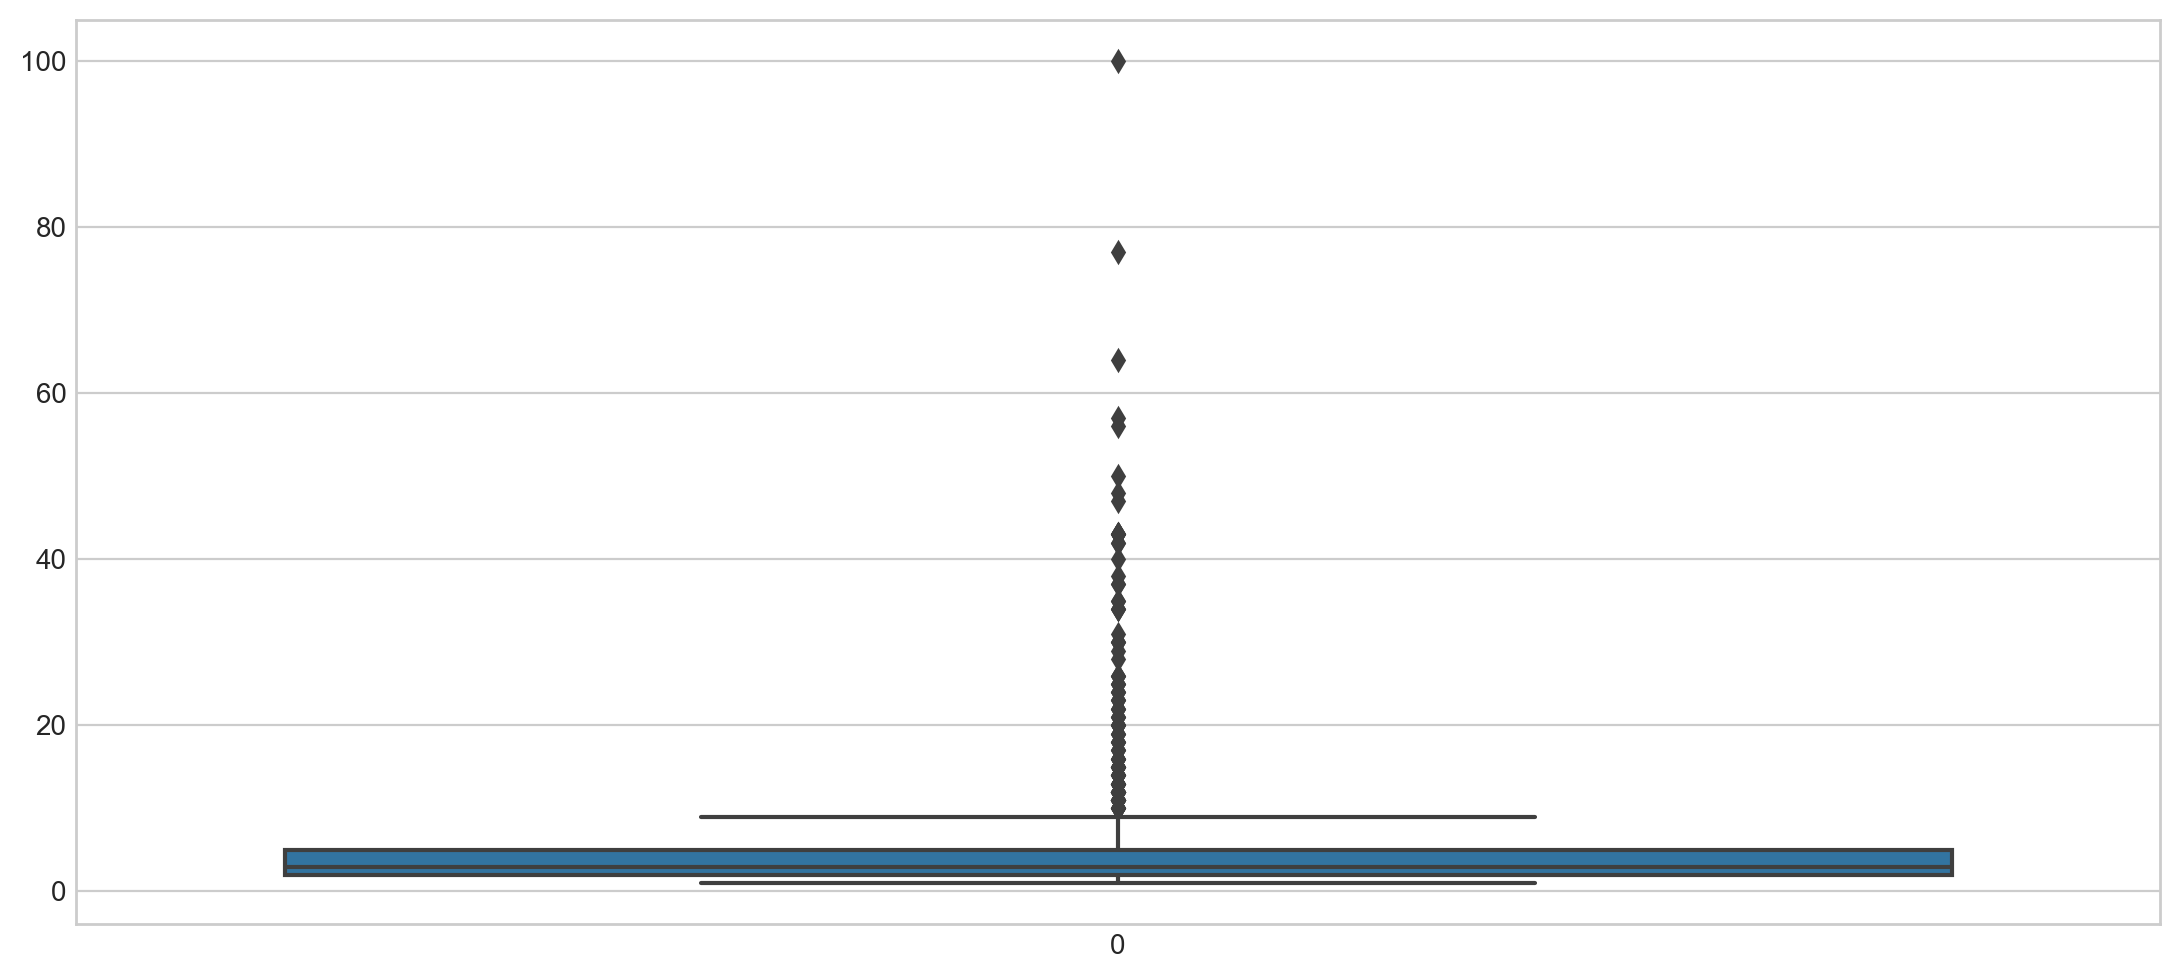

In [16]:
%%capture
sns.boxplot(df.NumberofFloors)

In [17]:
df[df.NumberofFloors > 40 ].index

Index([2, 221, 222, 229, 231, 233, 256, 261, 271, 273, 292, 490, 559, 577,
       1359],
      dtype='int64')

- Number of Buildings

In [18]:
df.NumberofBuildings.value_counts()

NumberofBuildings
1.0     1571
2.0       14
3.0       12
5.0        8
4.0        4
6.0        4
14.0       2
8.0        2
27.0       1
11.0       1
9.0        1
7.0        1
23.0       1
10.0       1
Name: count, dtype: int64

In [19]:
df[df.NumberofBuildings > 5].index

Index([105, 124, 128, 162, 167, 170, 364, 618, 1672, 1862, 1993, 2325, 2901,
       3168],
      dtype='int64')

- PropertyGFA

In [20]:
df[df.PropertyGFATotal > 1500000].sort_values(by='PropertyGFATotal')

BuildingType PrimaryPropertyType      Neighborhood   Latitude  \
273   NonResidential        Large Office          downtown  47.610540   
155   NonResidential               Other  greater duwamish  47.595440   
490   NonResidential        Large Office          downtown  47.607400   
292   NonResidential        Large Office          downtown  47.610430   
618   NonResidential            Hospital              east  47.608951   
559   NonResidential        Large Office          downtown  47.604540   
1494          Campus          University              east  47.610650   

       Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
273  -122.334660       1989                1.0              47   
155  -122.331590       1999                1.0               7   
490  -122.337770       2005                1.0              43   
292  -122.332060       1989                1.0              57   
618  -122.322402       1994                7.0              15   
559  -122.330720       1985                1.0              77   
1494 -122.317110       1939                1.0               3   

      PropertyGFATotal  PropertyGFAParking  ...  Laboratory Restaurant  \
273            1536606              512608  ...         0.0        0.0   
155            1585960              327680  ...         0.0        0.0   
490            1592914                   0  ...         0.0        0.0   
292            1605578              389860  ...         0.0        0.0   
618            1765970                   0  ...         0.0        0.0   
559            1952220              319400  ...         0.0        0.0   
1494           2200000                   0  ...         0.0        0.0   

     Refrigerated Warehouse  Social/Meeting Hall  \
273                     0.0                  0.0   
155                     0.0                  0.0   
490                     0.0                  0.0   
292                     0.0                  0.0   
618                     0.0                  0.0   
559                     0.0                  0.0   
1494                    0.0                  0.0   

     Hospital (General Medical & Surgical)  Multifamily Housing  \
273                                    0.0                  0.0   
155                                    0.0                  0.0   
490                                    0.0                  0.0   
292                                    0.0                  0.0   
618                              1639334.0                  0.0   
559                                    0.0                  0.0   
1494                                   0.0                  0.0   

     Manufacturing/Industrial Plant  \
273                             0.0   
155                             0.0   
490                             0.0   
292                             0.0   
618                             0.0   
559                             0.0   
1494                            0.0   

      Repair Services (Vehicle, Shoe, Locksmith, etc)  Strip Mall  \
273                                               0.0         0.0   
155                                               0.0         0.0   
490                                               0.0         0.0   
292                                               0.0         0.0   
618                                               0.0         0.0   
559                                               0.0         0.0   
1494                                              0.0         0.0   

      floor_building  
273     4.812791e+07  
155     8.807960e+06  
490     6.849530e+07  
292     6.929593e+07  
618     3.784221e+06  
559     1.257271e+08  
1494    6.600000e+06  

[7 rows x 67 columns]

- PropertyGFAParking

In [21]:
df.PropertyGFAParking.value_counts()

PropertyGFAParking
0         1294
13320        3
10800        2
30000        2
100176       2
          ... 
47656        1
115228       1
33921        1
44728        1
85028        1
Name: count, Length: 323, dtype: int64

In [22]:
df[df.PropertyGFAParking >  200000 ].index

Index([  43,   77,  155,  163,  207,  212,  229,  271,  273,  292,  307,  338,
        492,  559,  577,  599, 2530, 3233],
      dtype='int64')

- PropertyGFABuilding(s)

In [23]:
df[df['PropertyGFABuildings'] > 1500000].sort_values(by='PropertyGFABuildings', ascending=False).index

Index([1494, 618, 559, 490], dtype='int64')

- SiteEUI(kBtu/sf)

In [27]:
%%capture
sns.boxplot(df['SiteEUI(kBtu/sf)'])

In [25]:
df[df['SiteEUI(kBtu/sf)'] > 500 ].sort_values(by='SiteEUI(kBtu/sf)', ascending=False).index

Index([240, 309, 809, 3203, 558, 3171], dtype='int64')

- SiteEUIWN(kBtu/sf)

In [28]:
%%capture
sns.boxplot(df['SiteEUIWN(kBtu/sf)'])

In [21]:
df[df['SiteEUIWN(kBtu/sf)'] > 500 ].sort_values(by='SiteEUIWN(kBtu/sf)', ascending=False).index

Index([240, 309, 3203, 809, 558, 3171], dtype='int64')

- SiteEnergyUse(kBtu)

In [29]:
%%capture
sns.boxplot(df['SiteEnergyUse(kBtu)'])

In [23]:
df[df['SiteEnergyUse(kBtu)'] > 200000000 ].sort_values(by='SiteEnergyUse(kBtu)', ascending=False).index

Index([170, 618, 558, 124], dtype='int64')

- SteamUse(kBtu)

In [30]:
%%capture
sns.boxplot(df['SteamUse(kBtu)'])

In [25]:
df[df['SteamUse(kBtu)'] > 20000000 ].sort_values(by='SteamUse(kBtu)', ascending=False).index

Index([618, 170, 3264, 3156, 262, 2], dtype='int64')

In [26]:
df[df['SteamUse(kBtu)'] == 0].shape

(1512, 68)

- Electricity(kWh)

In [31]:
%%capture
sns.boxplot(df["Electricity(kWh)"])

In [28]:
df[df['Electricity(kWh)'] > 25000000 ].sort_values(by='Electricity(kWh)', ascending=False).index

Index([558, 170, 618, 124, 3264, 559], dtype='int64')

- Natural Gas (therms and kBtu)

In [32]:
%%capture
sns.boxplot(df['NaturalGas(therms)'])

In [30]:
df[df['NaturalGas(therms)'] > 500000 ].sort_values(by='NaturalGas(therms)', ascending=False).index

Index([124, 167, 2325, 340, 1672, 1690, 1494], dtype='int64')

- ComplianceStatus

In [31]:
df.ComplianceStatus.value_counts()

ComplianceStatus
Compliant                       1523
Error - Correct Default Data      86
Non-Compliant                     14
Name: count, dtype: int64

- TotalGHGEmissions & GHGEmissionsIntensity

In [32]:
df[df['TotalGHGEmissions'] > 5000 ].sort_values(by='TotalGHGEmissions', ascending=False)

BuildingType PrimaryPropertyType Neighborhood   Latitude   Longitude  \
618   NonResidential            Hospital         east  47.608951 -122.322402   
170   NonResidential            Hospital         east  47.603990 -122.323770   
124   NonResidential            Hospital    northeast  47.662310 -122.281460   
3264  NonResidential            Hospital         east  47.609860 -122.327740   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
618        1994                7.0              15           1765970   
170        2000                9.0               9           1158691   
124        1953                6.0              11            879000   
3264       1920                1.0               9            374466   

      PropertyGFAParking  ...  Restaurant Refrigerated Warehouse  \
618                    0  ...         0.0                    0.0   
170                    0  ...         0.0                    0.0   
124                    0  ...         0.0                    0.0   
3264                   0  ...         0.0                    0.0   

     Social/Meeting Hall  Hospital (General Medical & Surgical)  \
618                  0.0                              1639334.0   
170                  0.0                              1350182.0   
124                  0.0                               879000.0   
3264                 0.0                              1010135.0   

     Multifamily Housing  Manufacturing/Industrial Plant  \
618                  0.0                             0.0   
170                  0.0                             0.0   
124                  0.0                             0.0   
3264                 0.0                             0.0   

     Repair Services (Vehicle, Shoe, Locksmith, etc)  Strip Mall  \
618                                              0.0         0.0   
170                                              0.0         0.0   
124                                              0.0         0.0   
3264                                             0.0         0.0   

      floor_building  ratio_GFAdecennie  
618     3.784221e+06      588656.666667  
170     1.158691e+06      579345.500000  
124     1.611500e+06      125571.428571  
3264    3.370194e+06       37446.600000  

[4 rows x 68 columns]

In [33]:
df[df['GHGEmissionsIntensity'] > 14 ].sort_values(by='GHGEmissionsIntensity', ascending=False).index

Index([809, 3373, 3365, 3264, 1817, 1279, 1753, 2380, 3156], dtype='int64')

In [33]:
%%capture
sns.boxplot(df[df.BuildingType.isin(['Campus','Hospital'])]['GHGEmissionsIntensity'].values)

In [35]:
df.PrimaryPropertyType.unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Office'], dtype=object)

In [34]:
%%capture
df.loc[df.PrimaryPropertyType.isin(['Mixed Use Property'])].sort_values(by='GHGEmissionsIntensity', ascending = False)

## 1.2 Analyse Bivariée

In [35]:
def boxplot_test(col,target, violin = False):
  print(f"\n Distribution de {target} et  {col}")
  freq_col = pd.DataFrame(df[[target,col]])
  freq_col[col] = freq_col[col].astype('str')
  print(df[col].value_counts())
  sns.color_palette("Set2")
  if violin :
    sns.violinplot(x=freq_col[target],y=freq_col[col], palette="pastel")
  else :
    sns.boxplot(x=freq_col[target],y=freq_col[col], palette="Set2",showfliers=False)
  plt.title(col)
  plt.show()

In [36]:
def scatter_test(col,target):
    sns.color_palette("Set2")
    freq_col = pd.DataFrame(df[[target,col]])
    sns.scatterplot(y=freq_col[target],x=freq_col[col], color ='black')
    plt.title(col)
    plt.show()

In [105]:
# 'Latitude', 'Longitude',
cols_num = [
       'SteamUse(kBtu)','Electricity(kBtu)',
       'NaturalGas(kBtu)','PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuildings','floor_building']
cols_categ = ['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors','decennie']

ord_categ = ['NumberofFloors','decennie','YearBuilt']

list_types = ['Data Center','Fitness Center/Health Club/Gym','Office', 'Non-Refrigerated Warehouse', 'K-12 School', 'Retail Store',
       'Other', 'Hotel', 'Worship Facility', 'Distribution Center',
       'Supermarket/Grocery Store', 'Medical Office', 'Other - Recreation',
       'Parking', 'Self-Storage Facility', 'College/University',
       'Other - Entertainment/Public Assembly', 'Senior Care Community',
       'Laboratory', 'Restaurant', 'Refrigerated Warehouse',
       'Social/Meeting Hall', 'Hospital (General Medical & Surgical)','Manufacturing/Industrial Plant',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Strip Mall']

### 1.2.1 Avec SiteEnergyUseWN(kBtu)

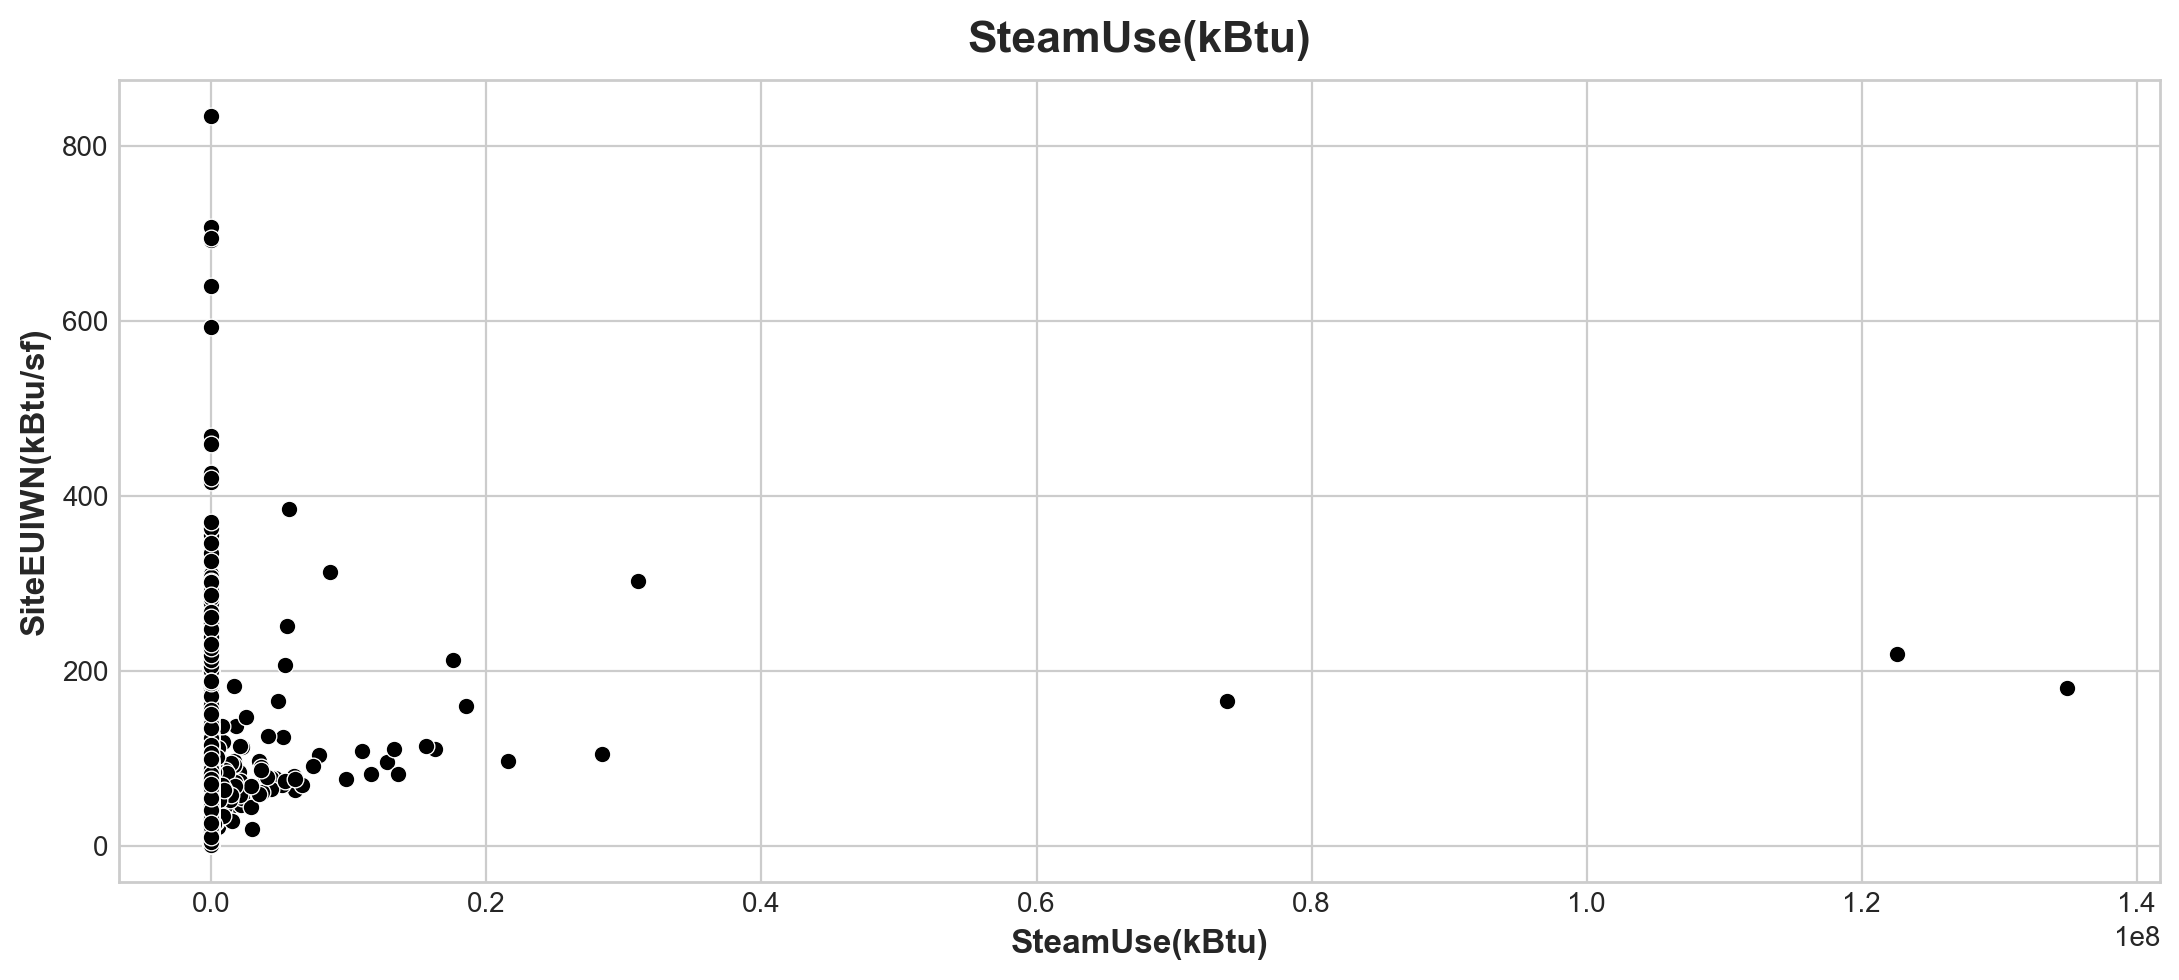

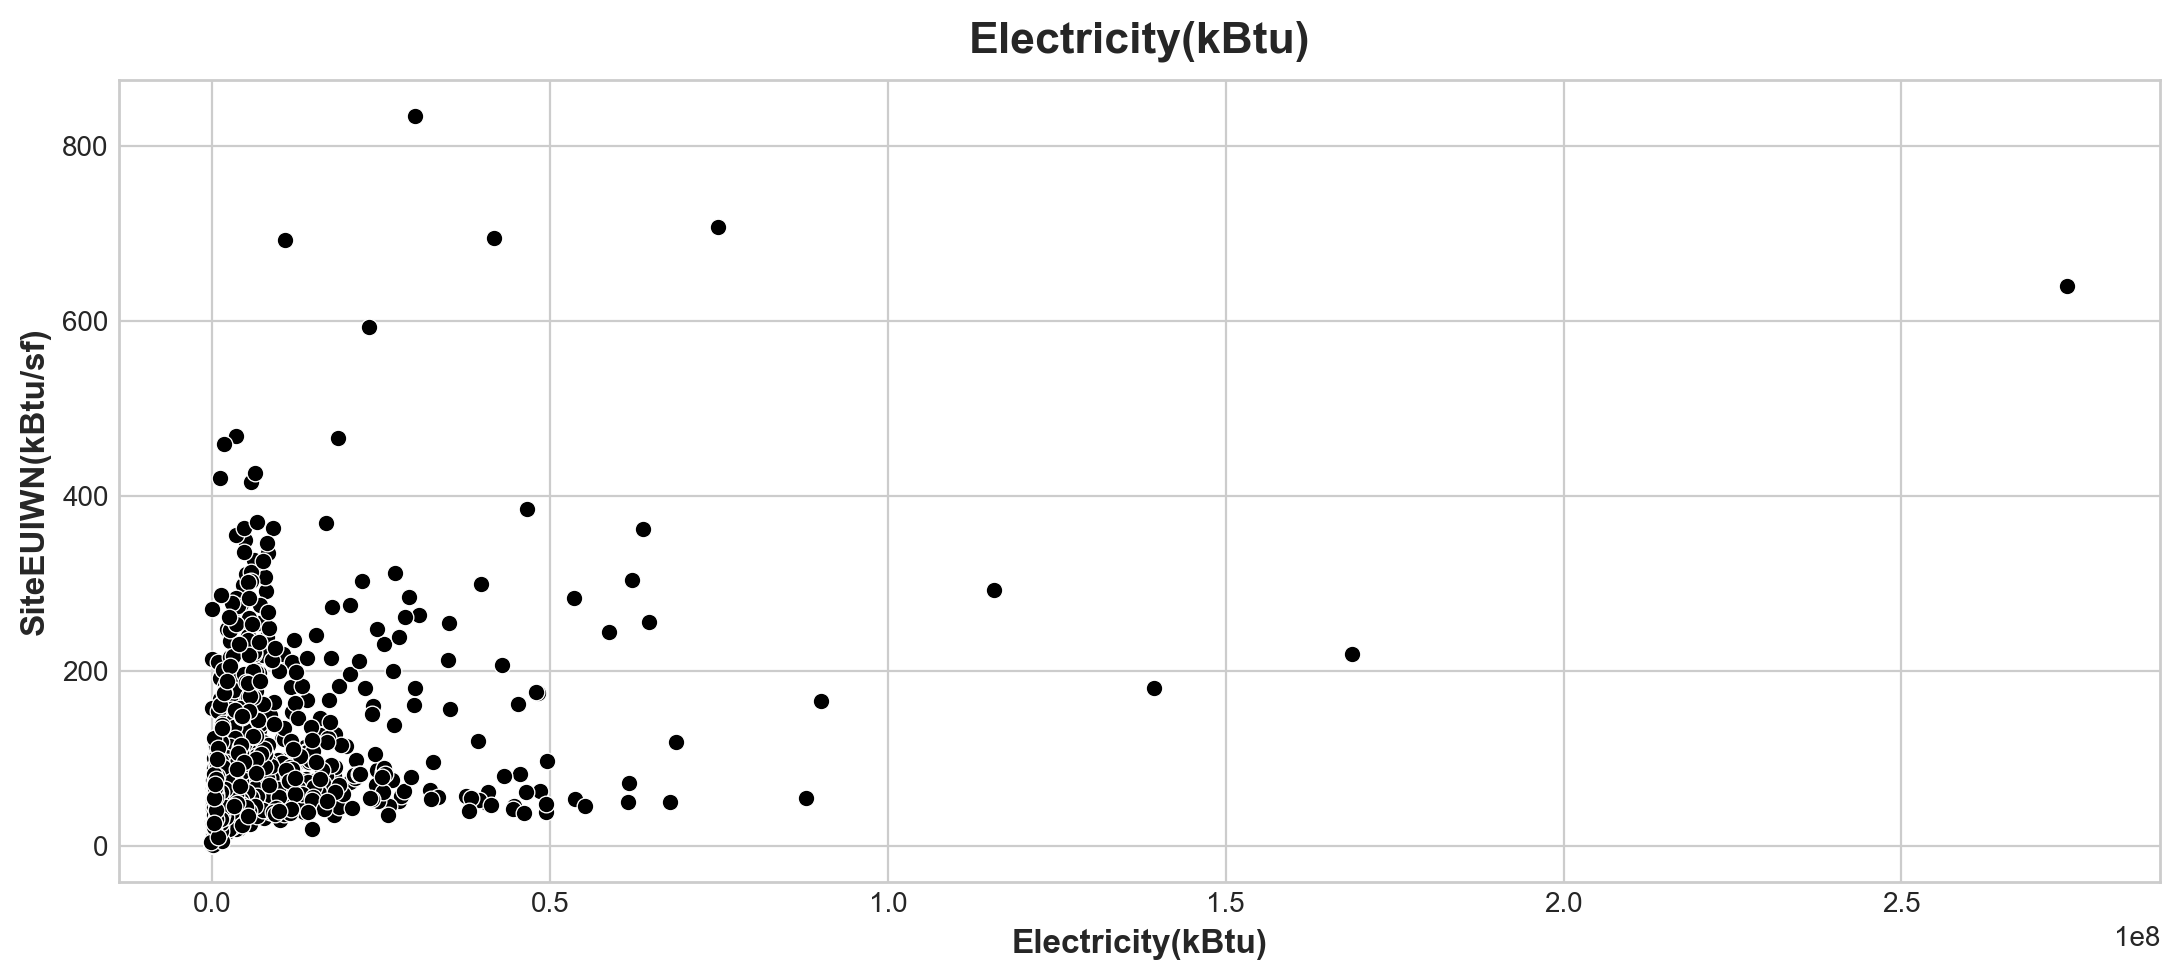

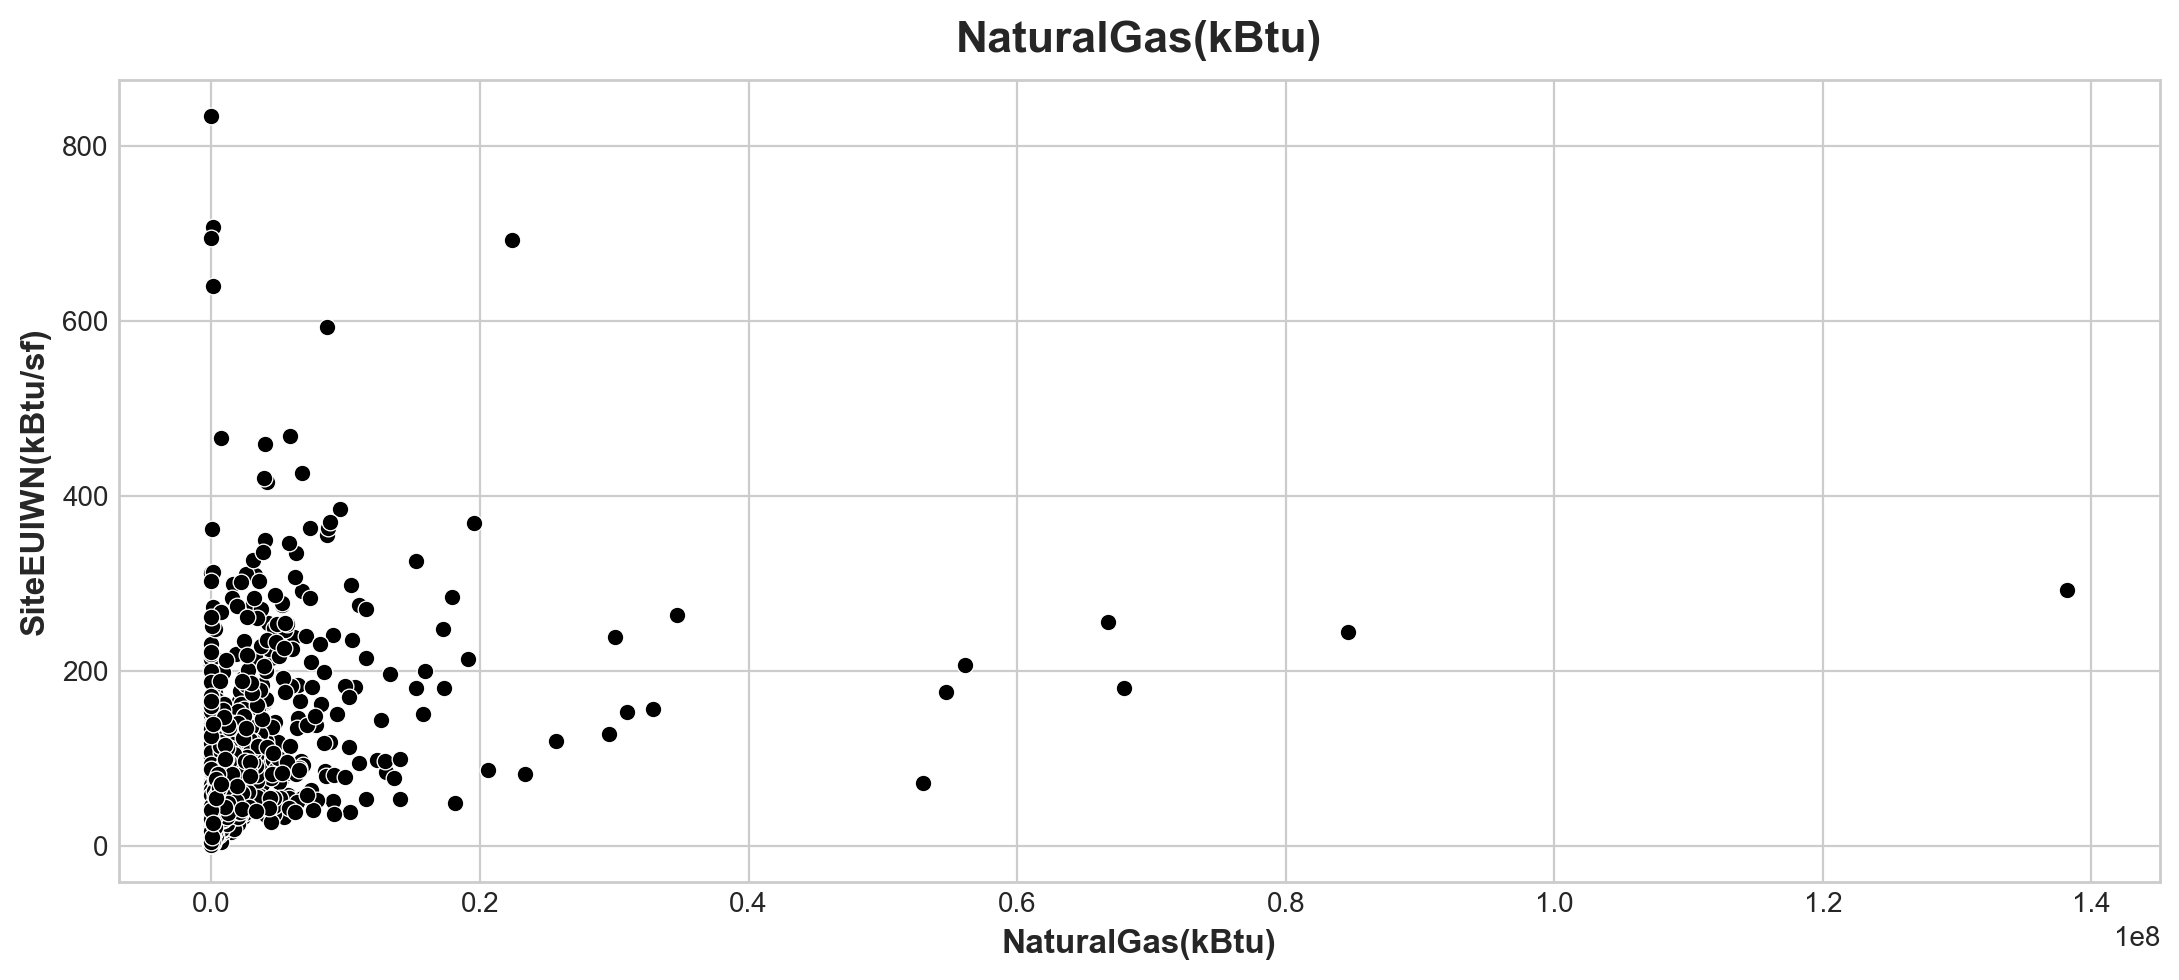

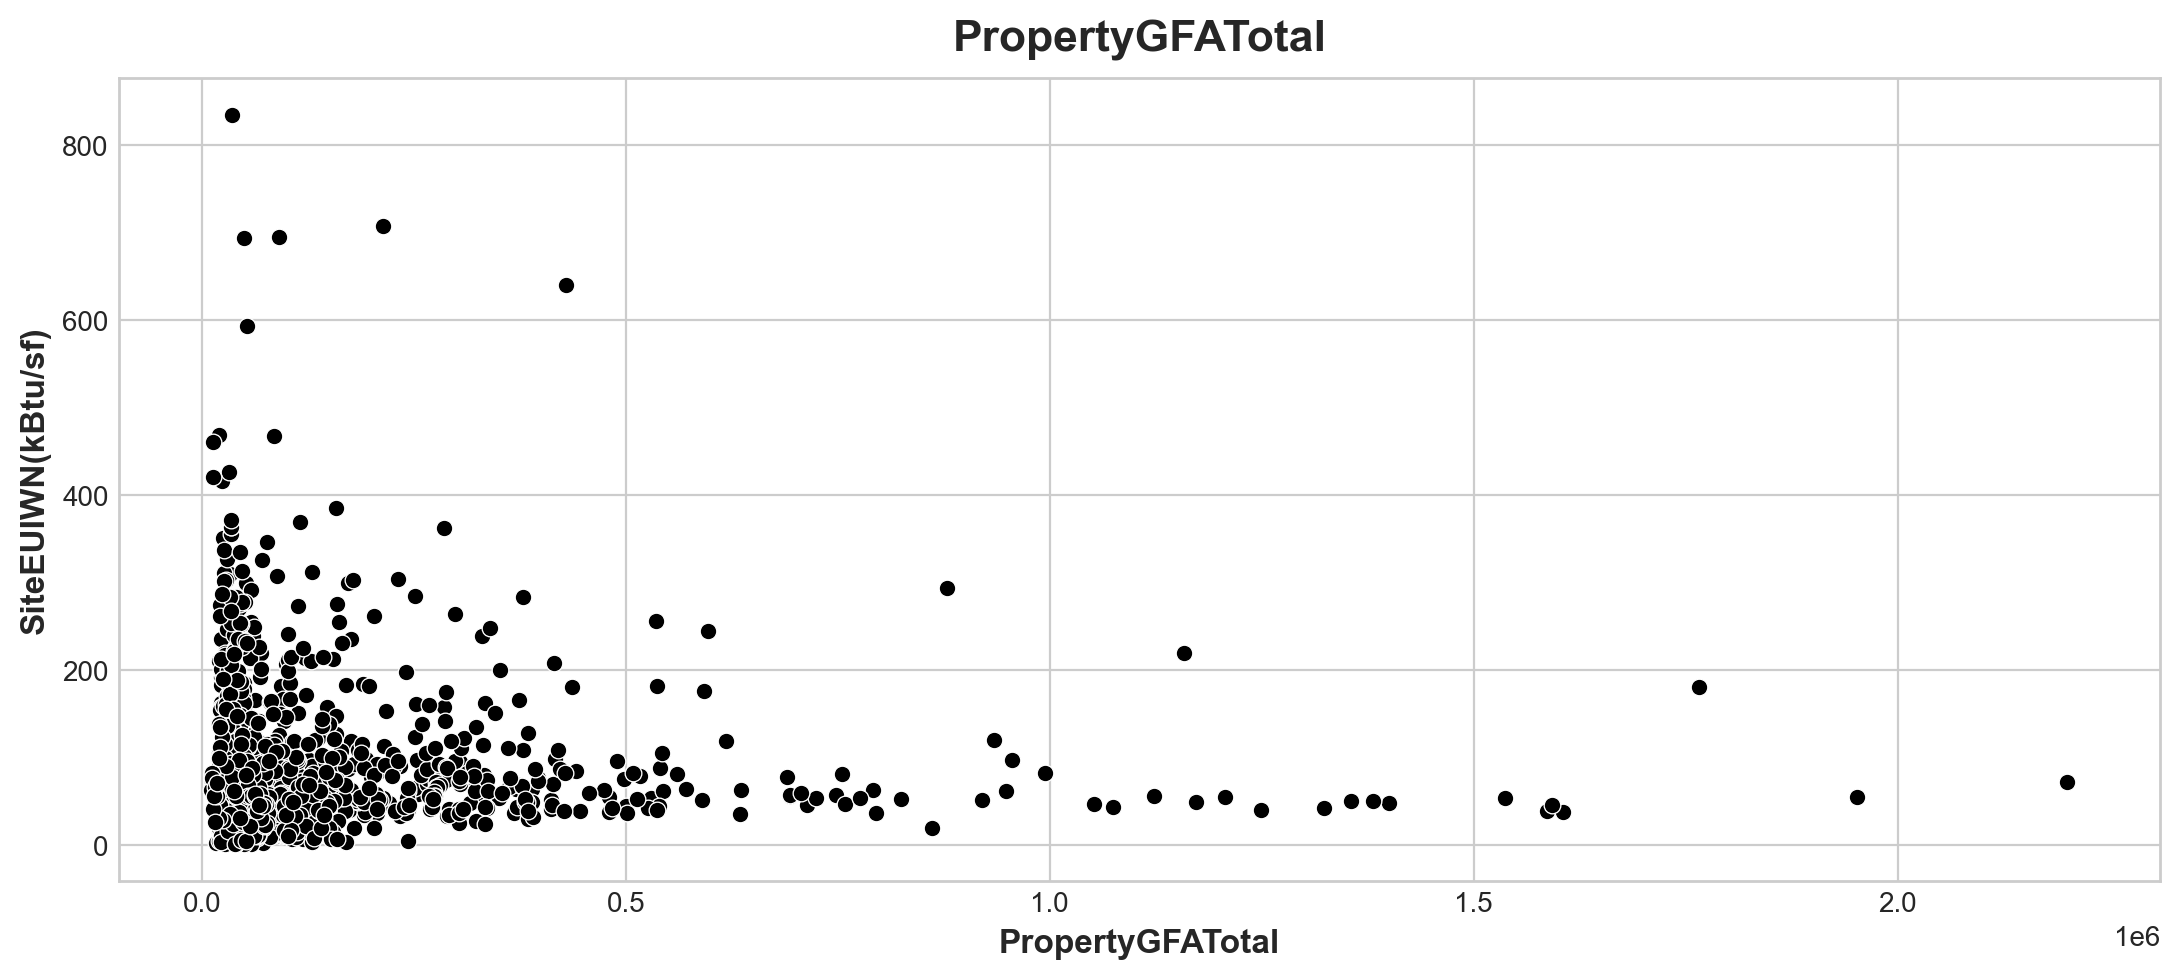

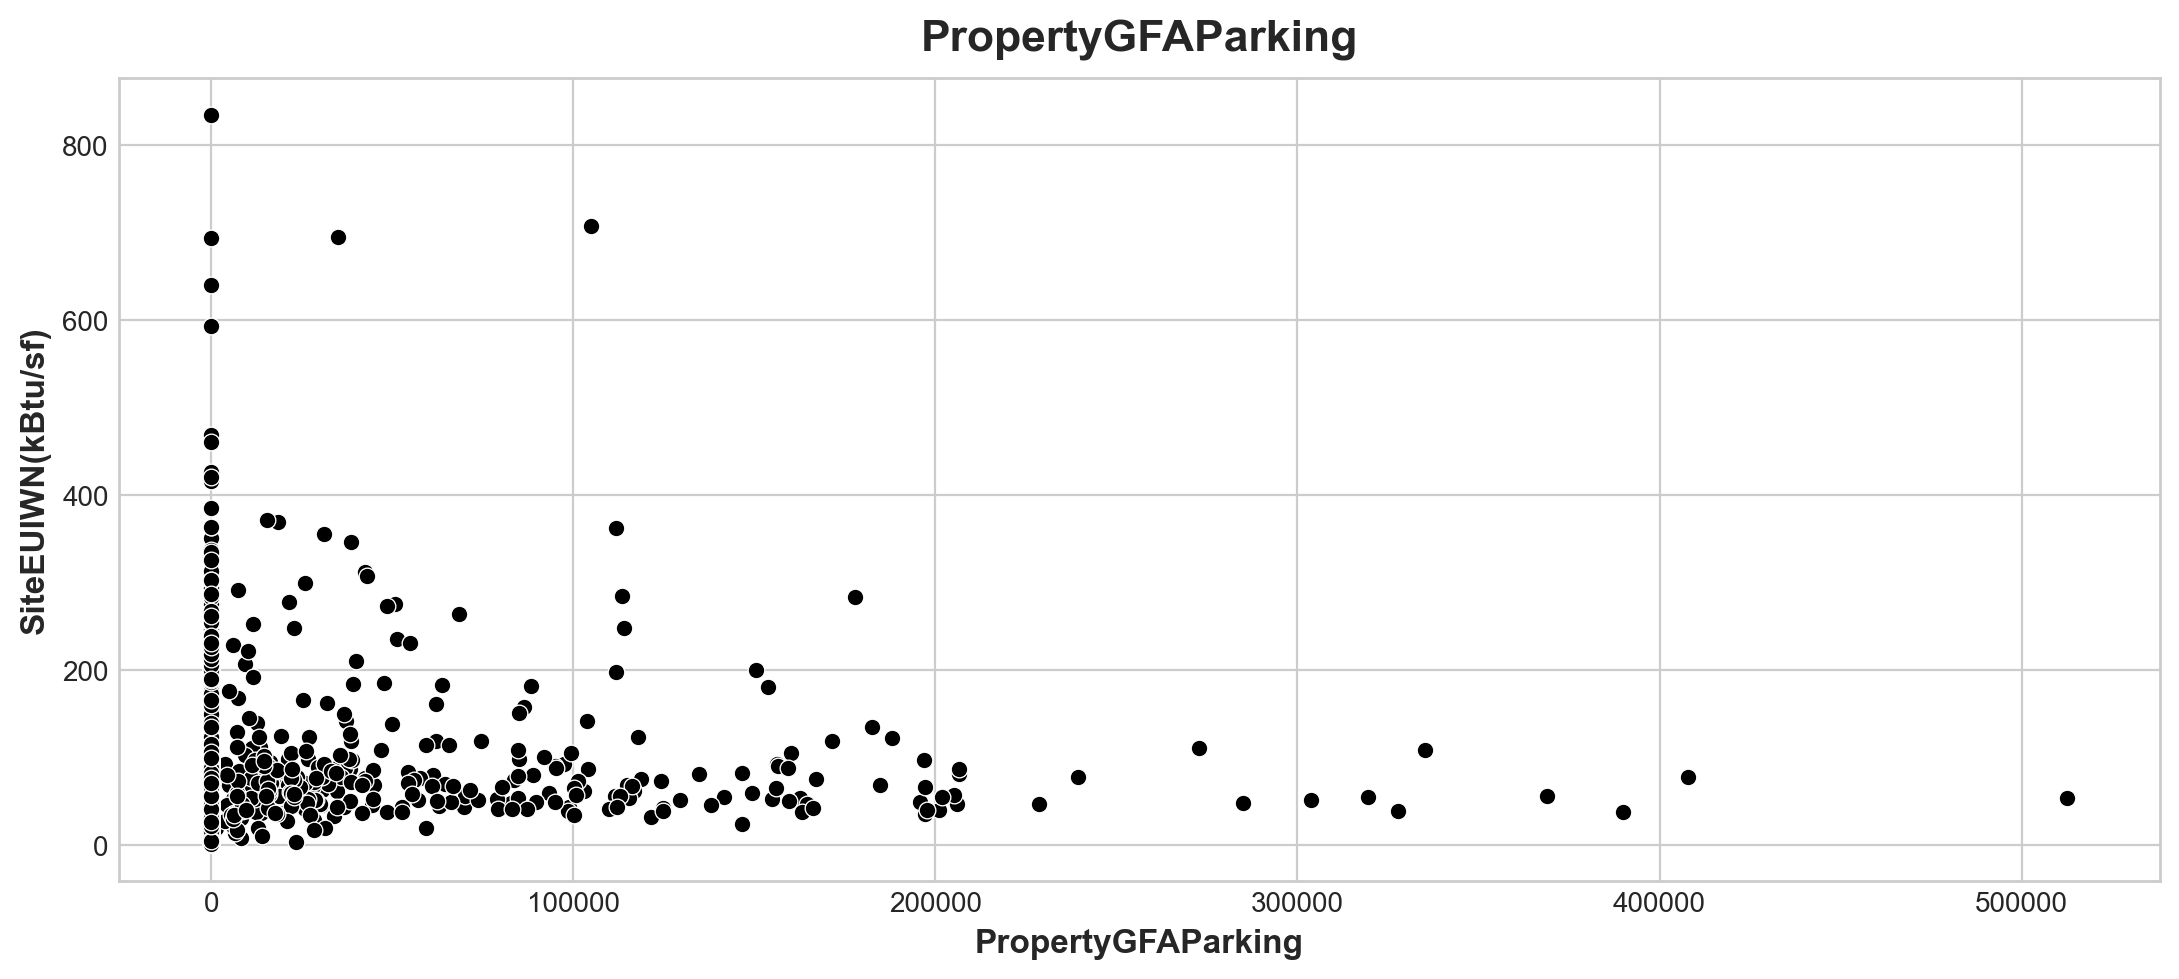

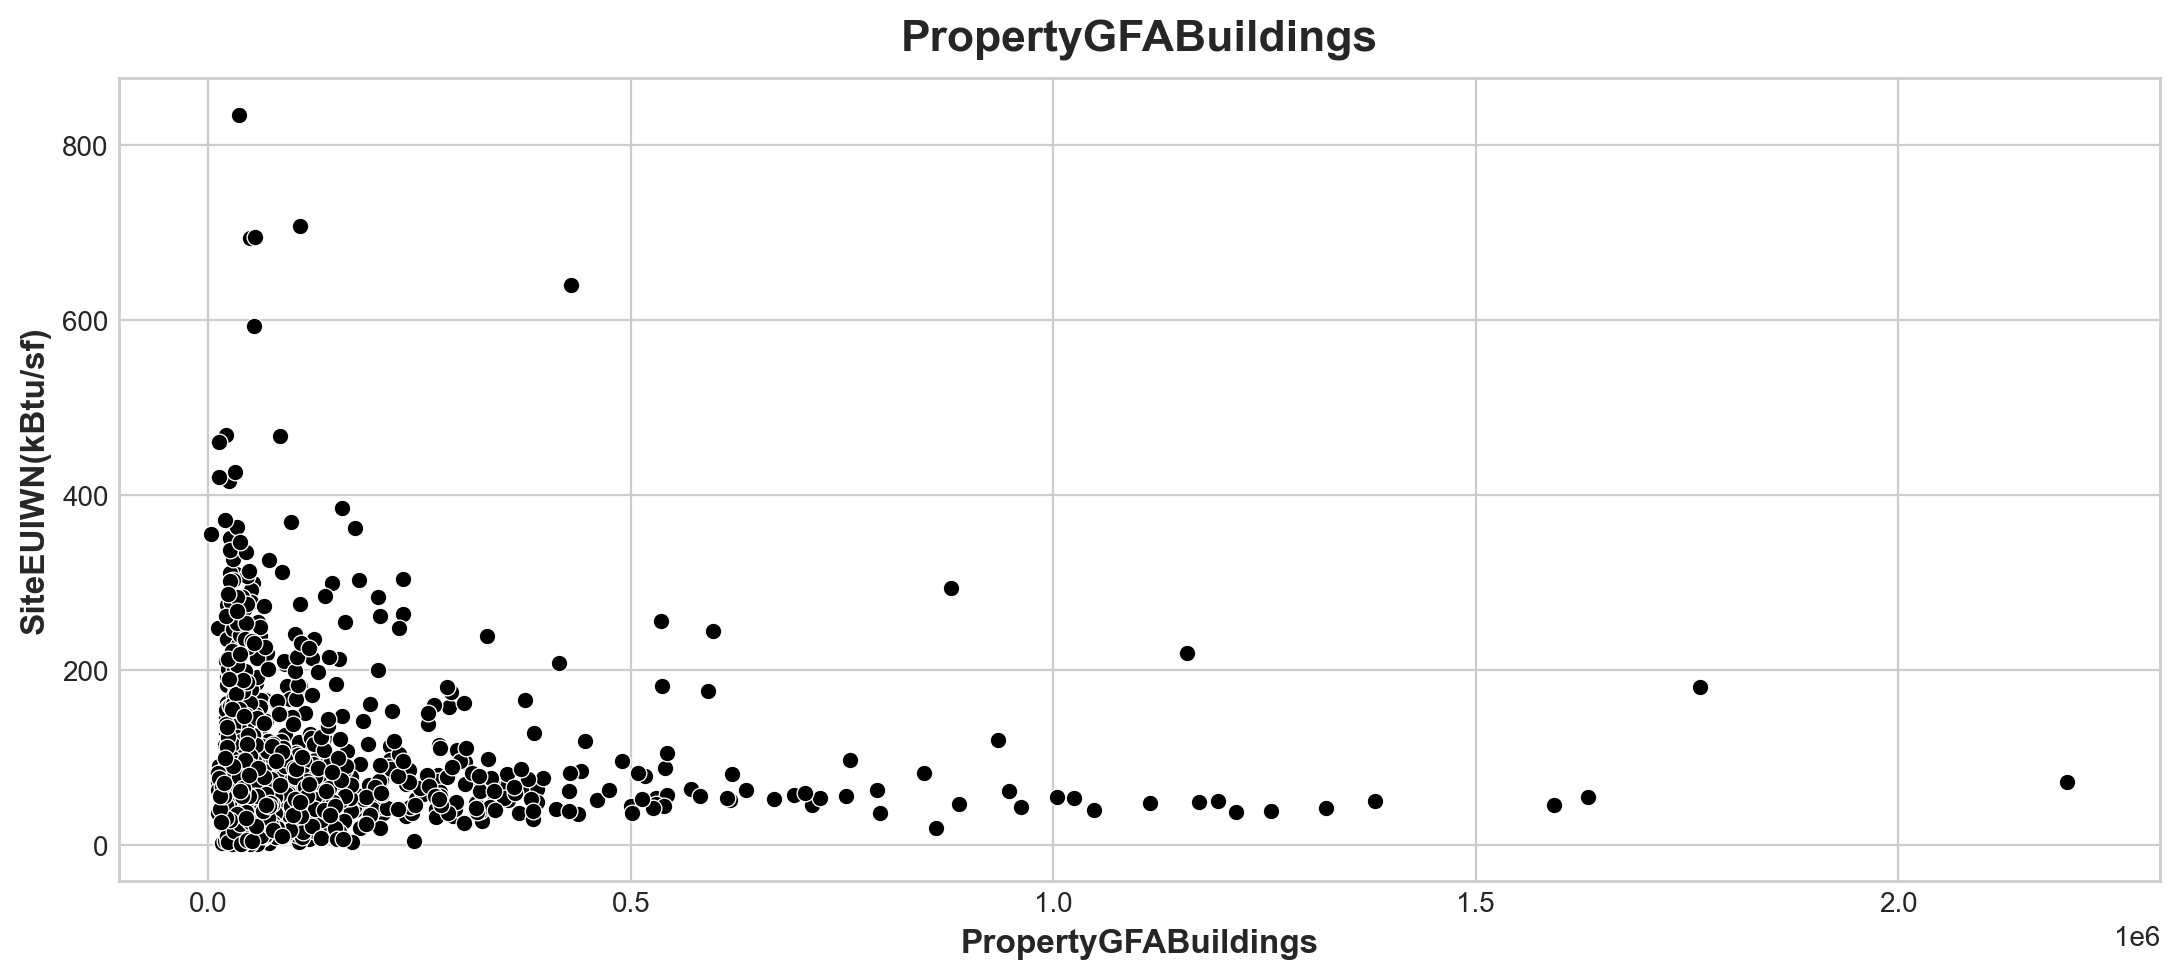

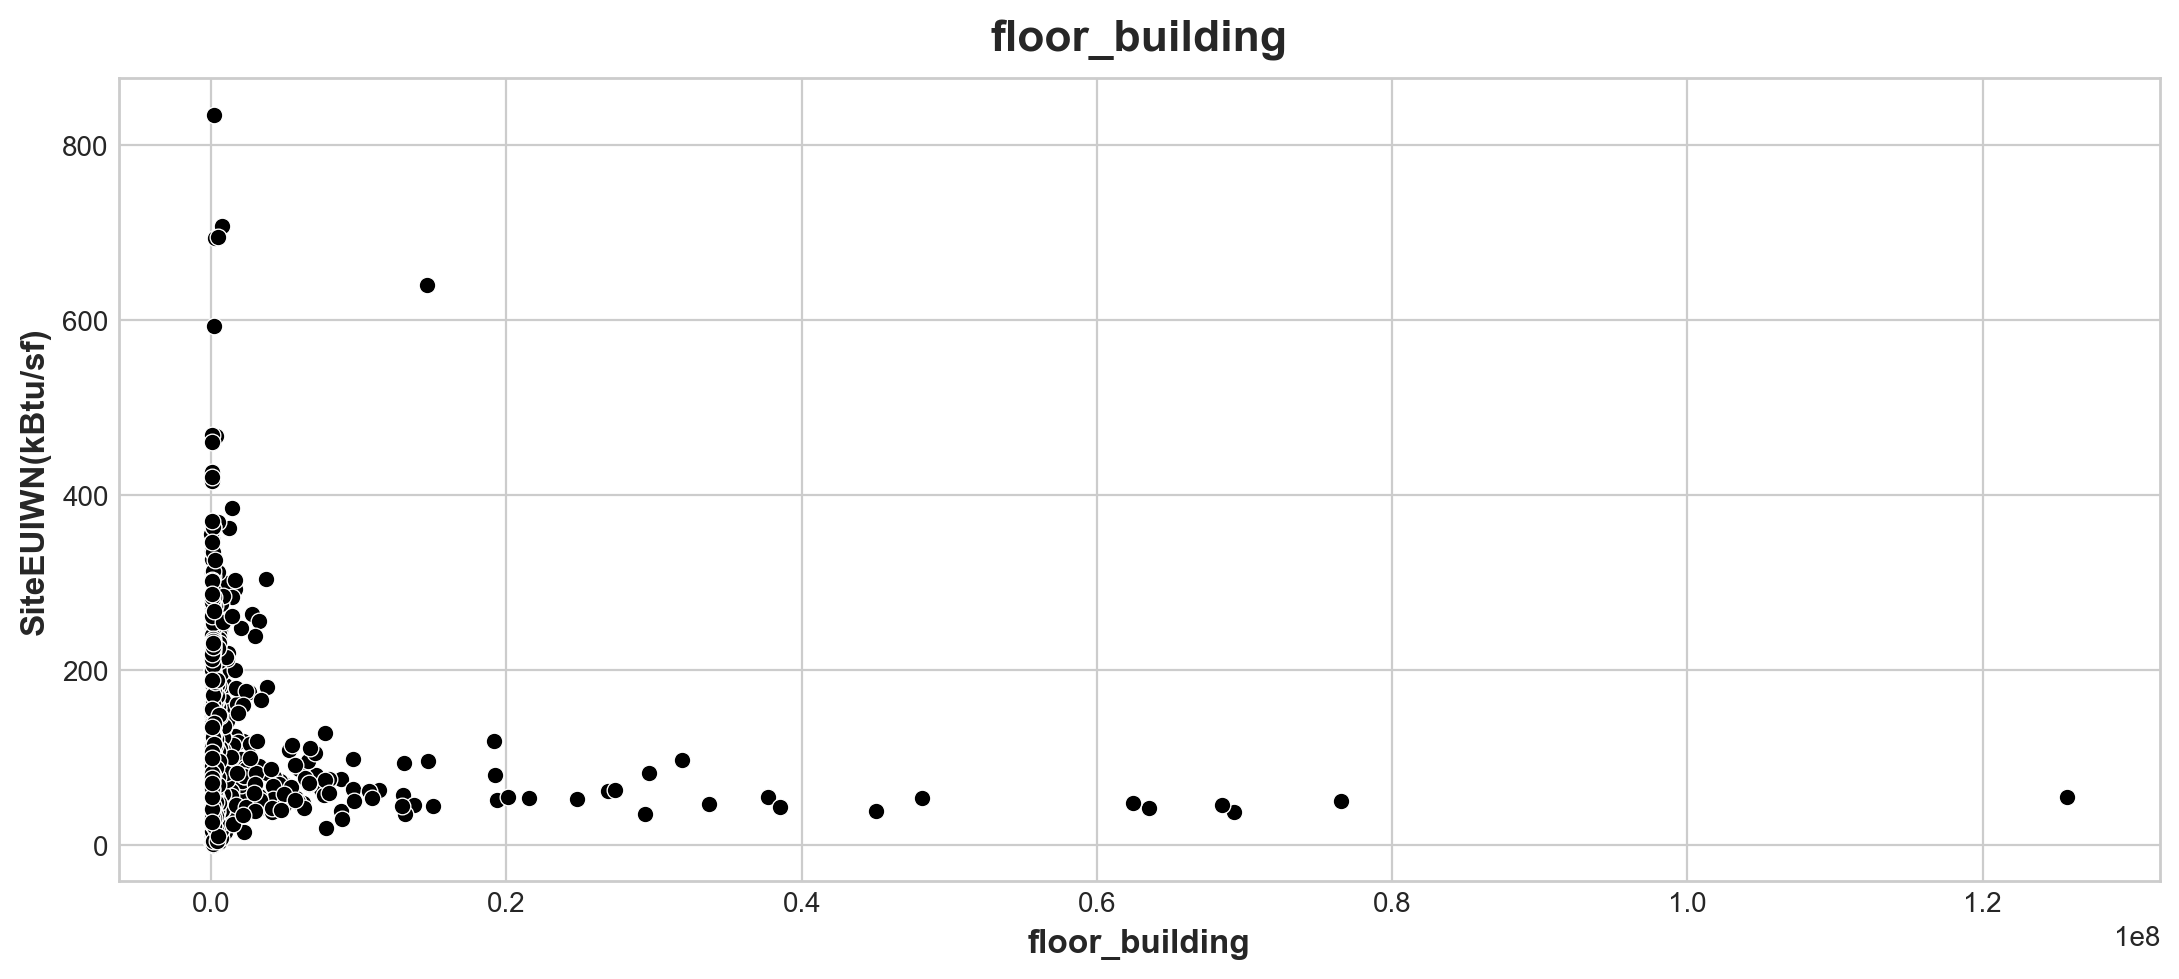

In [40]:
for col_num in cols_num :
    scatter_test(col_num,'SiteEUIWN(kBtu/sf)')

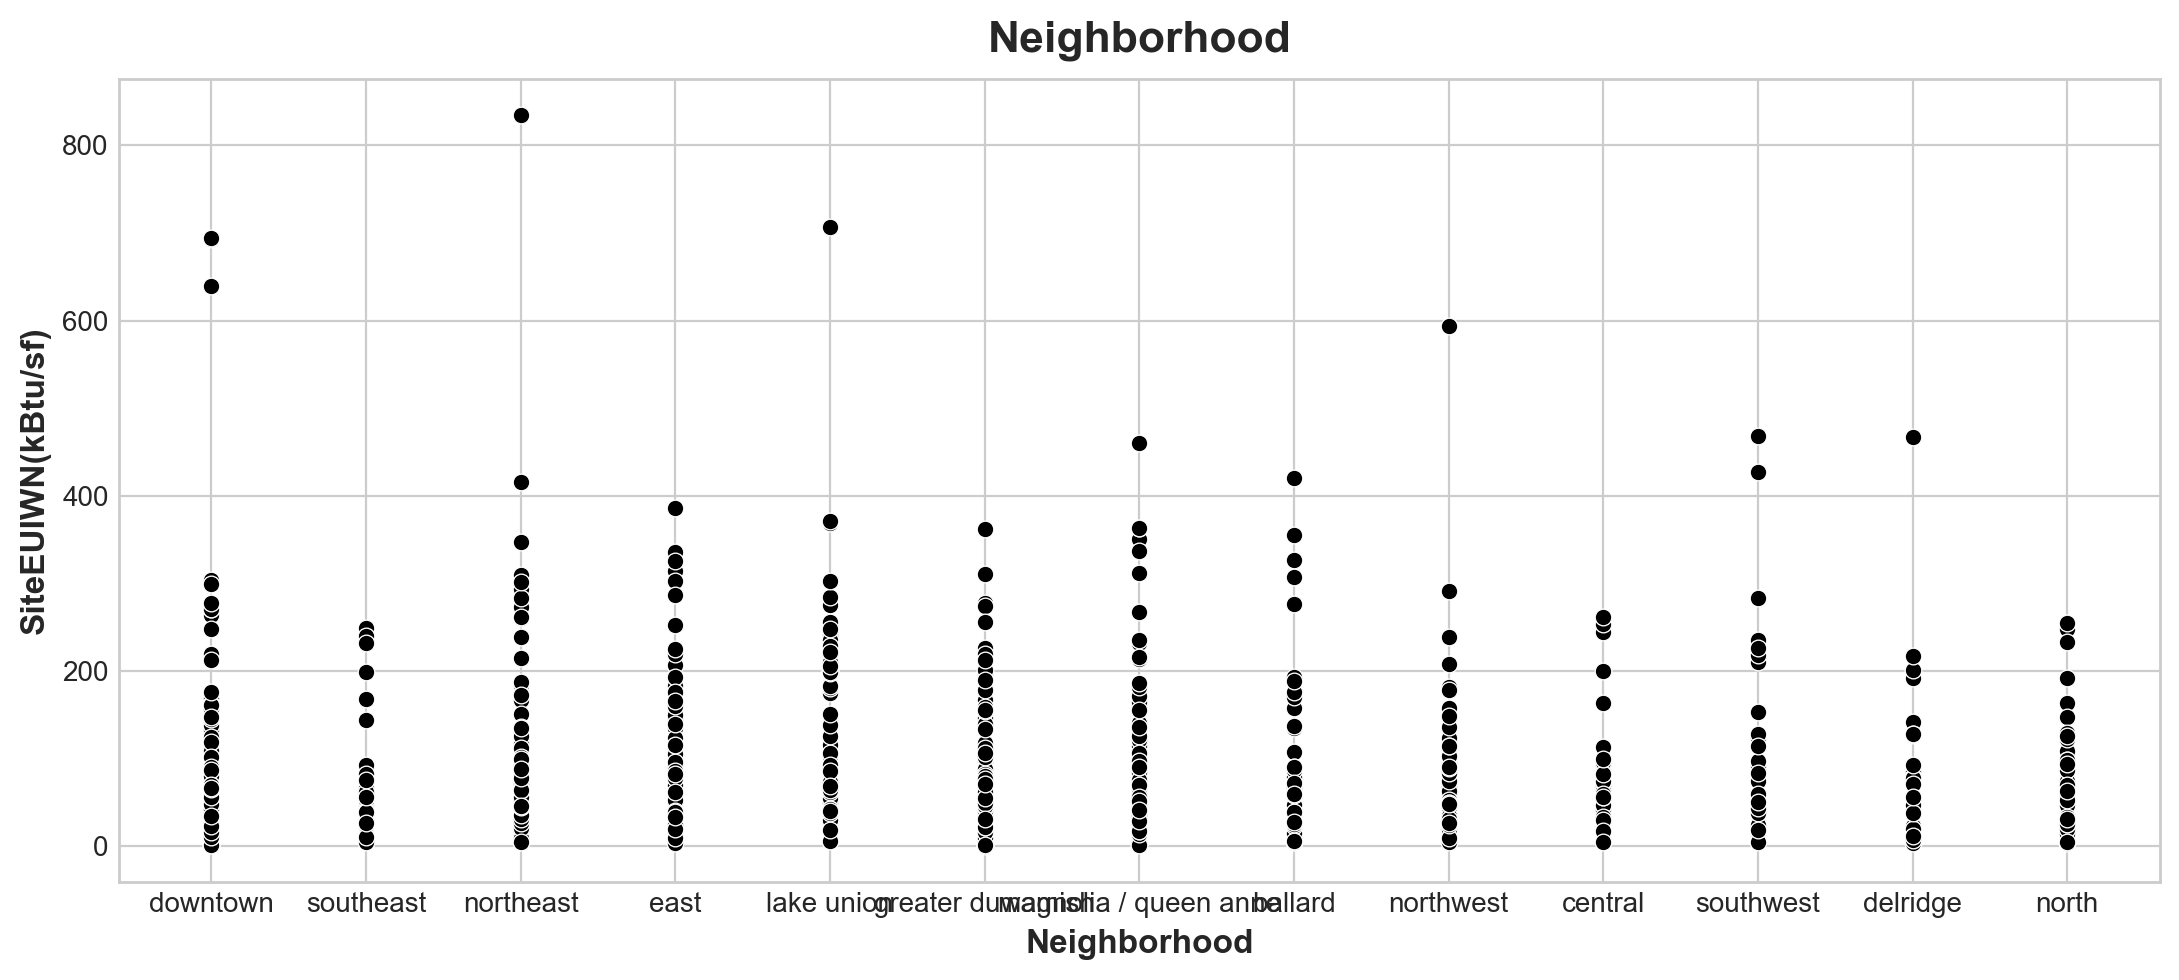

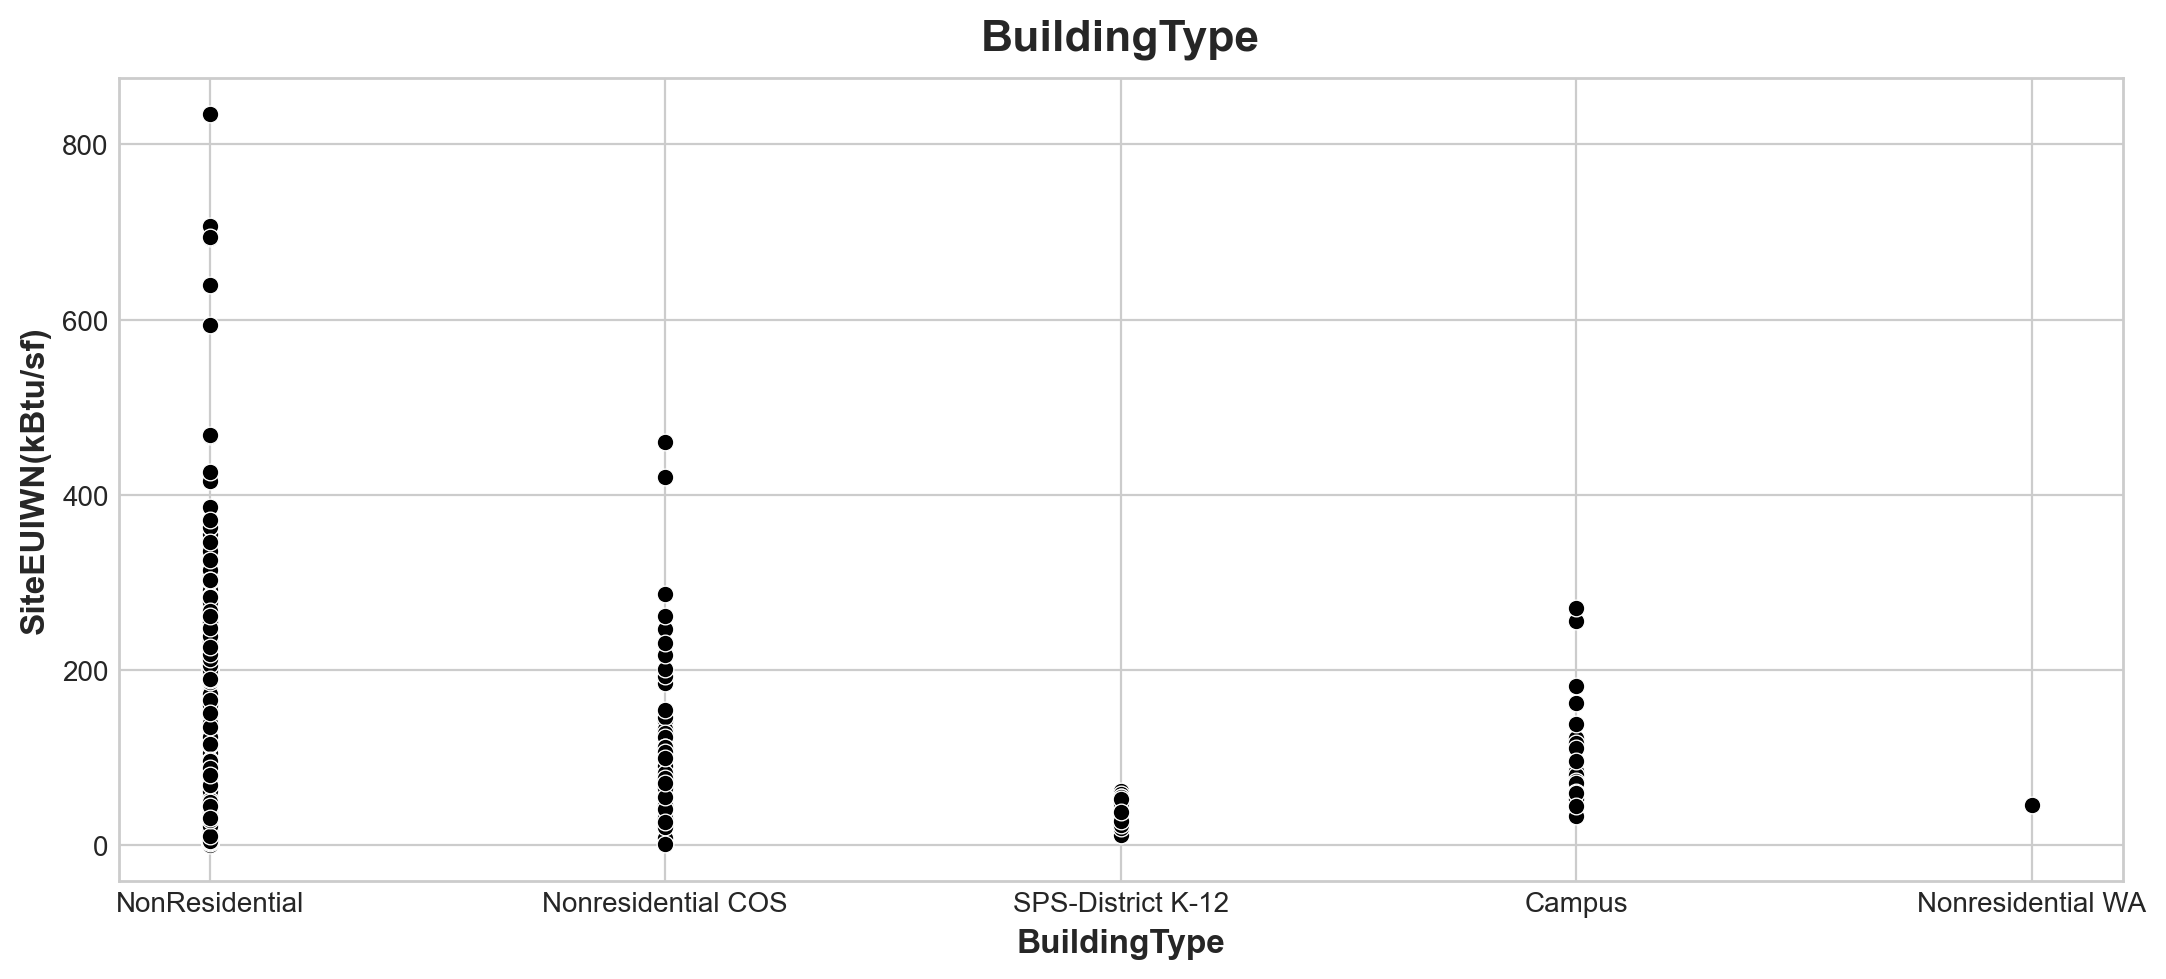

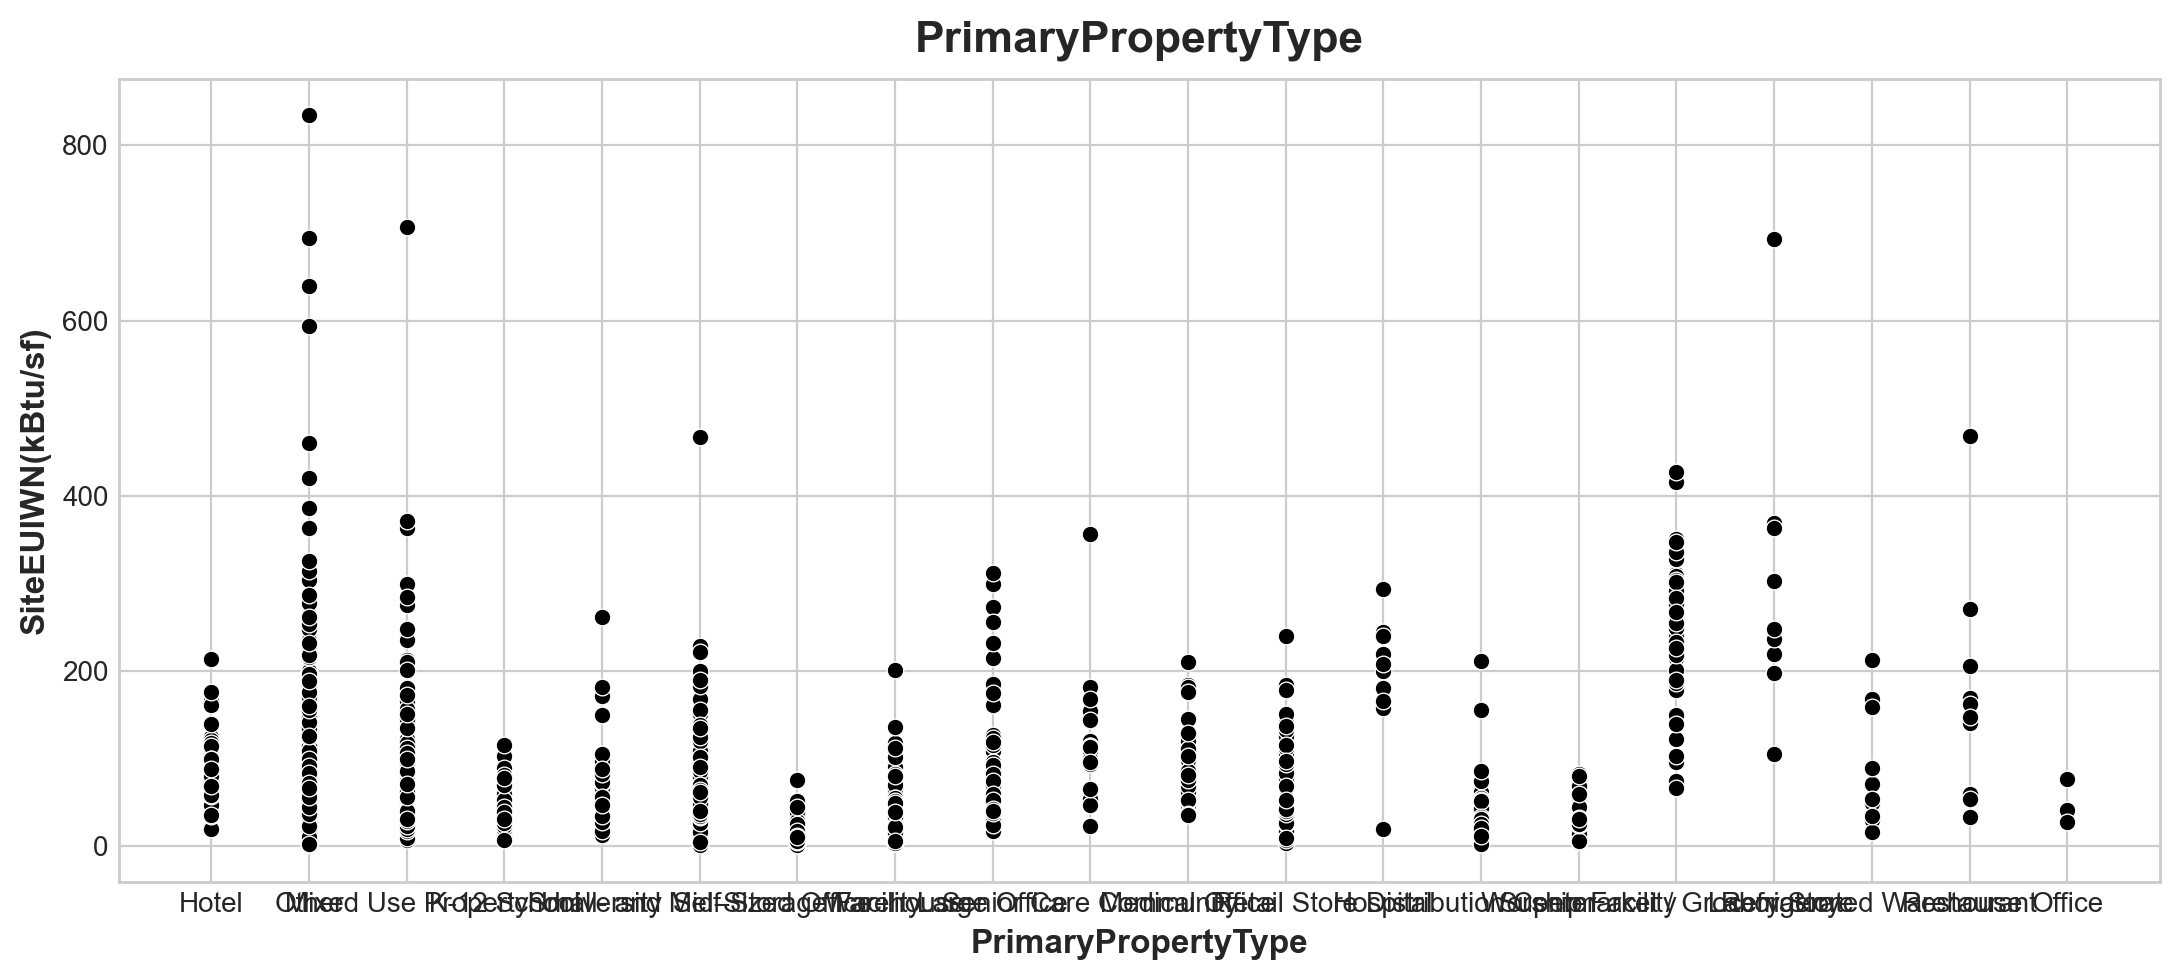

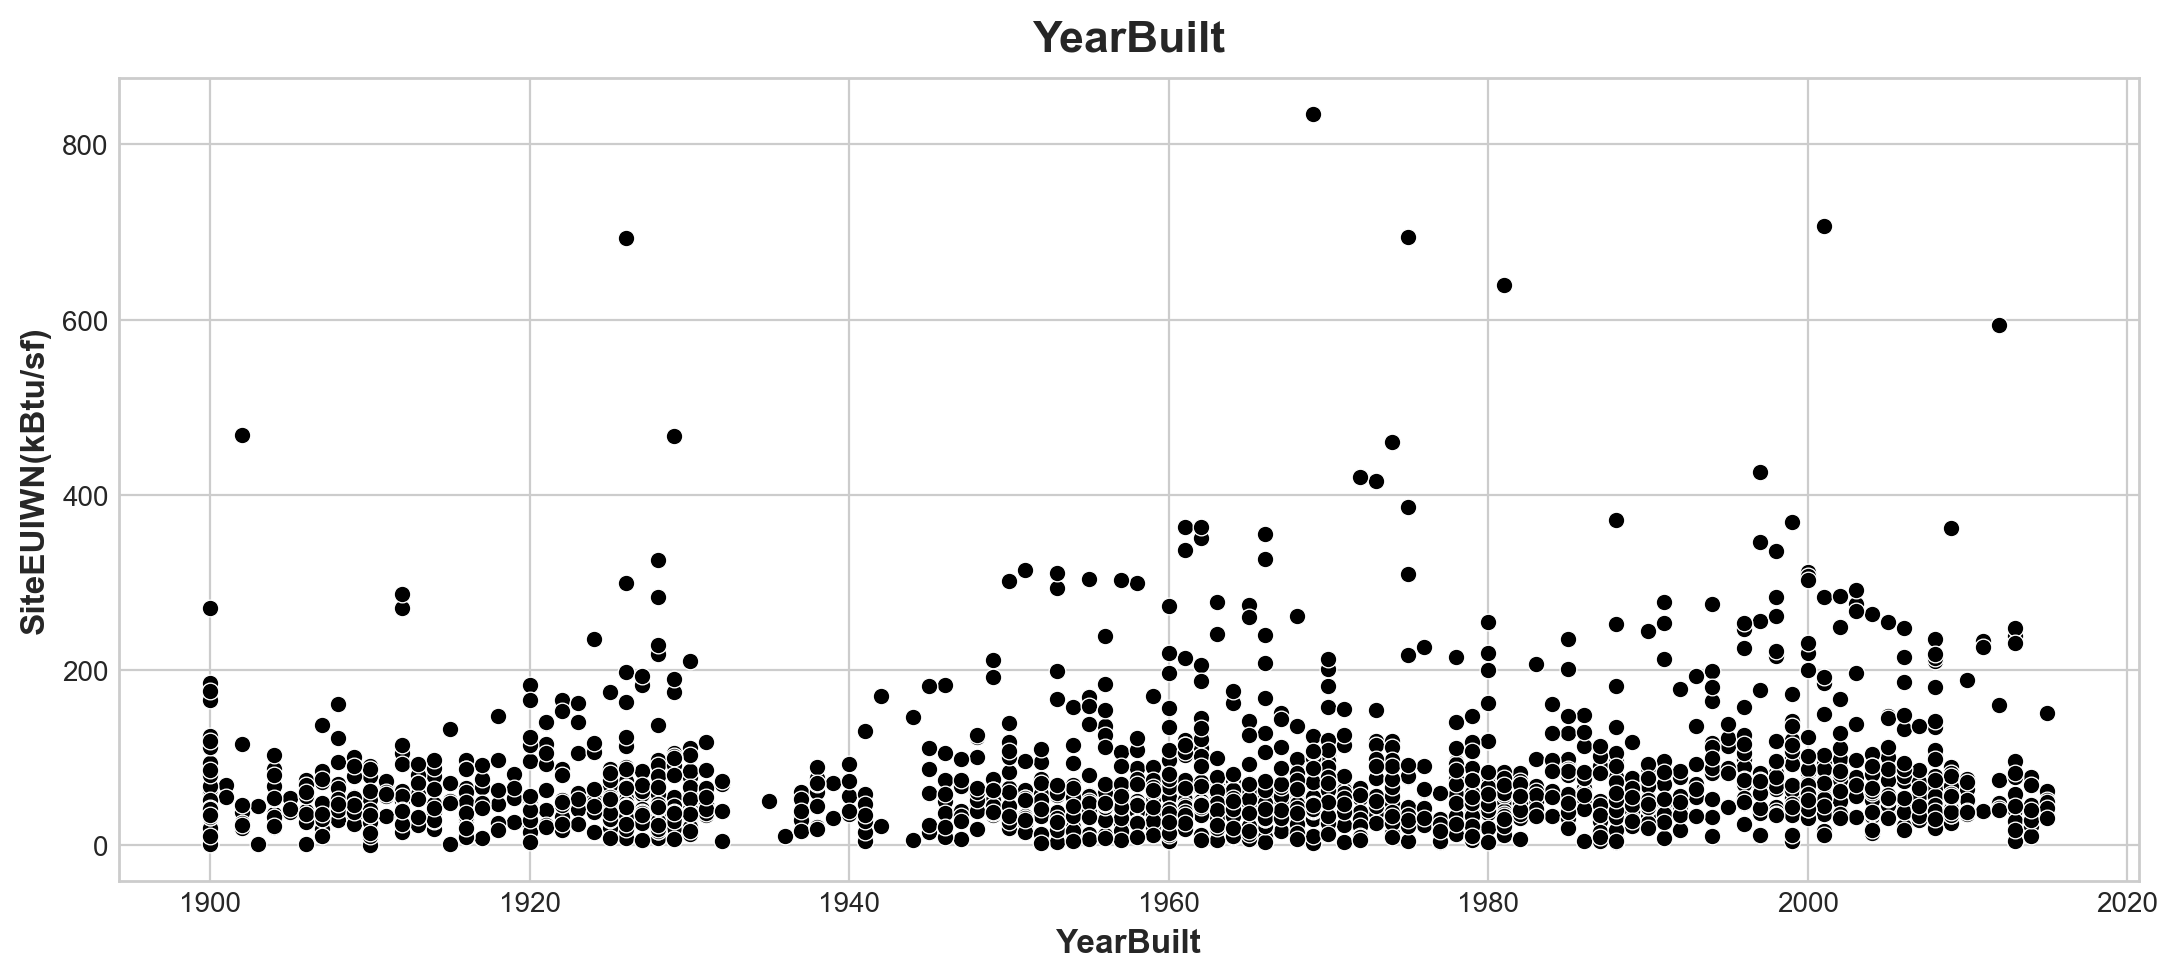

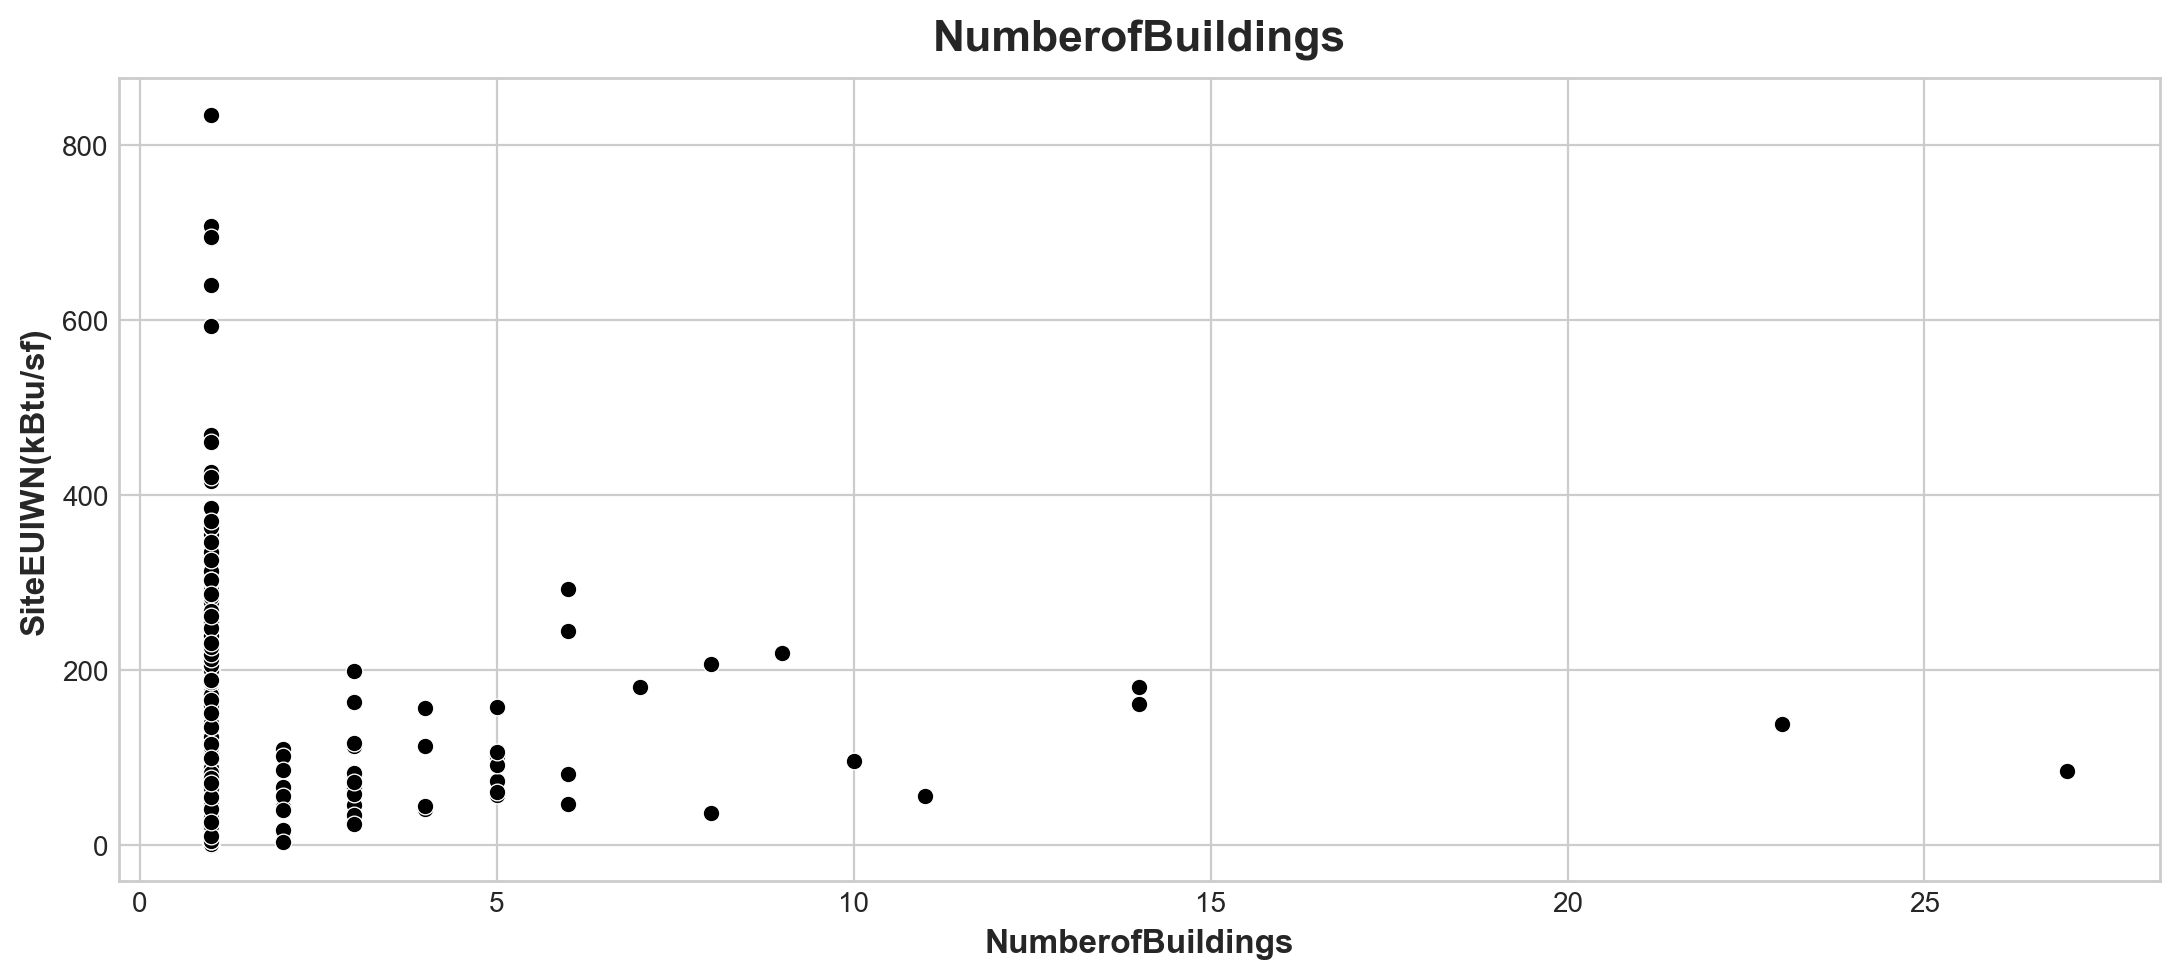

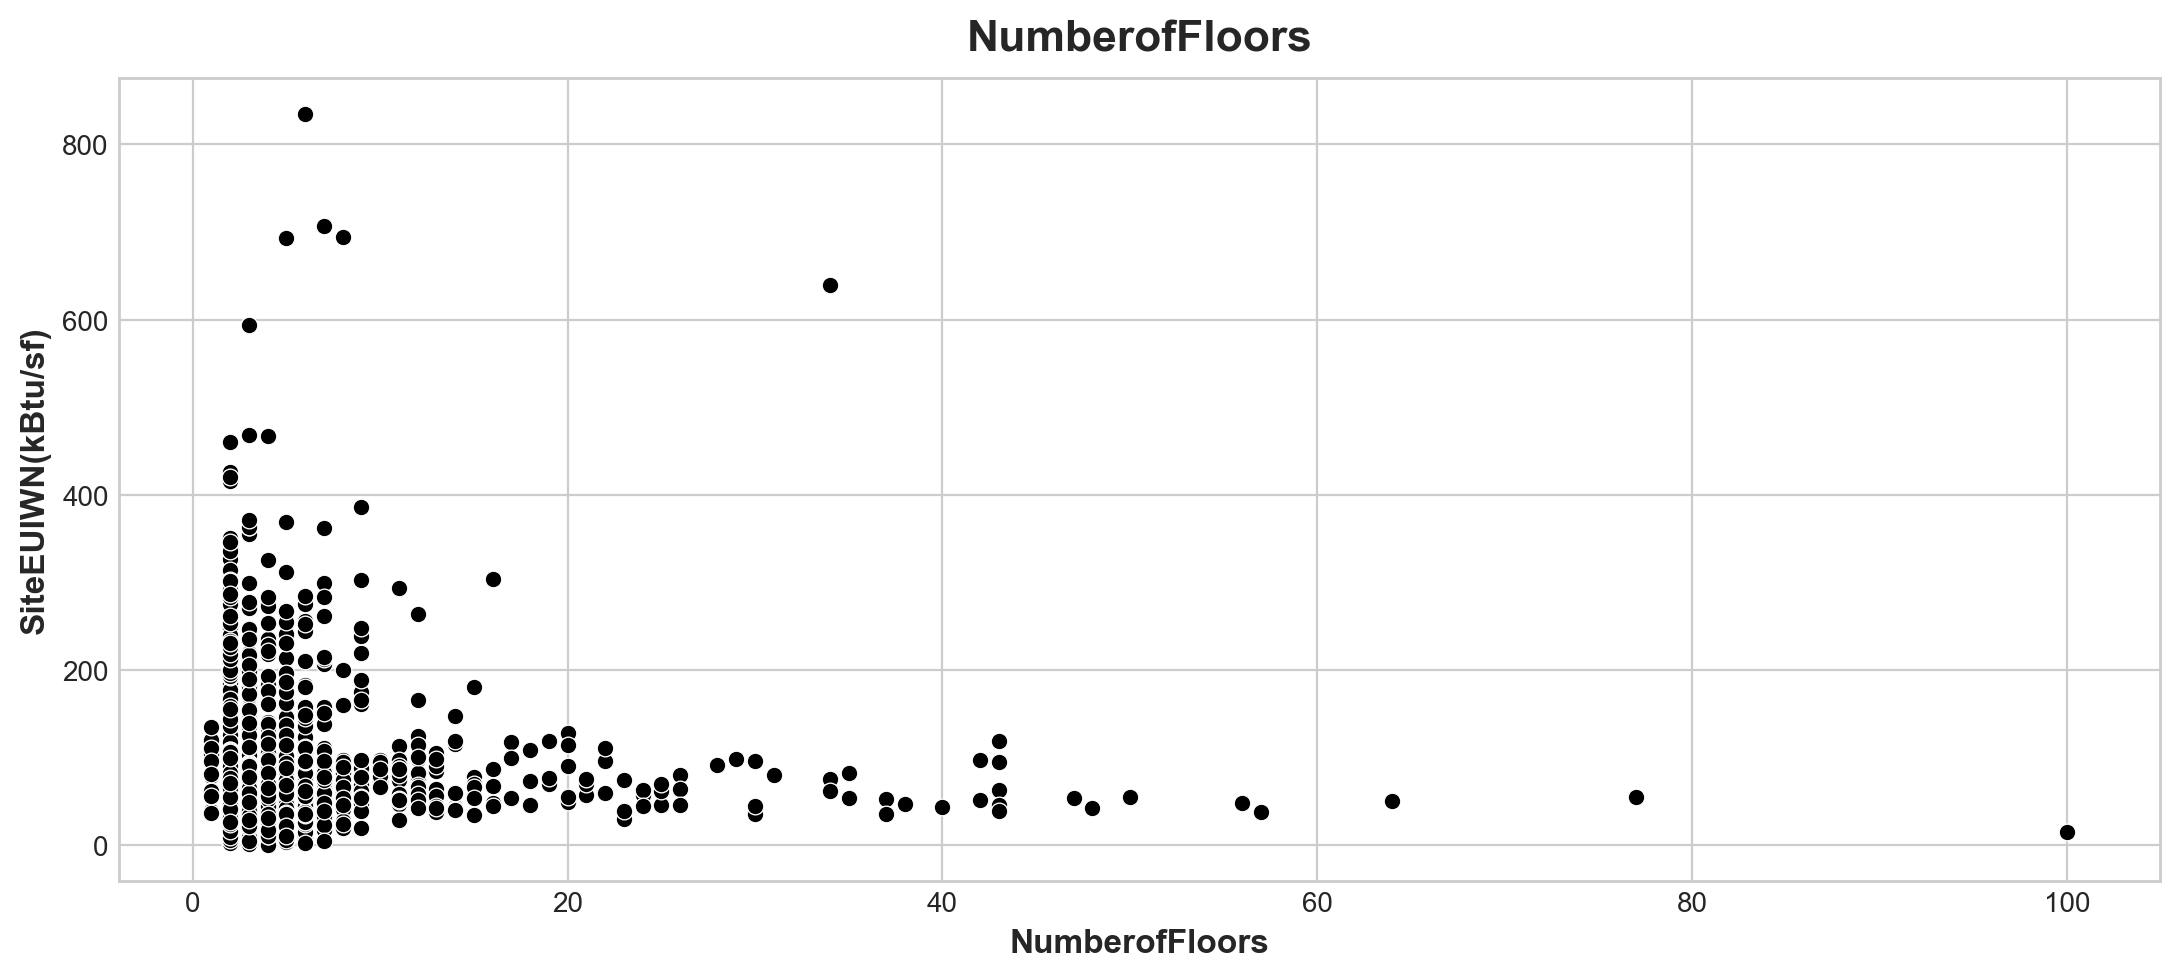

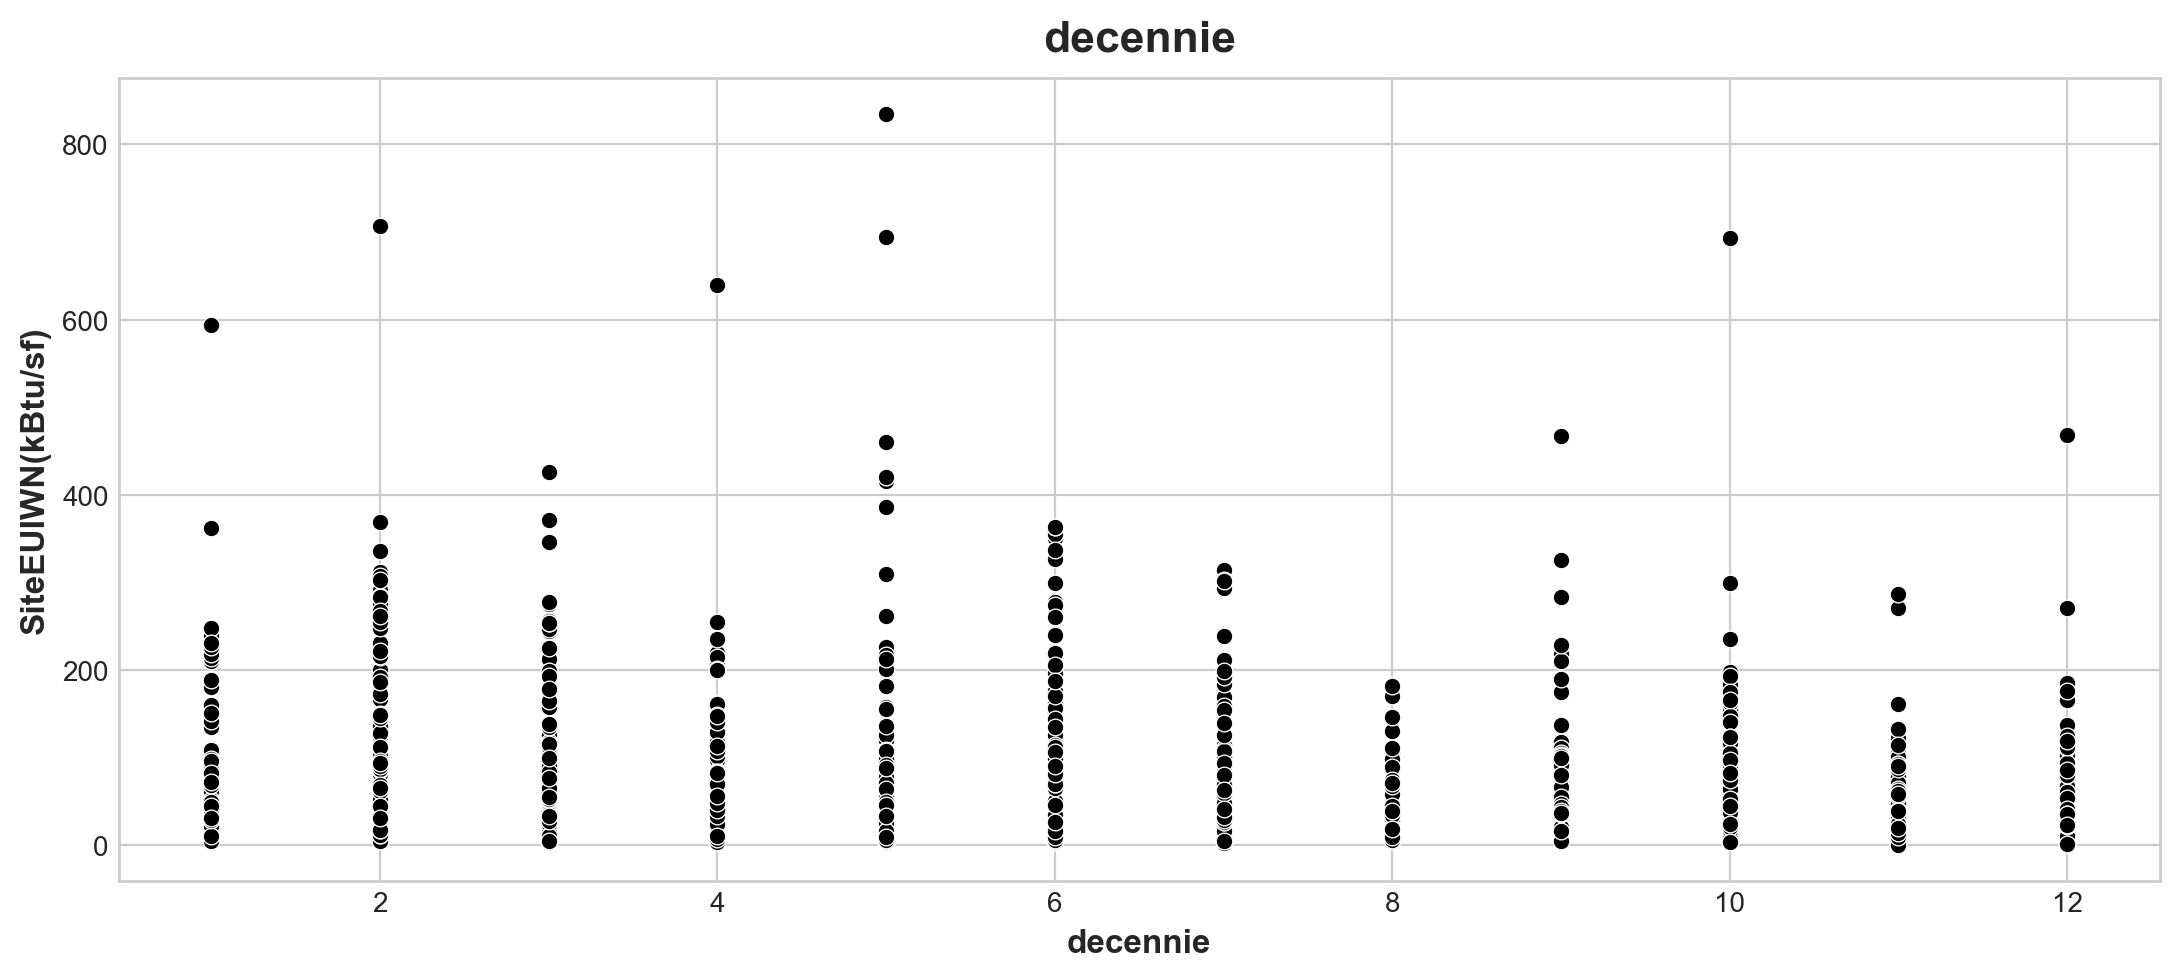

In [67]:
for col_categ in cols_categ :
    scatter_test(col_categ,'SiteEUIWN(kBtu/sf)')

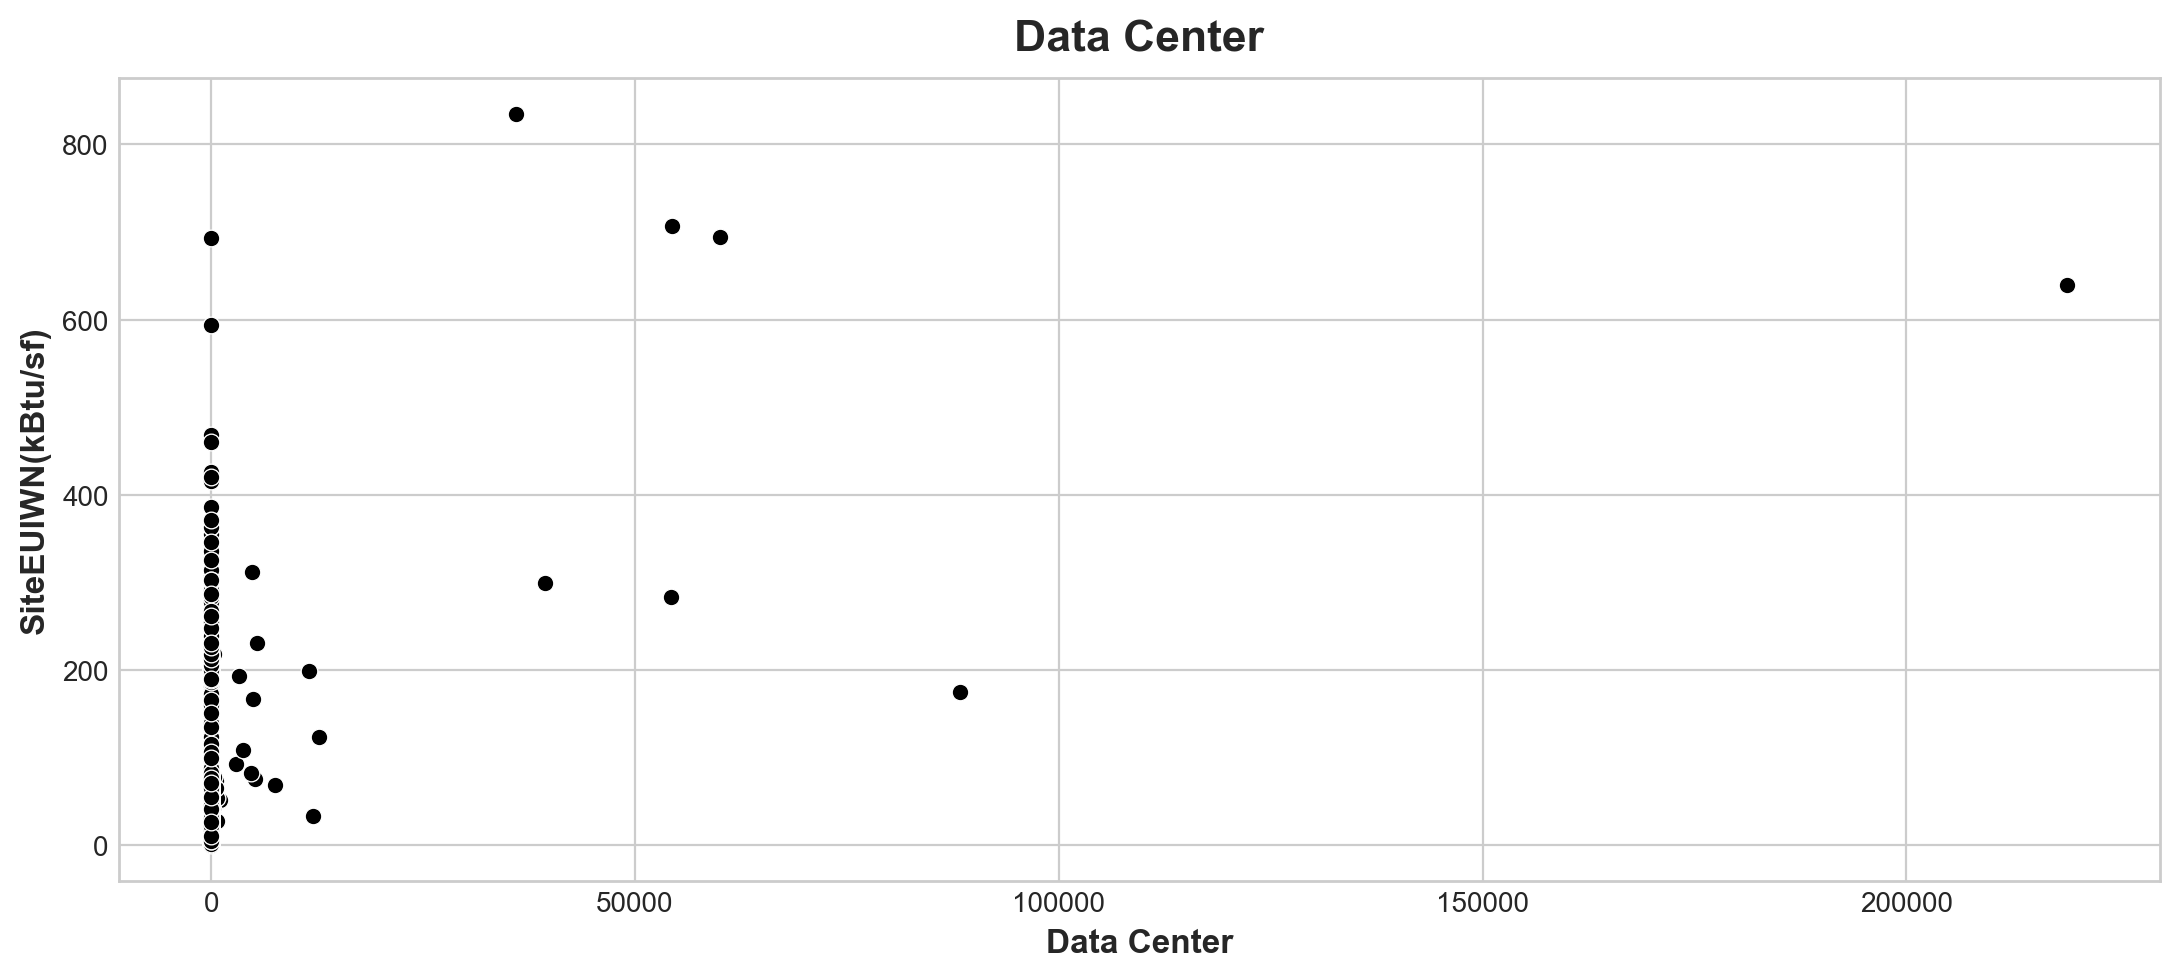

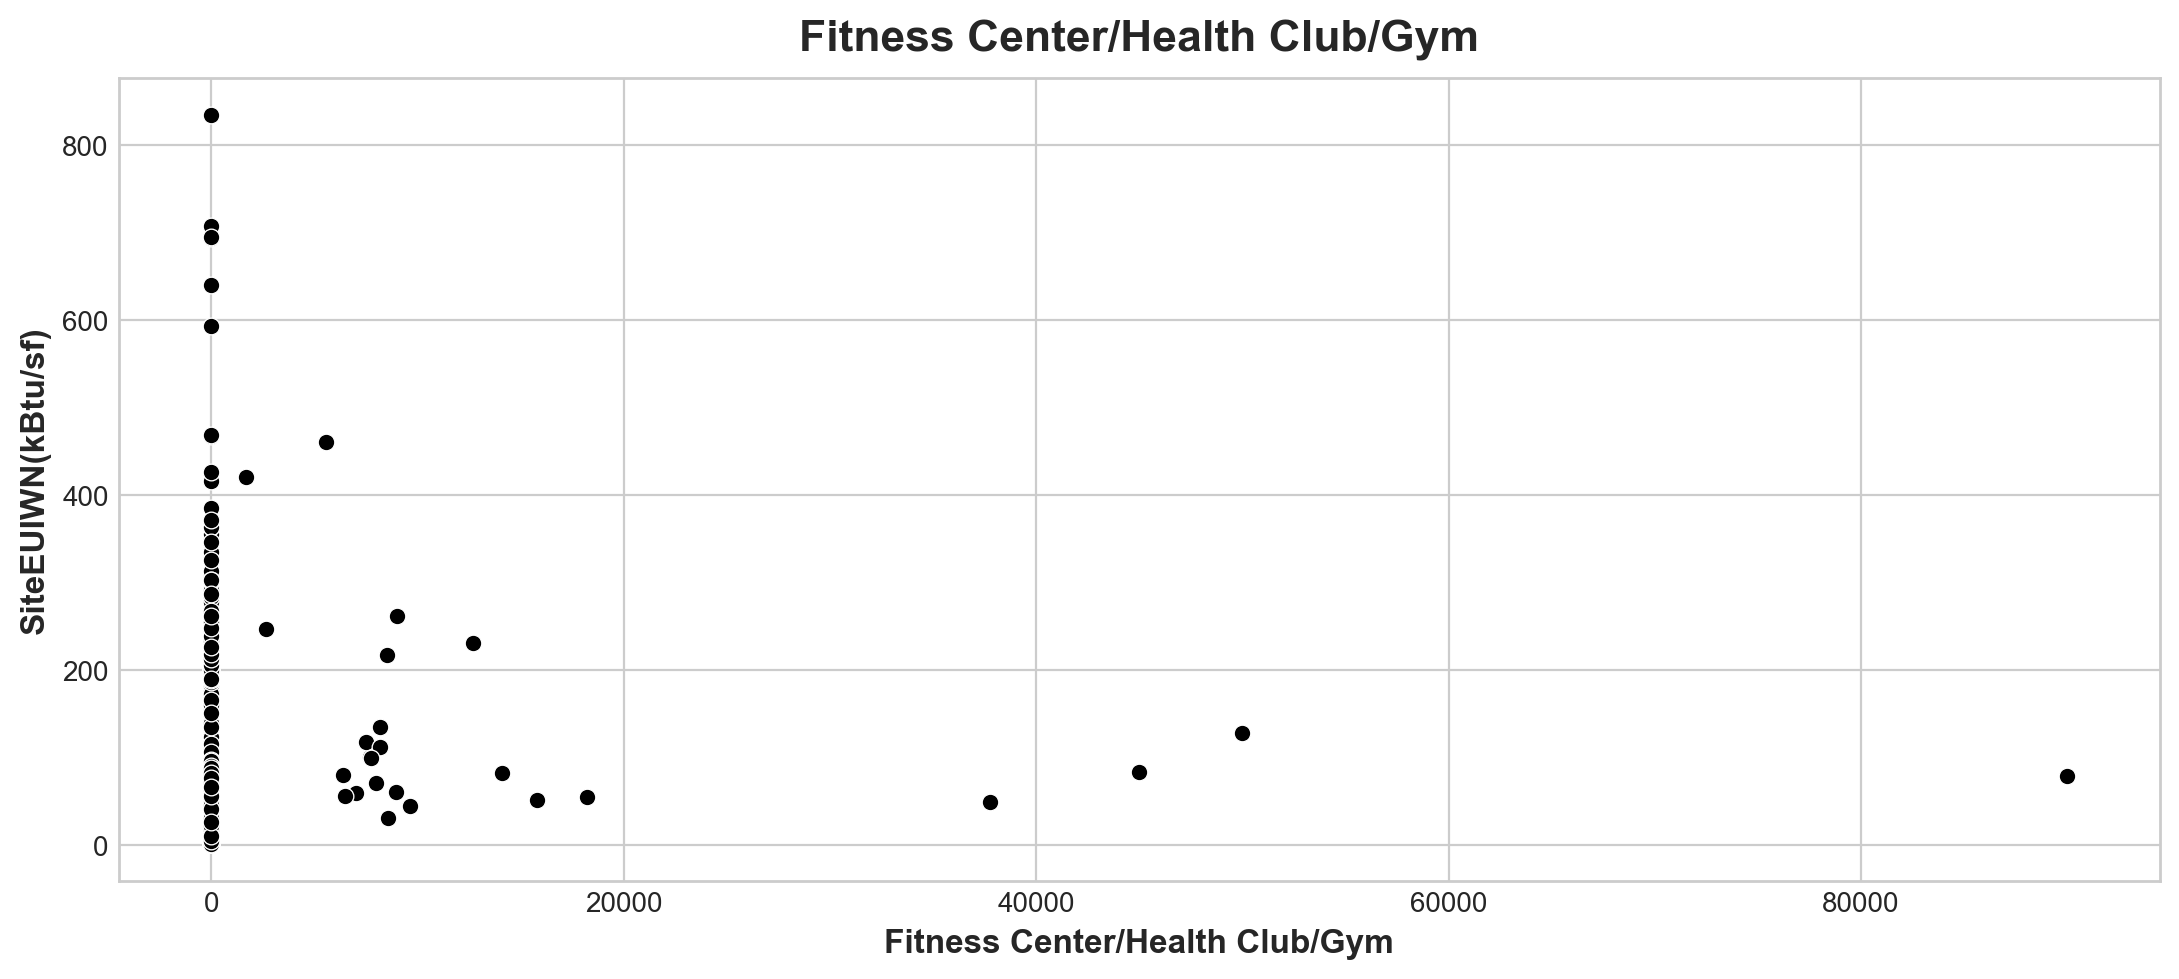

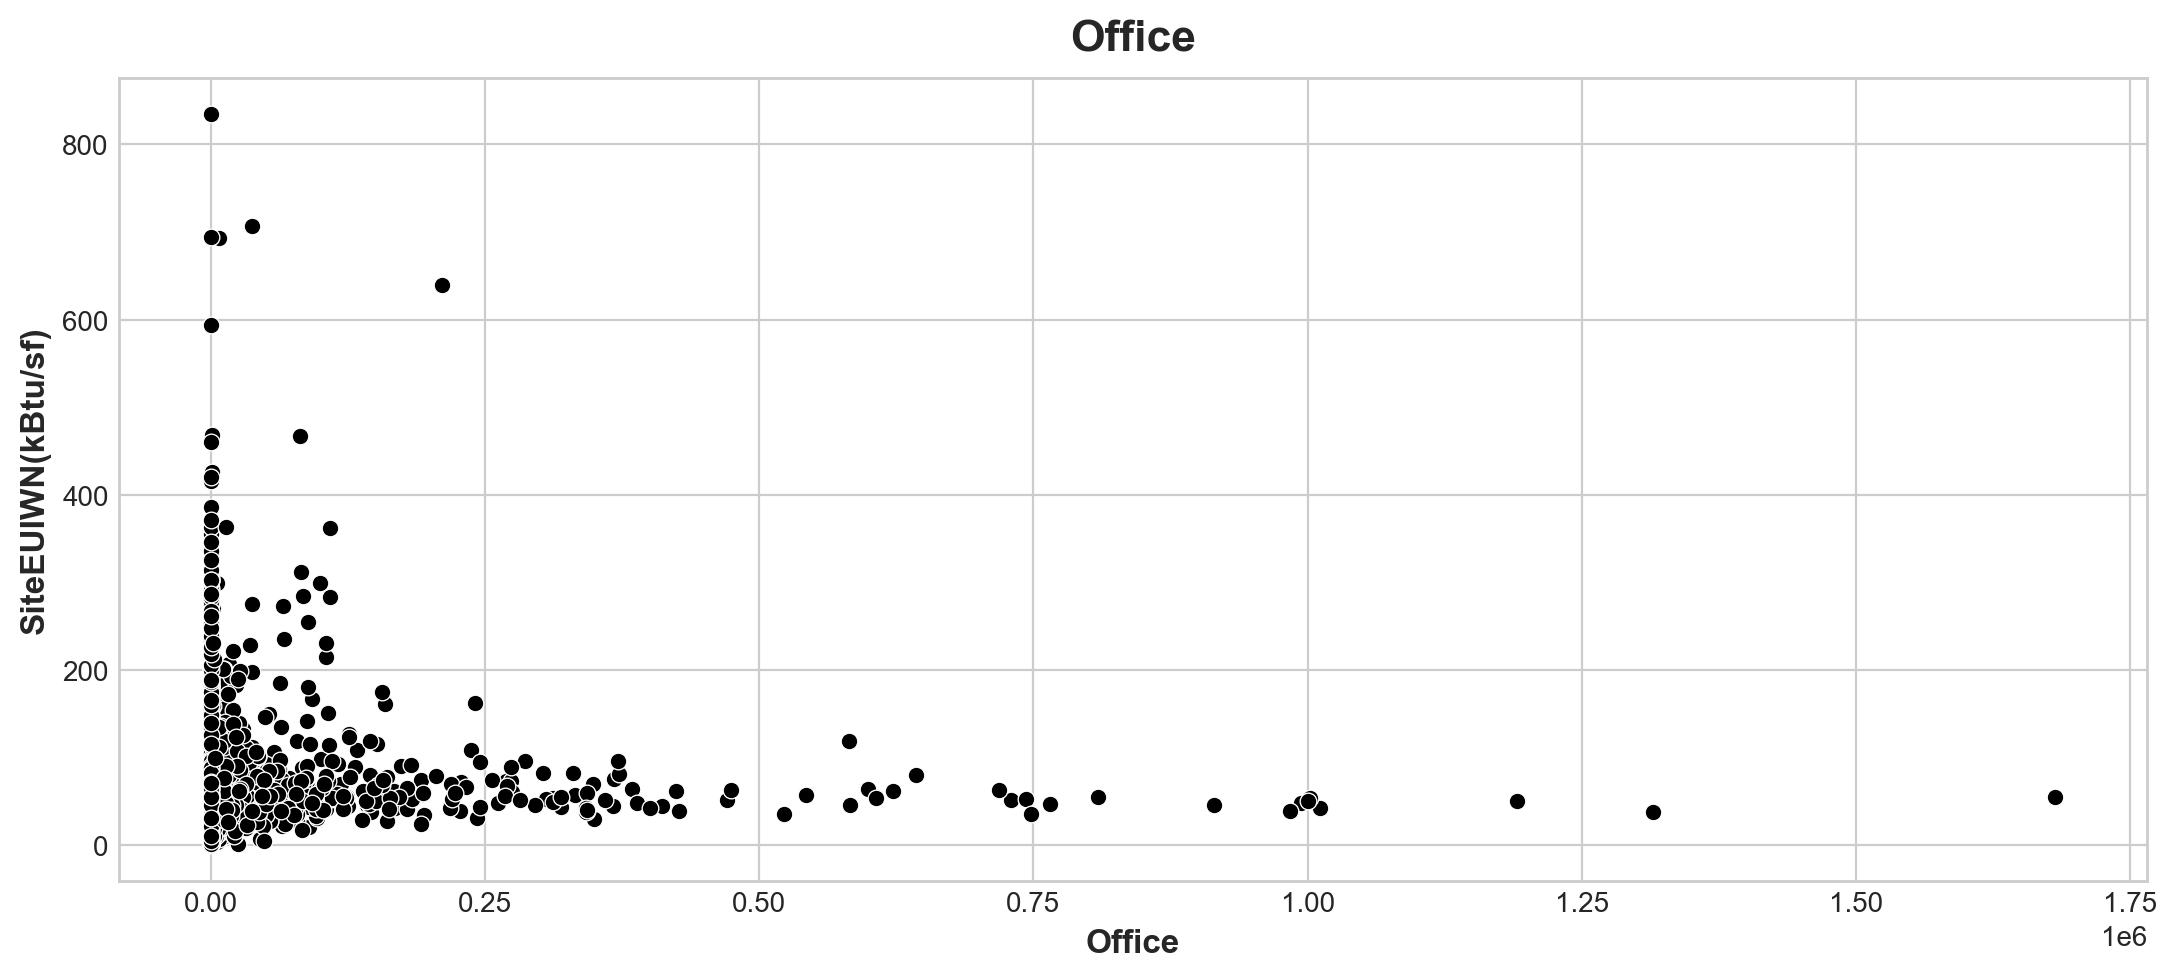

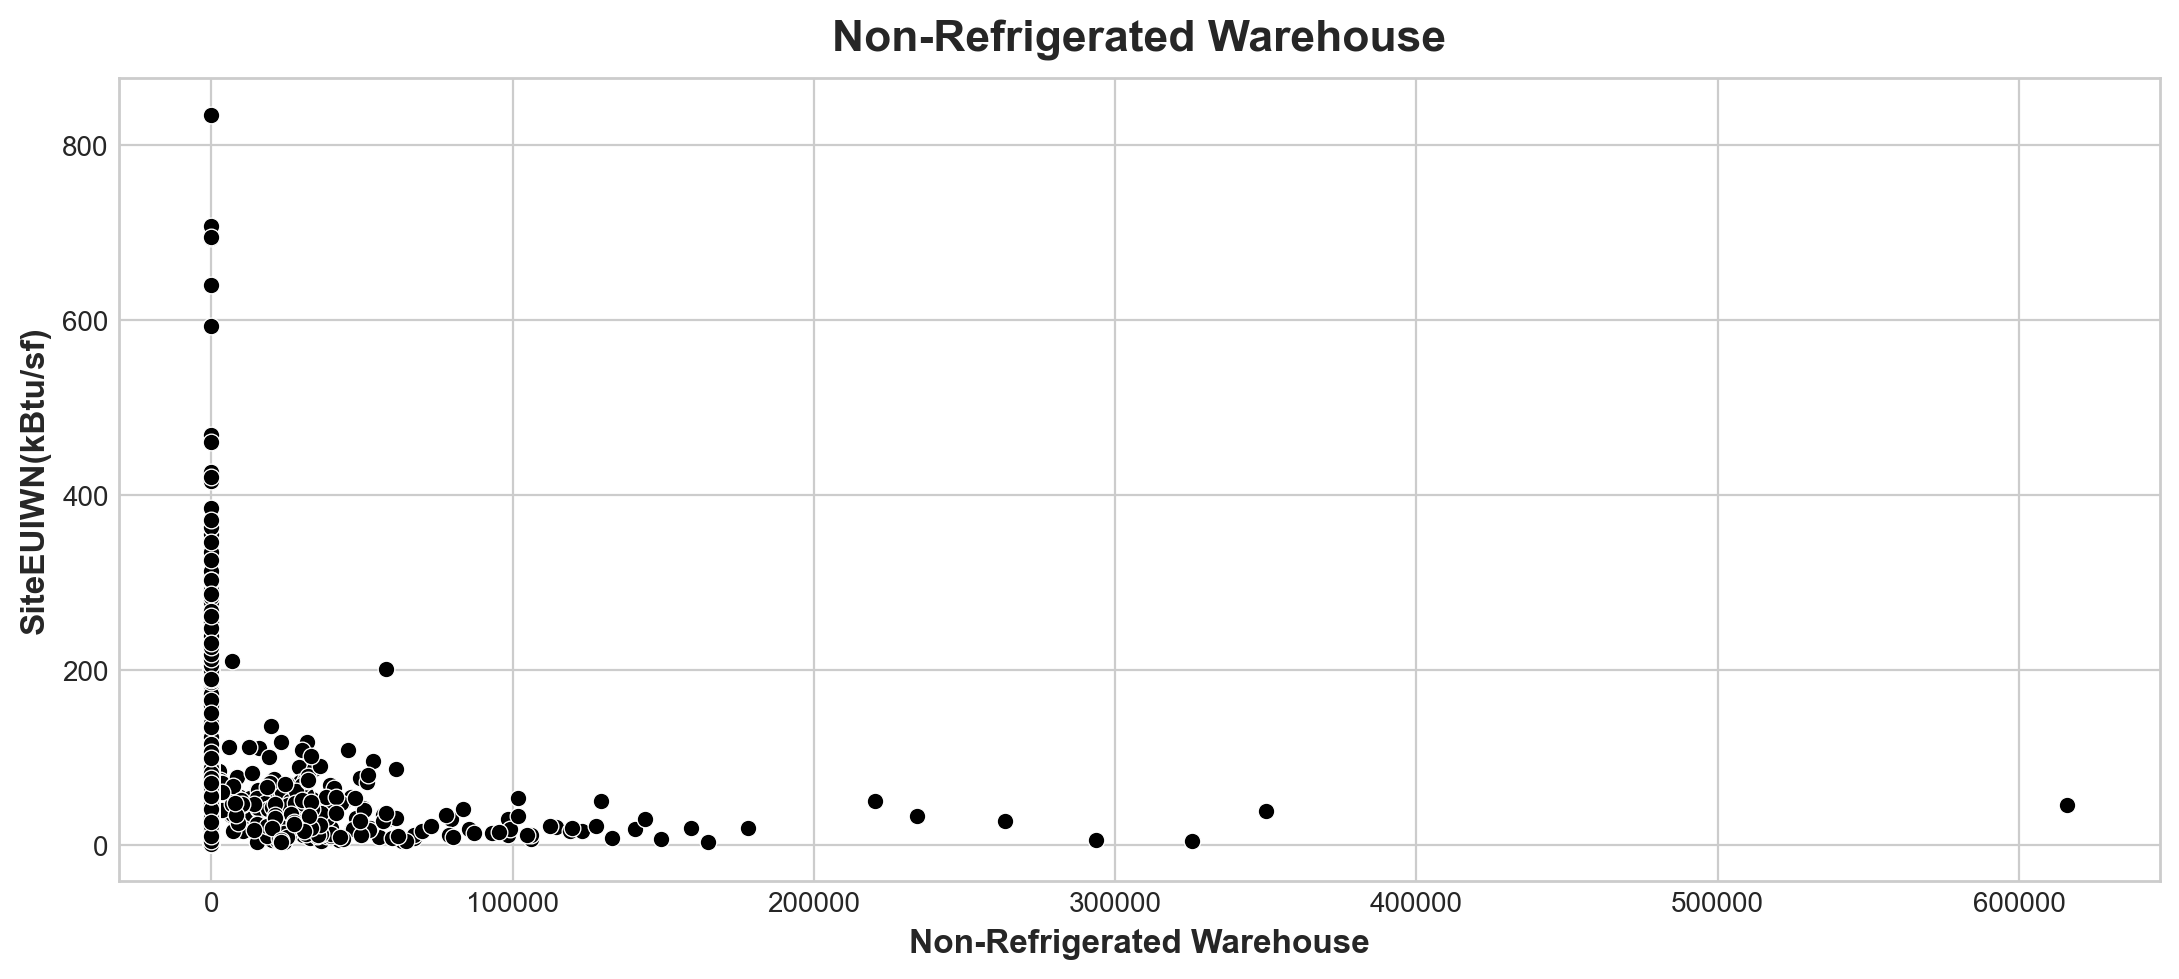

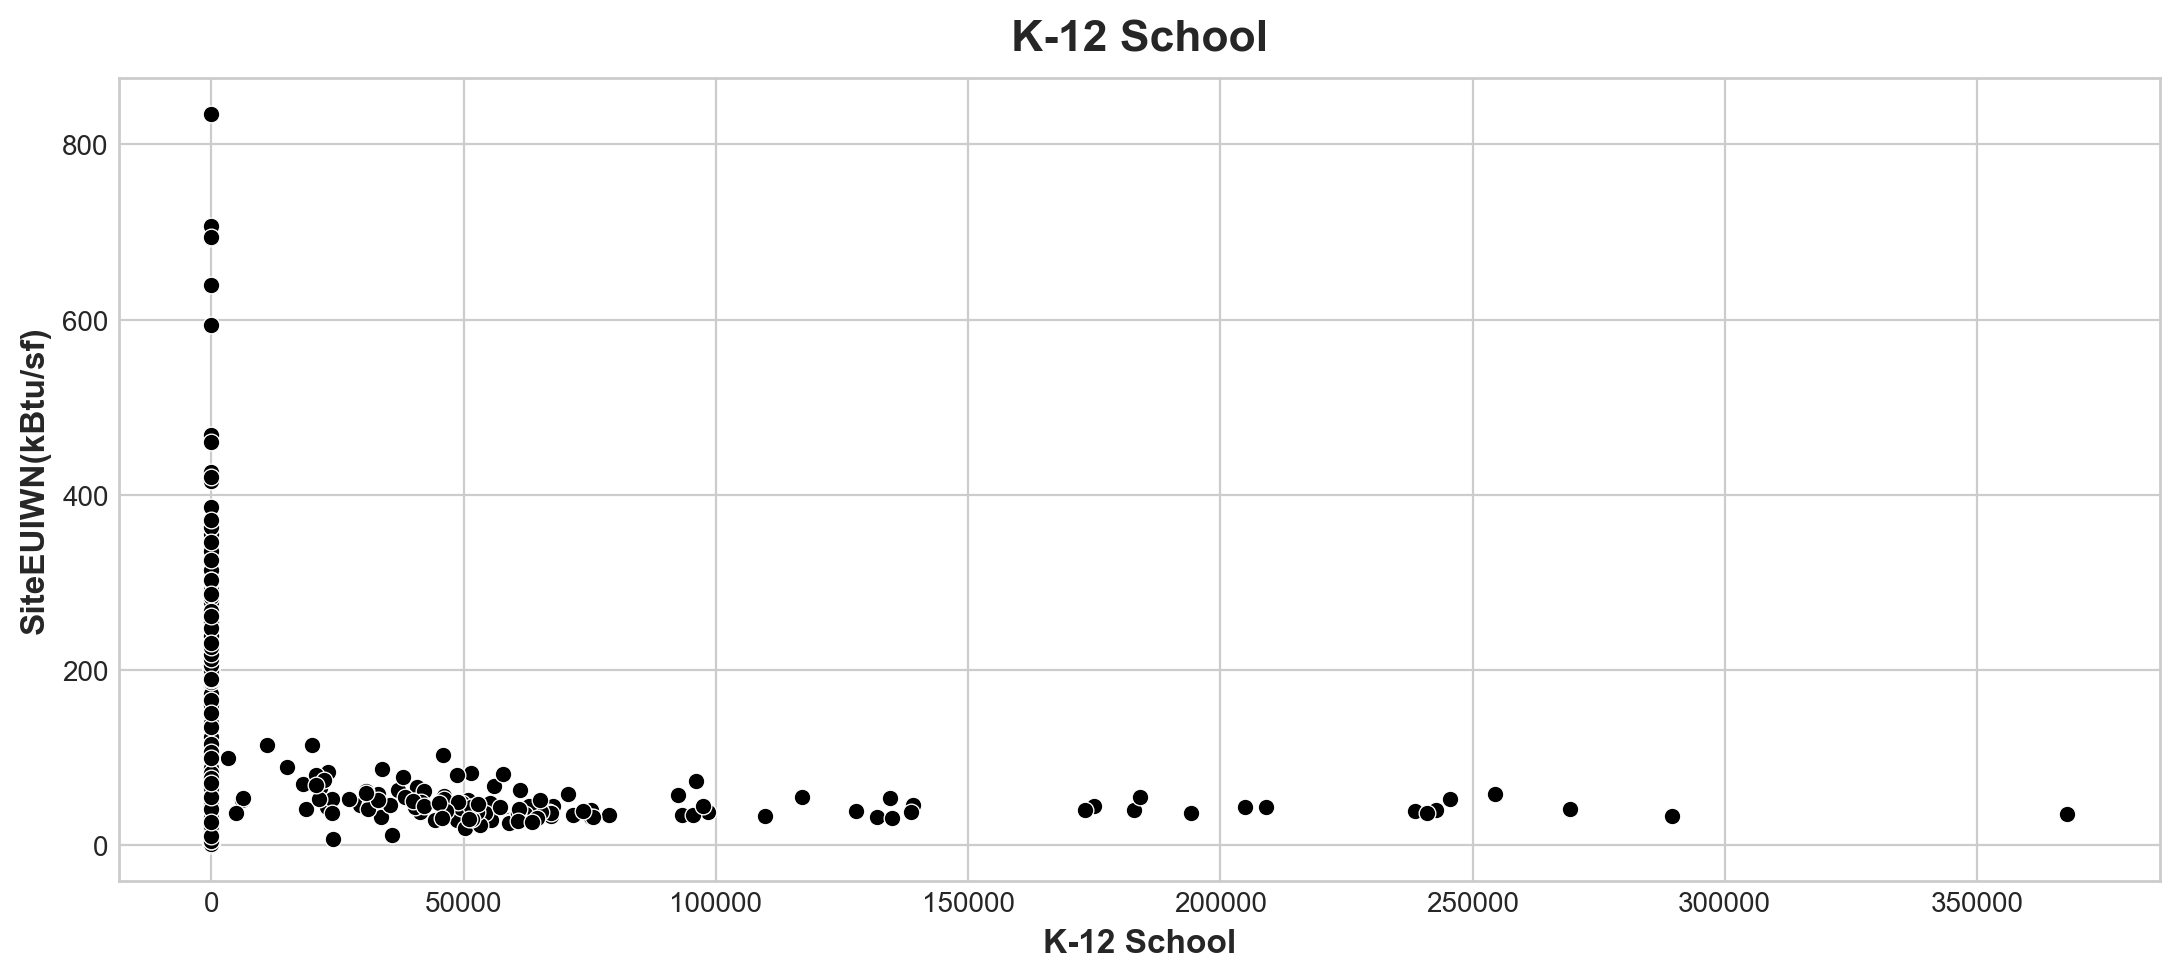

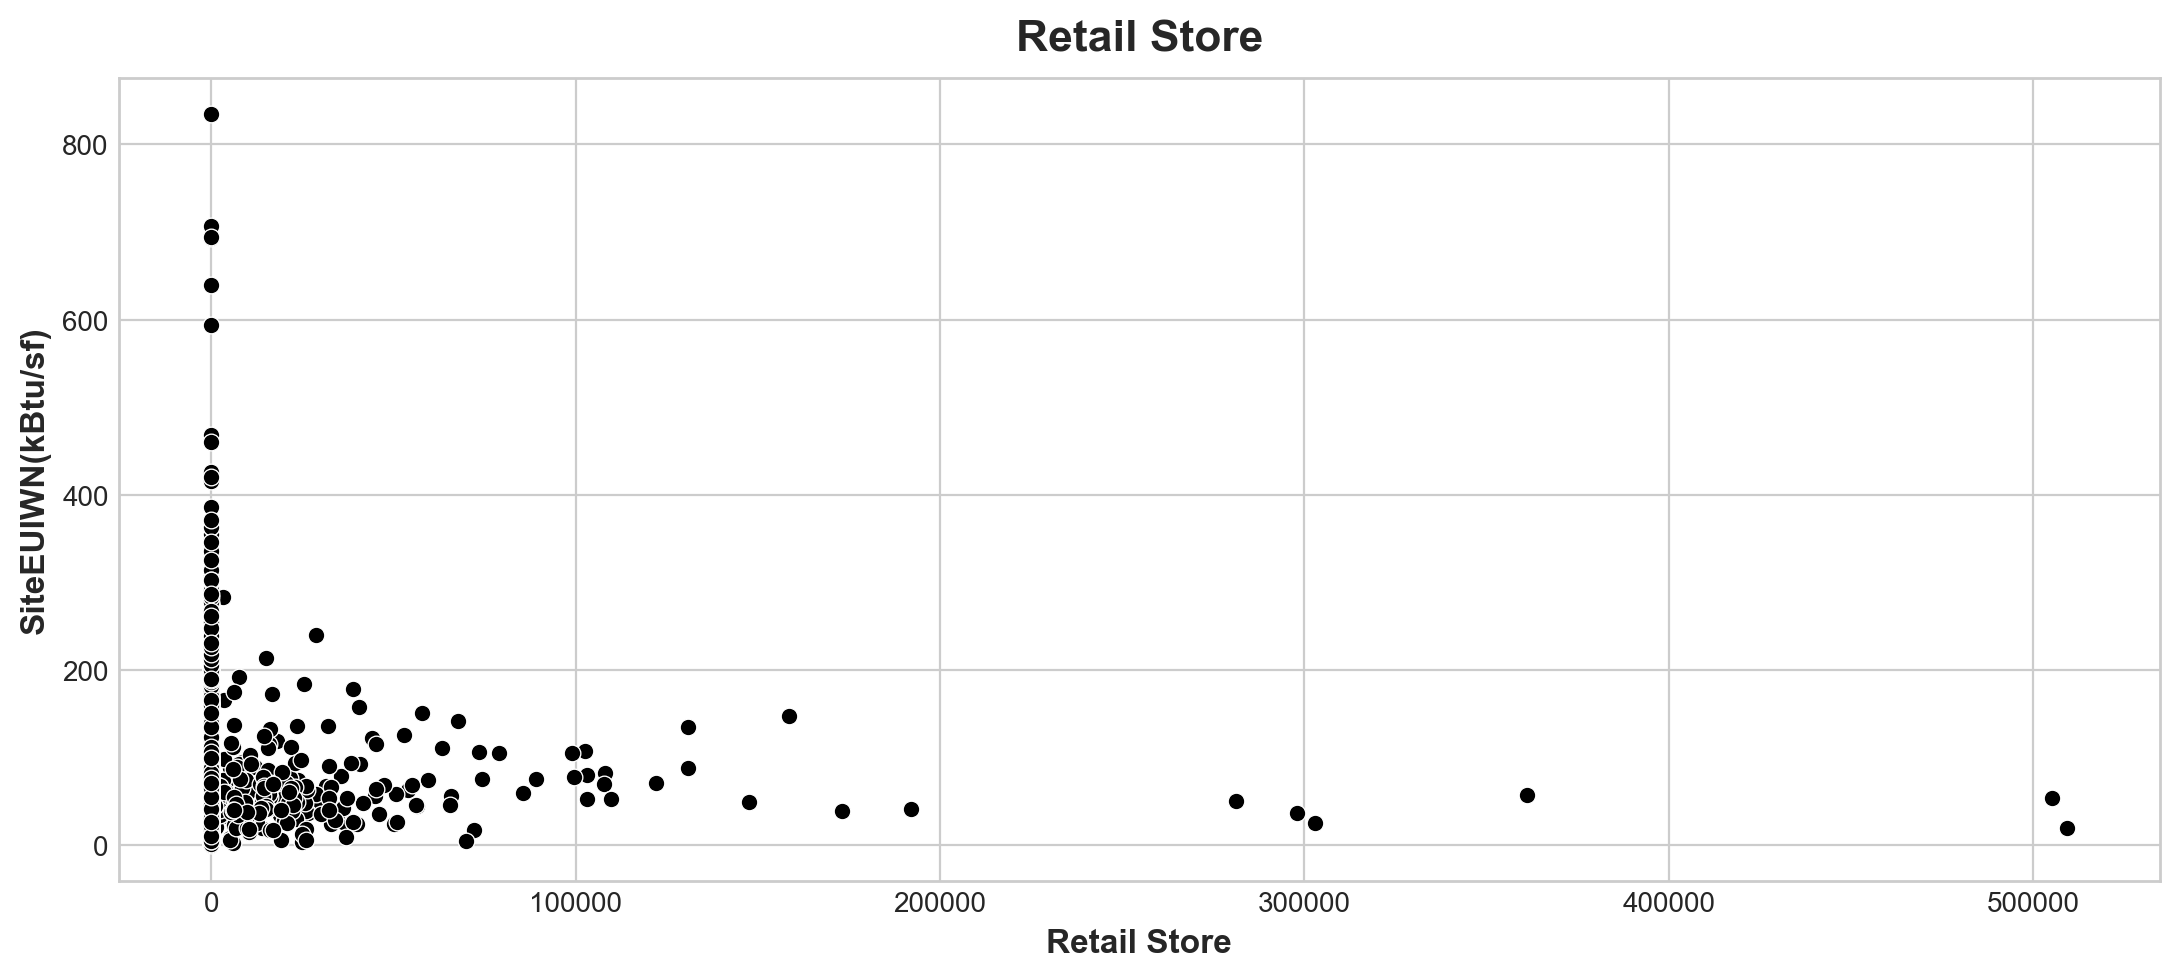

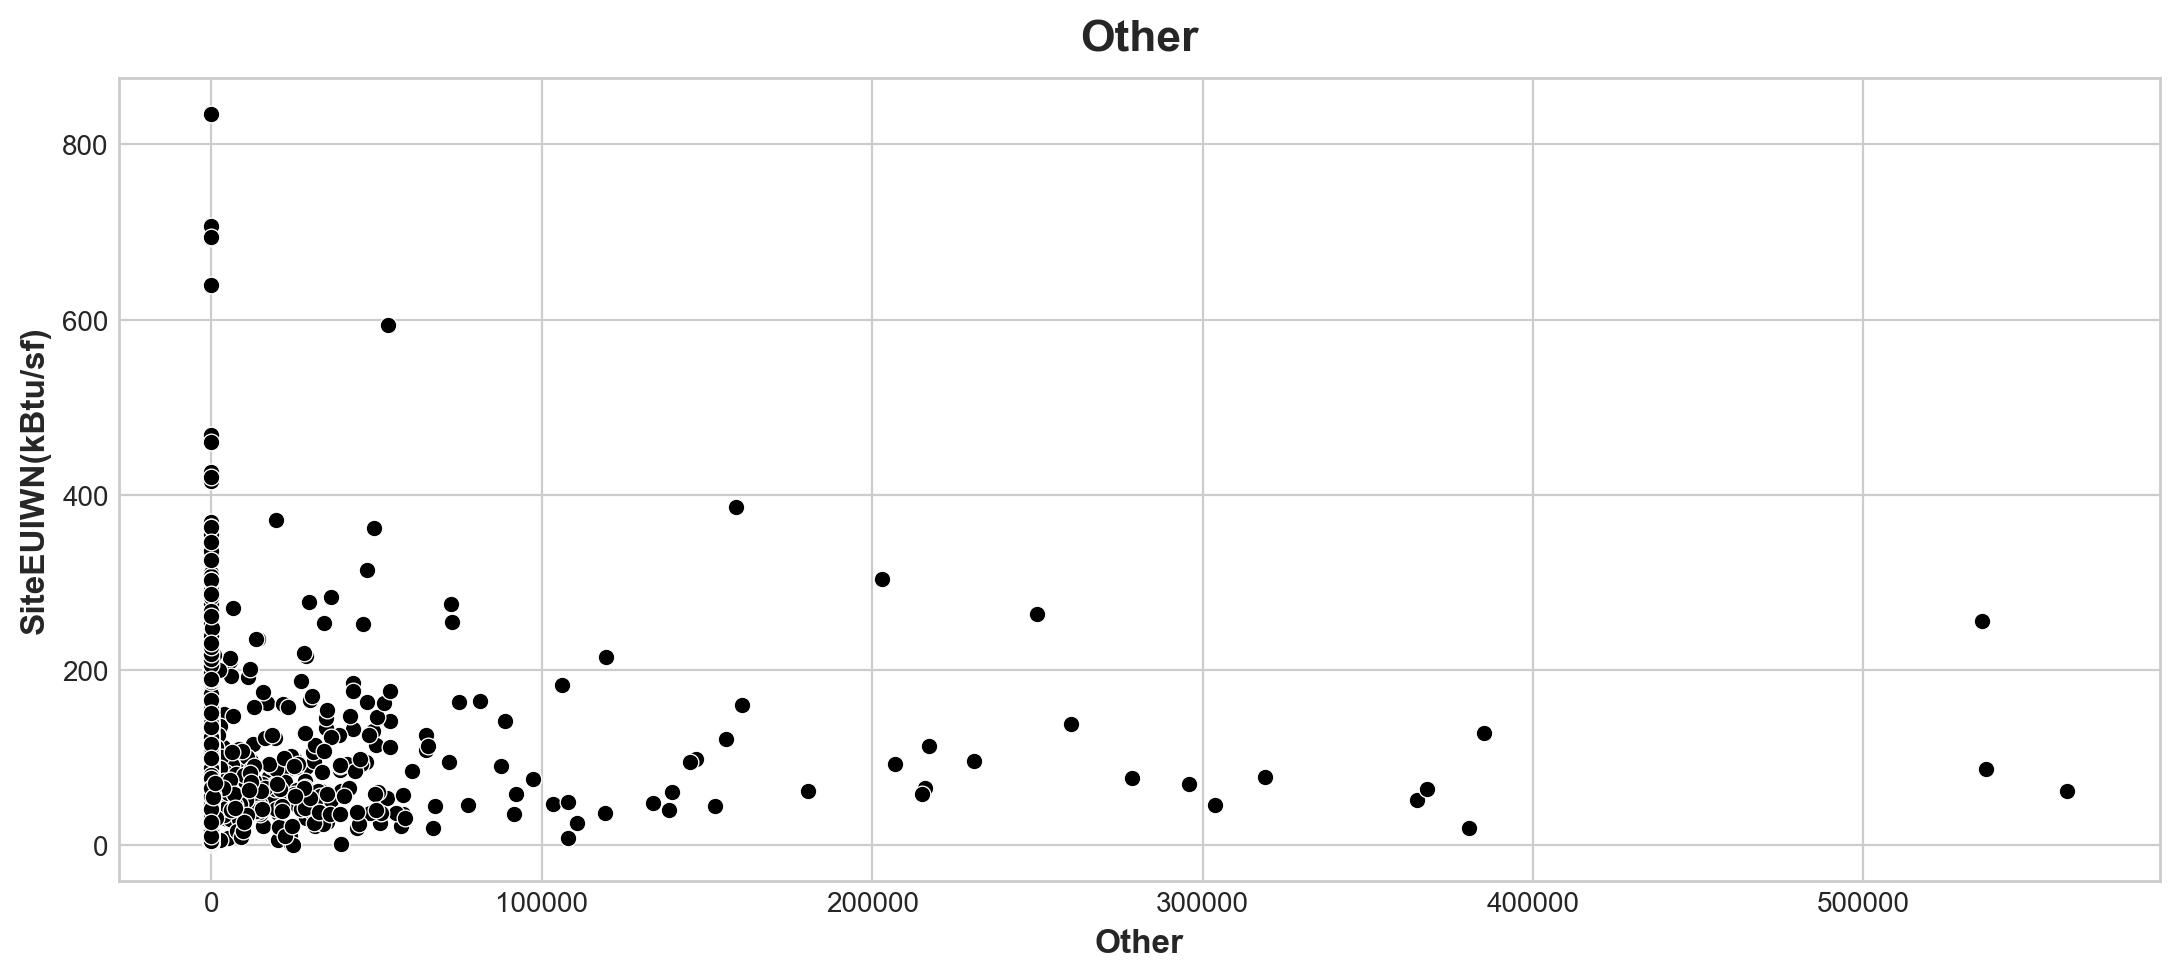

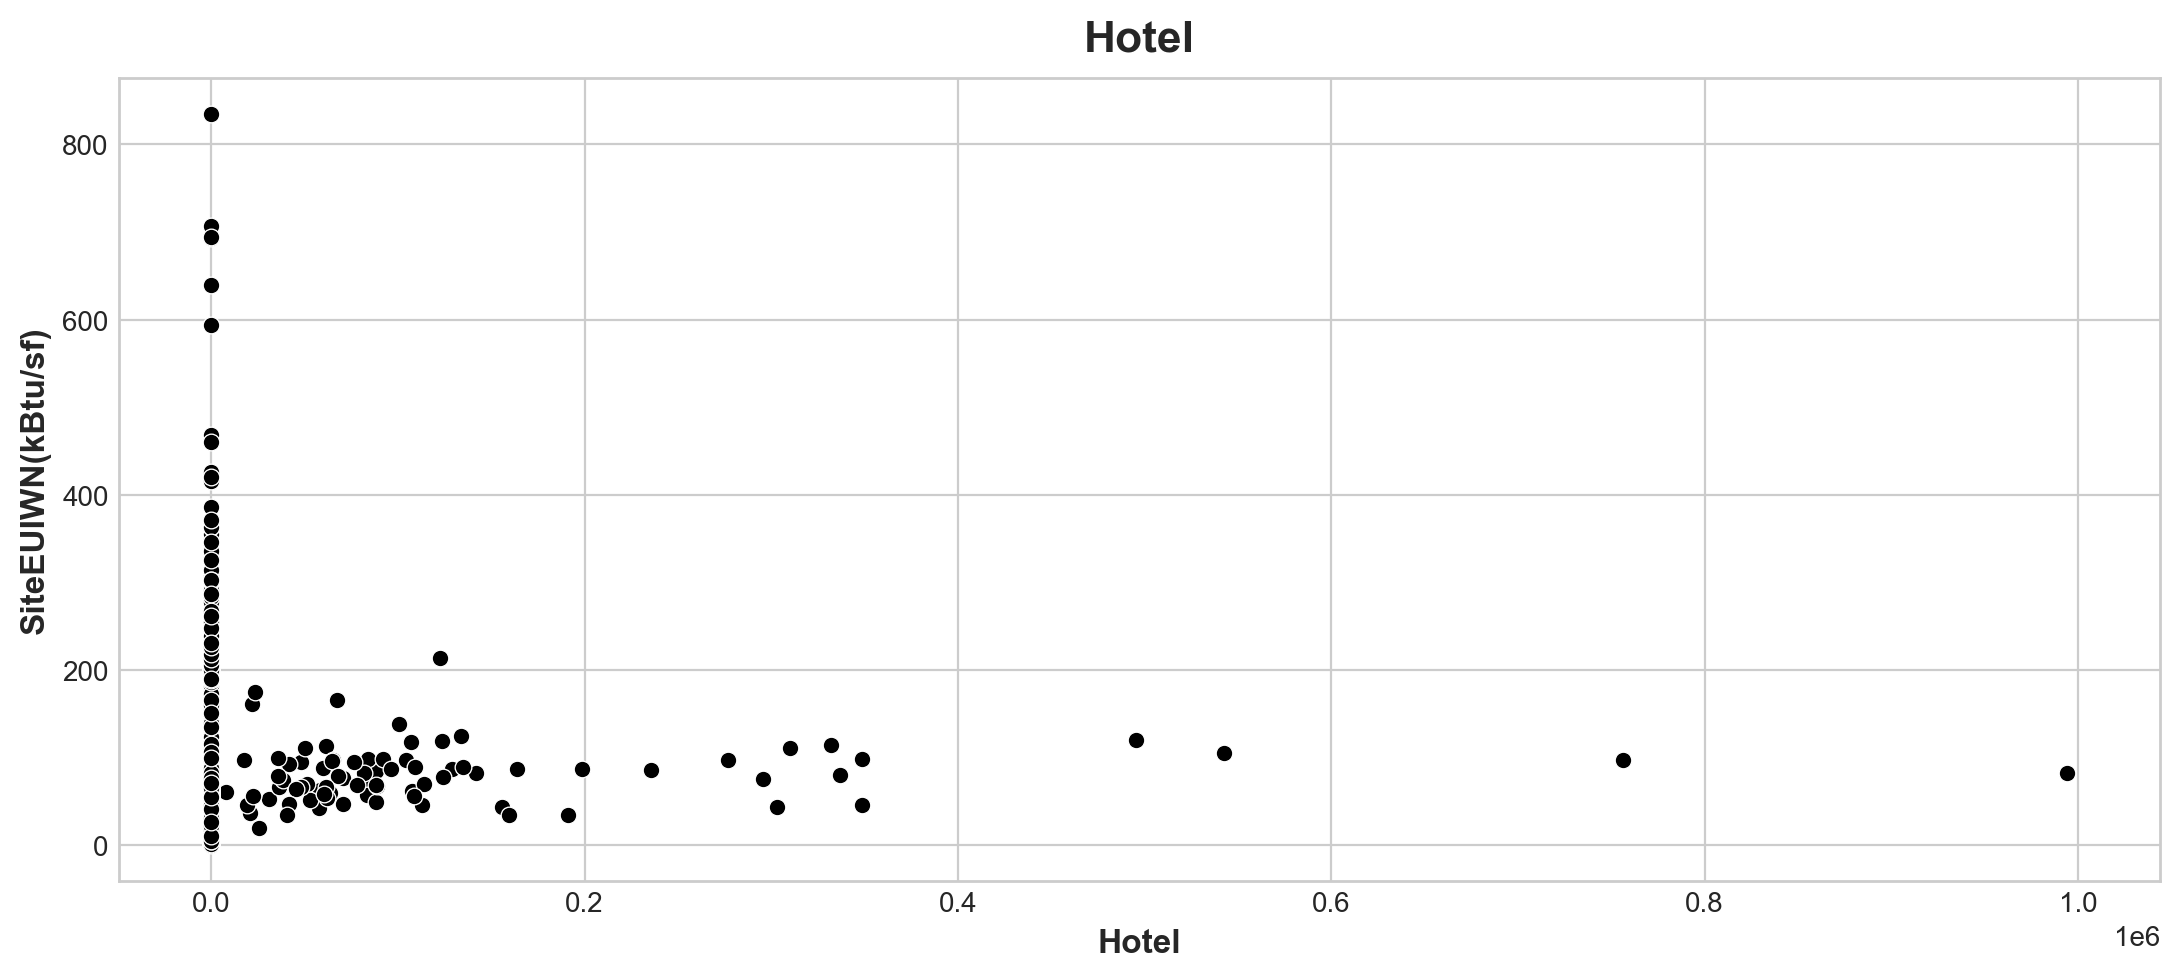

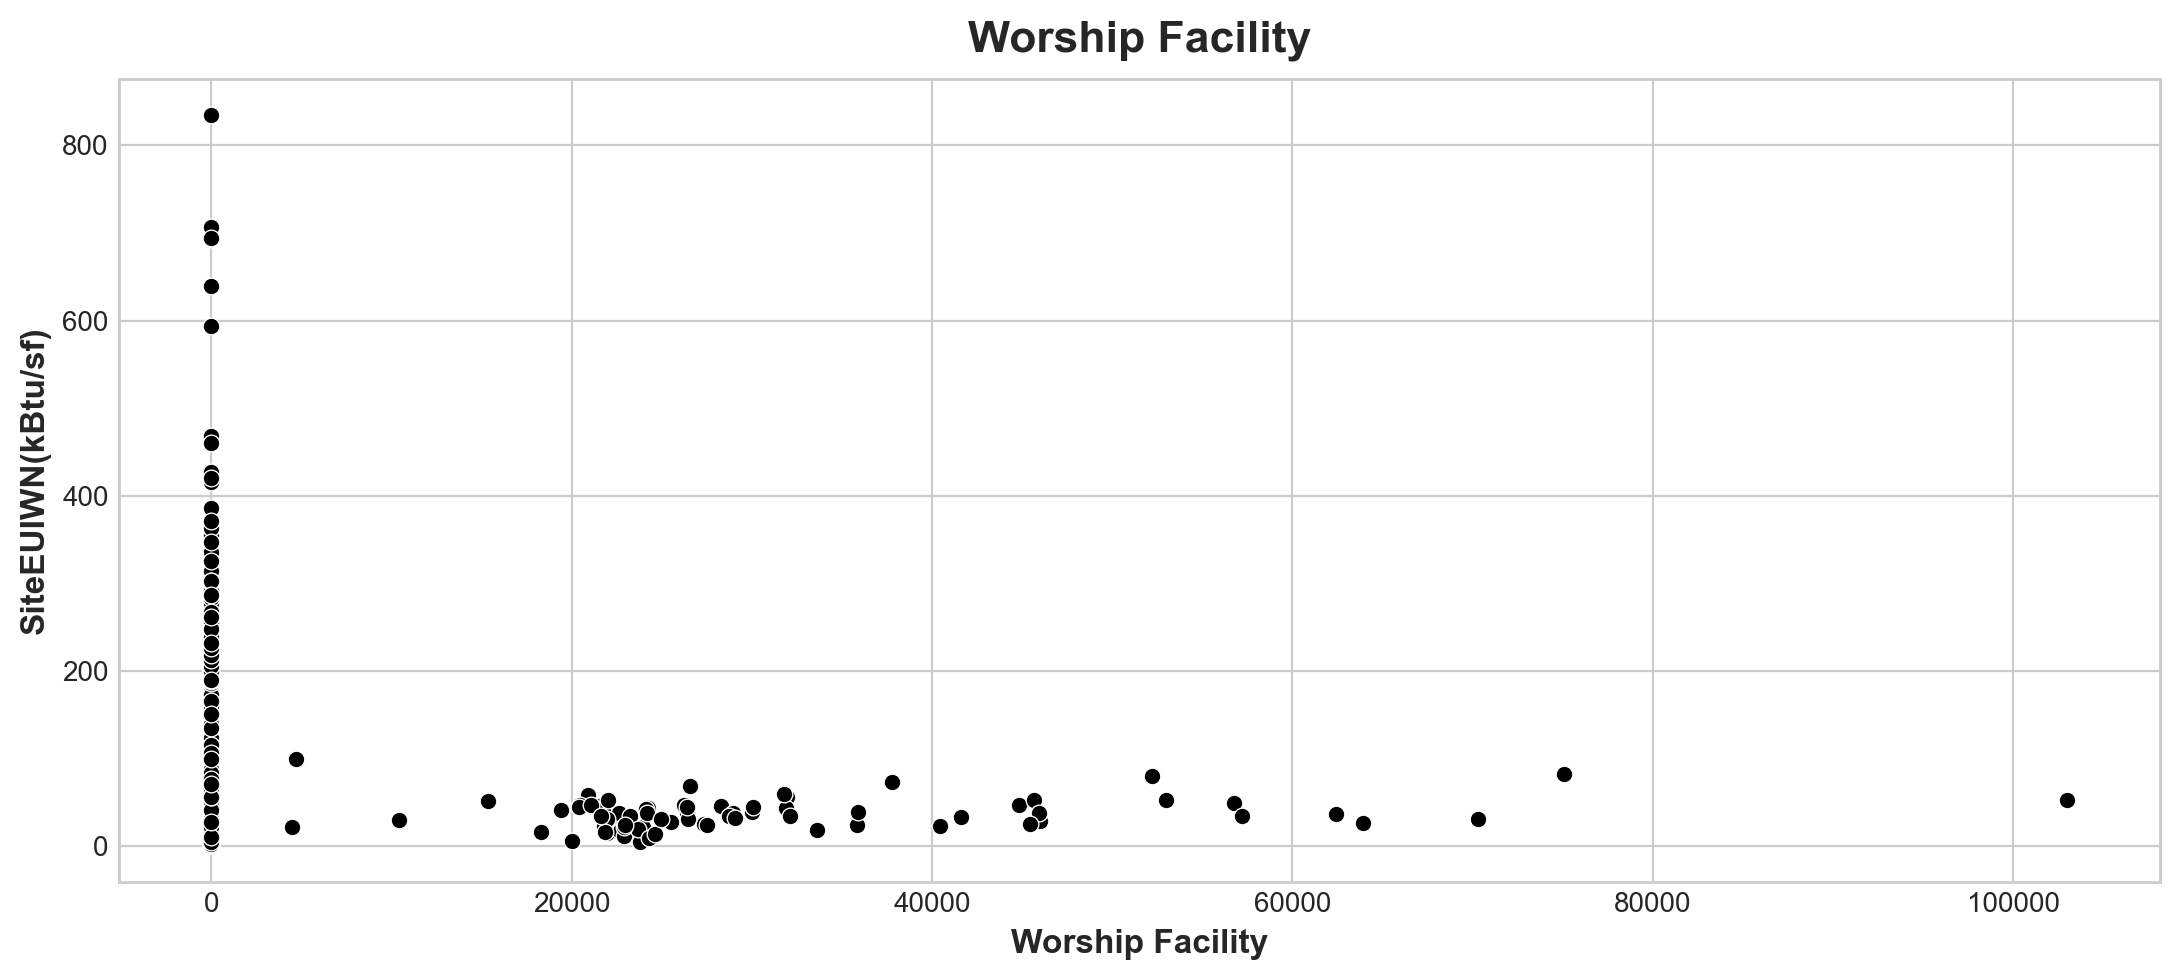

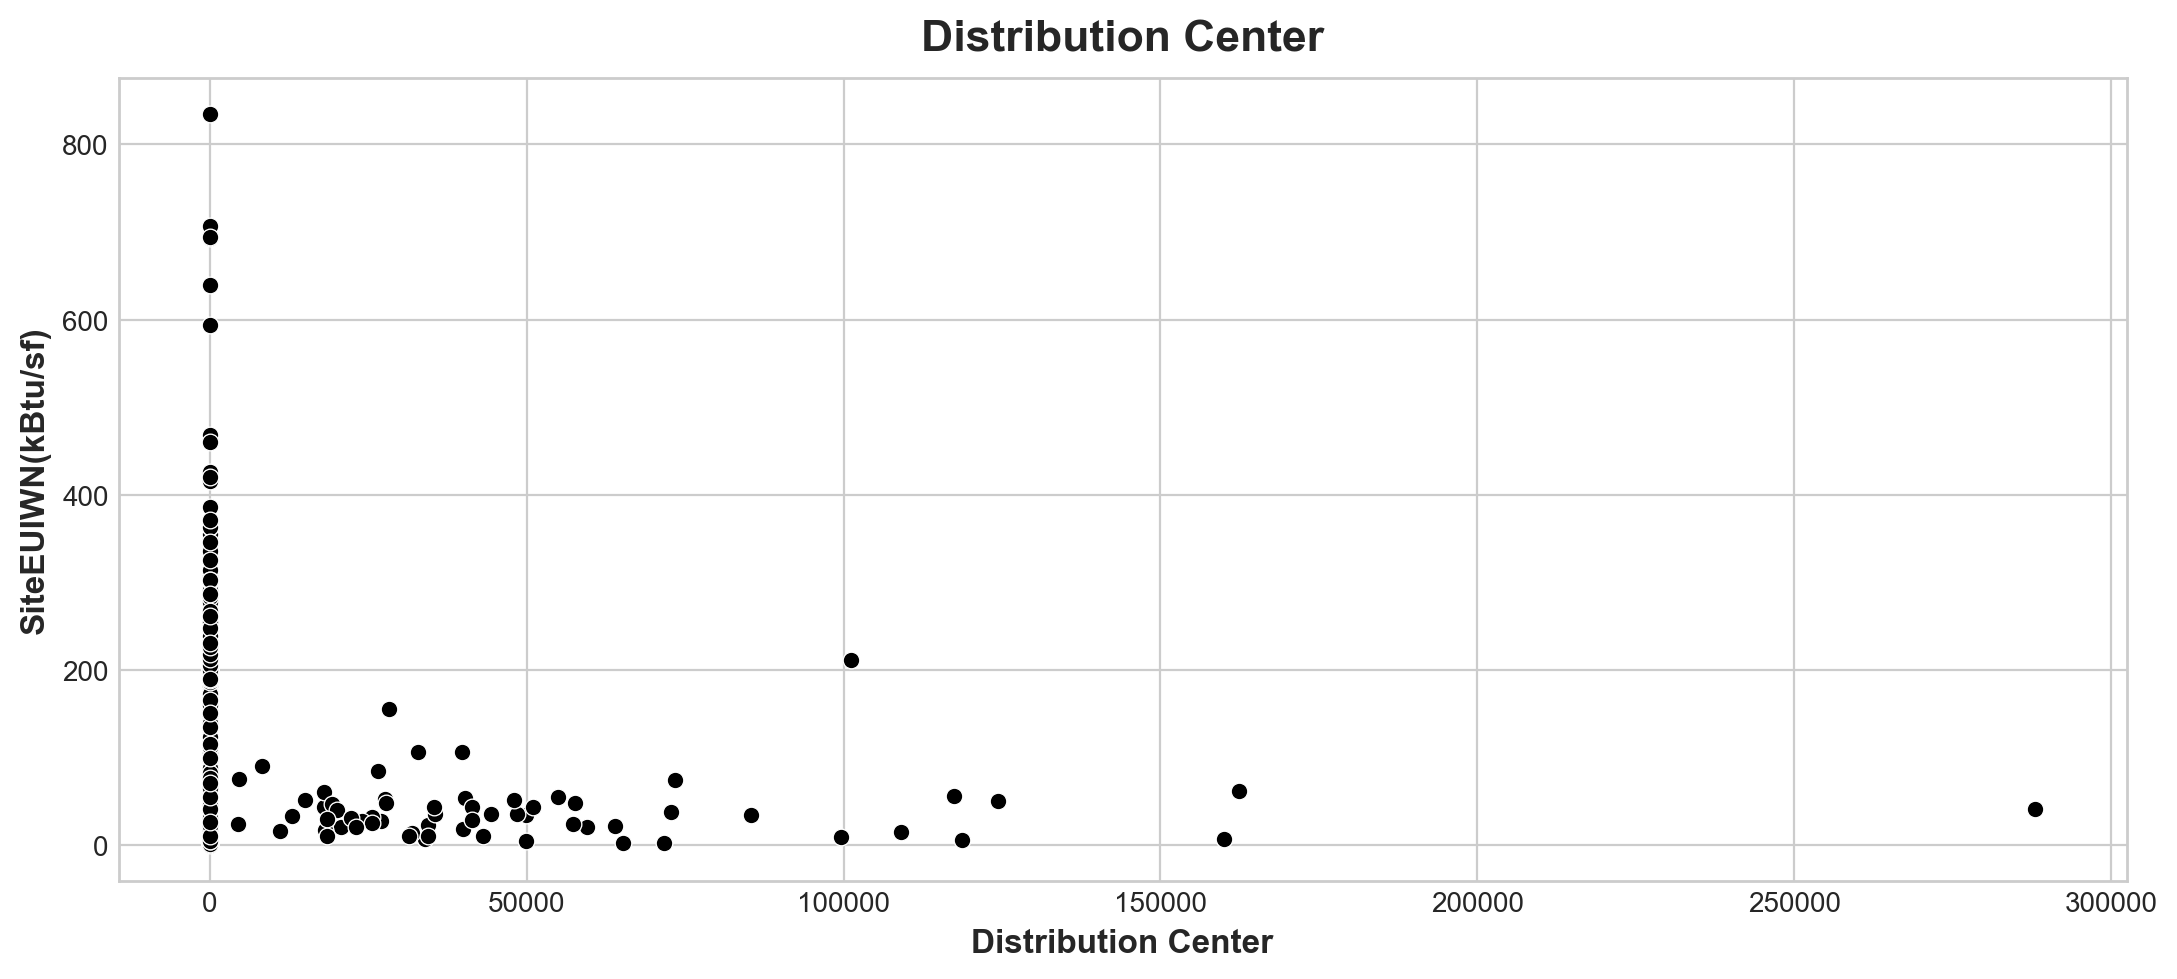

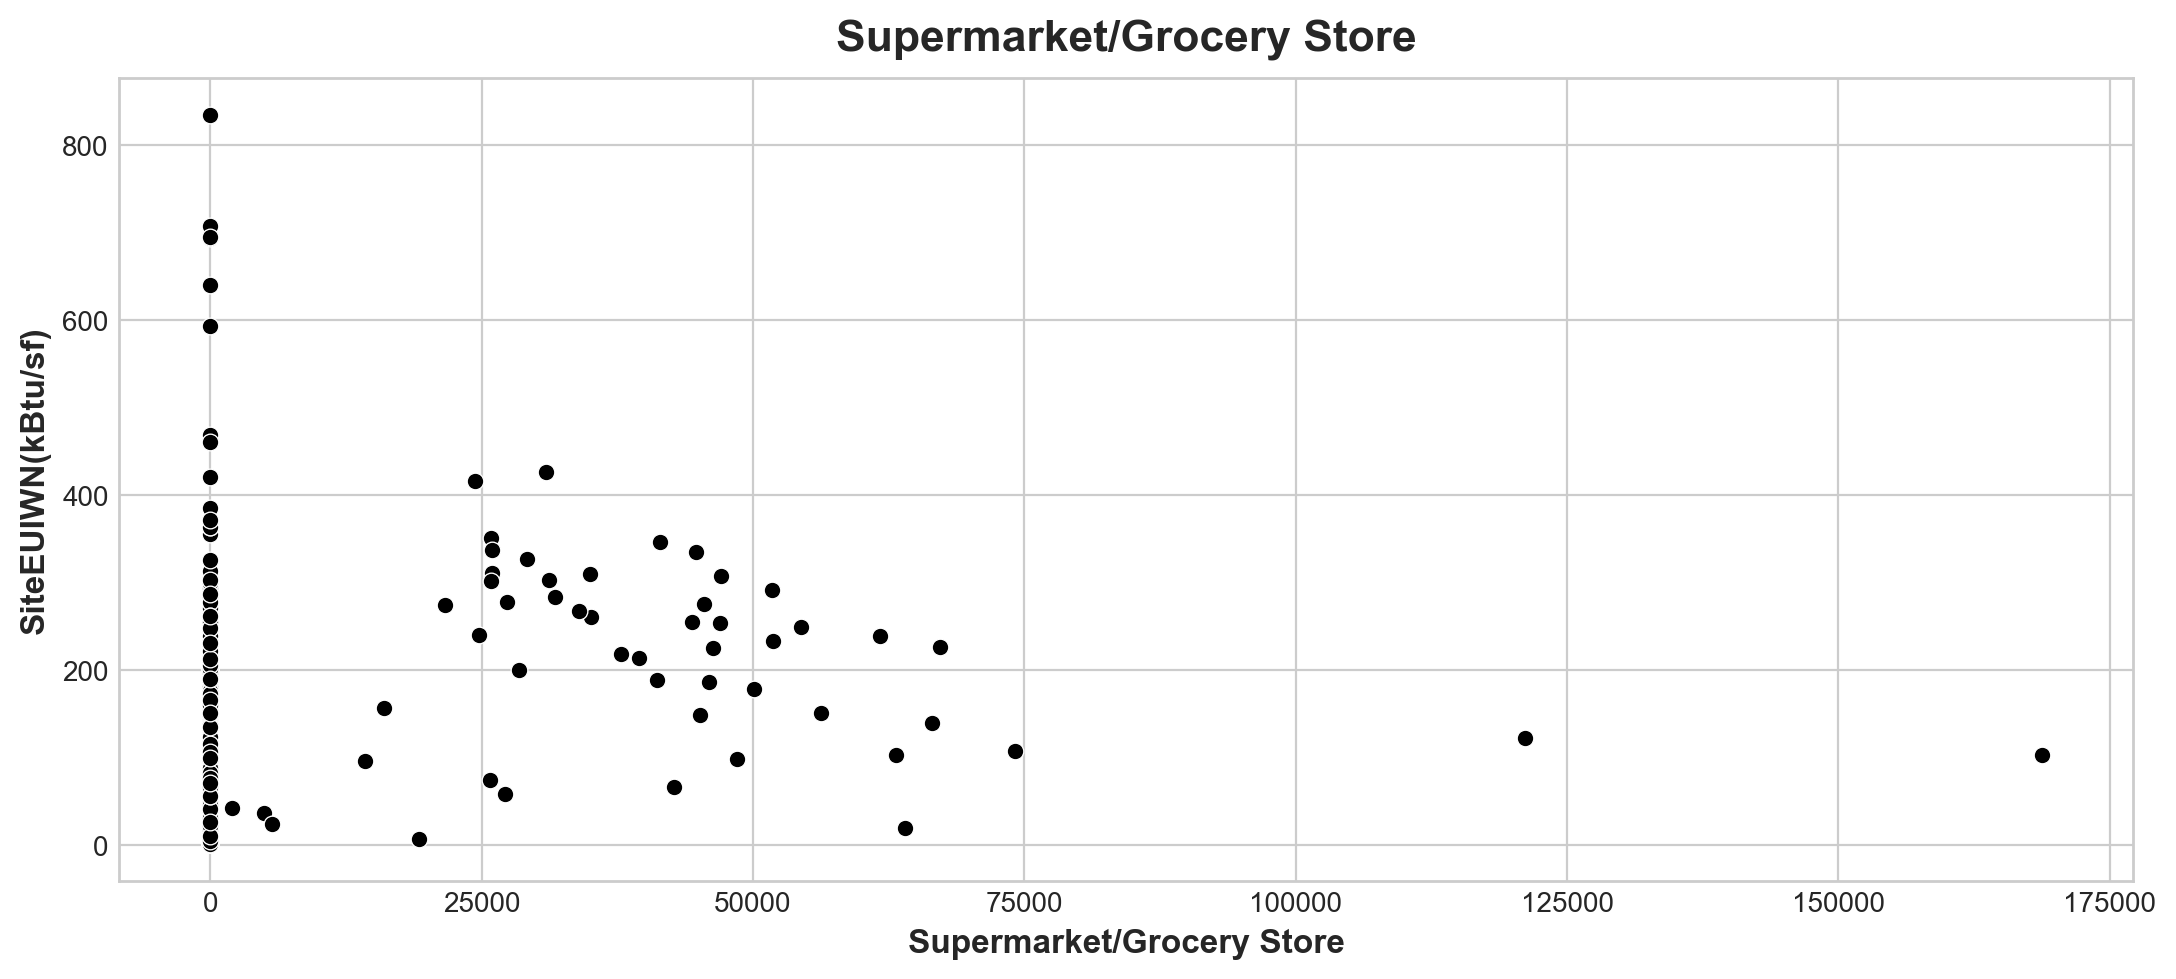

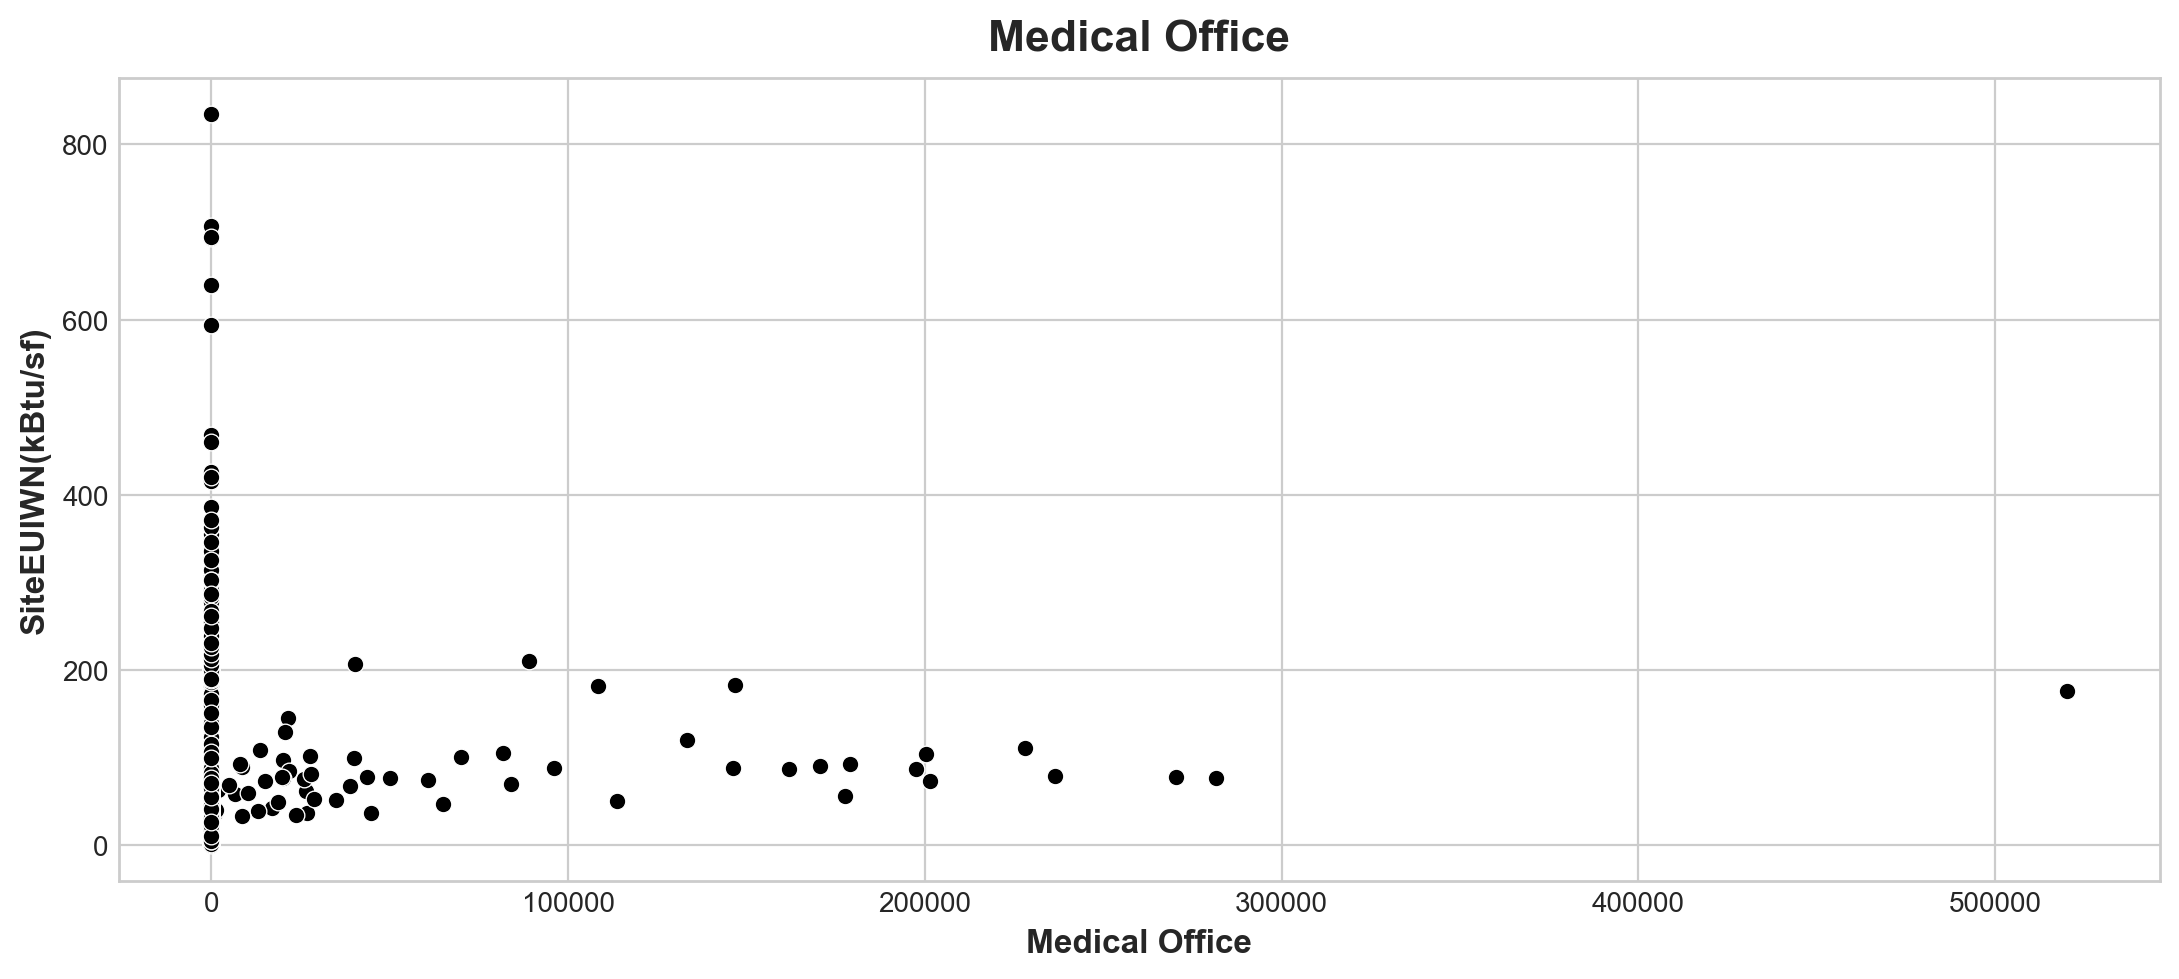

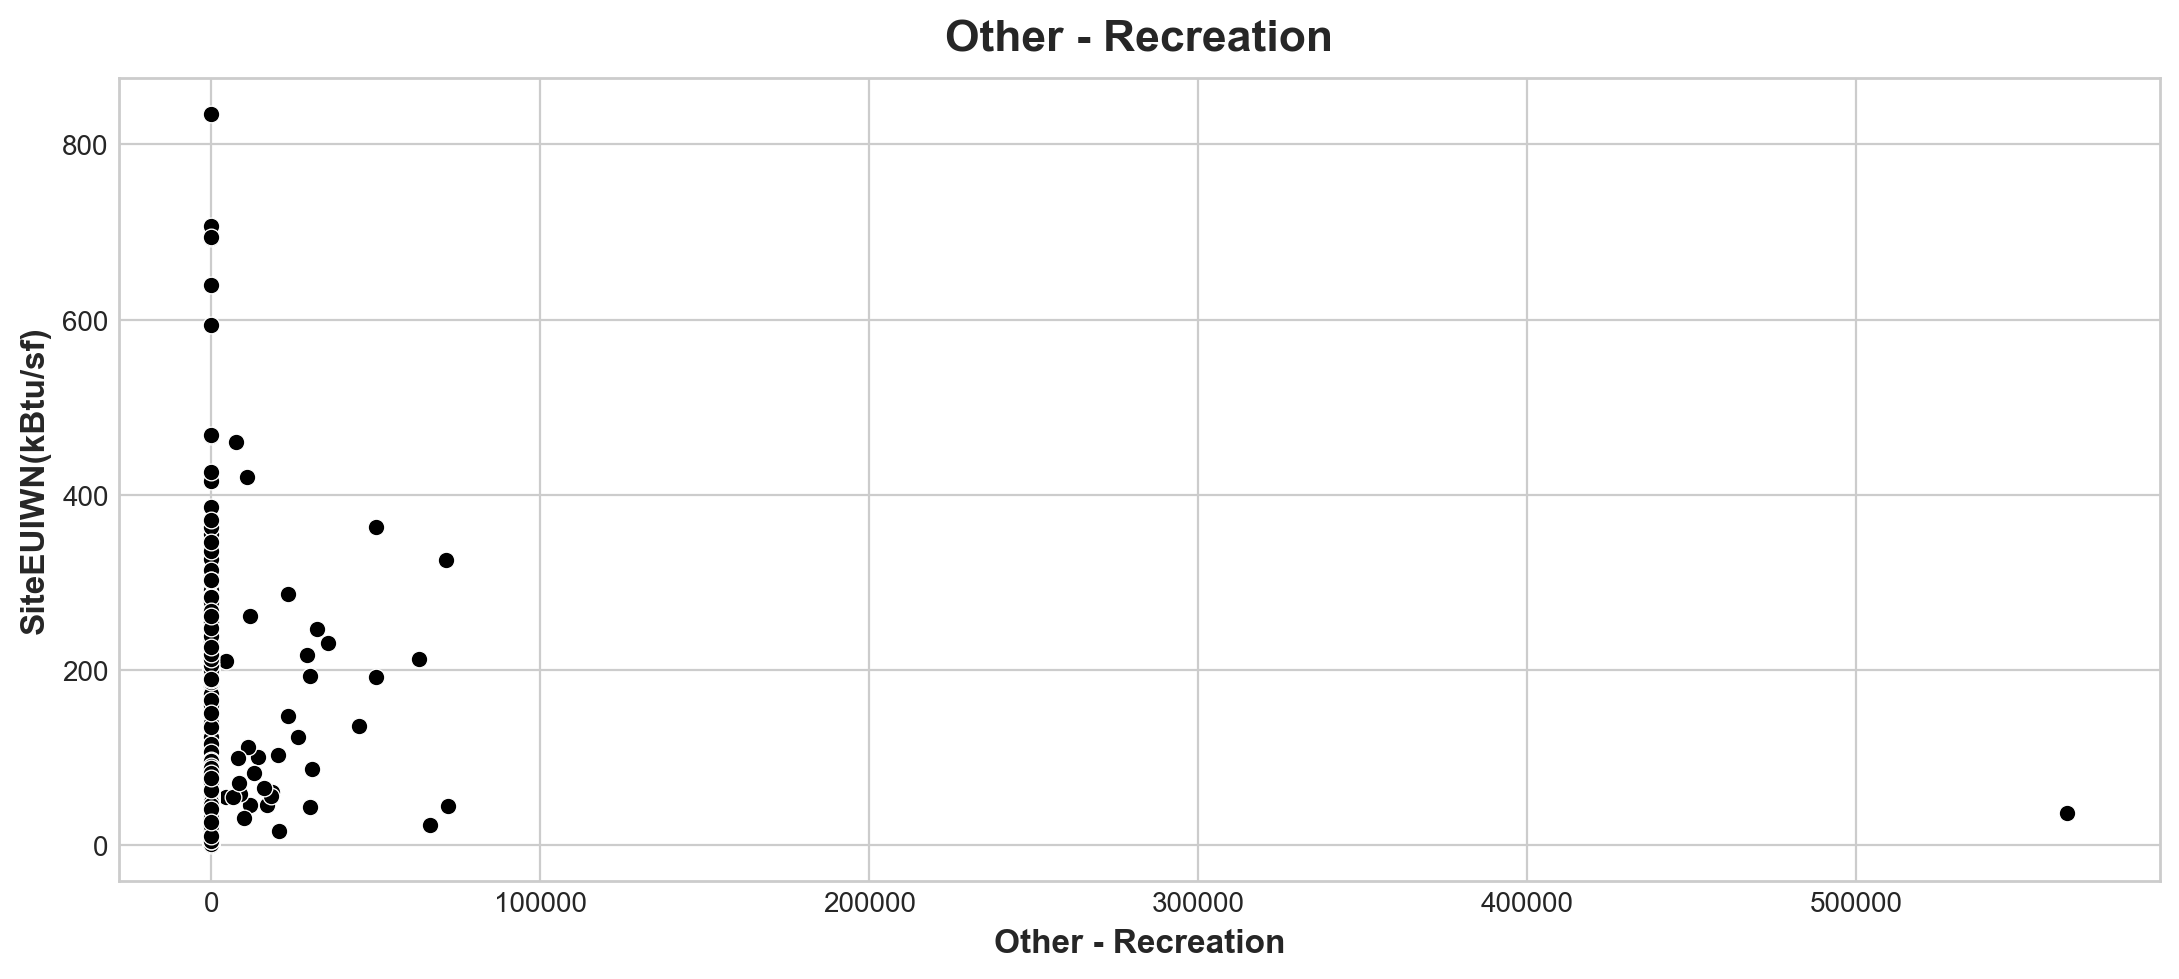

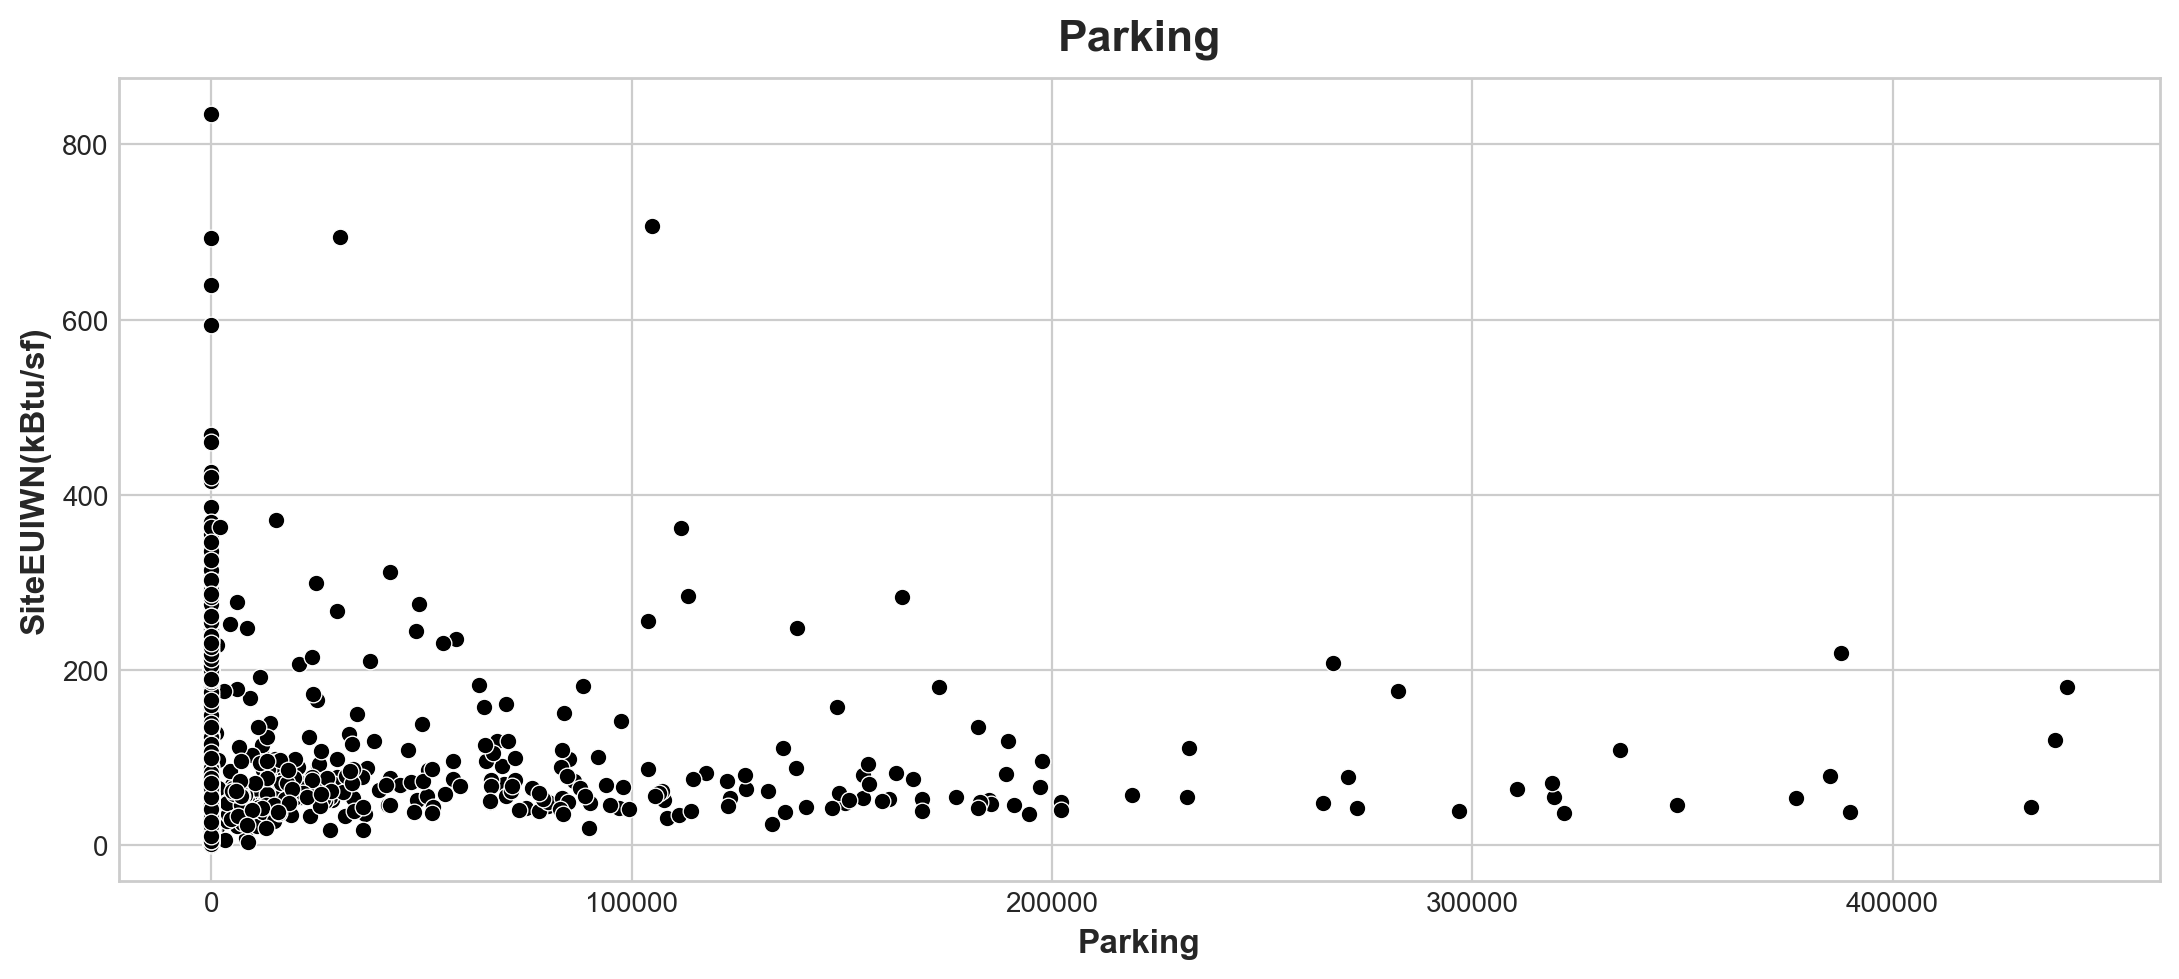

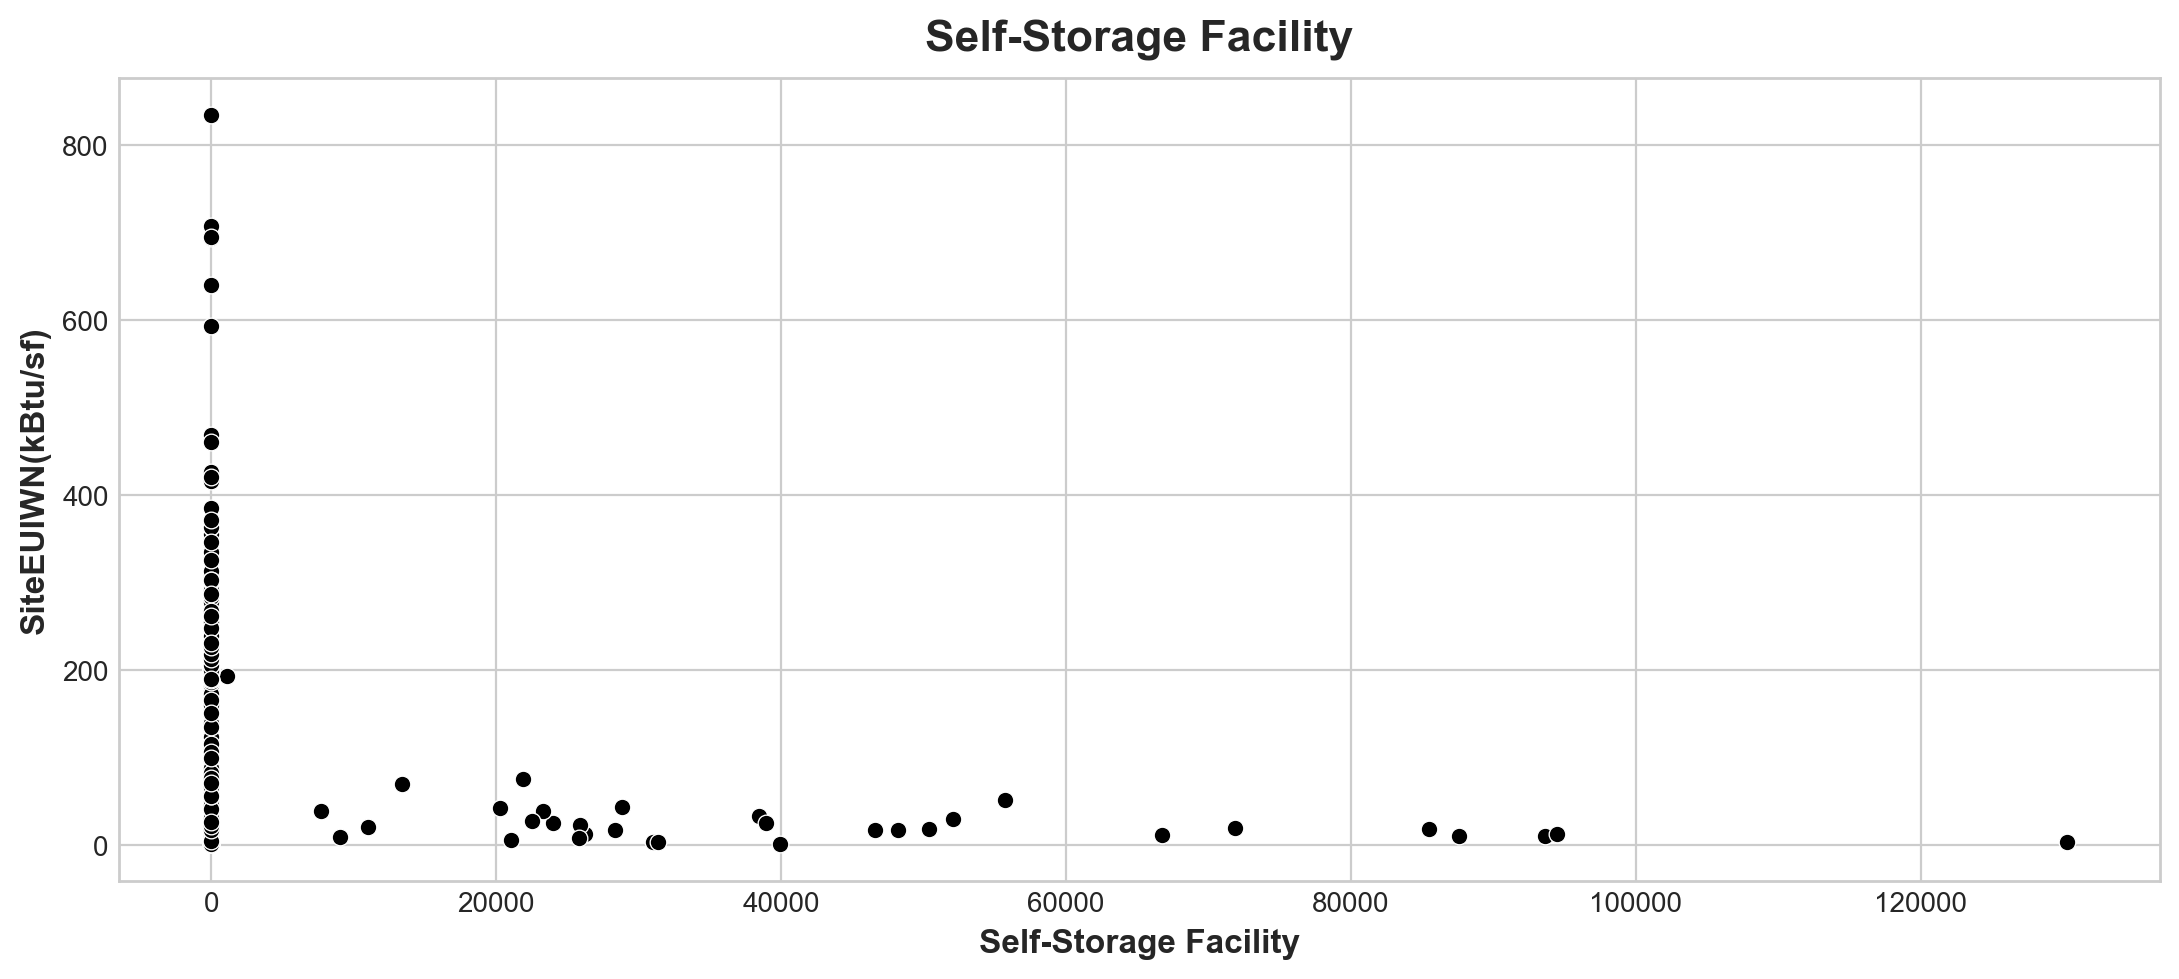

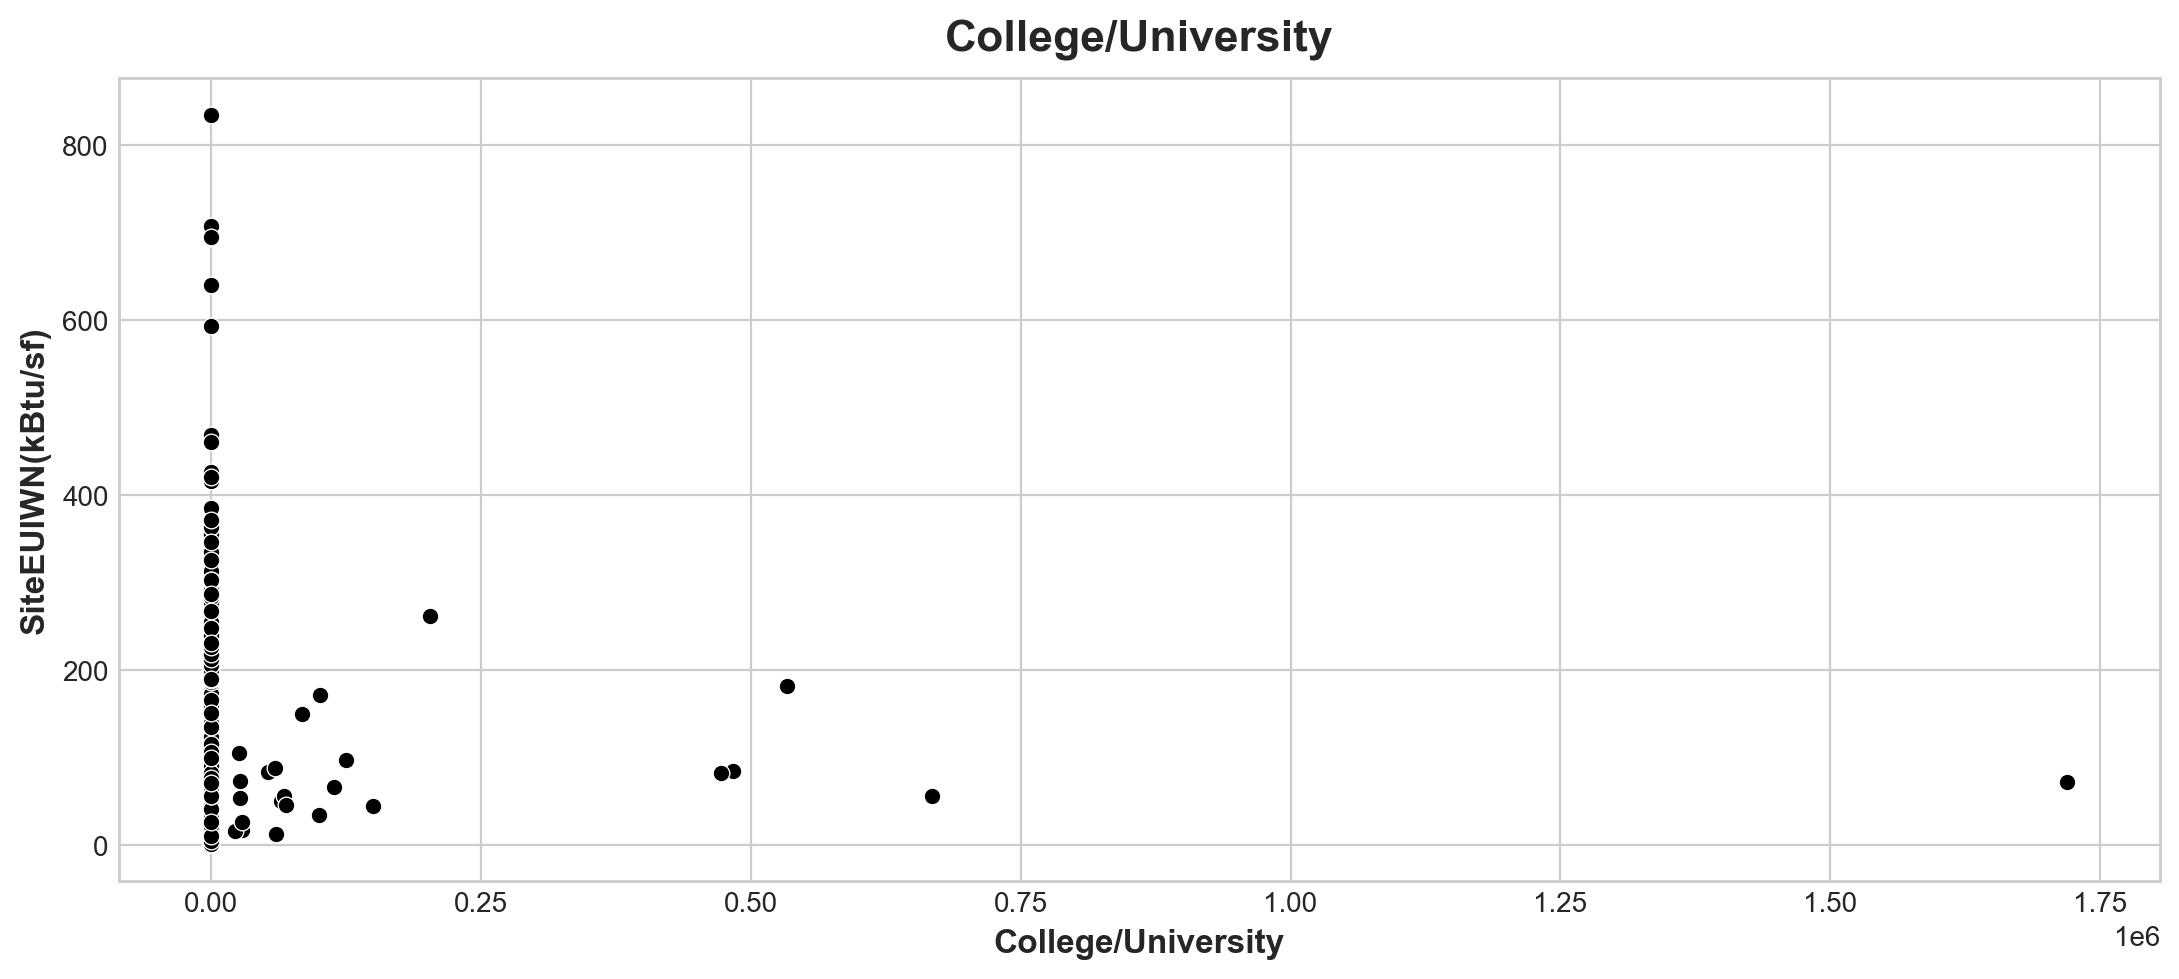

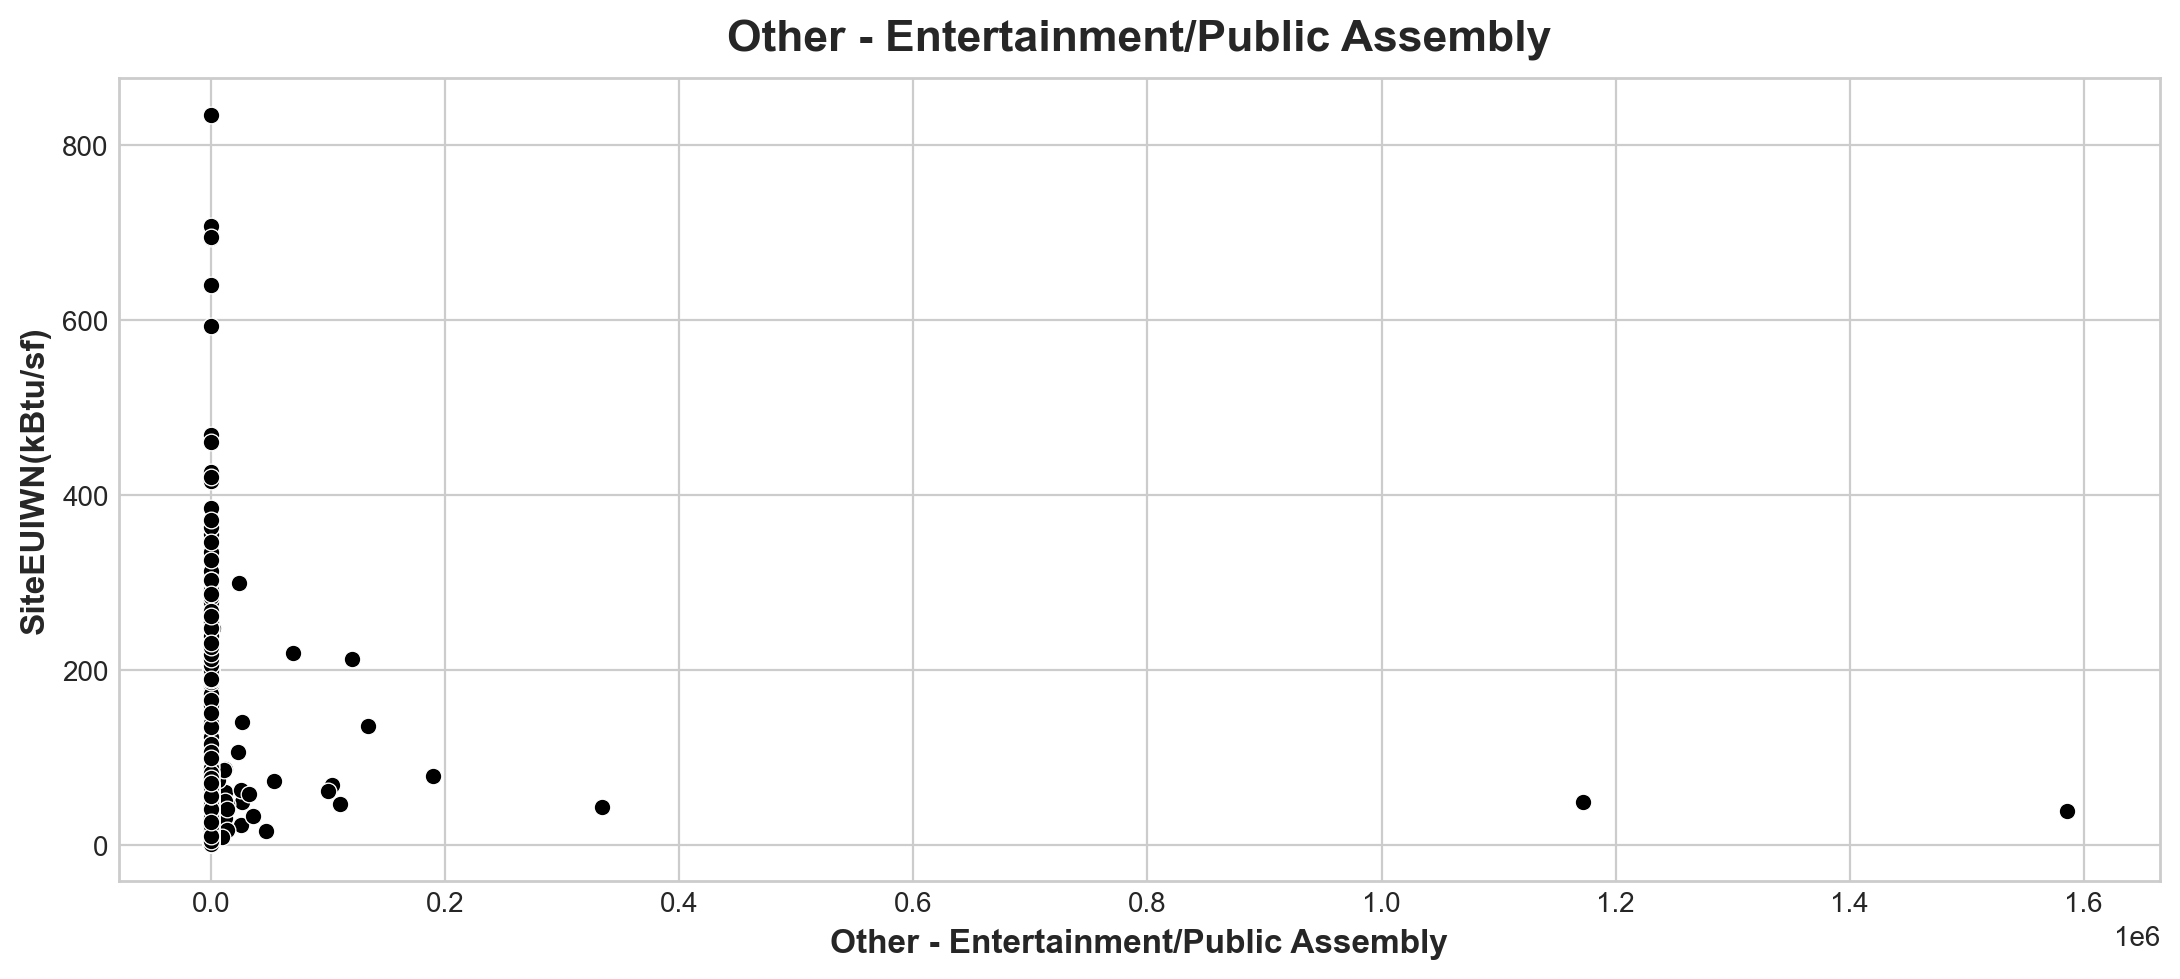

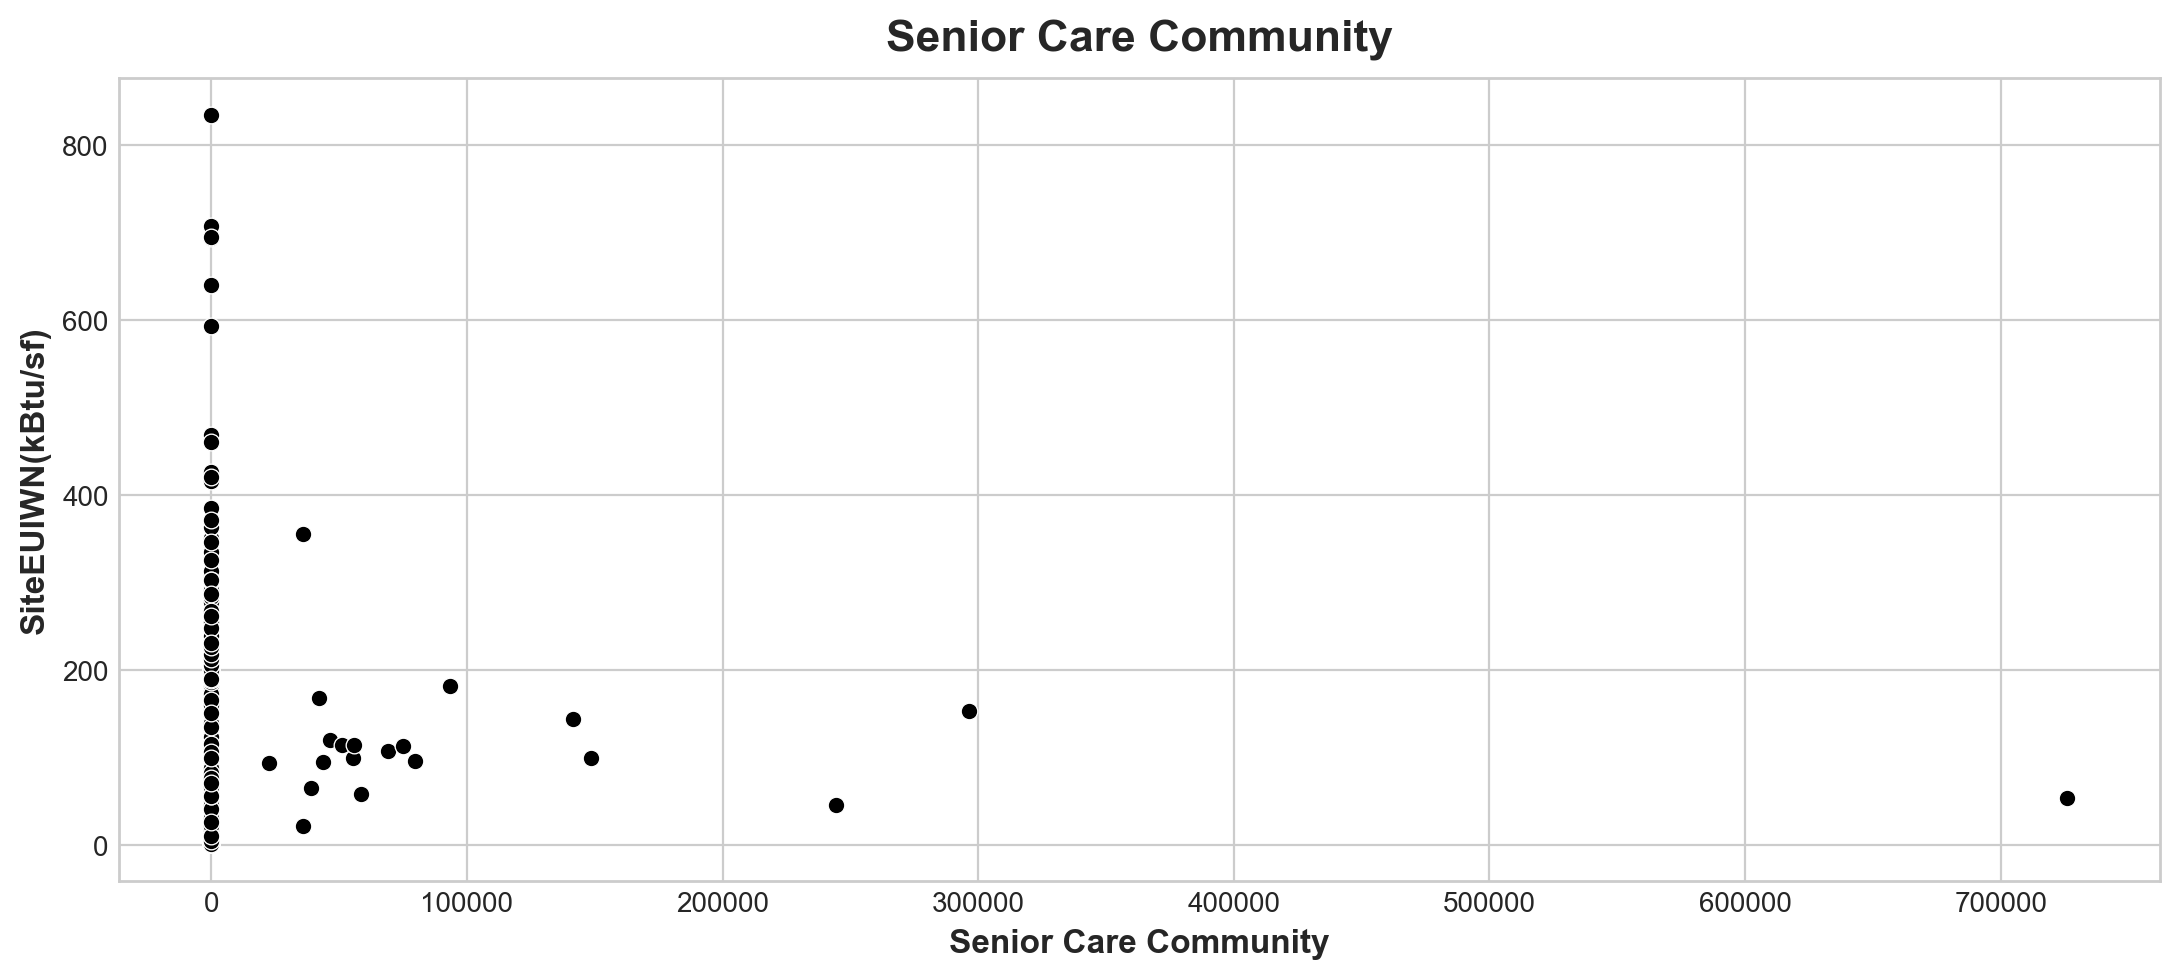

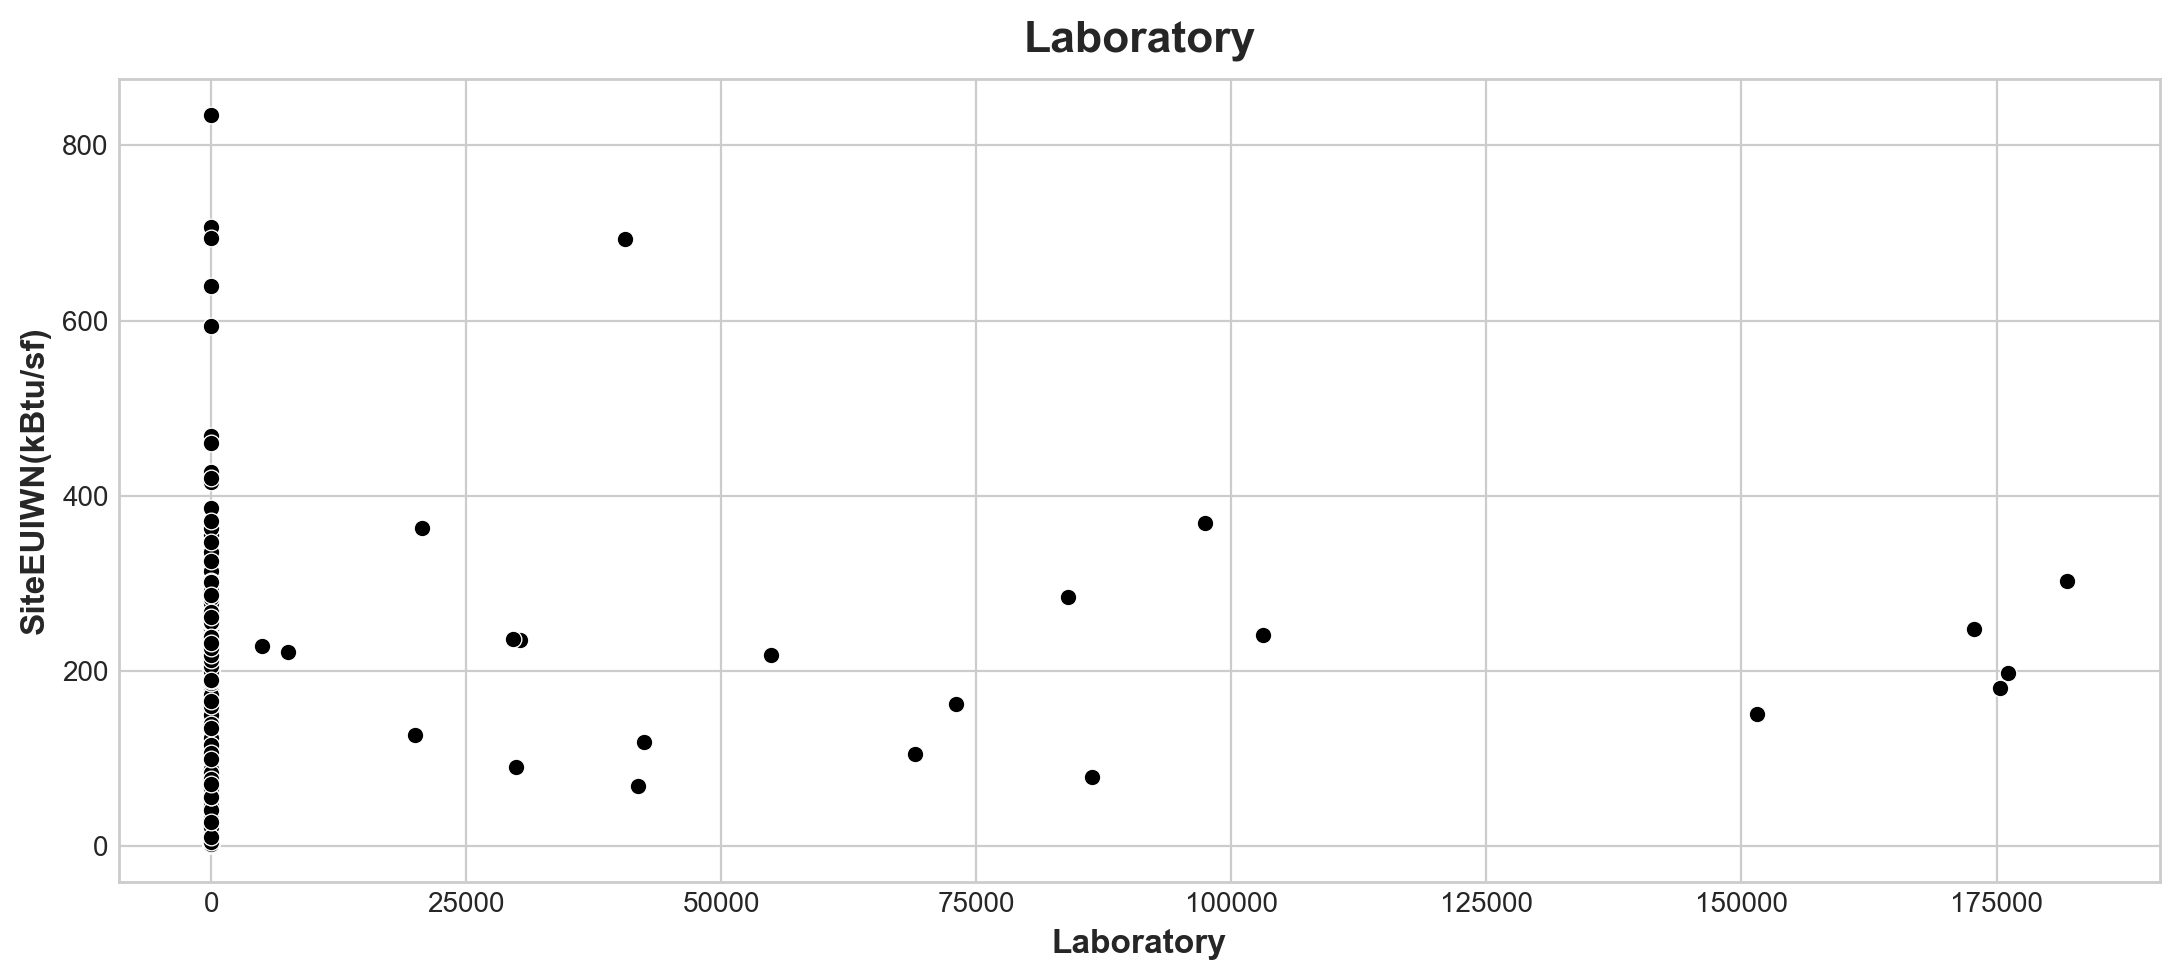

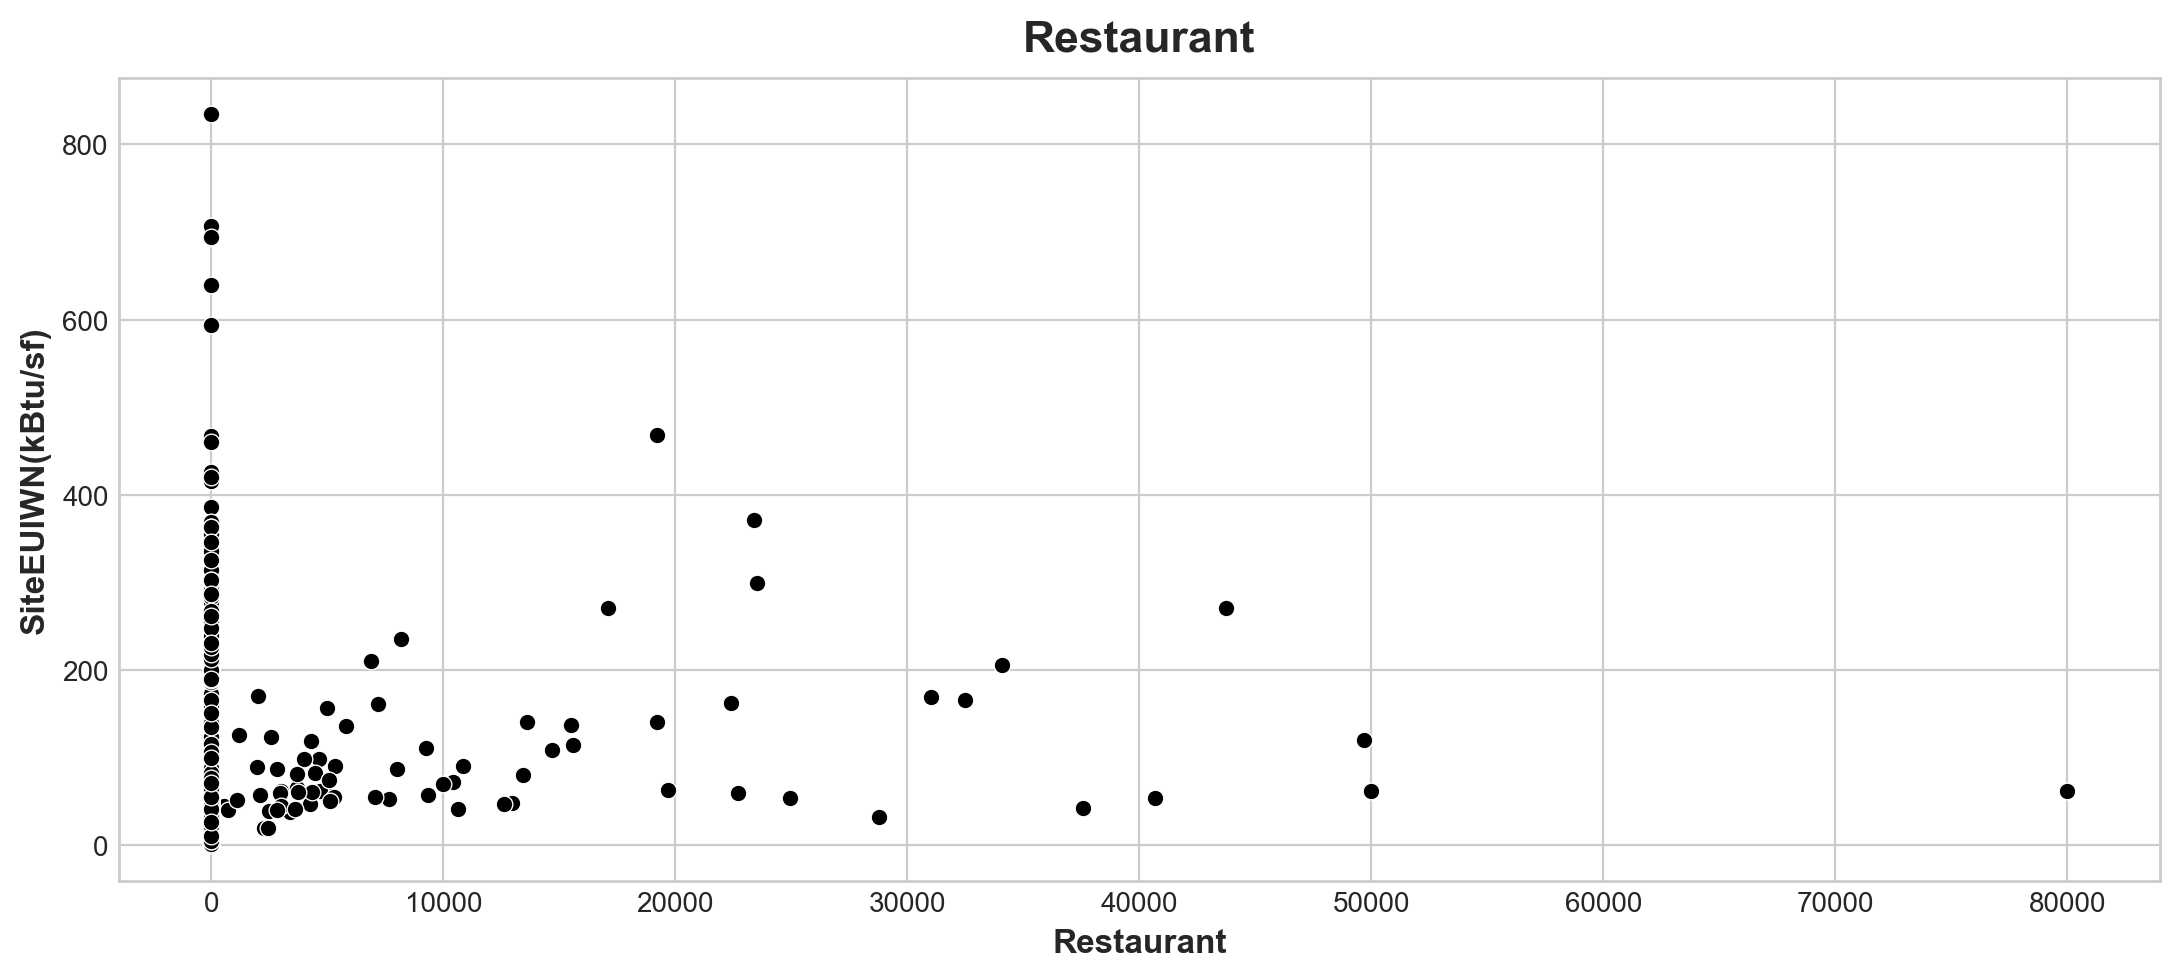

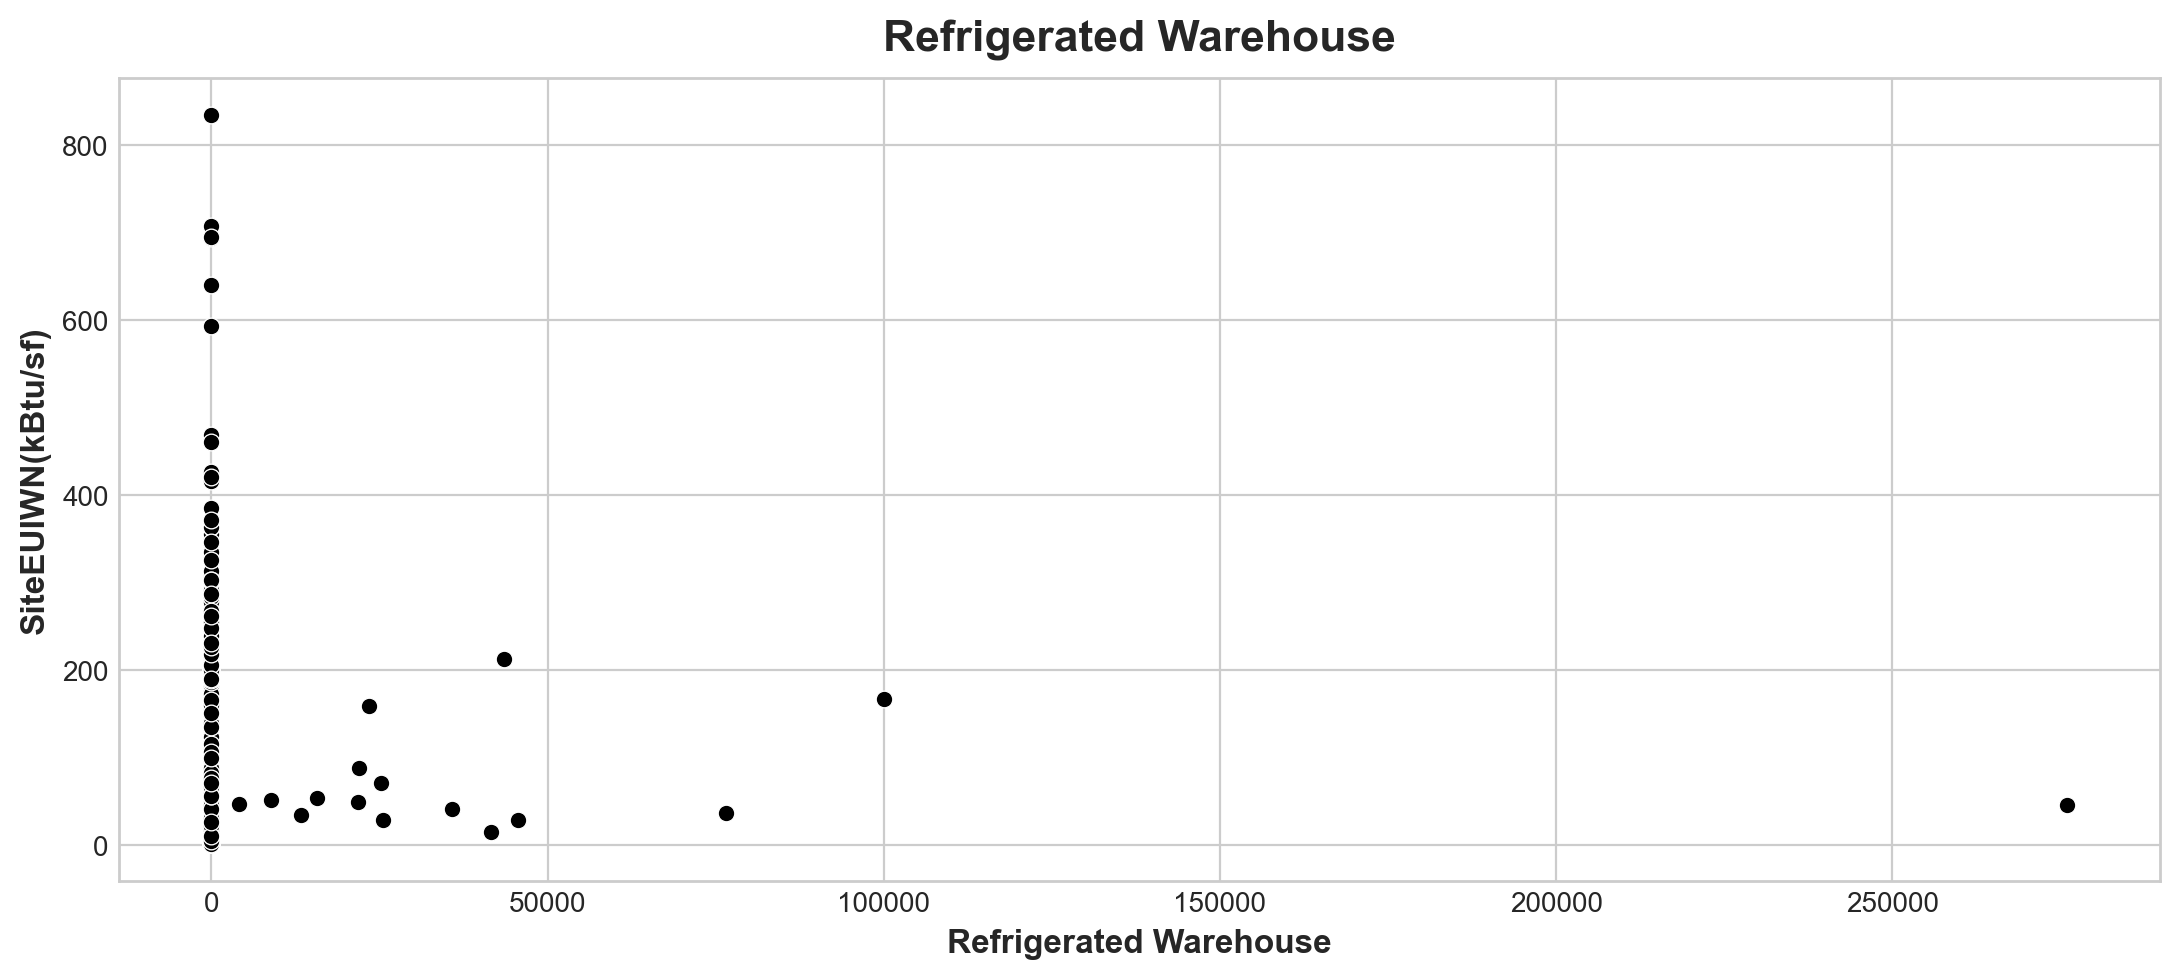

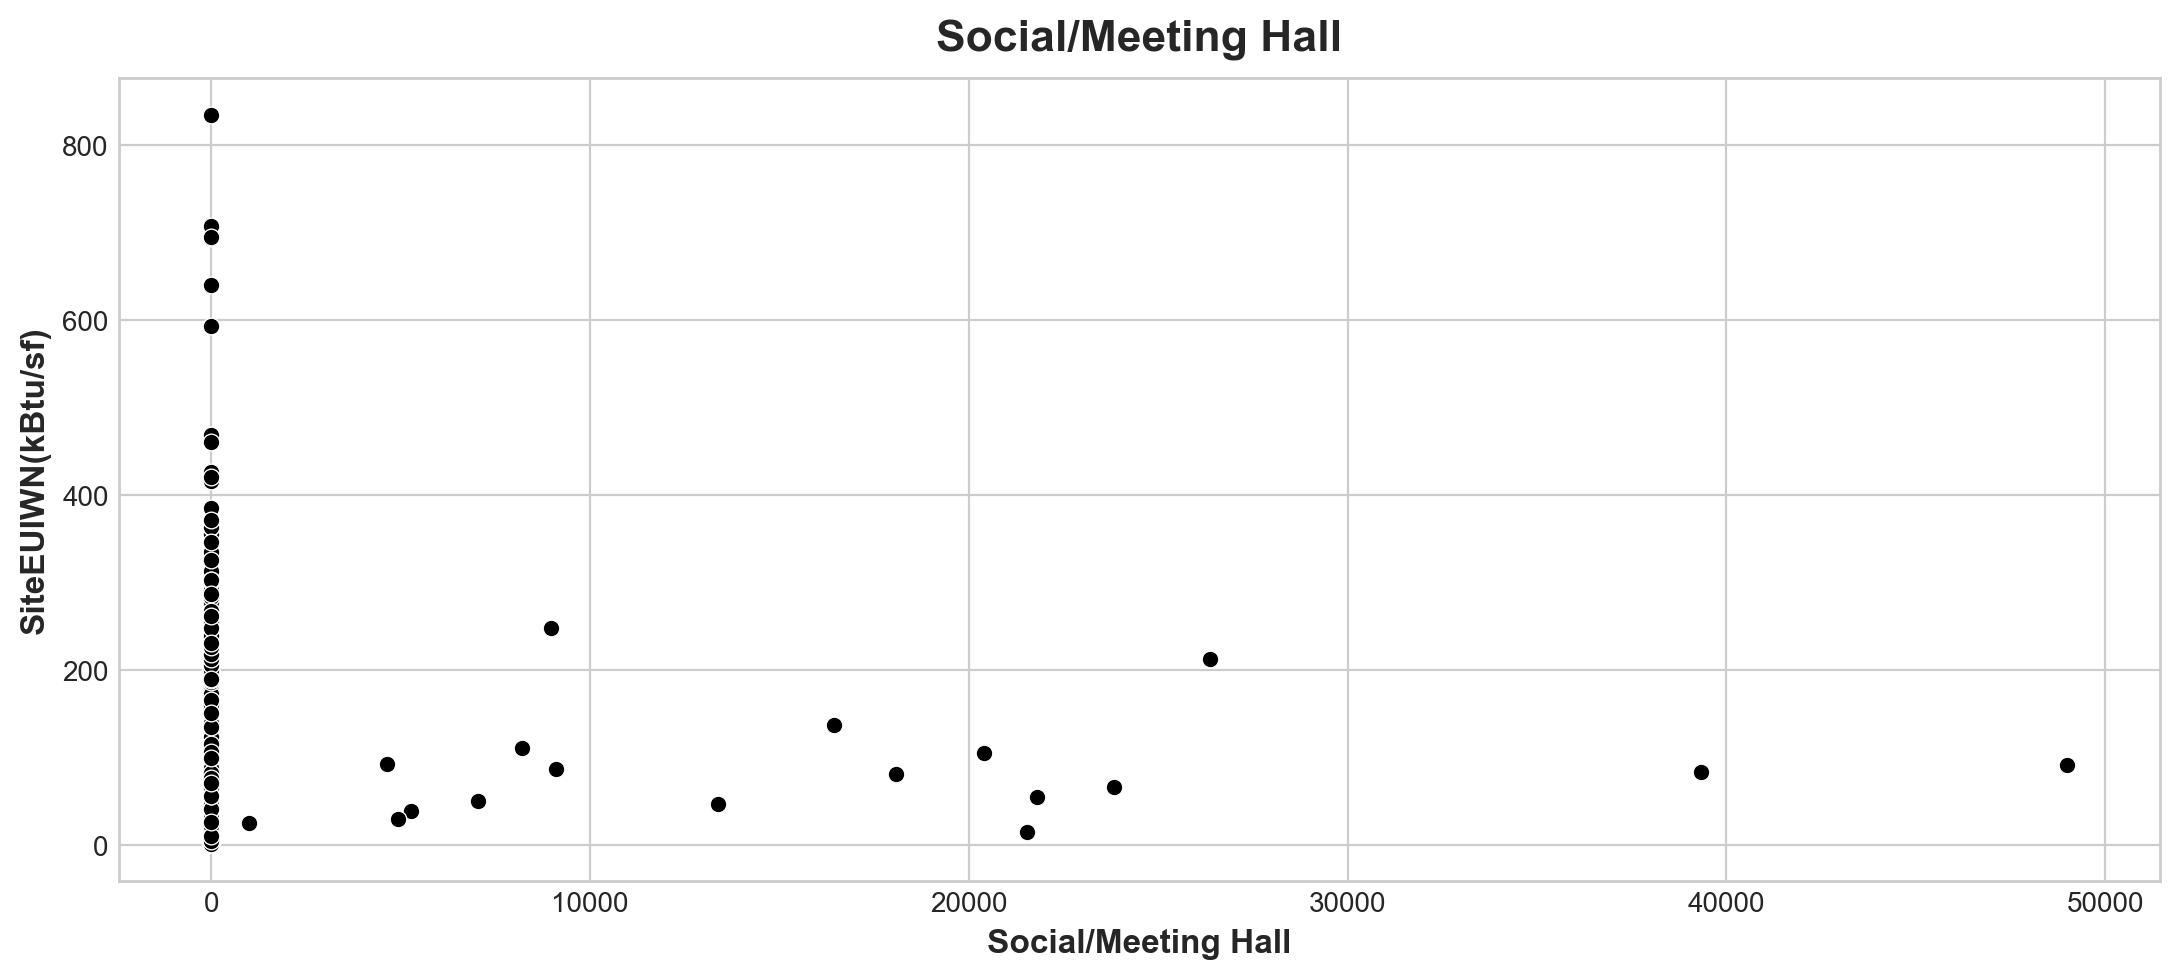

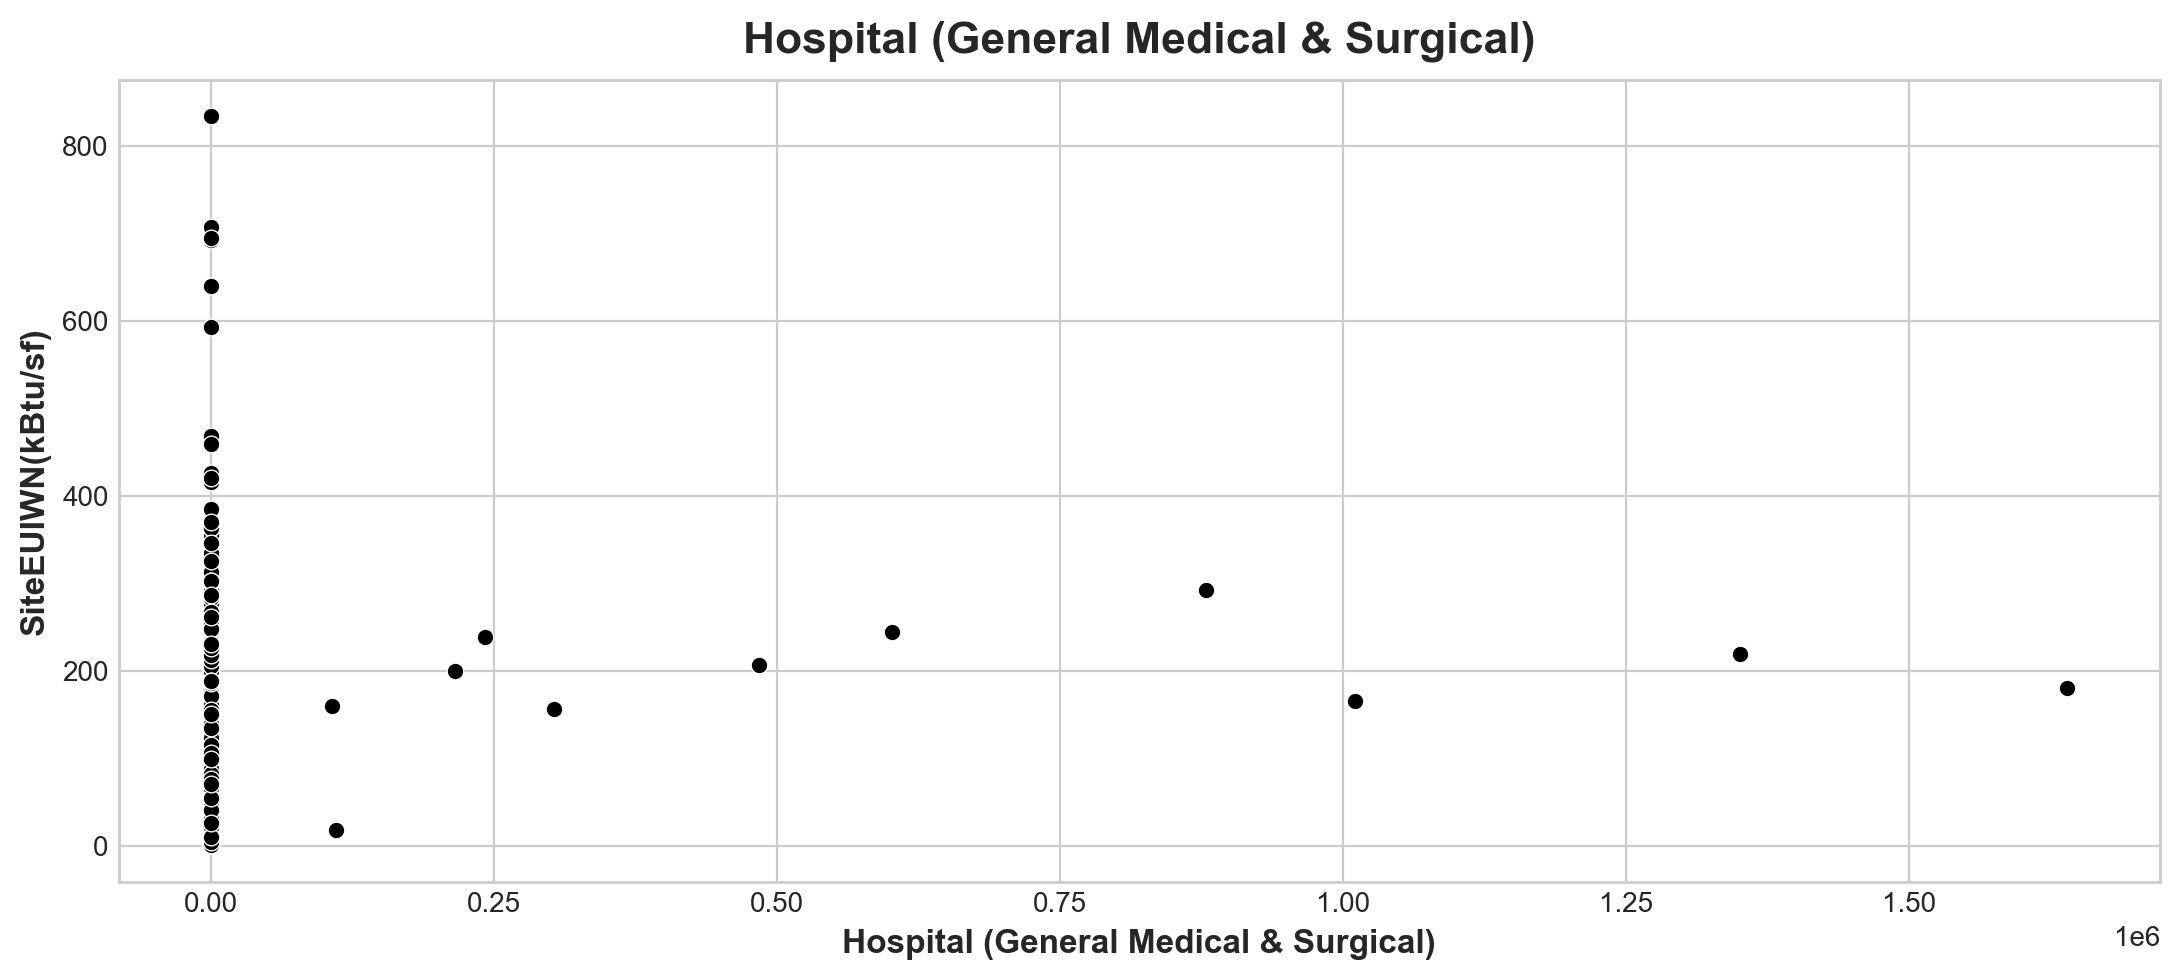

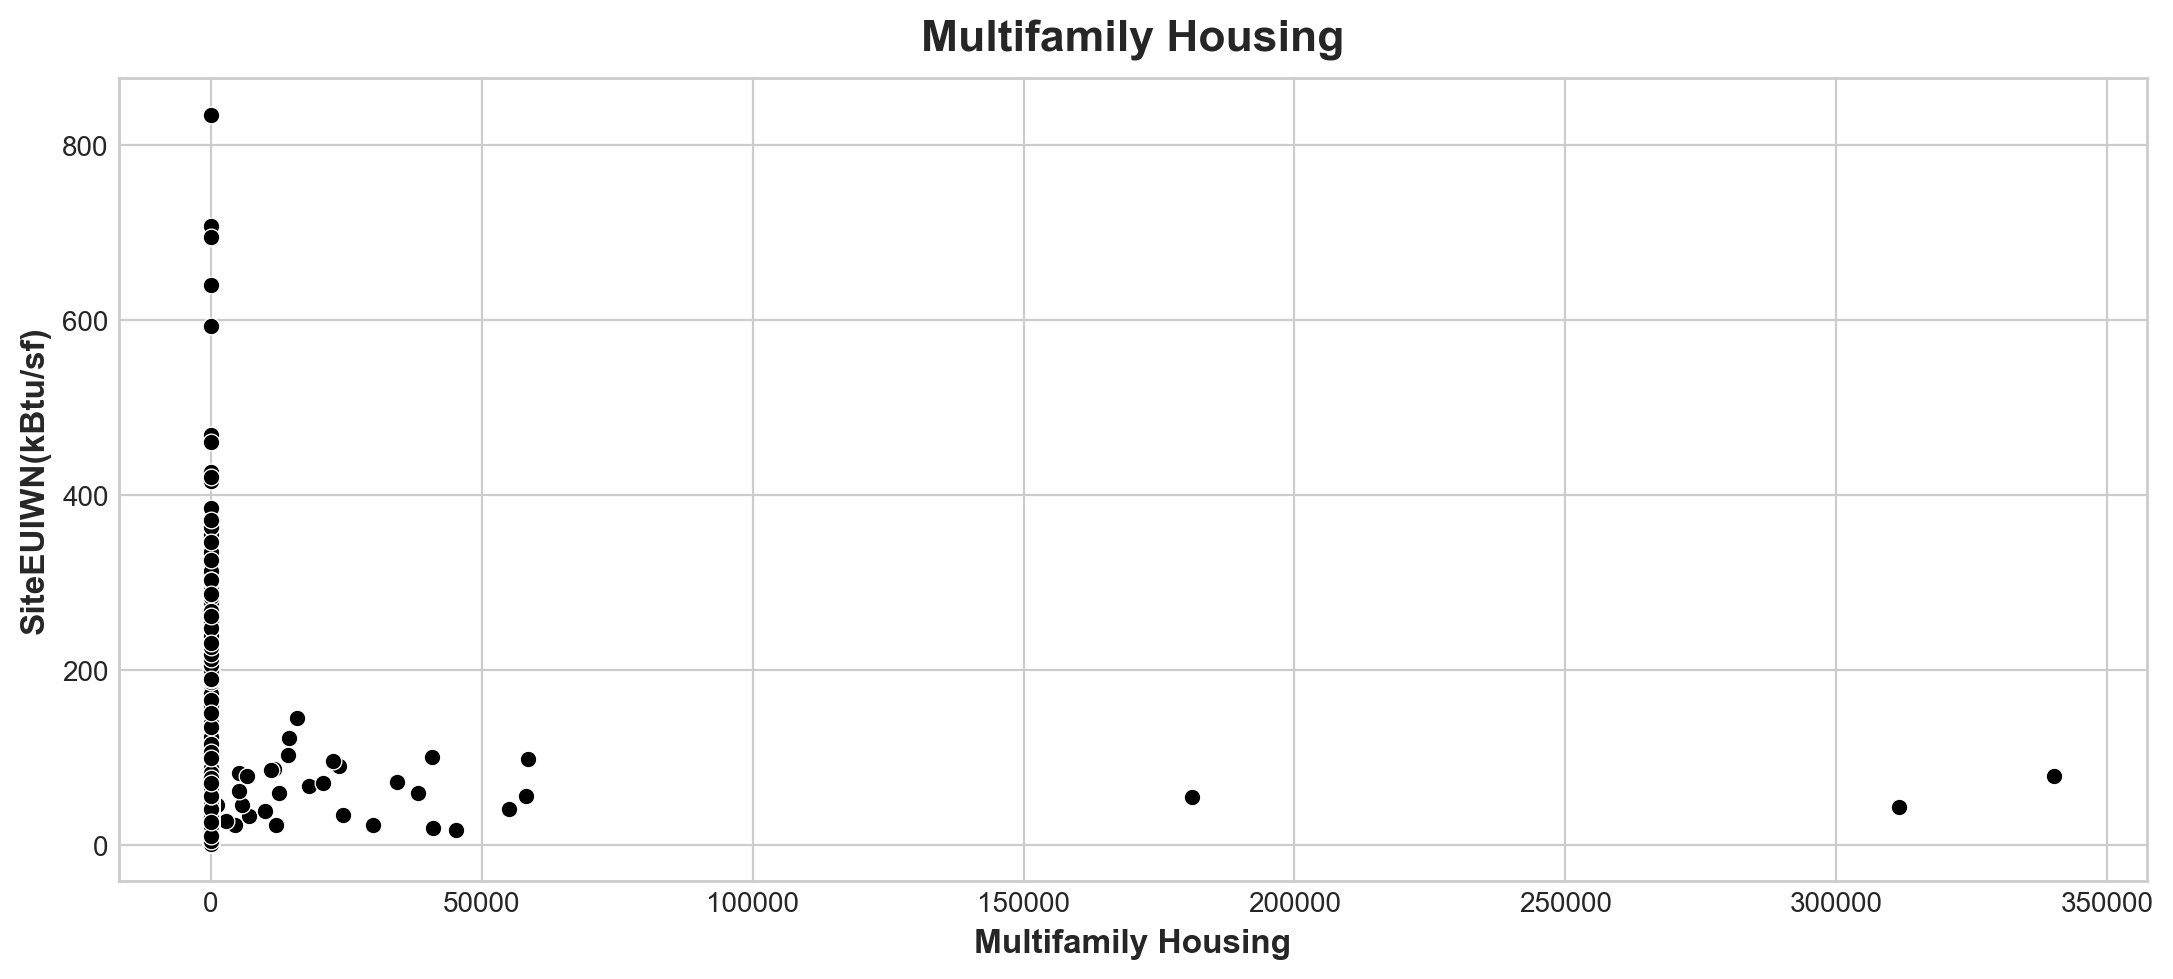

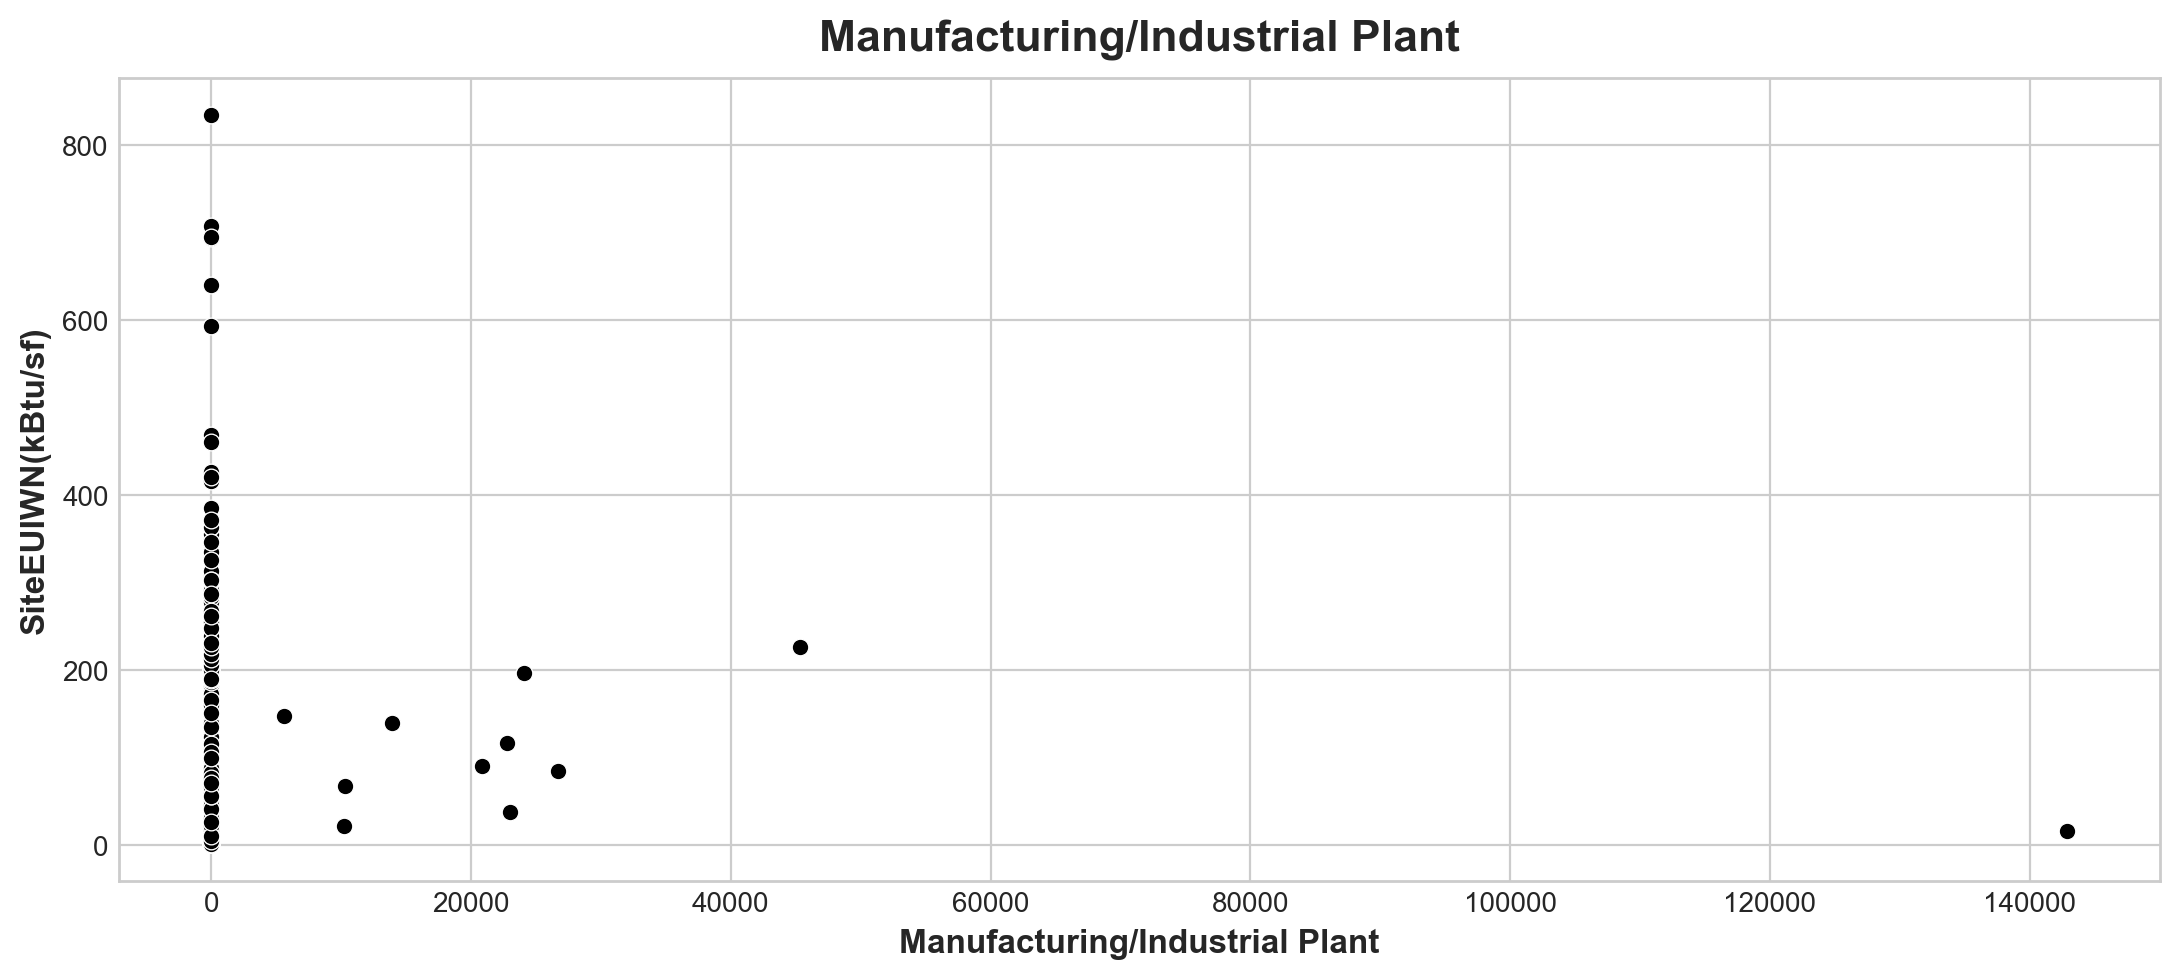

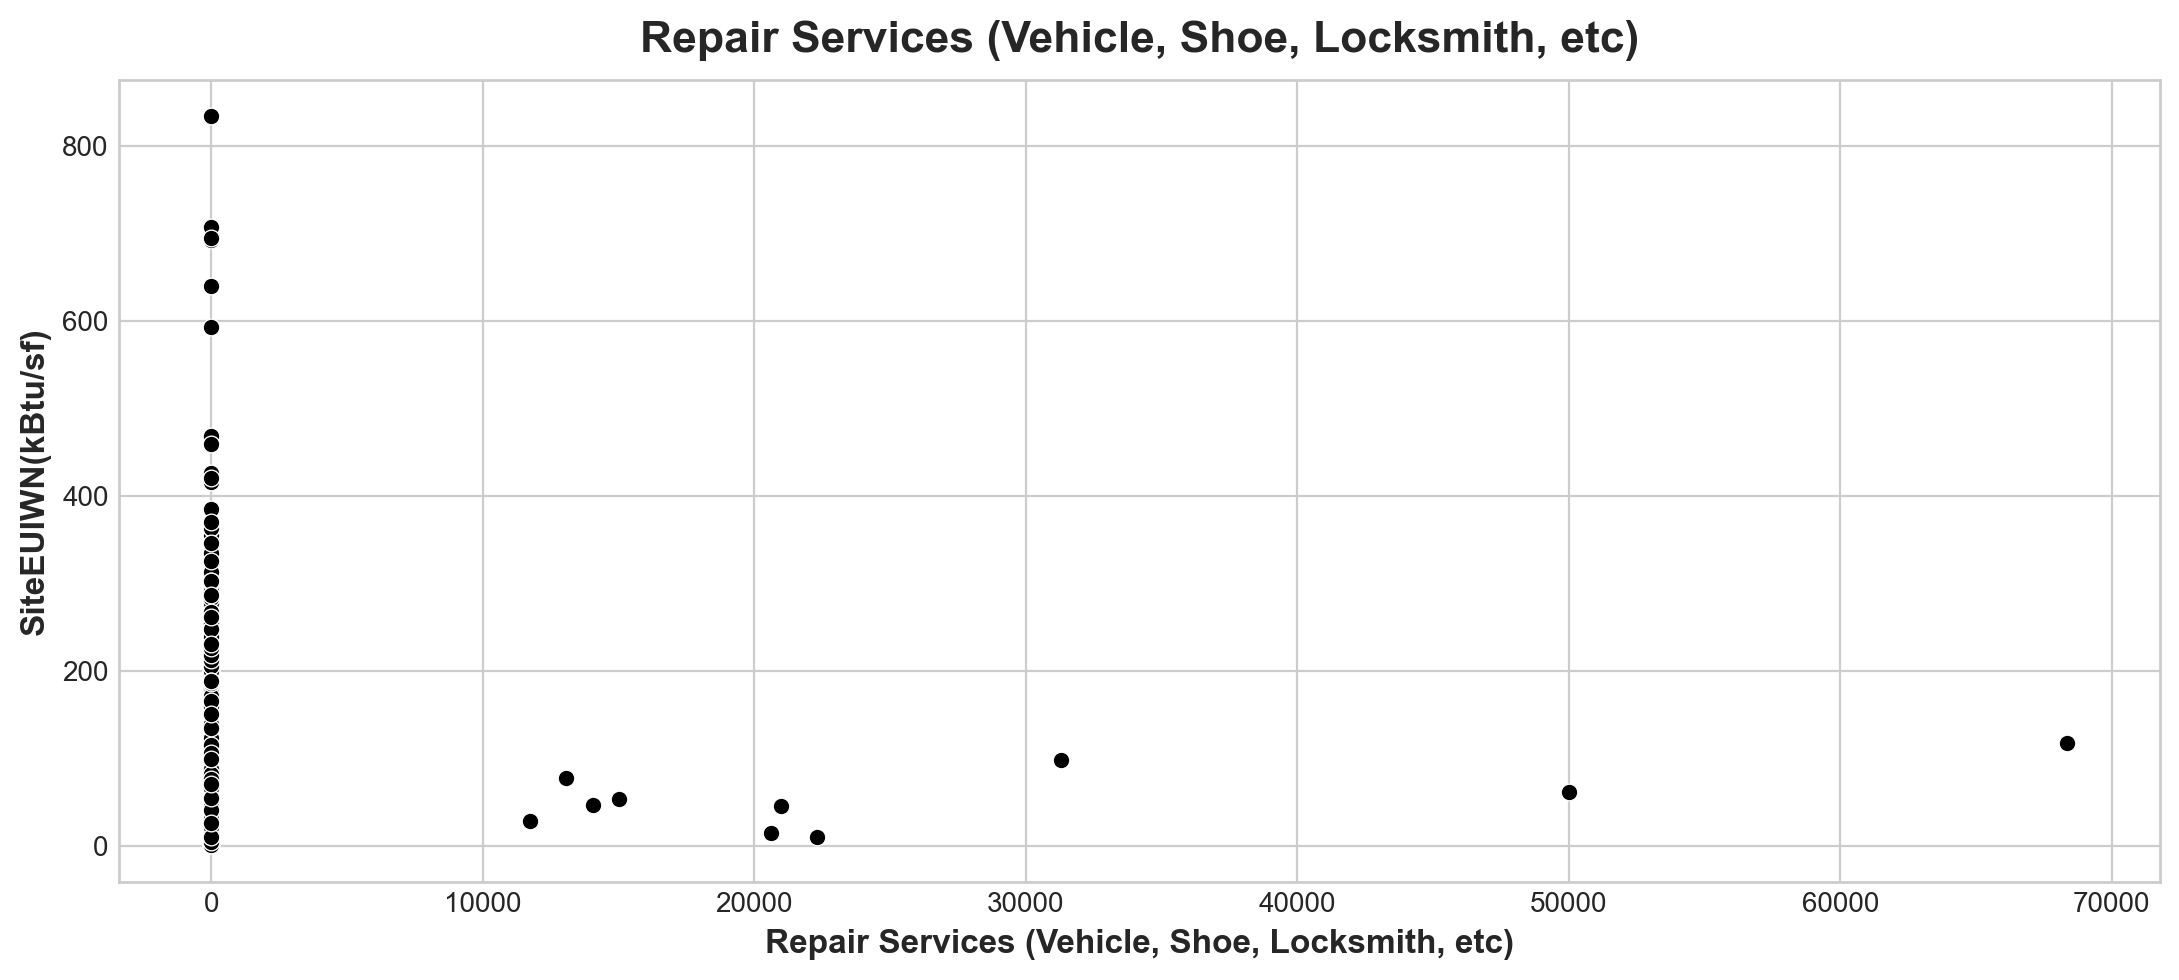

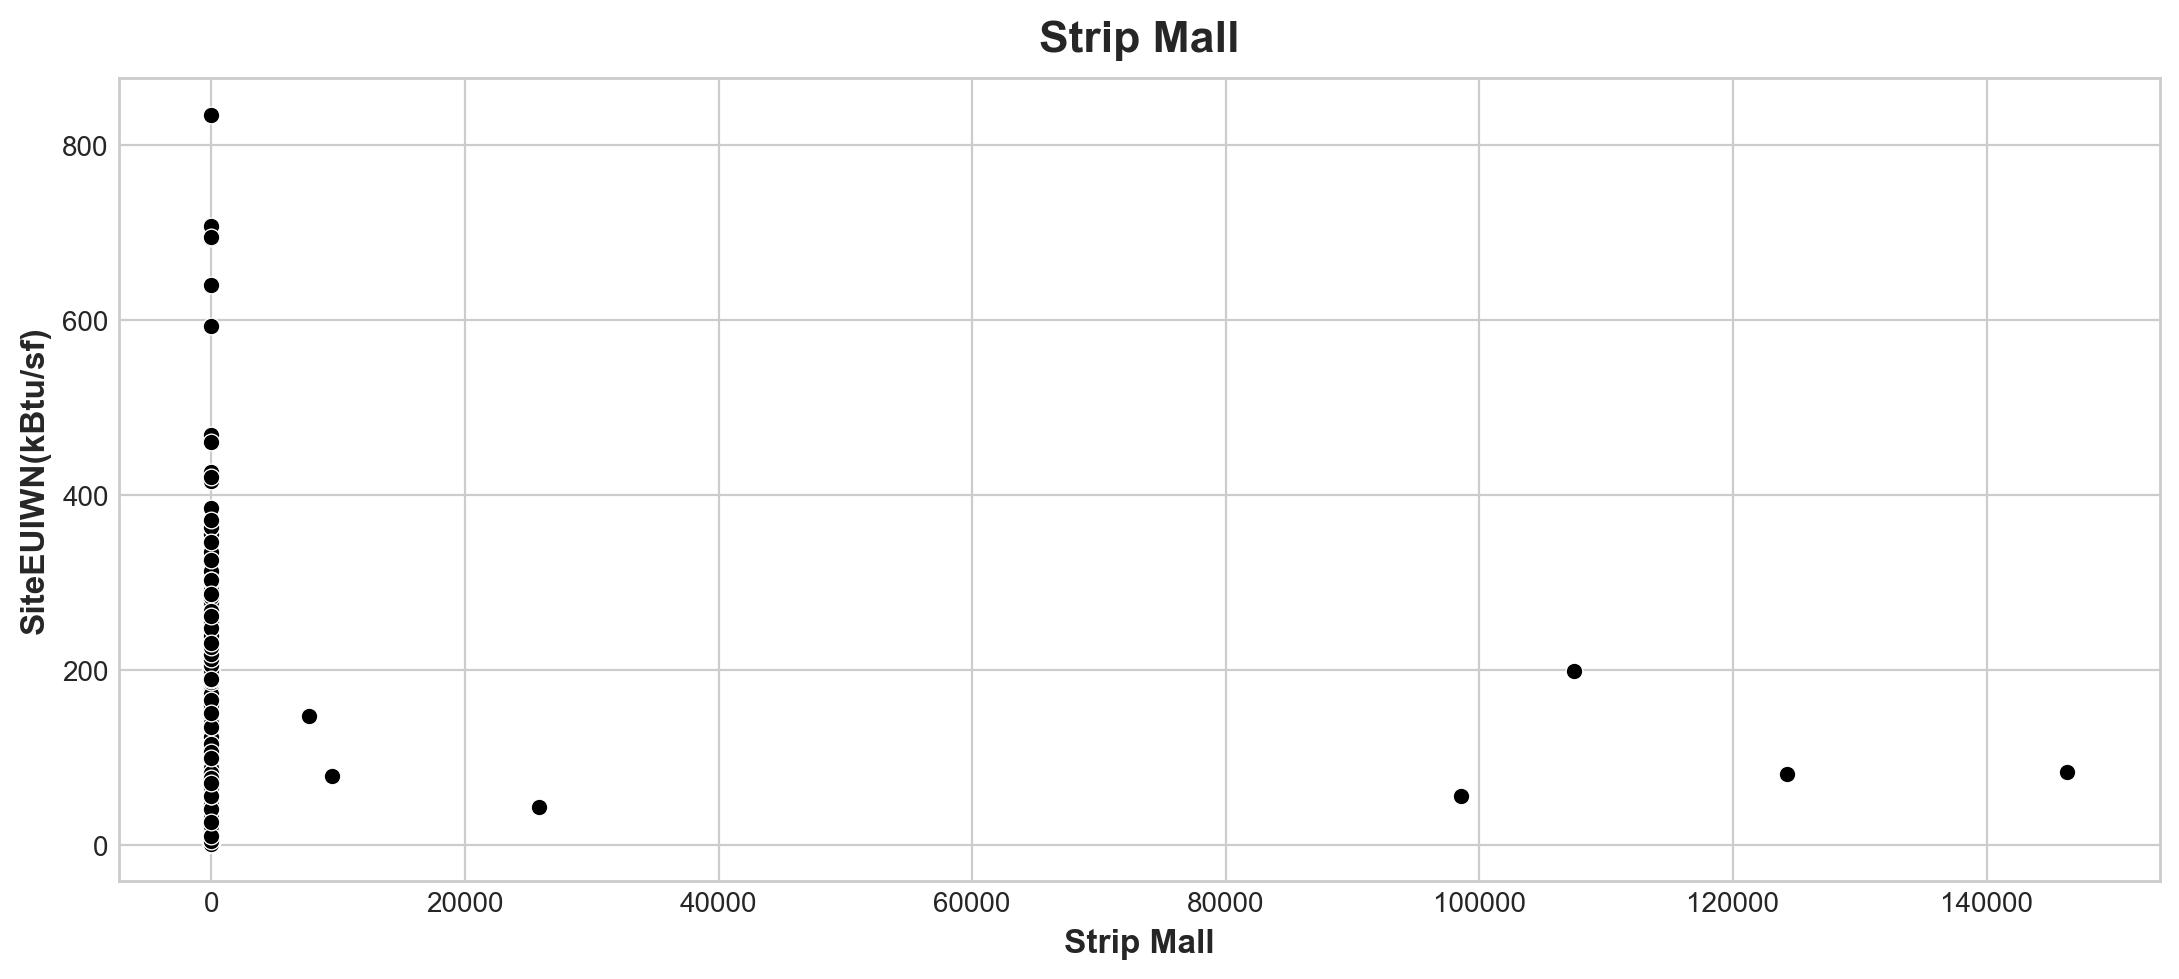

In [44]:
for col in list_types :
    scatter_test(col,'SiteEUIWN(kBtu/sf)')

### 1.2.2 Avec GHGEmissionsIntensity

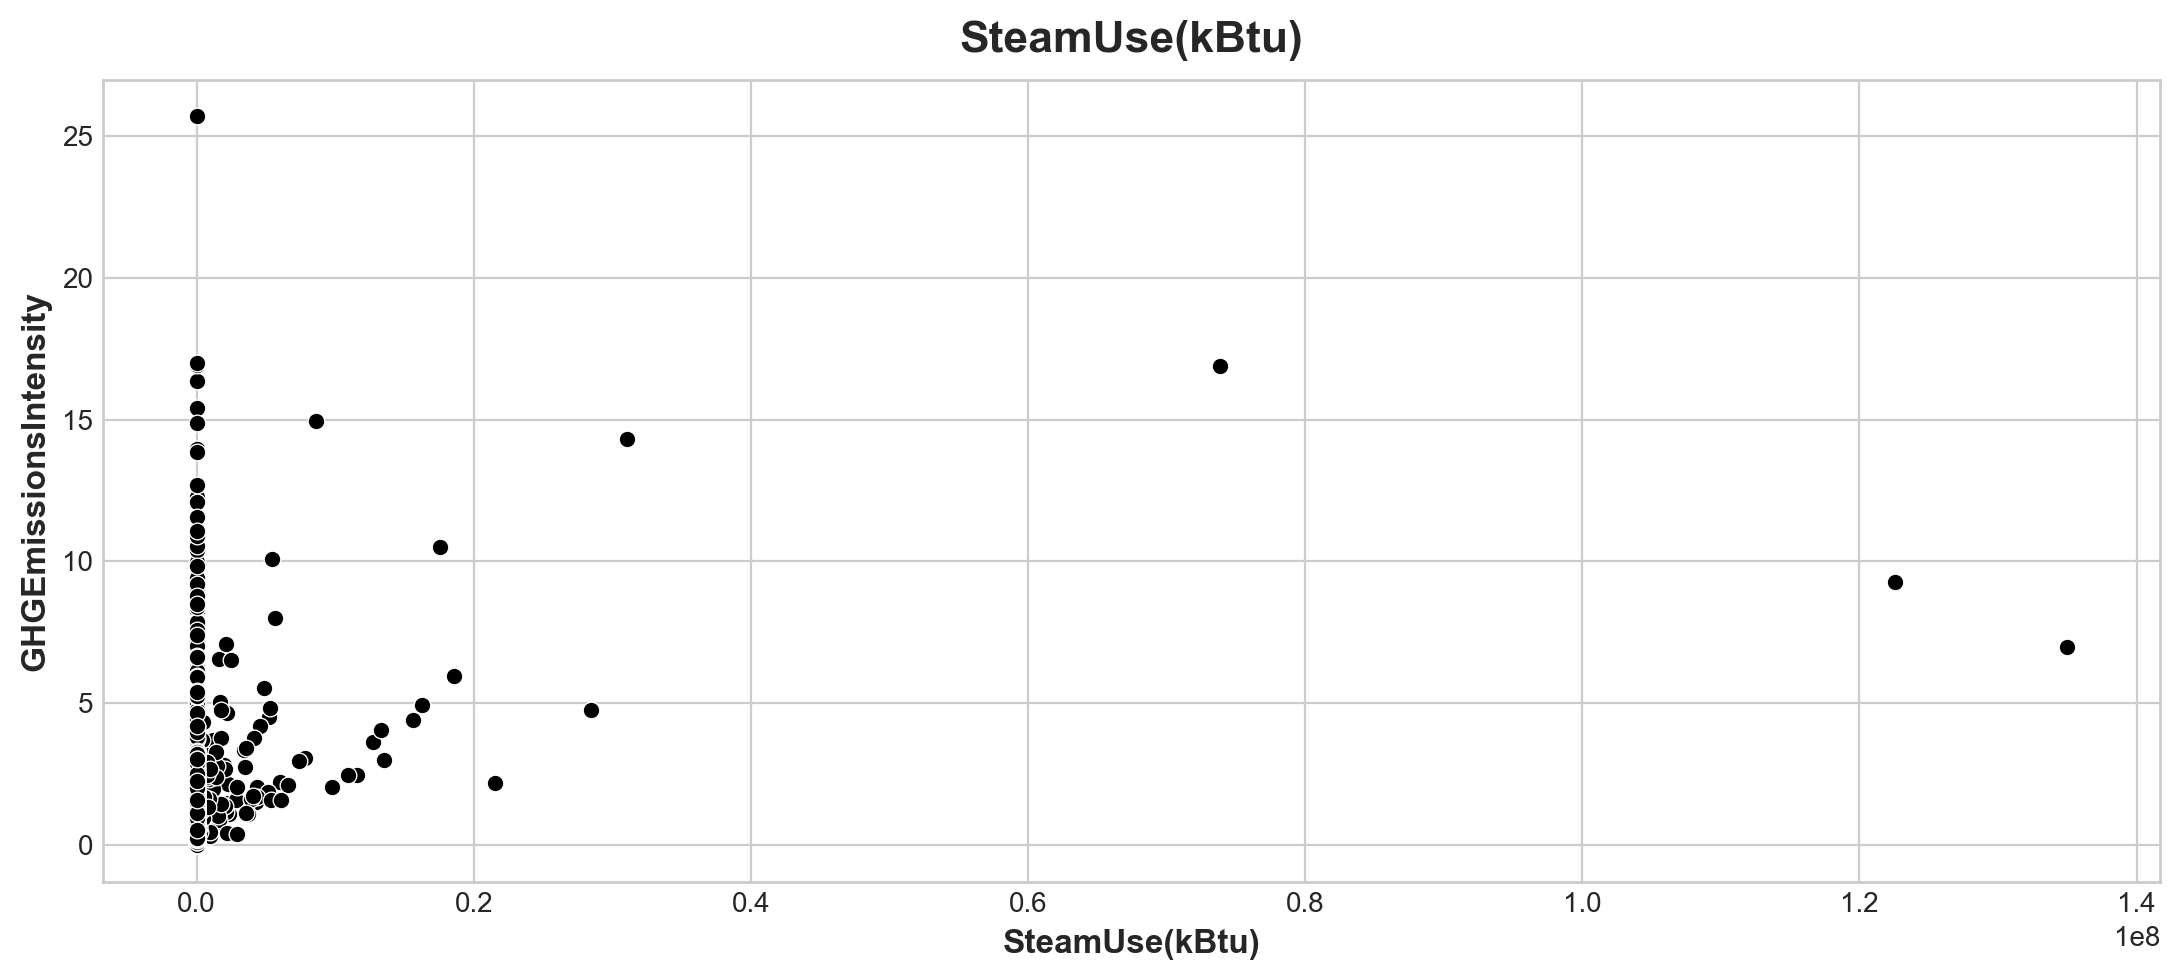

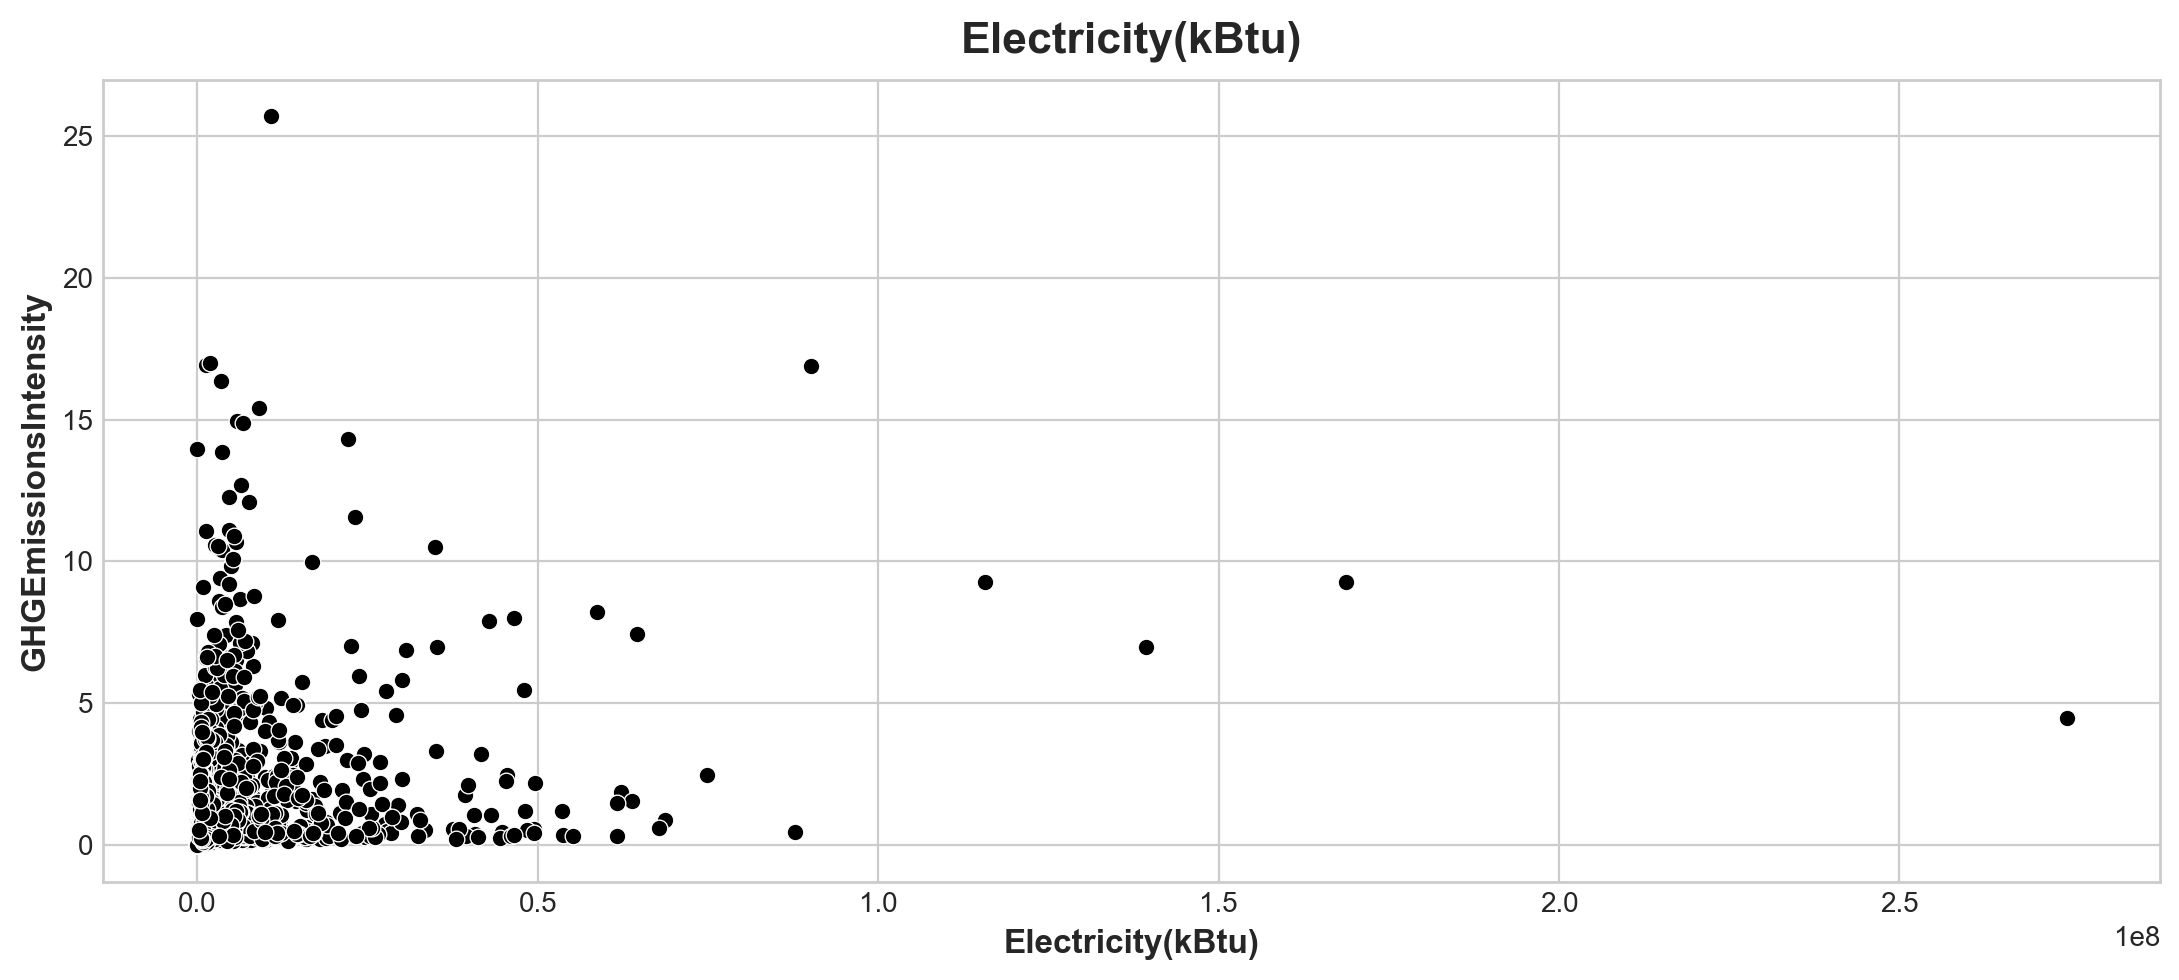

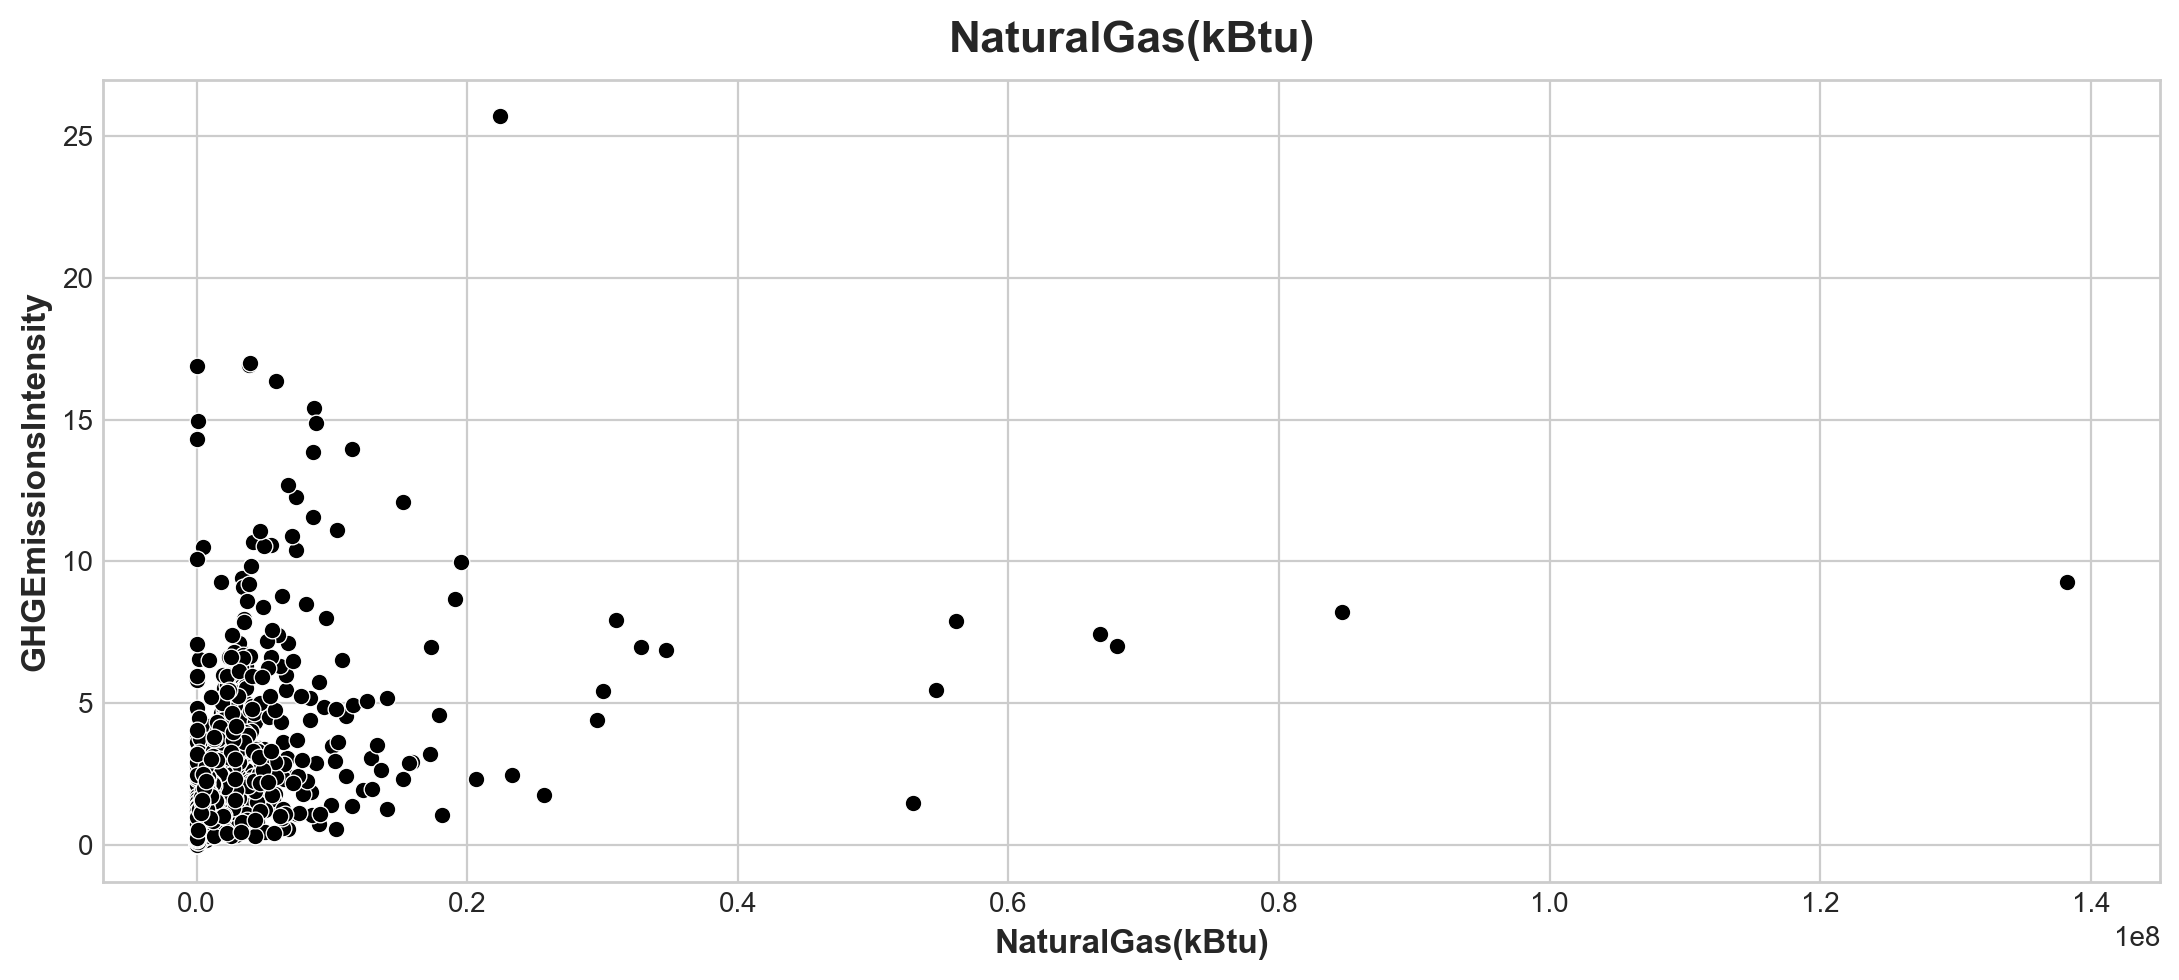

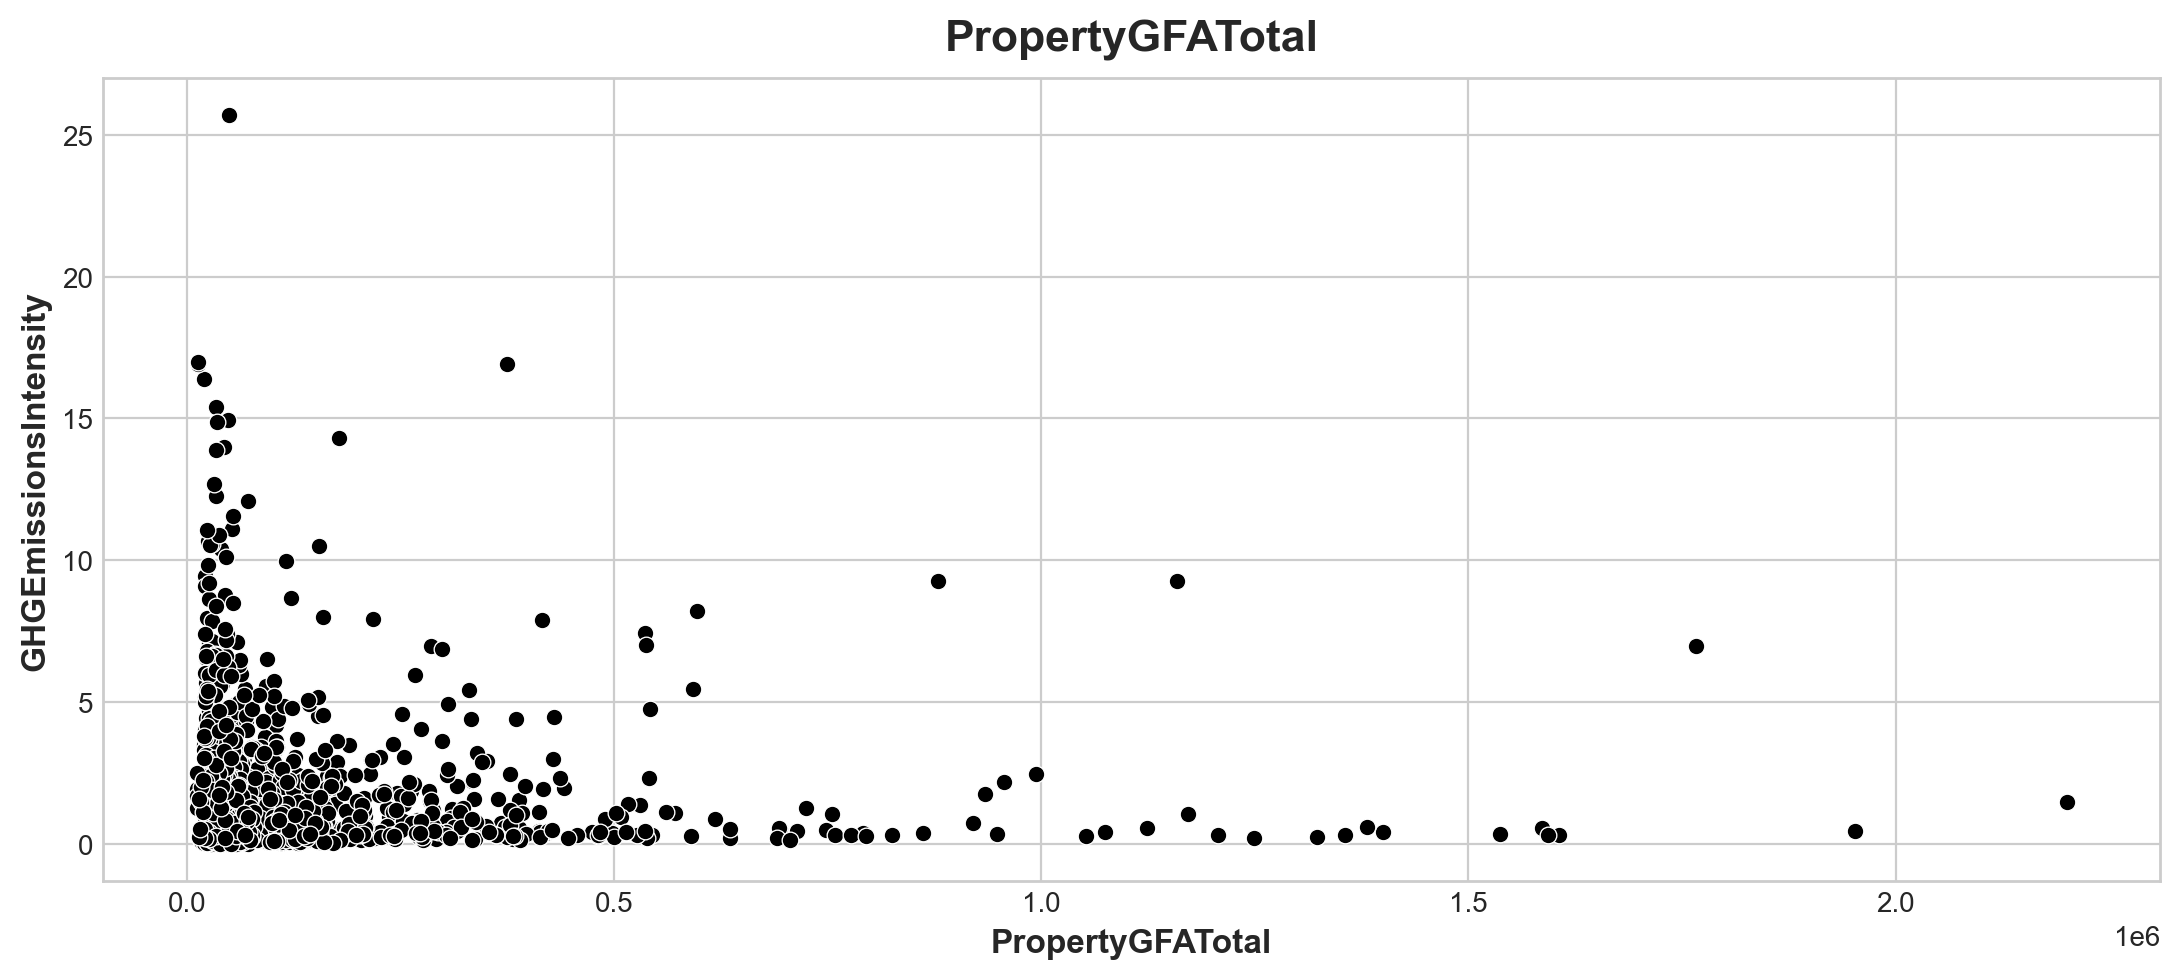

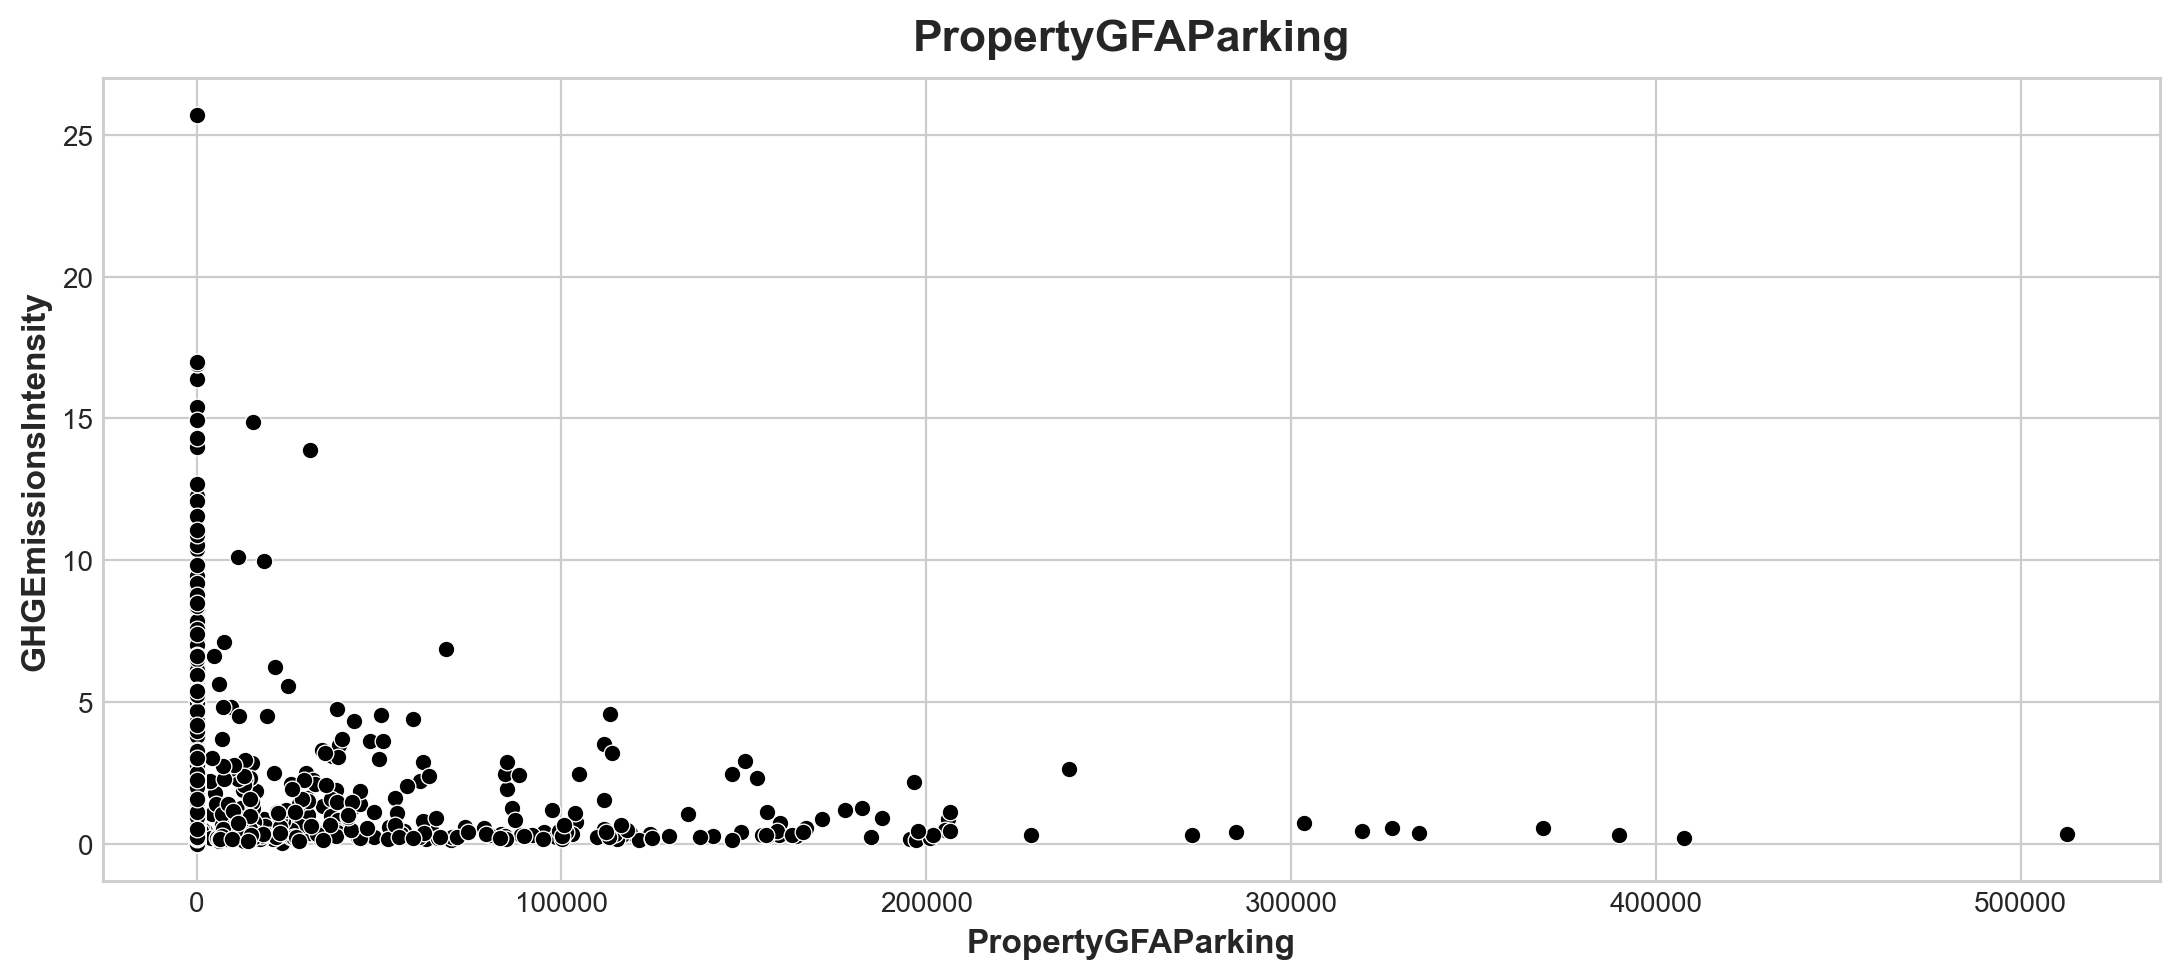

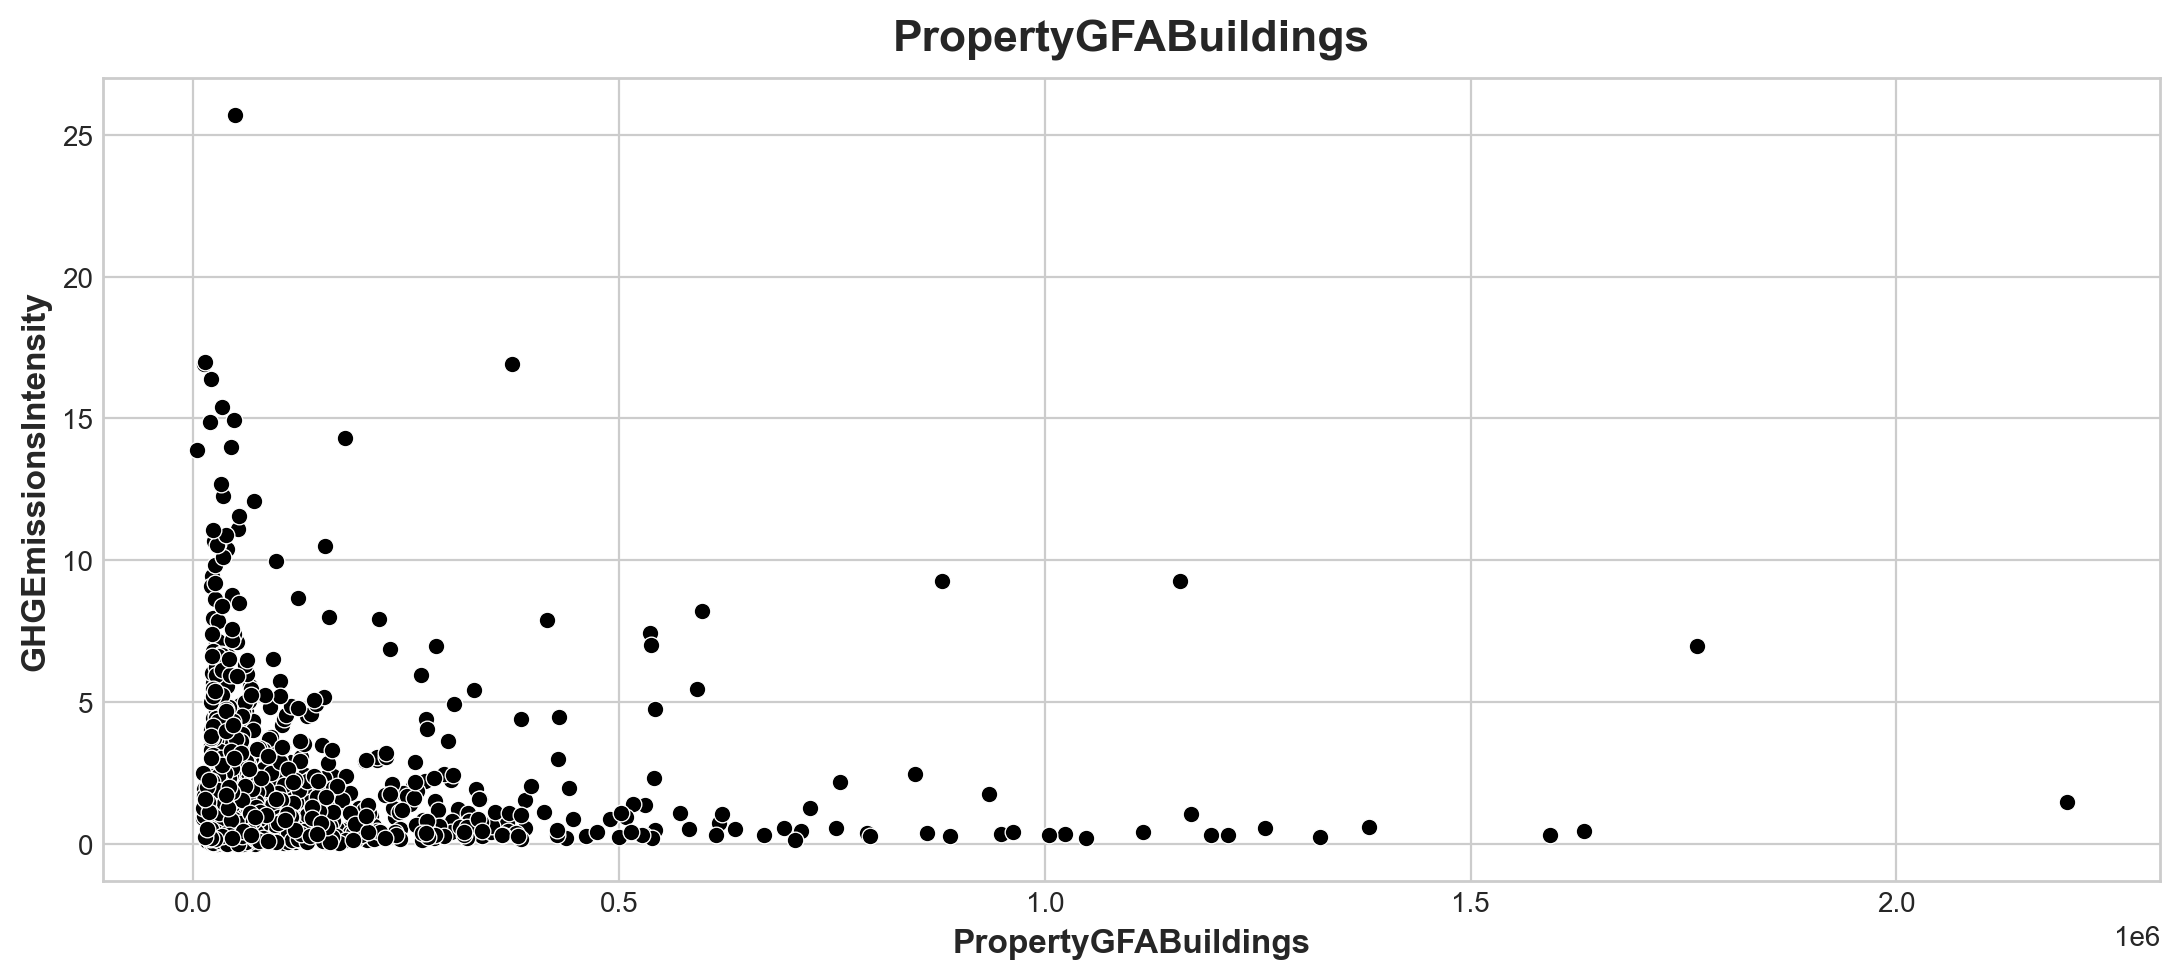

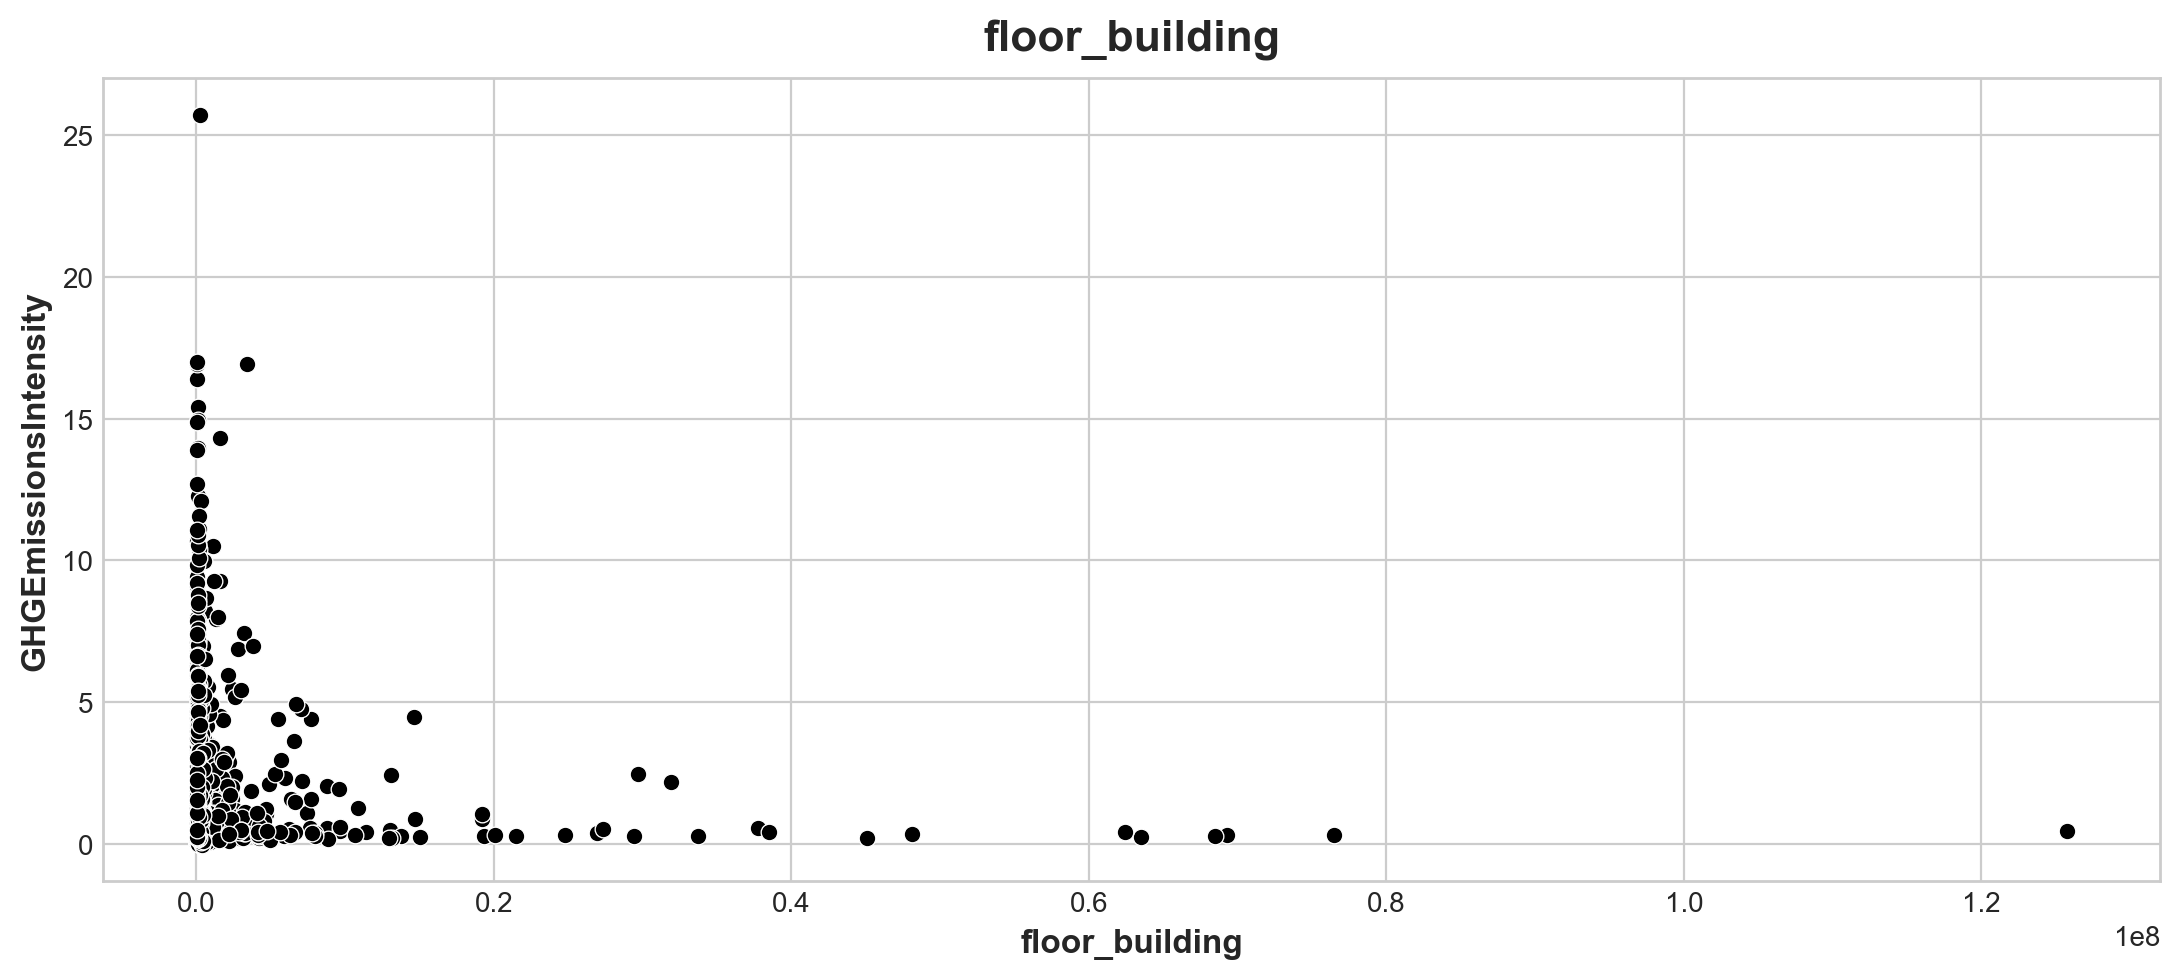

In [43]:
for col_num in cols_num :
    scatter_test(col_num,'GHGEmissionsIntensity')

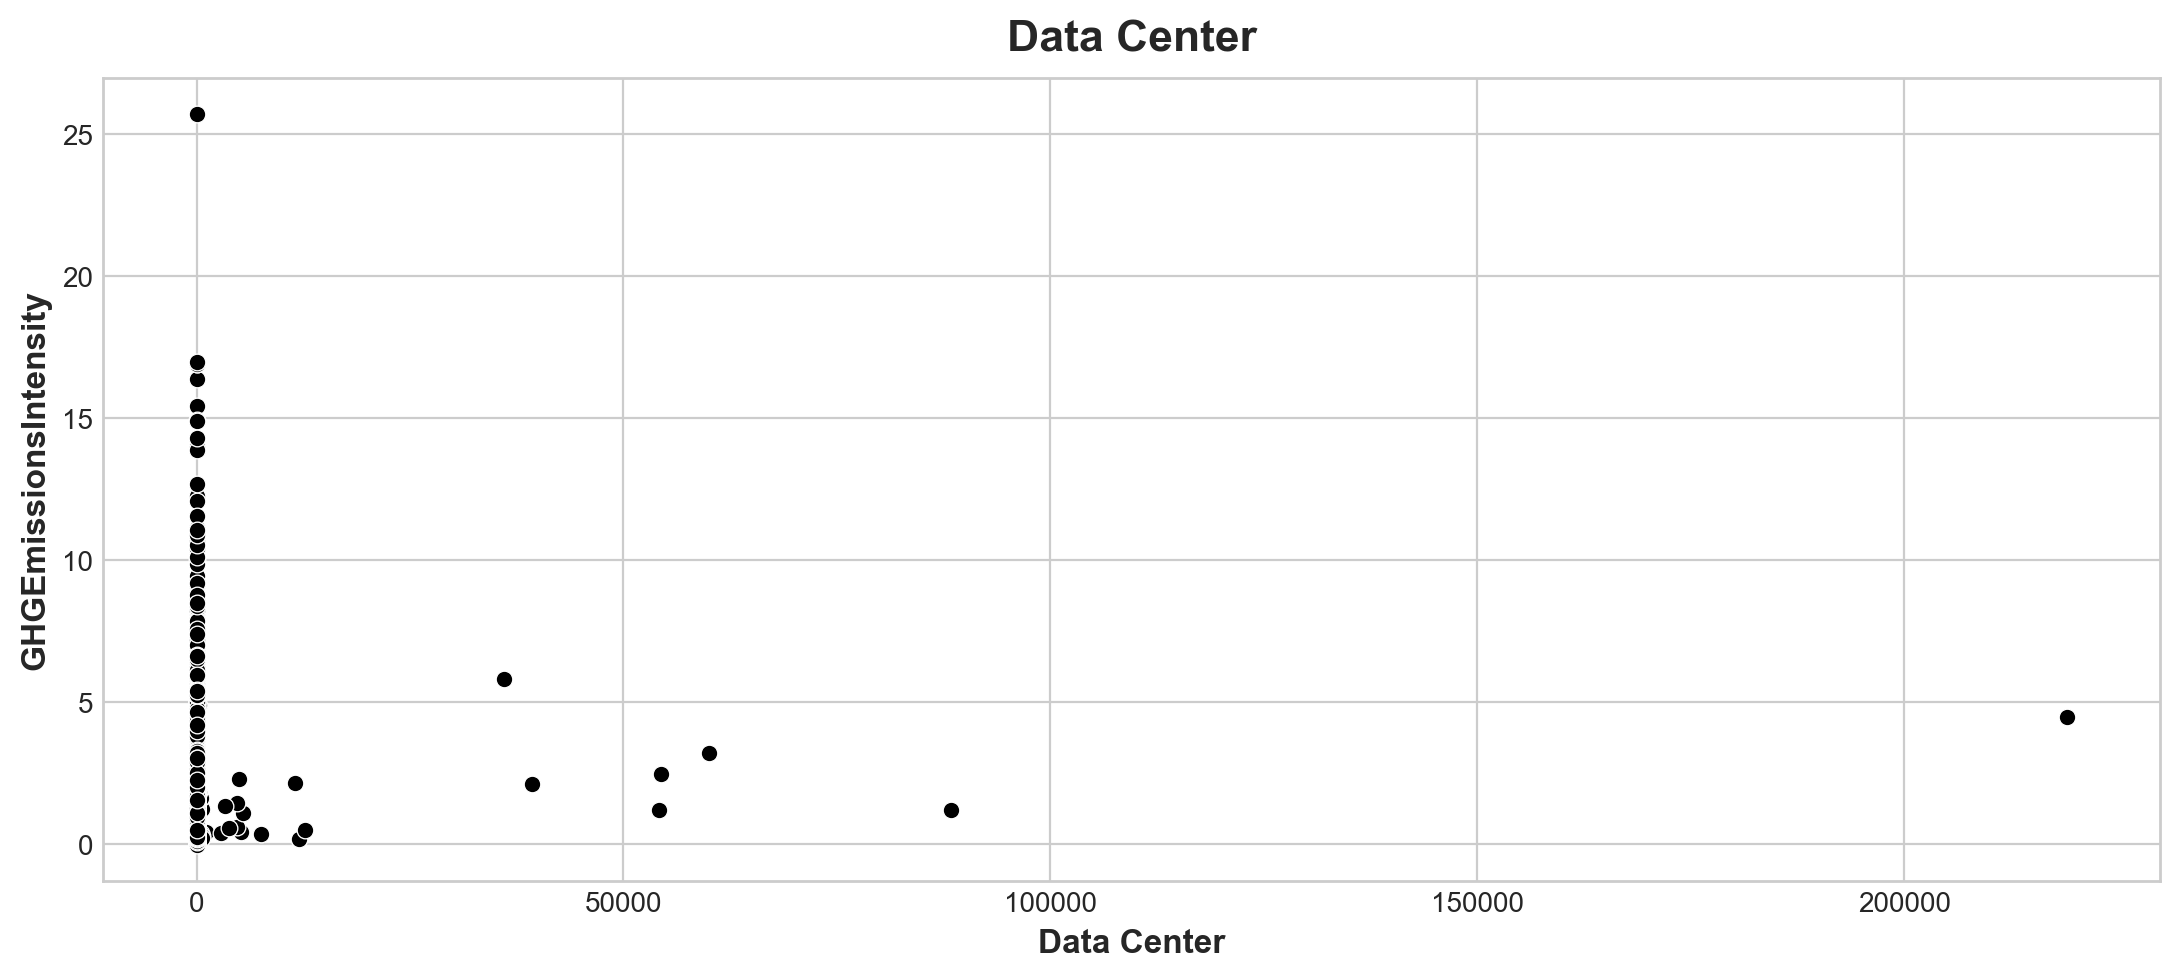

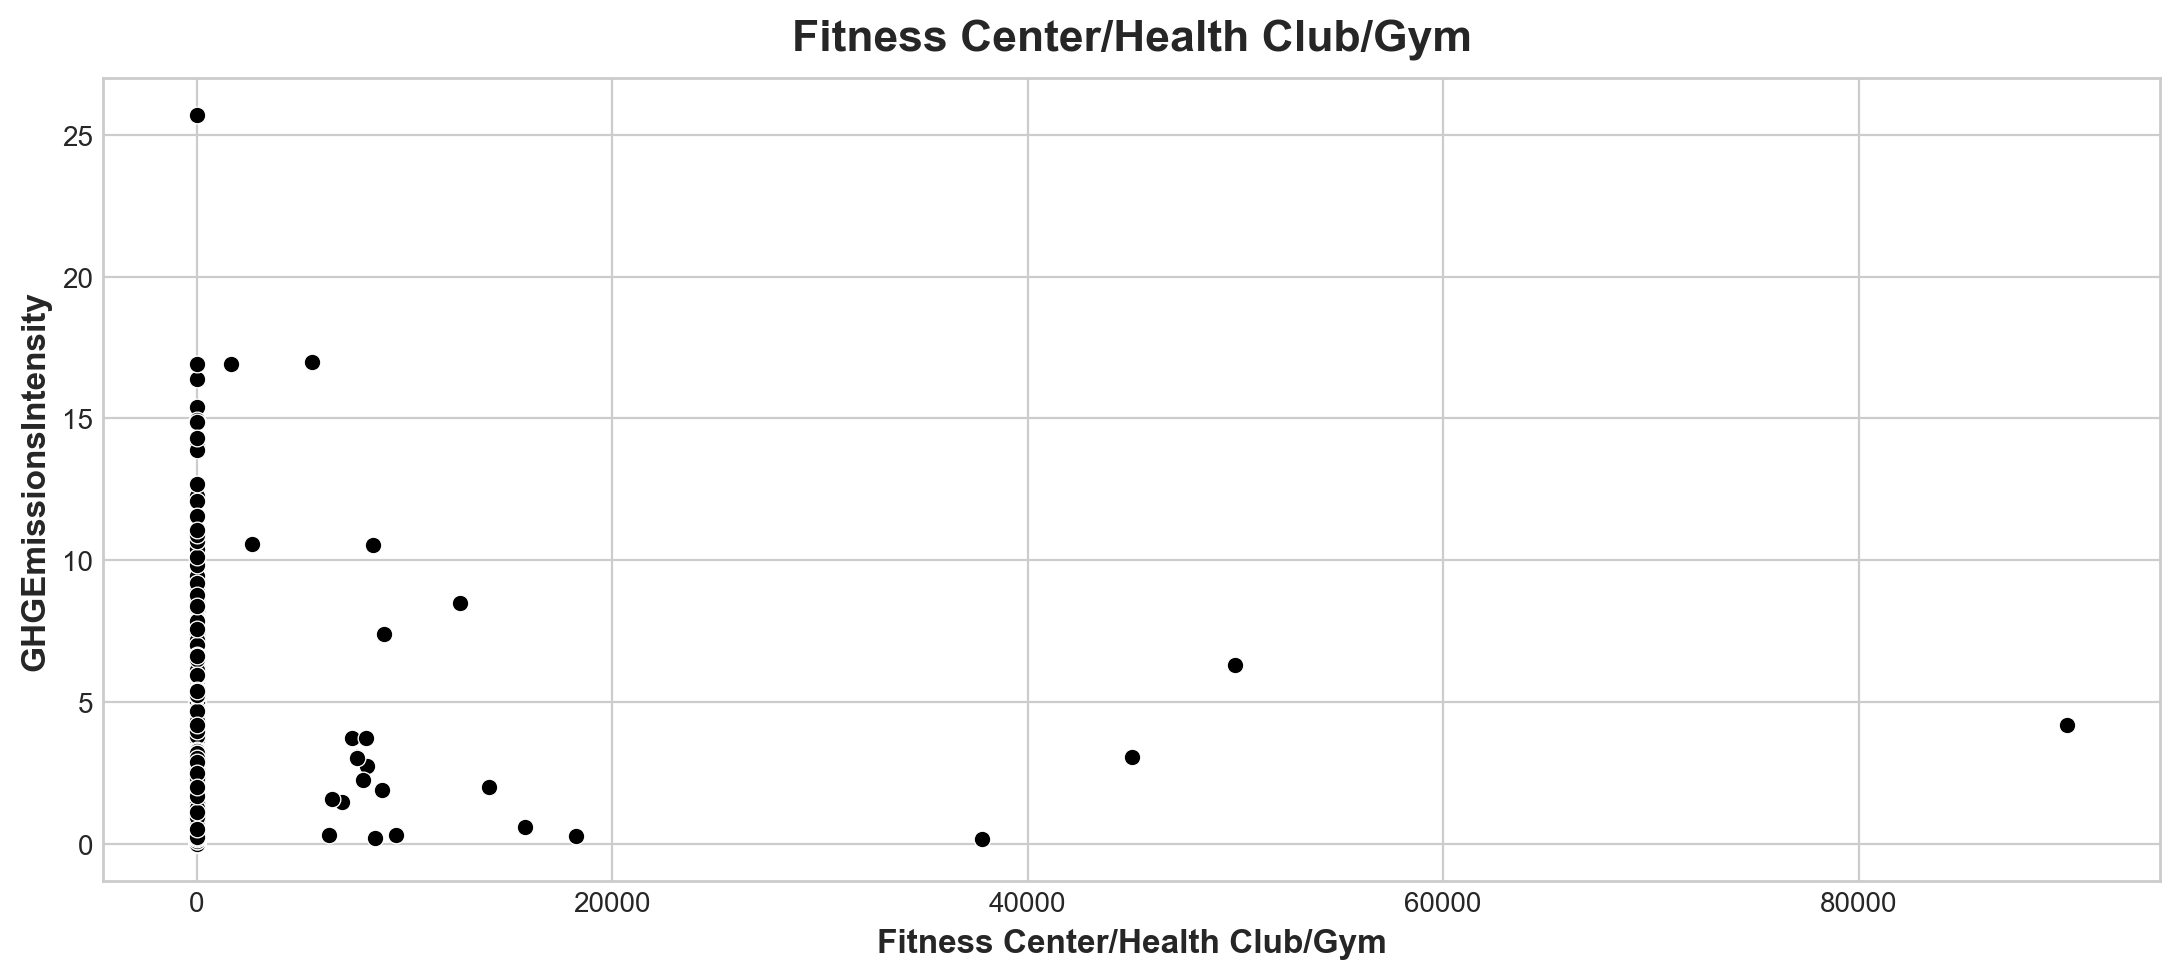

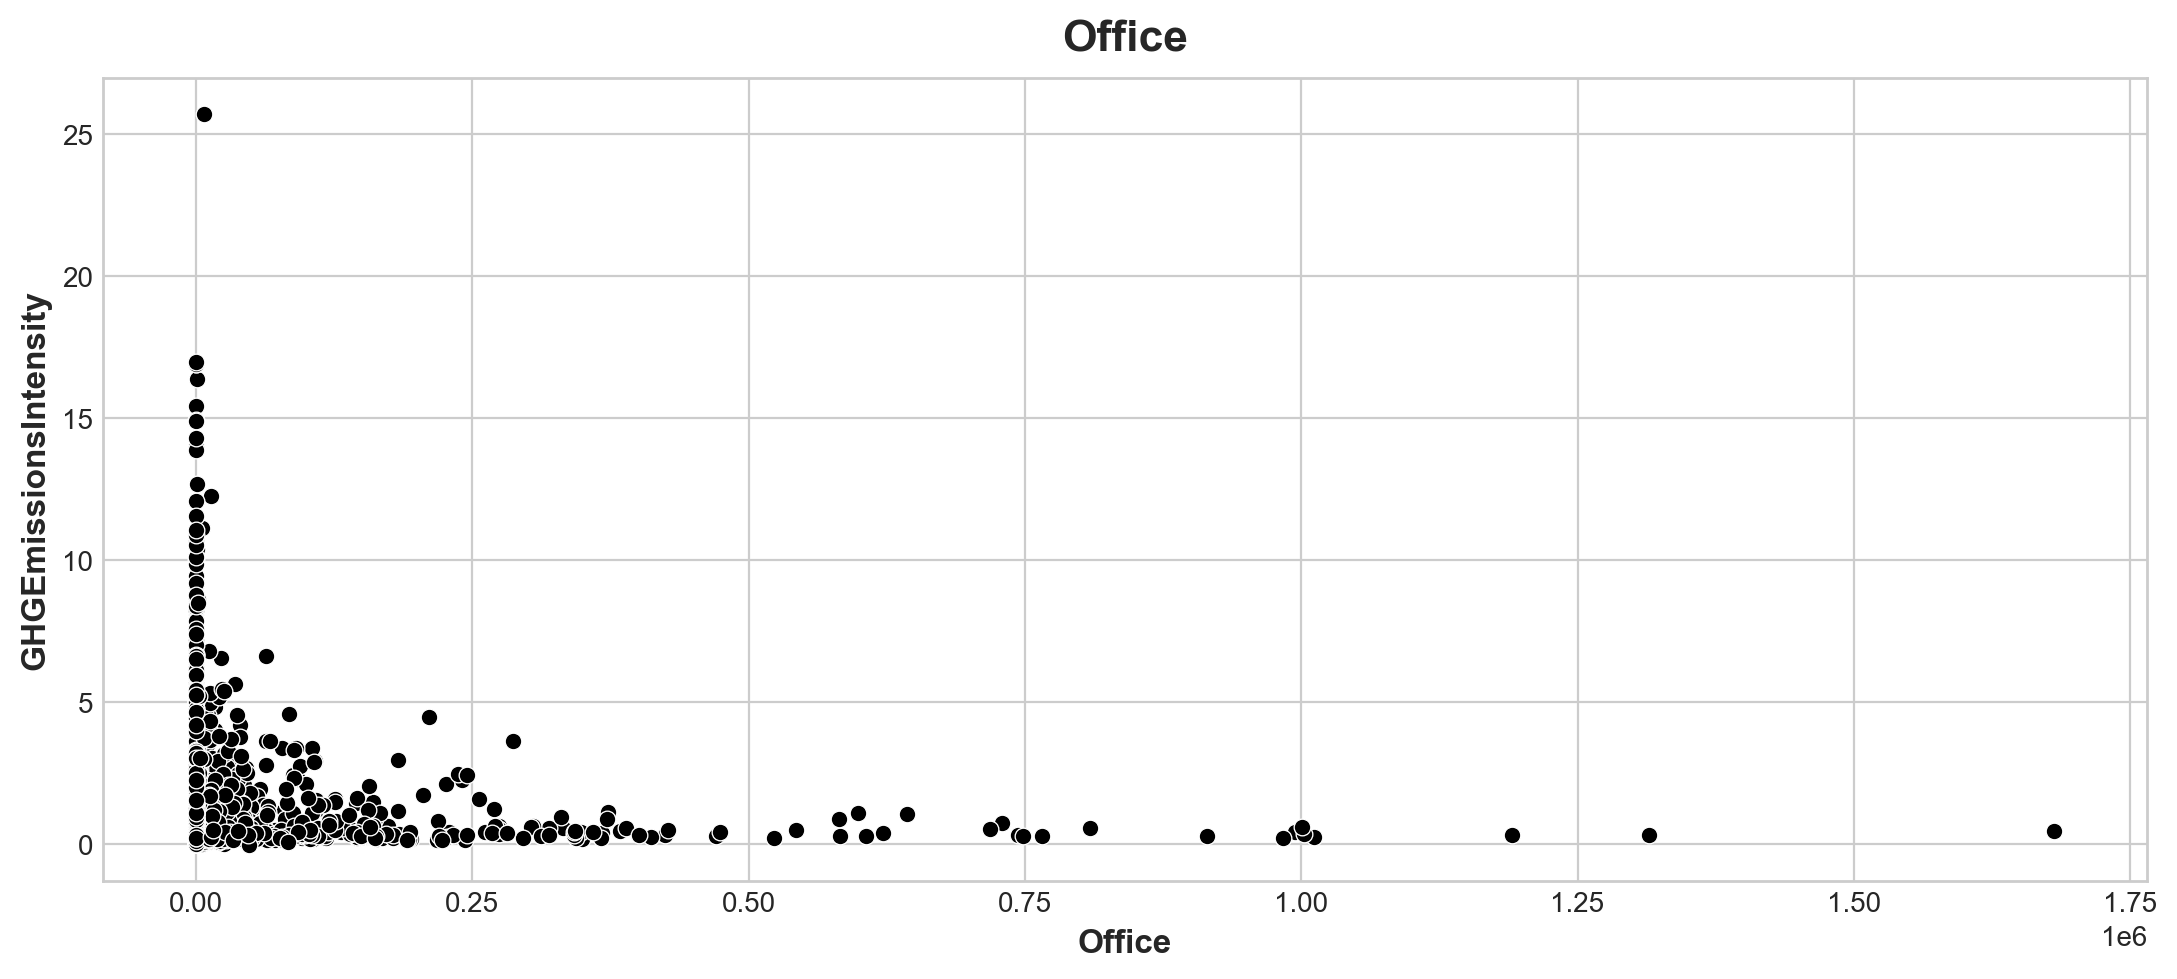

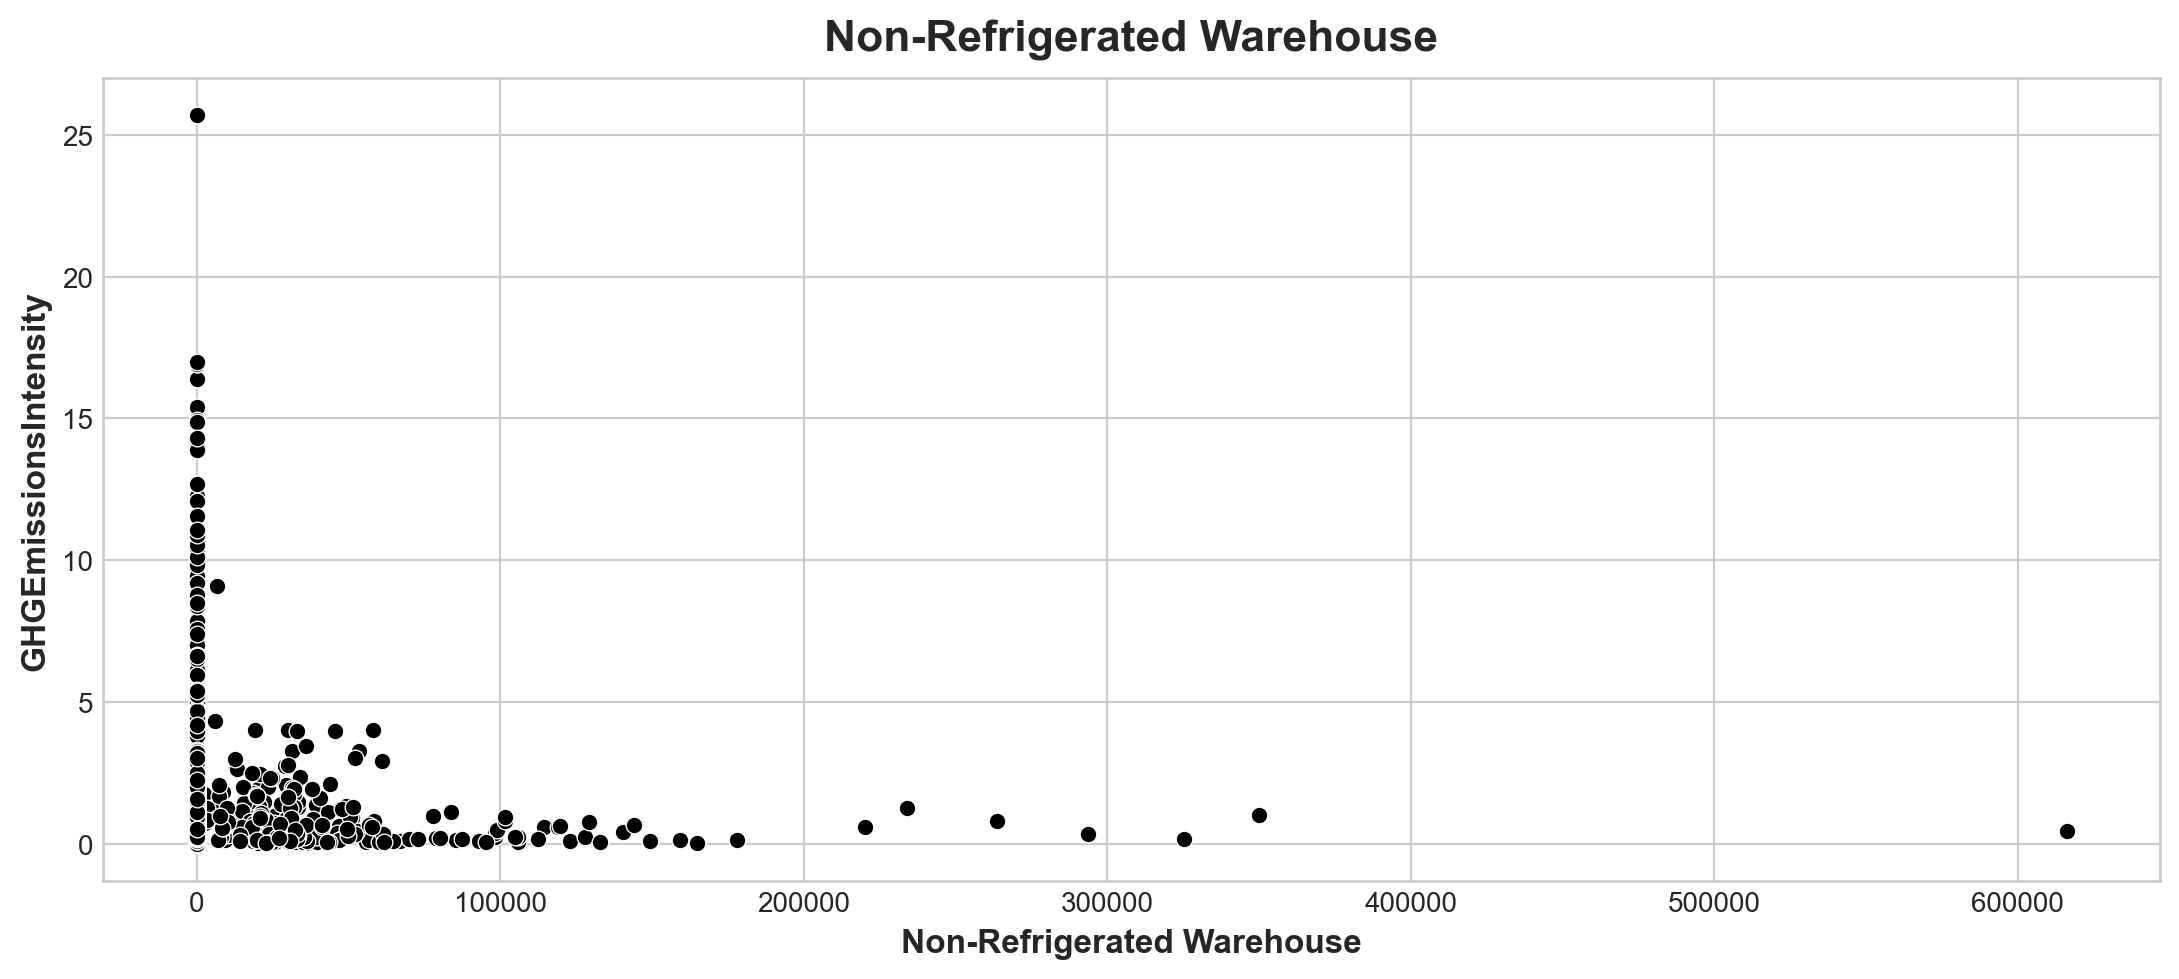

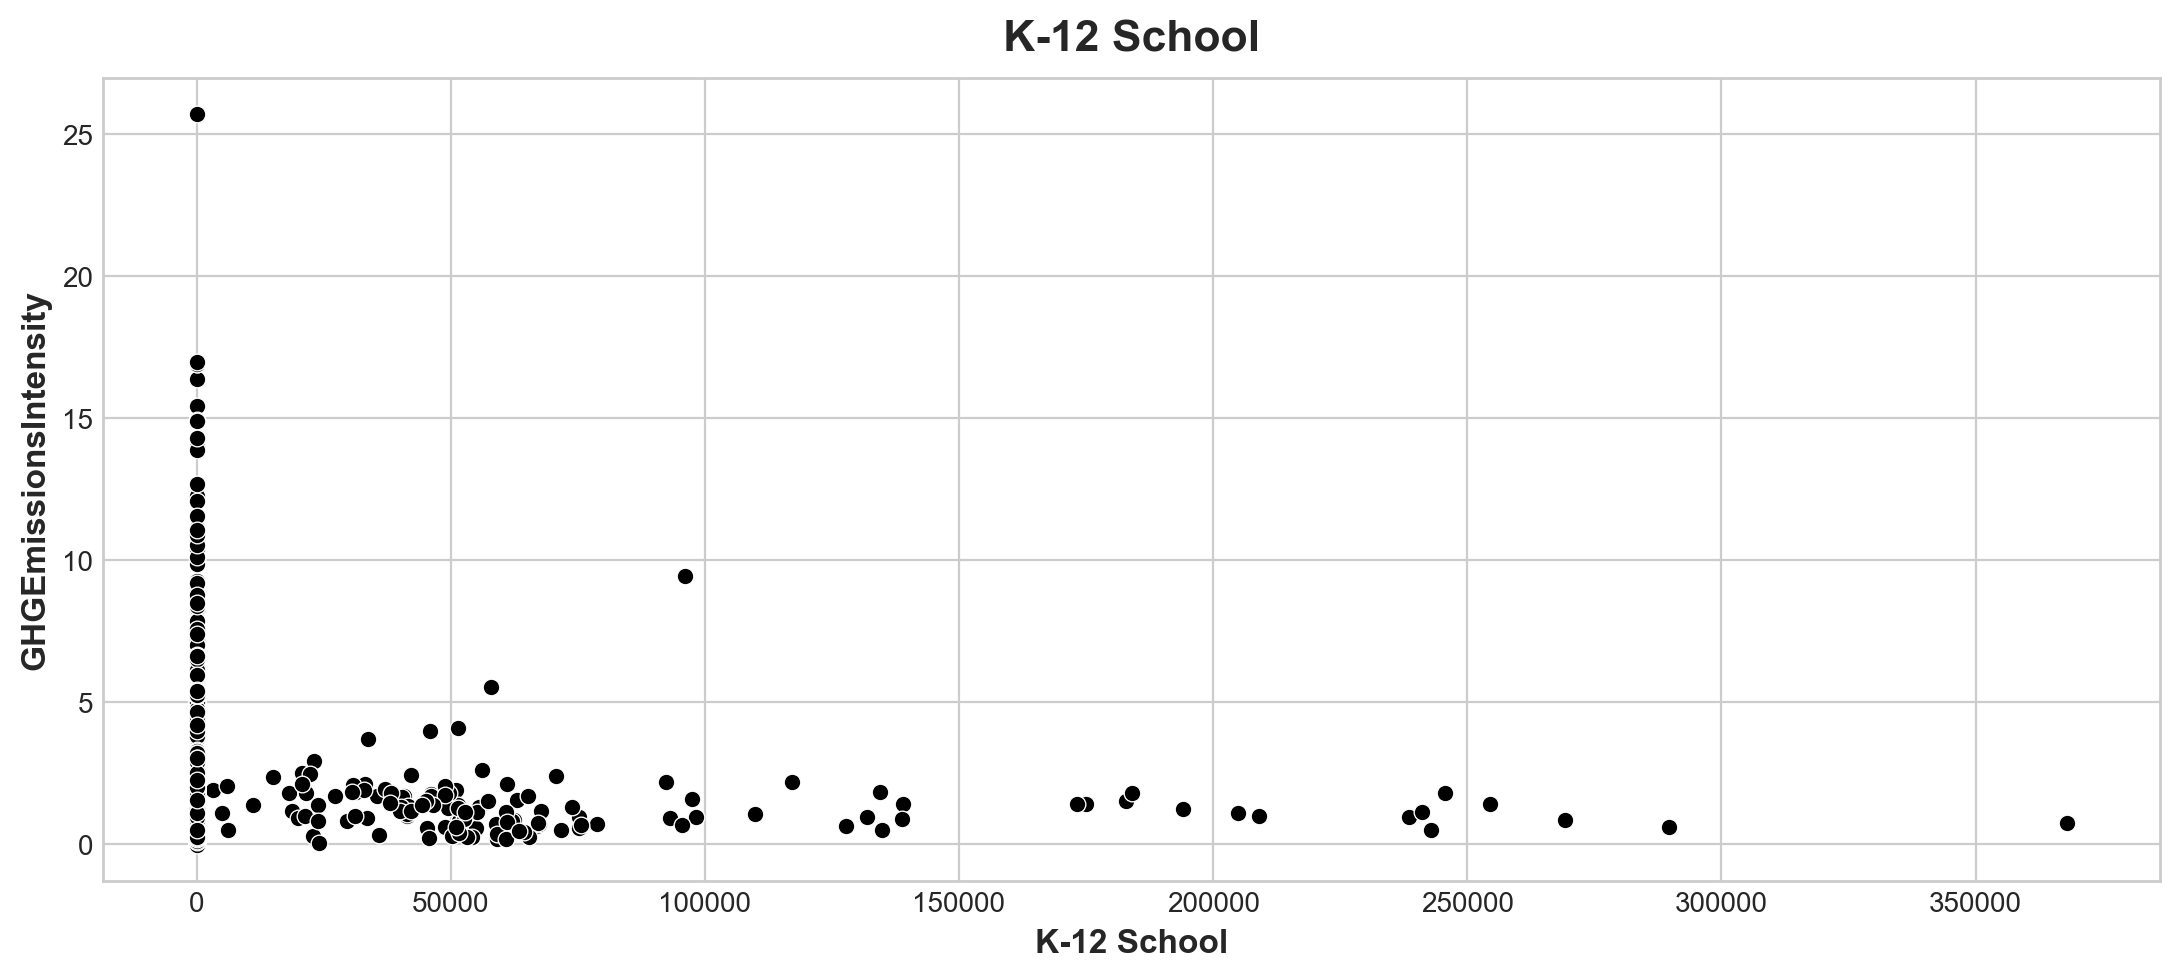

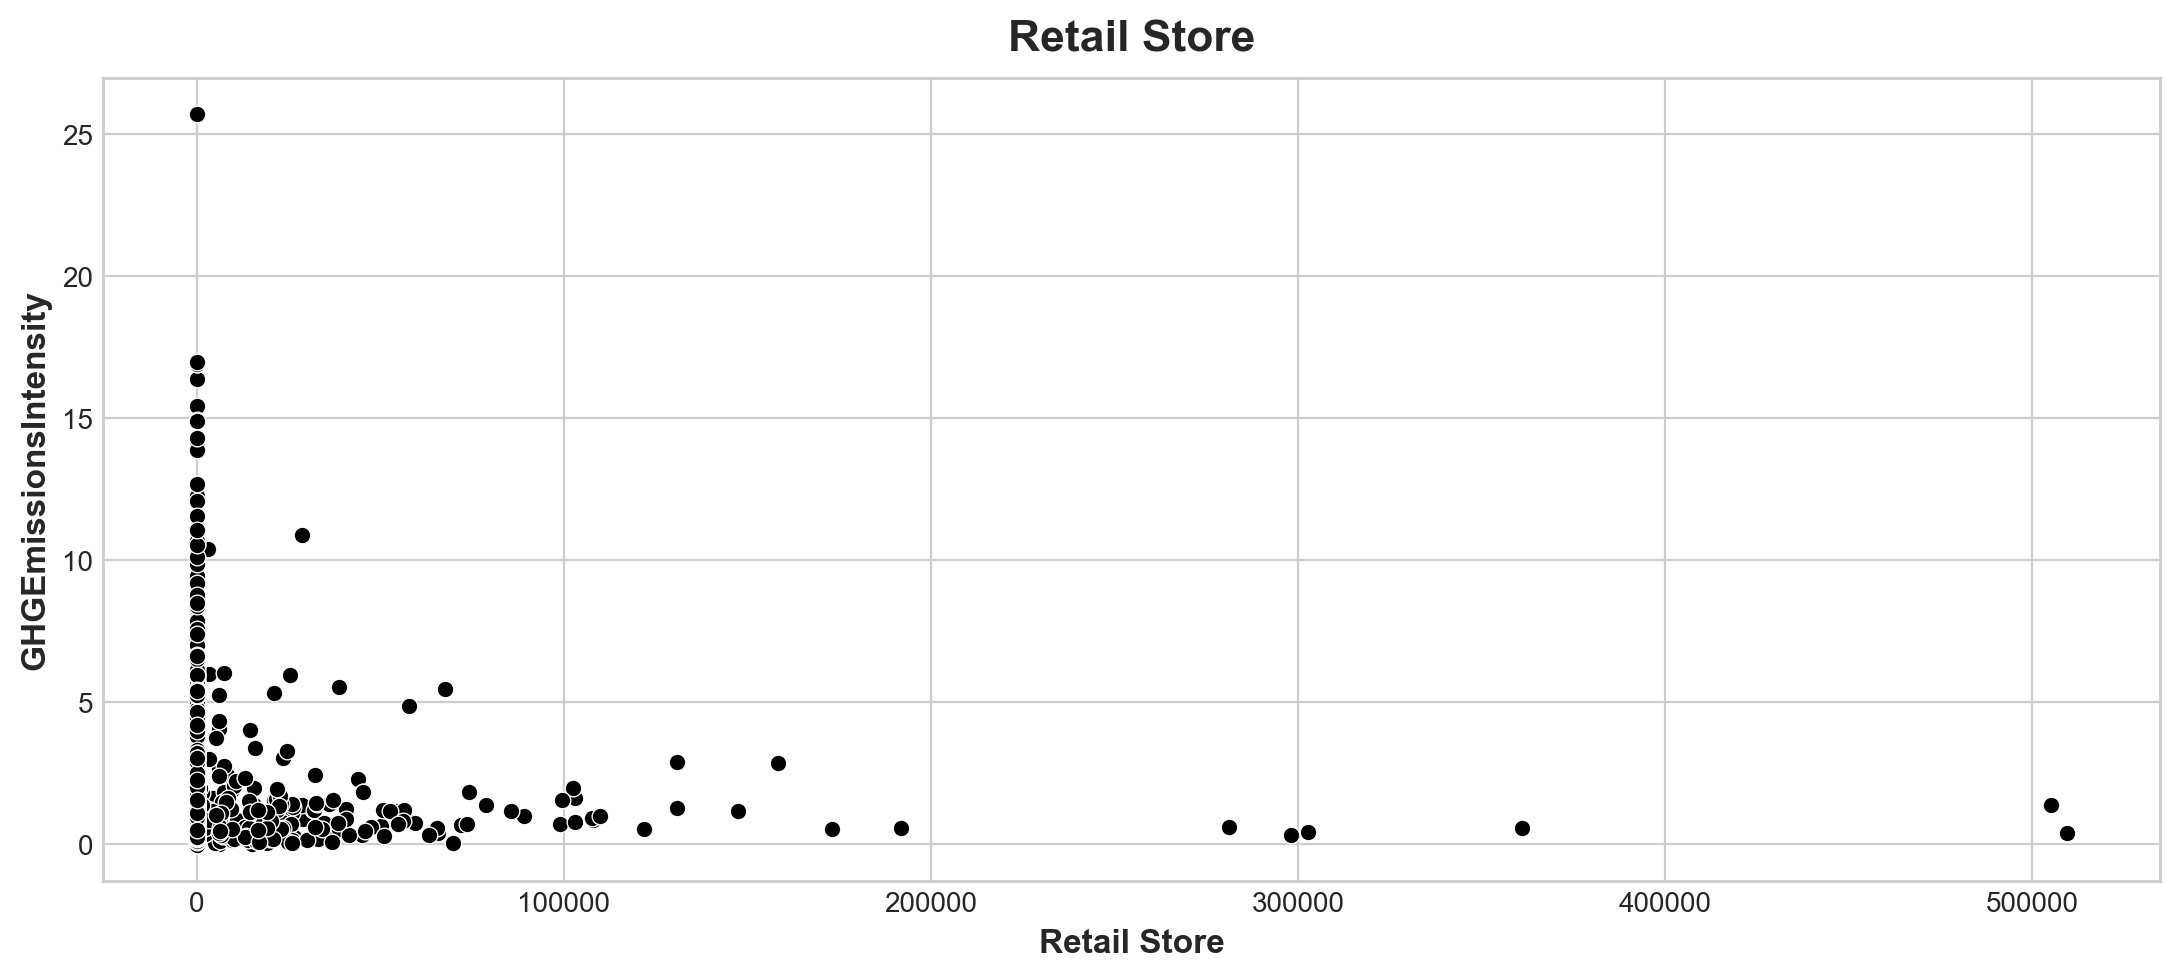

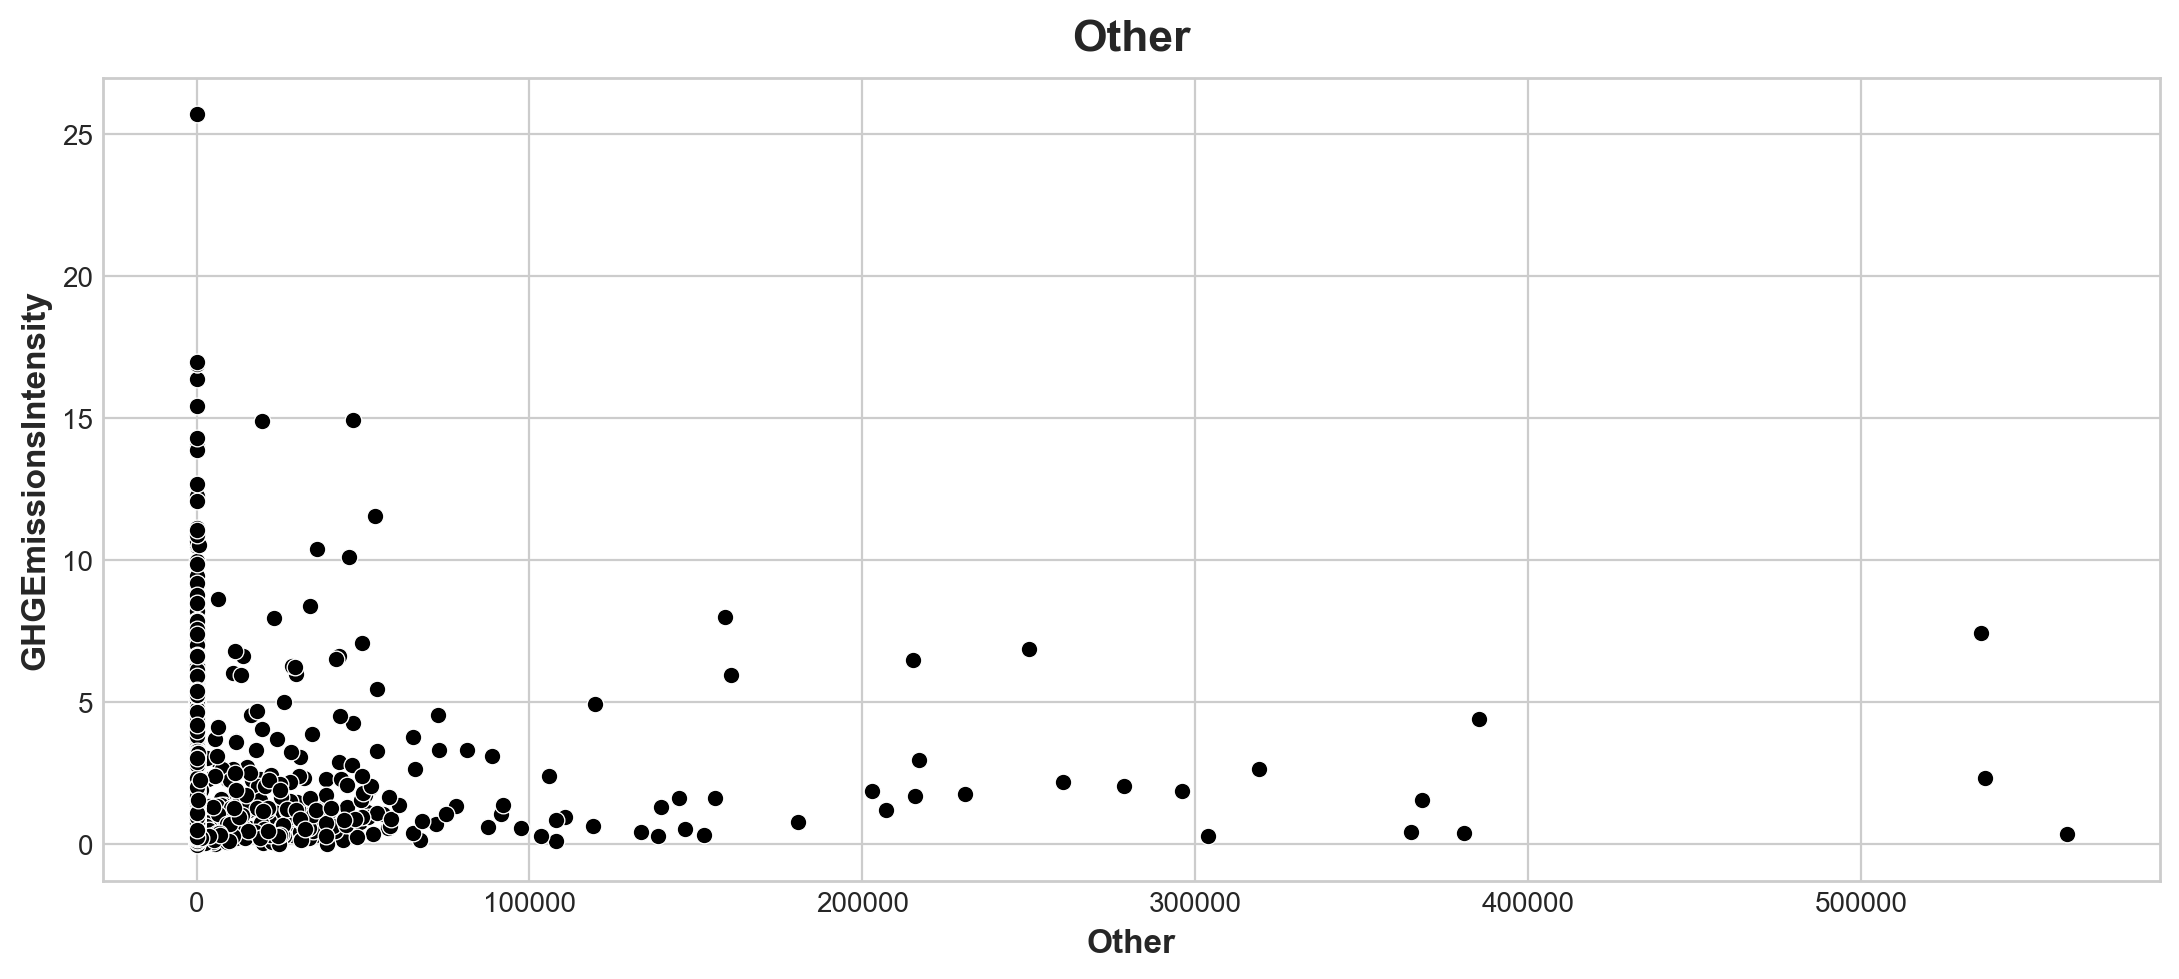

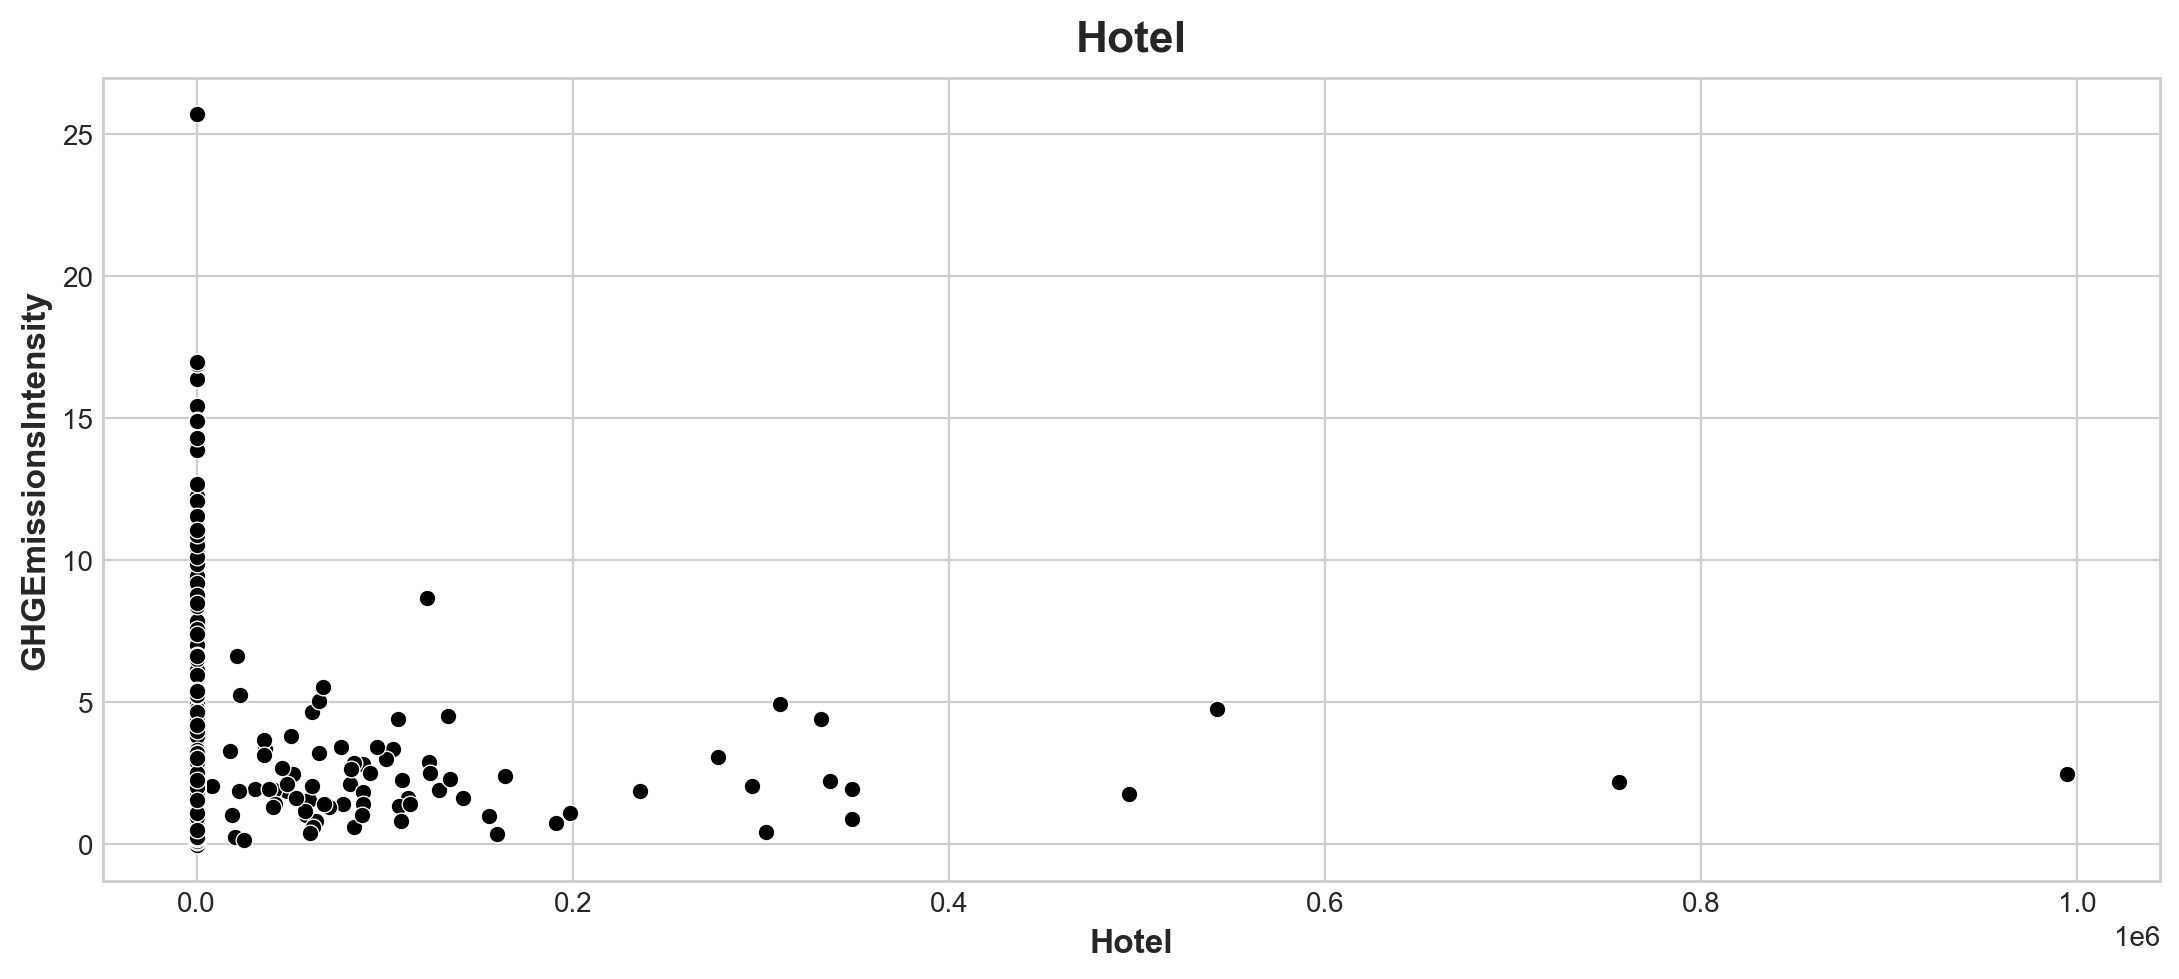

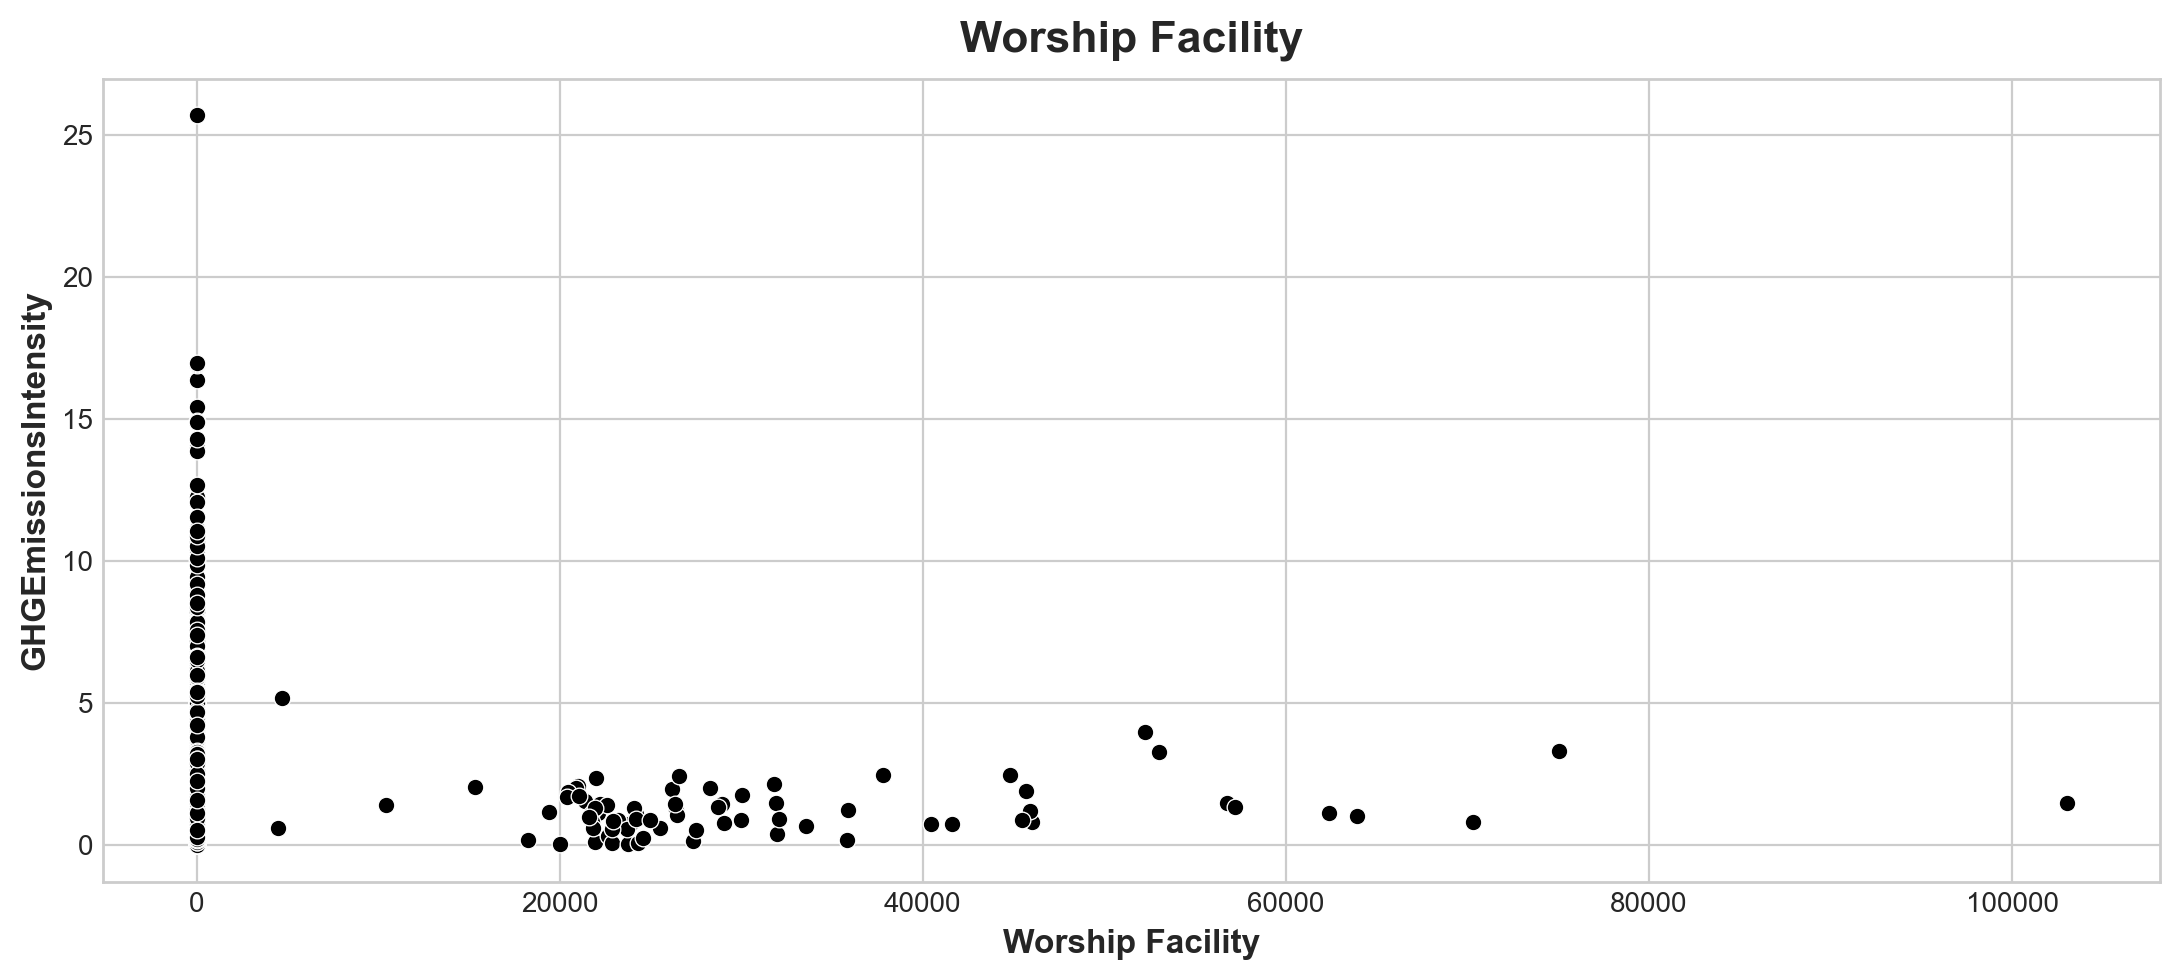

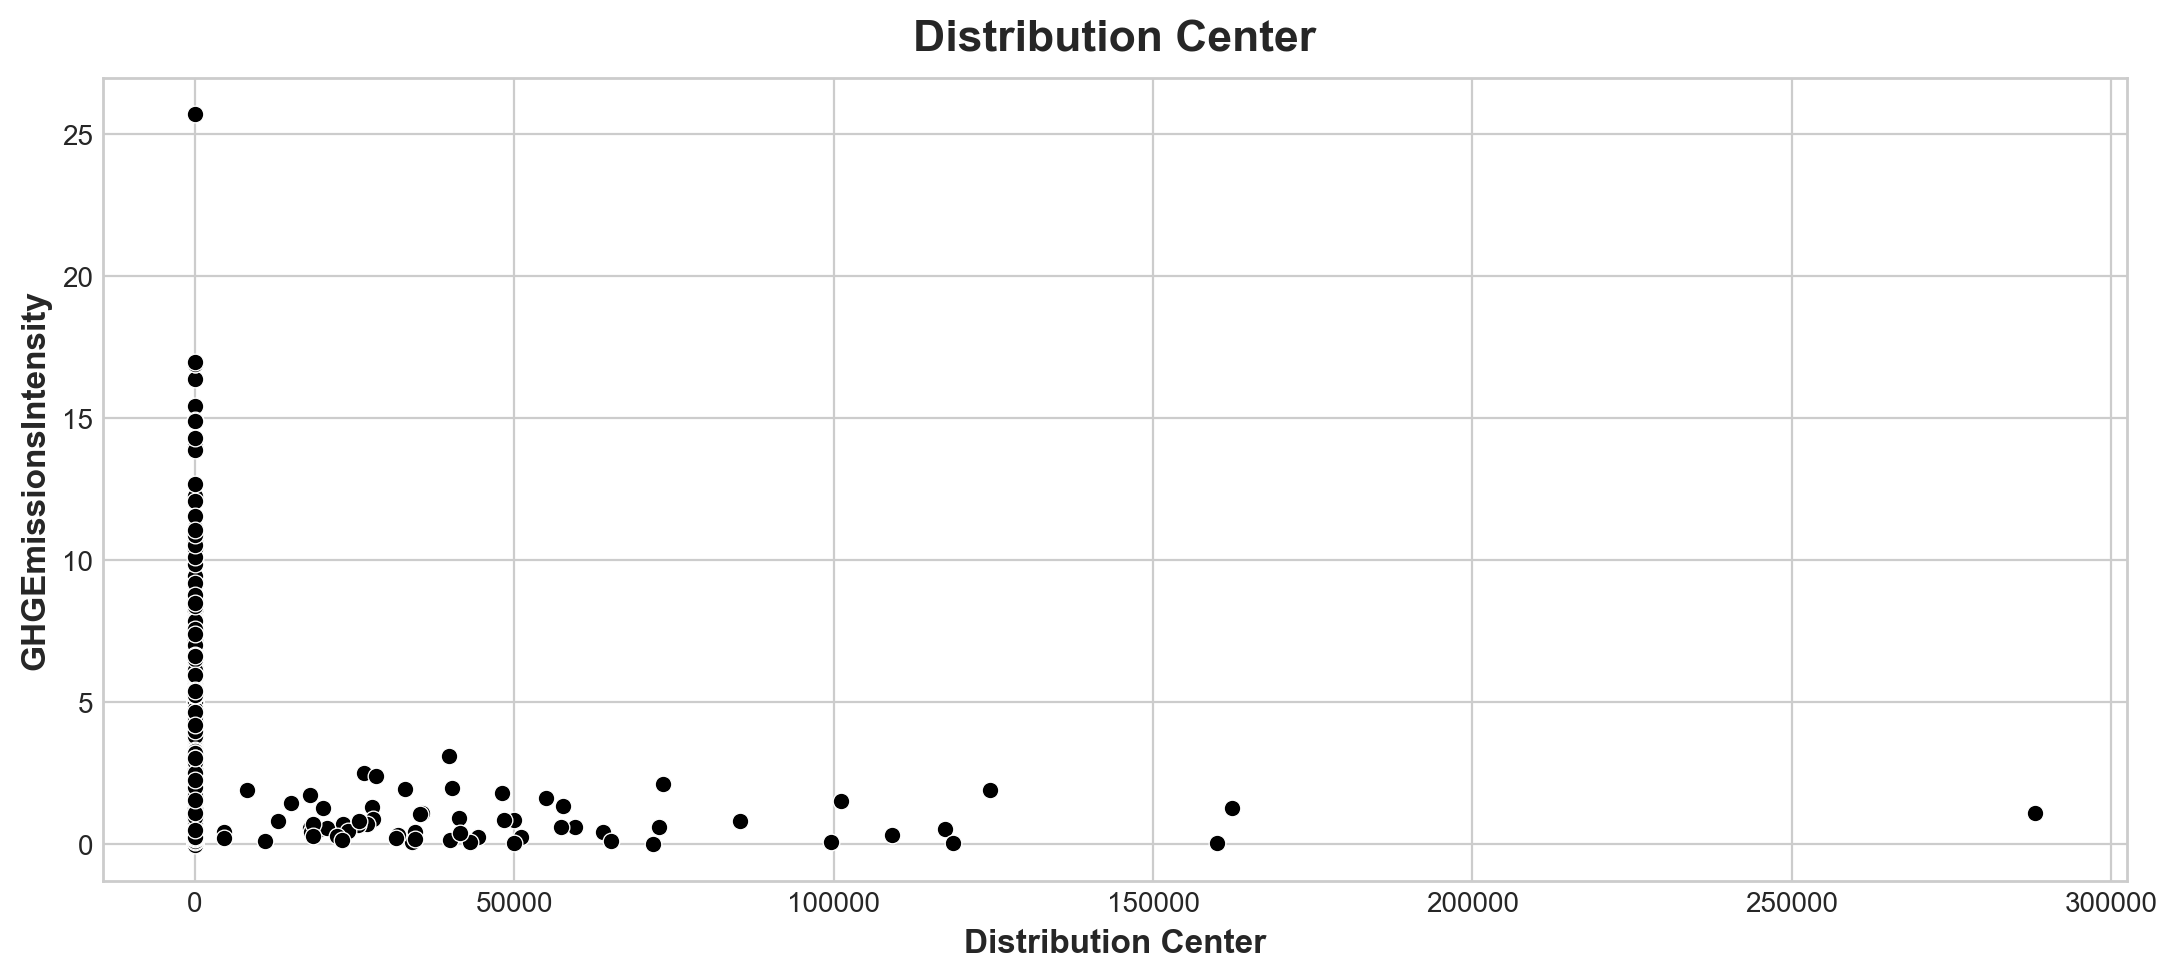

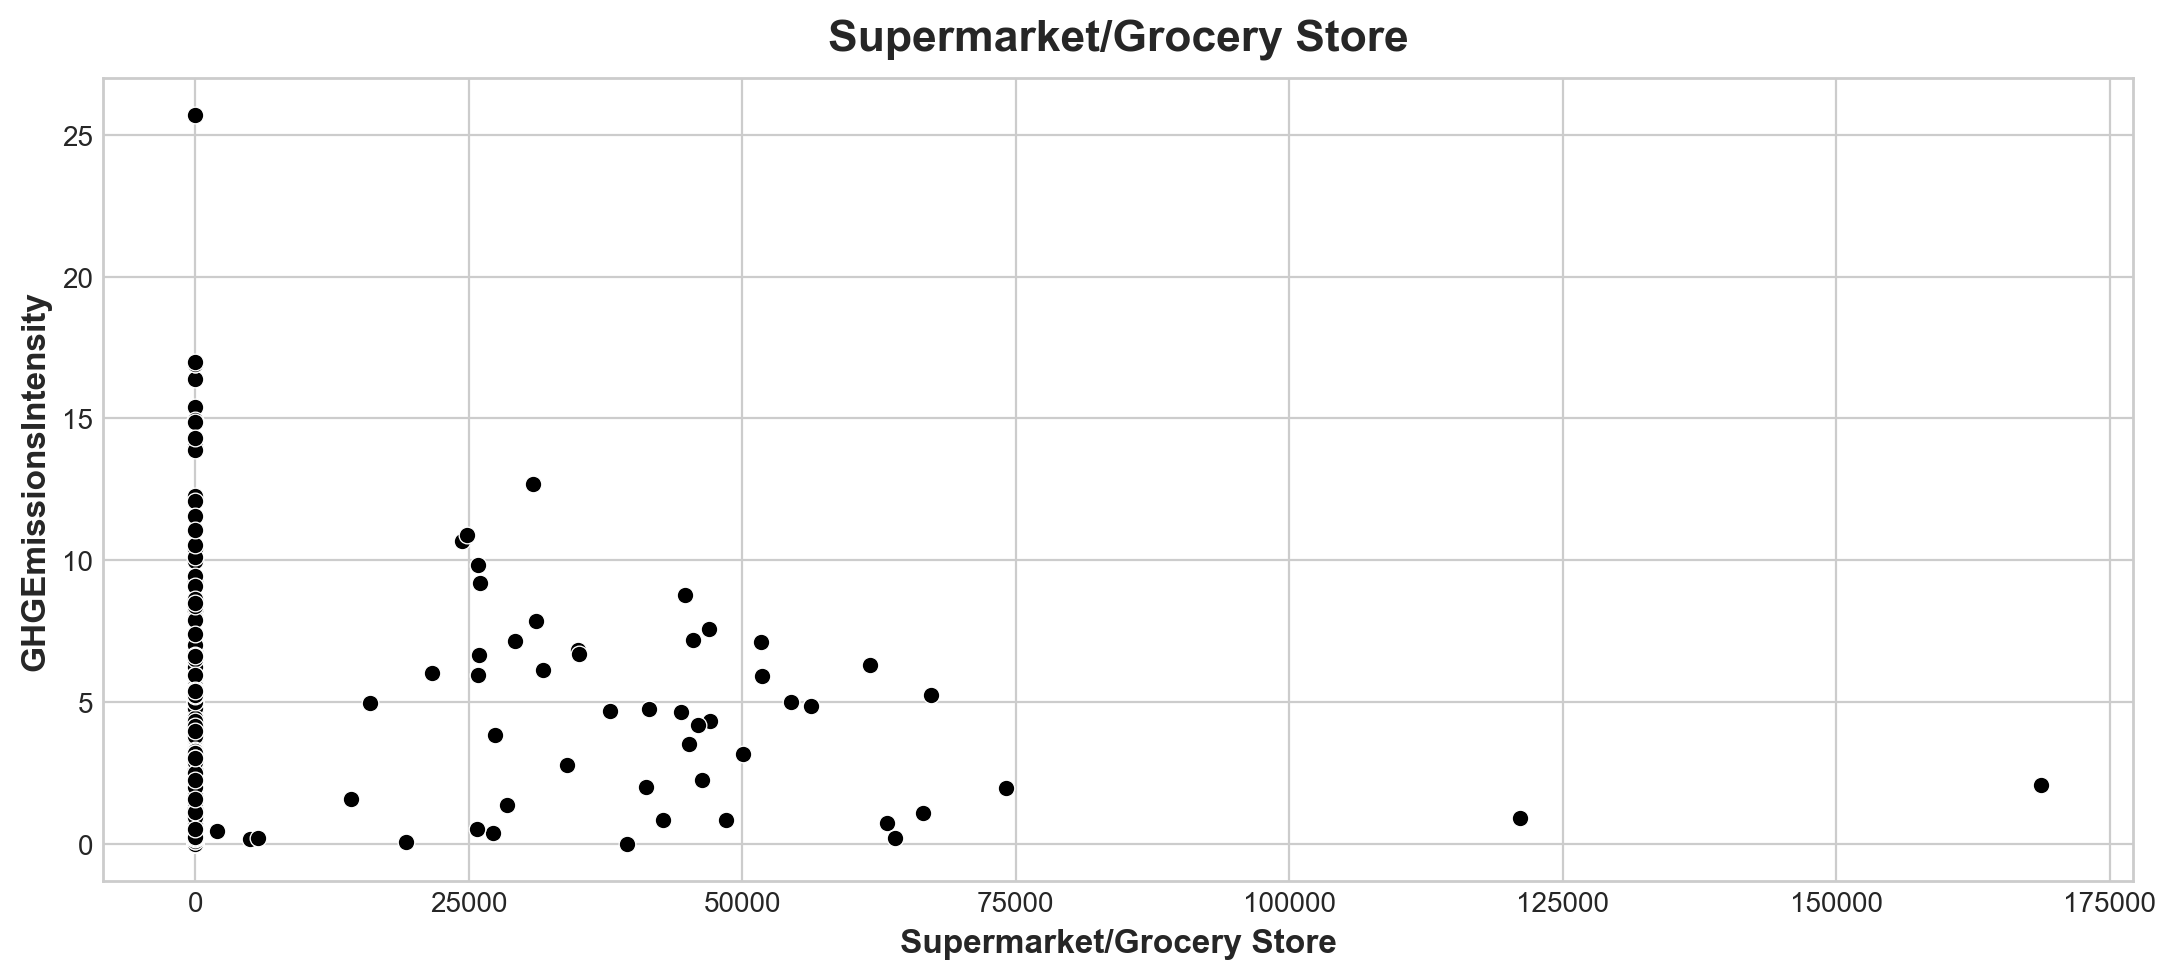

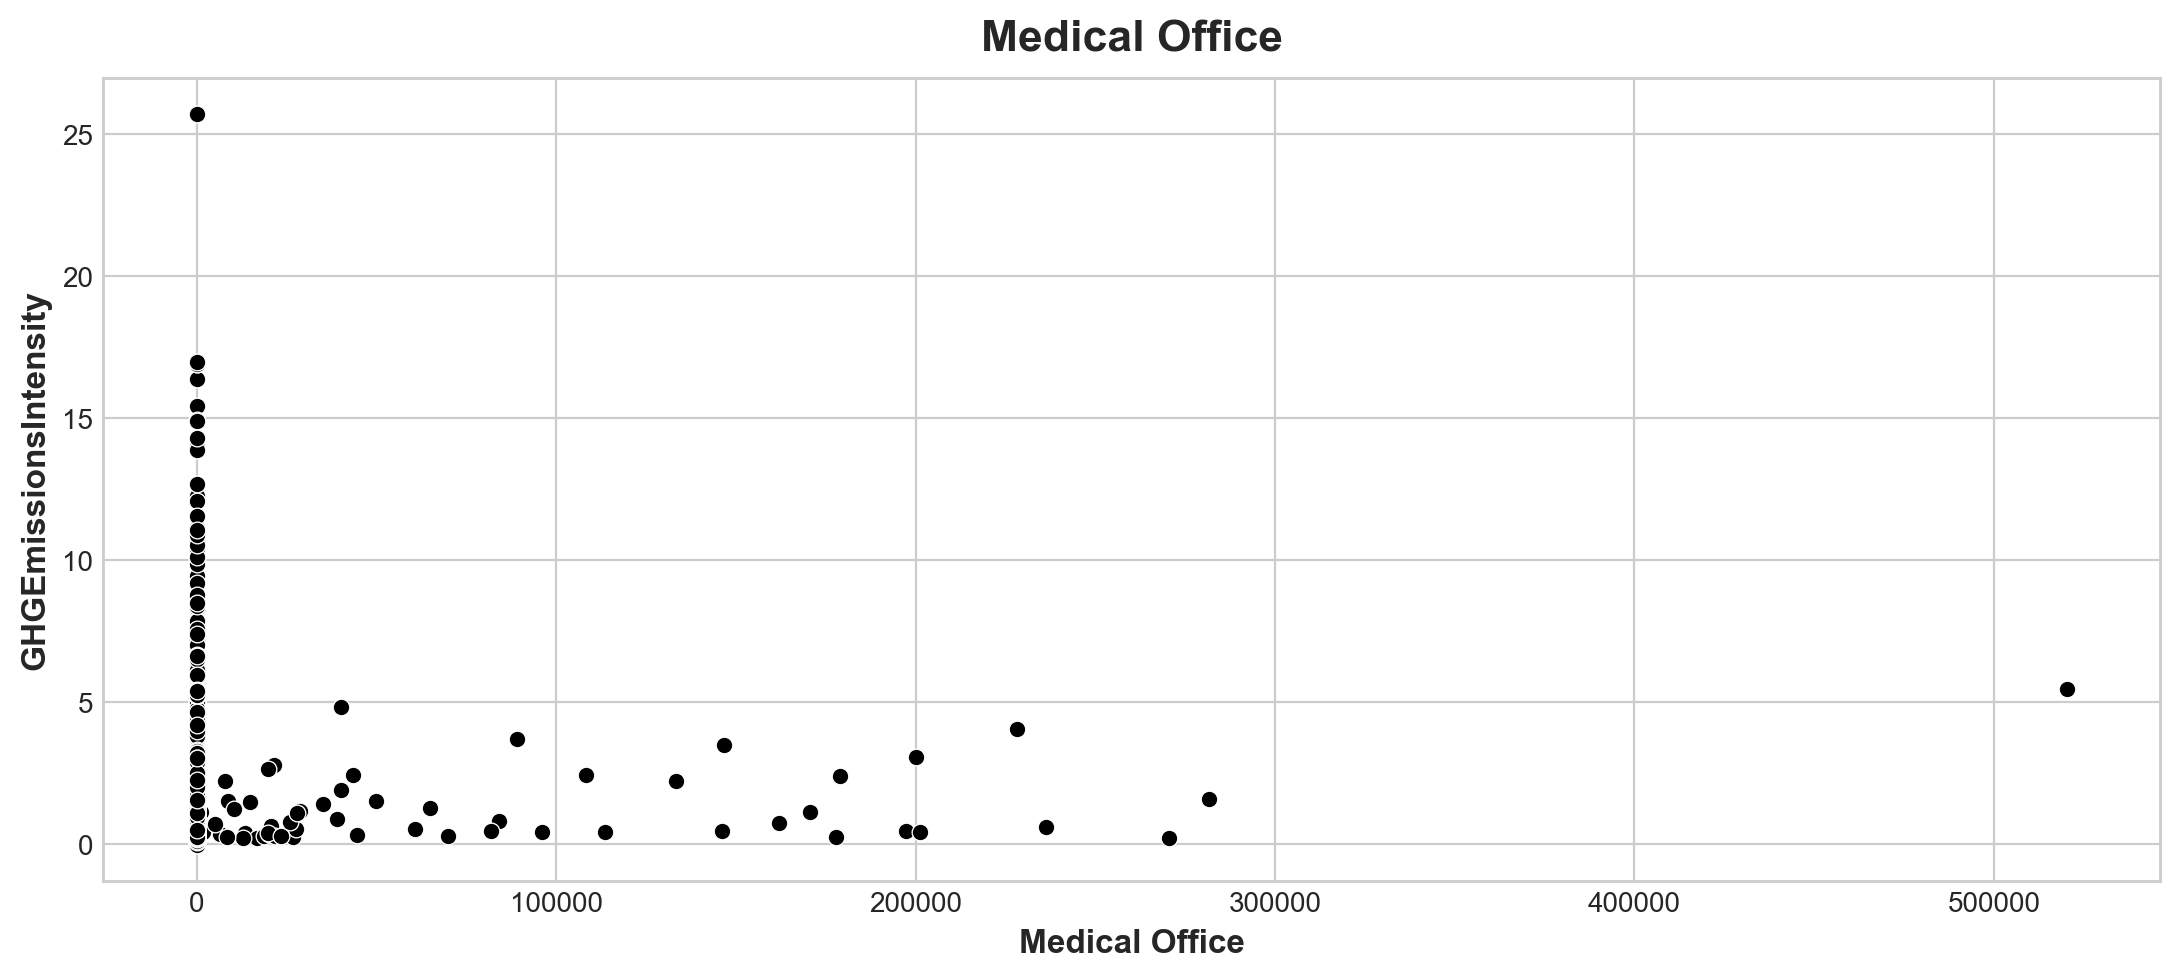

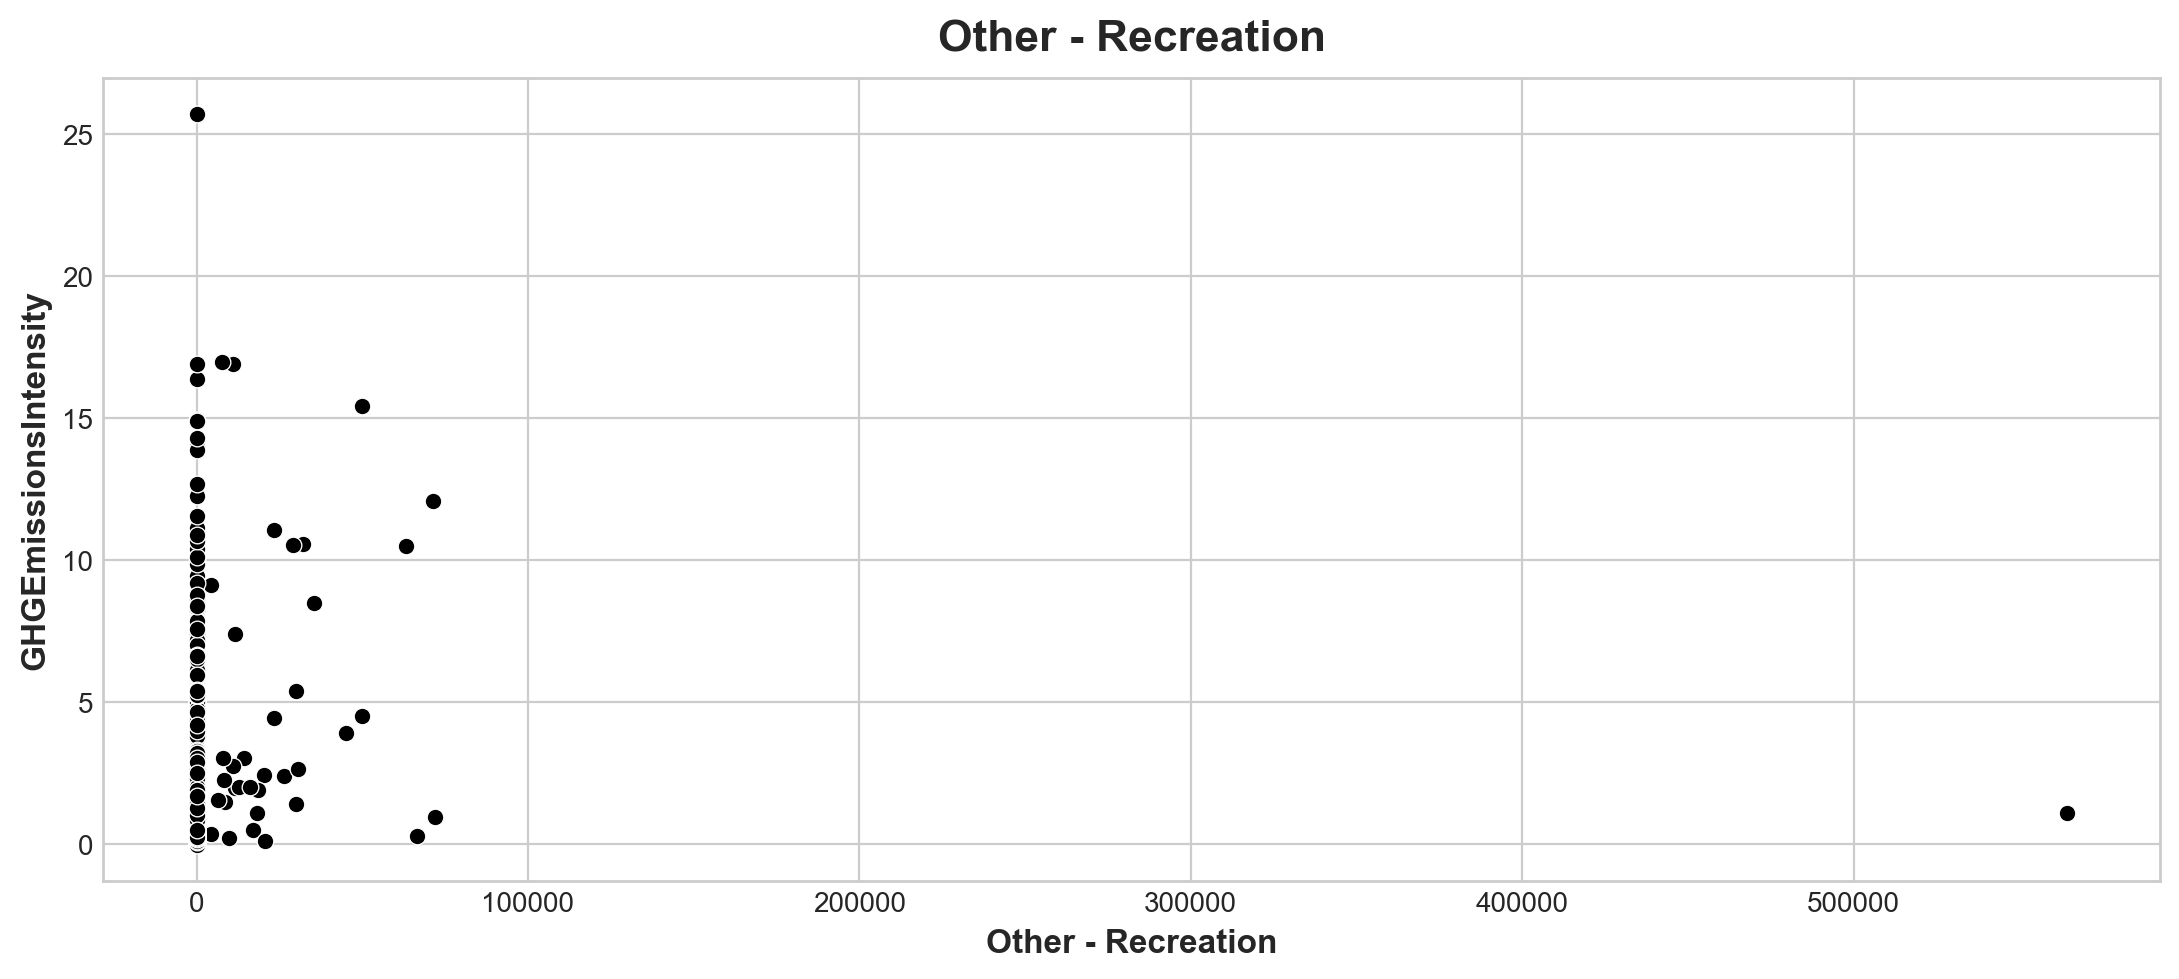

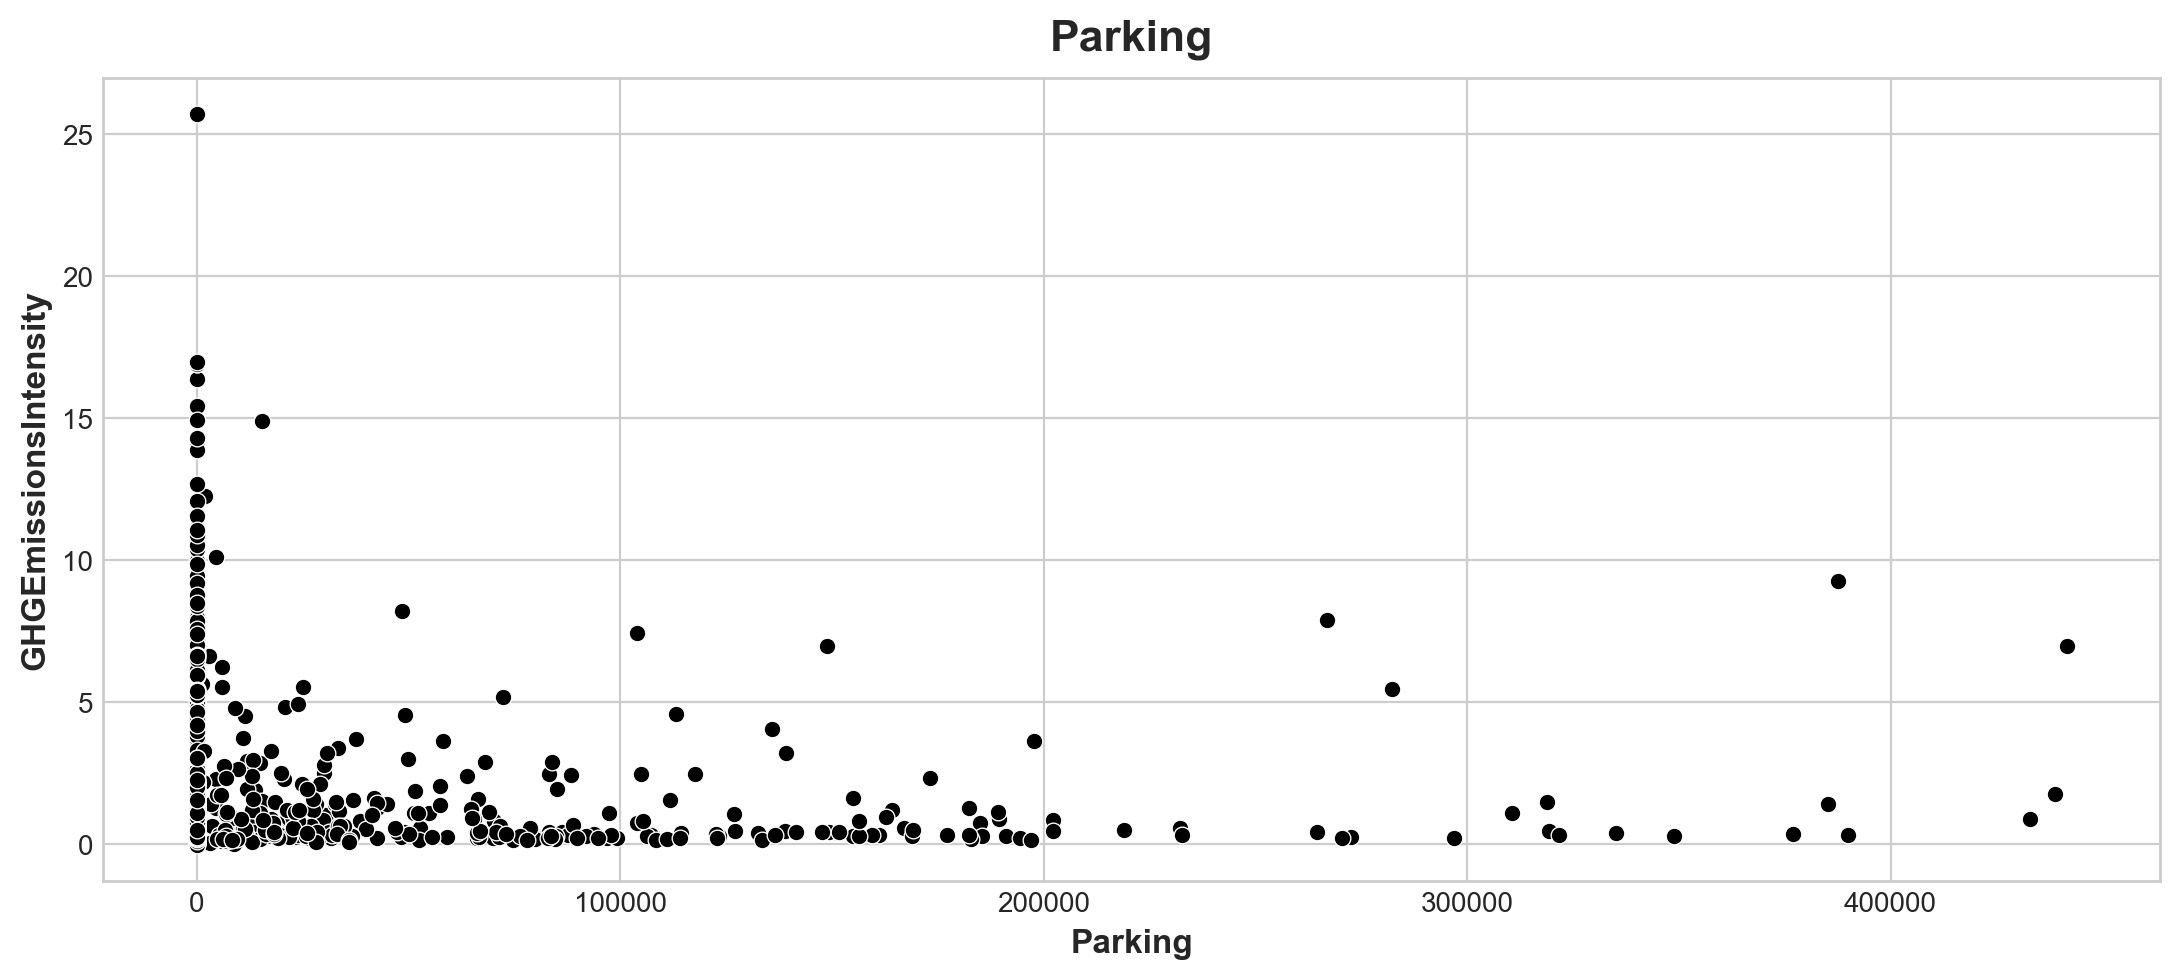

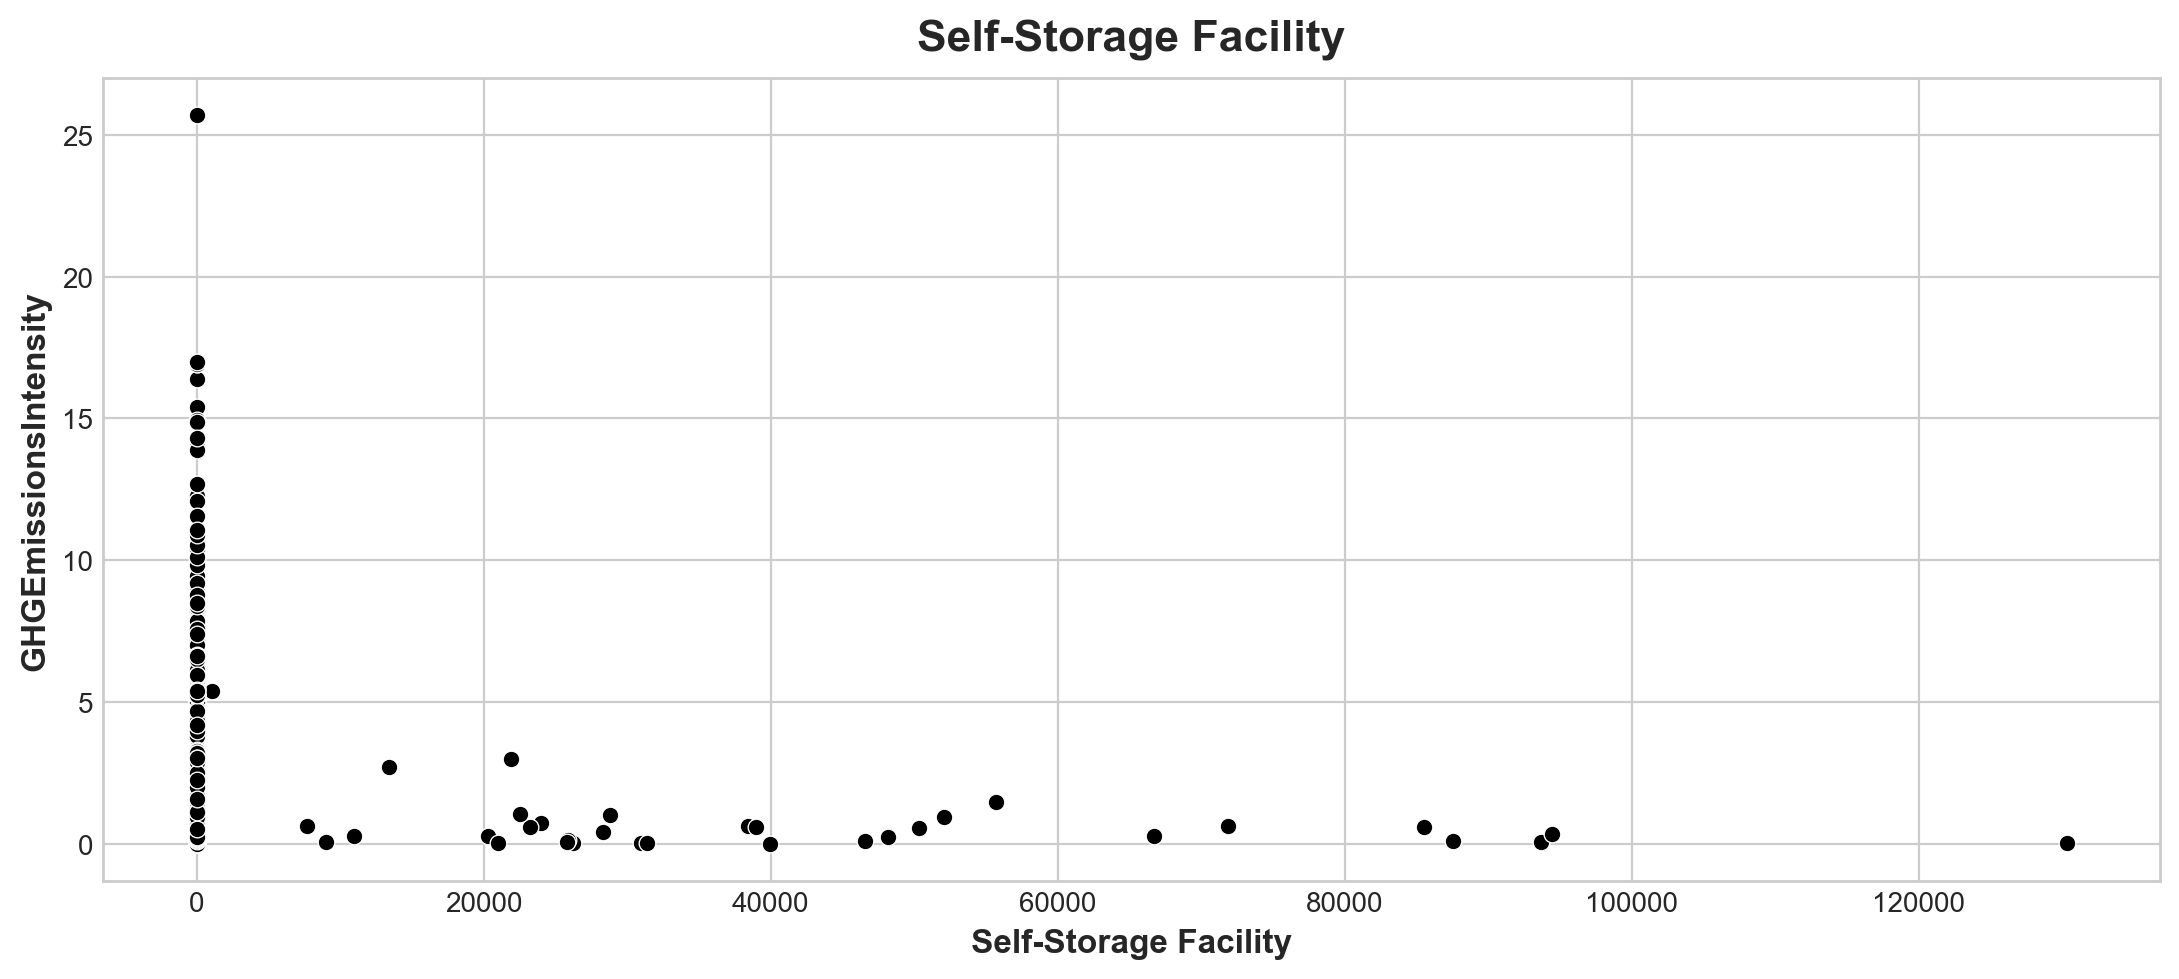

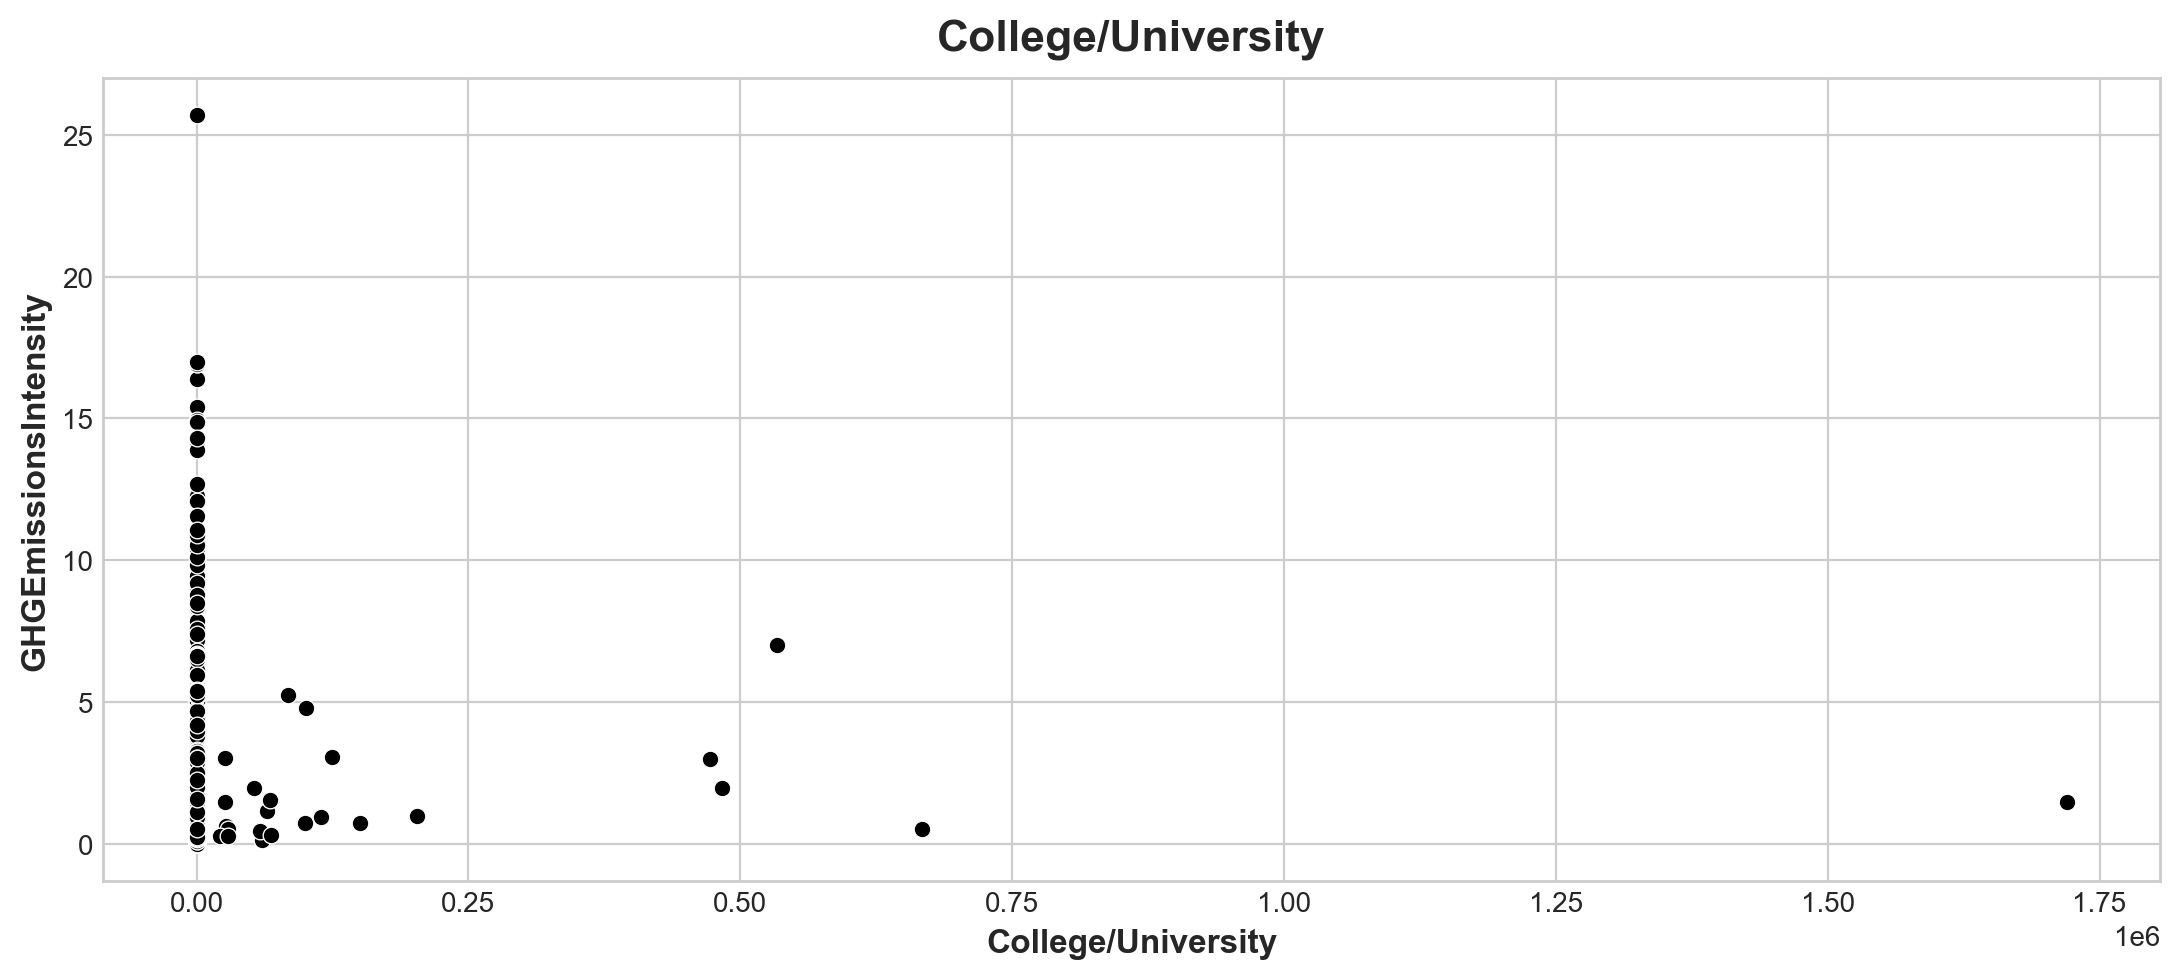

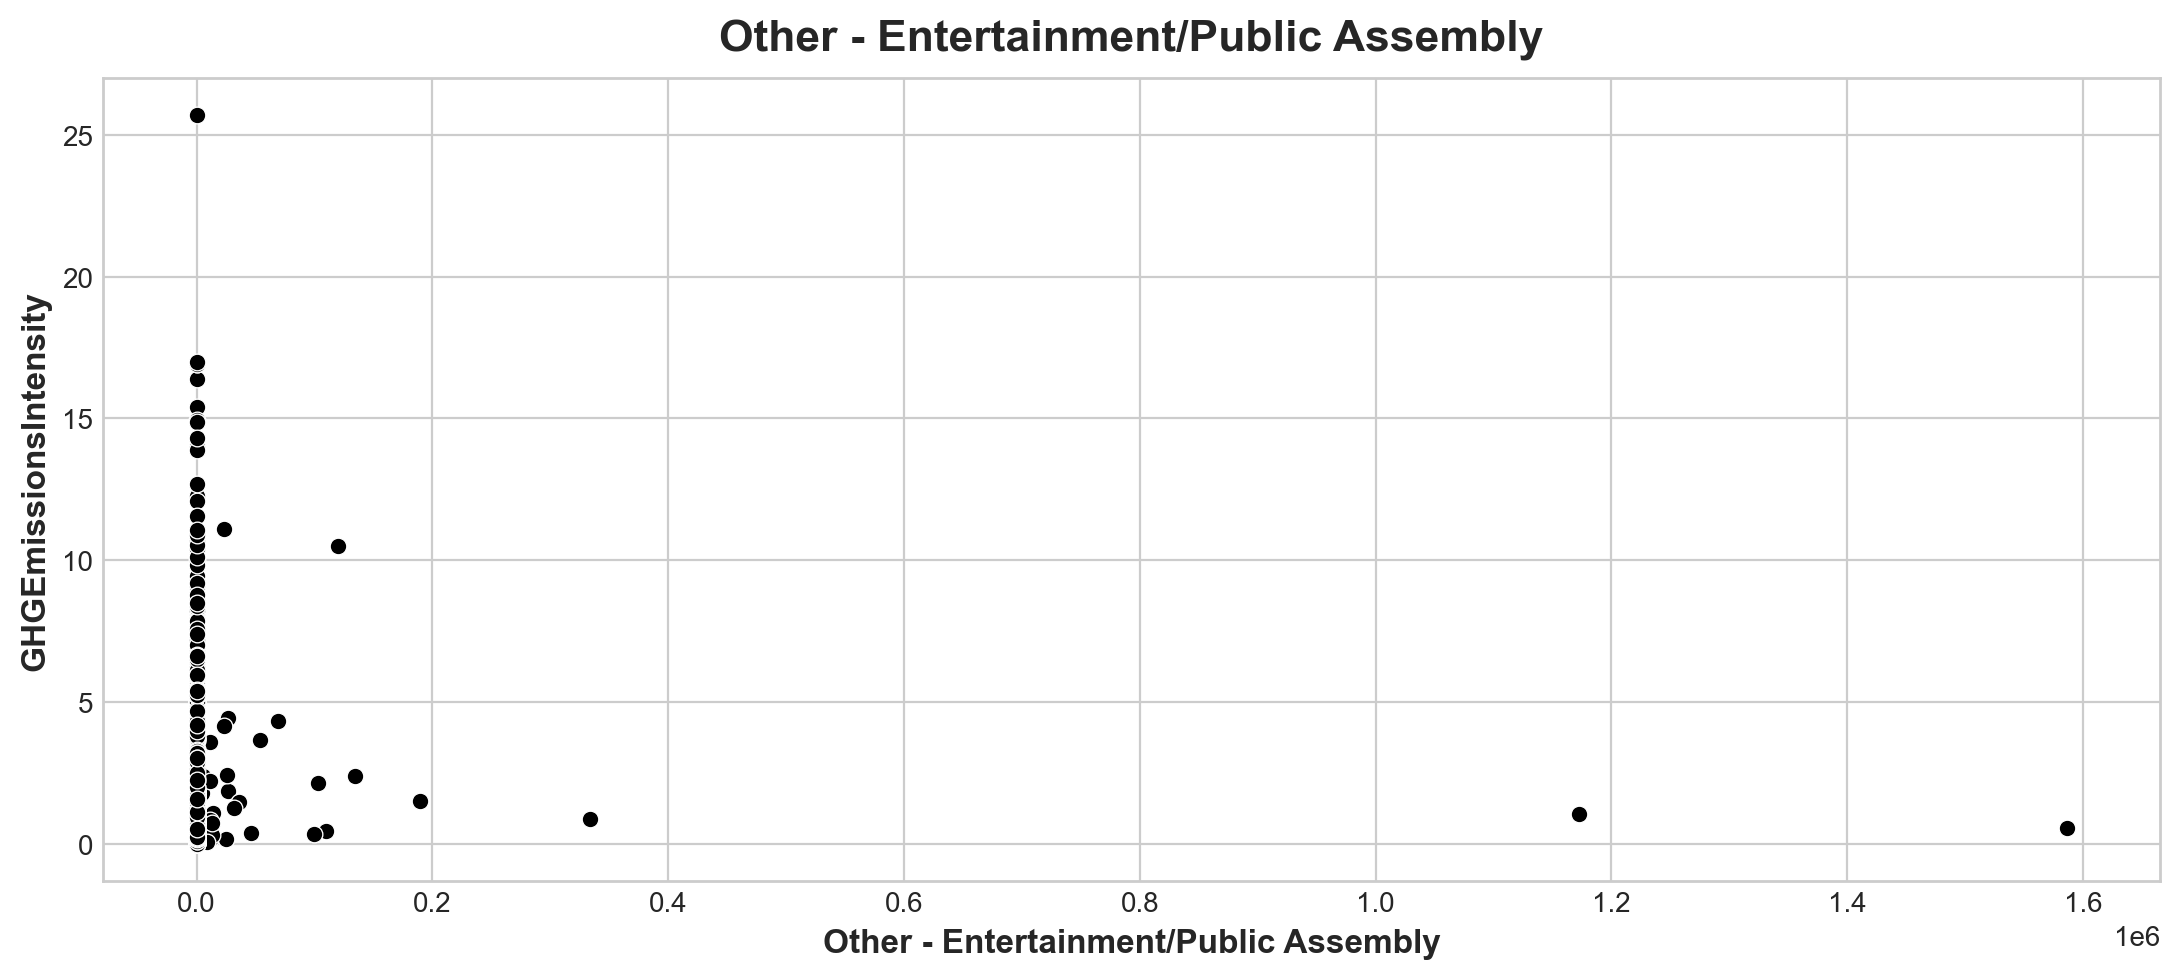

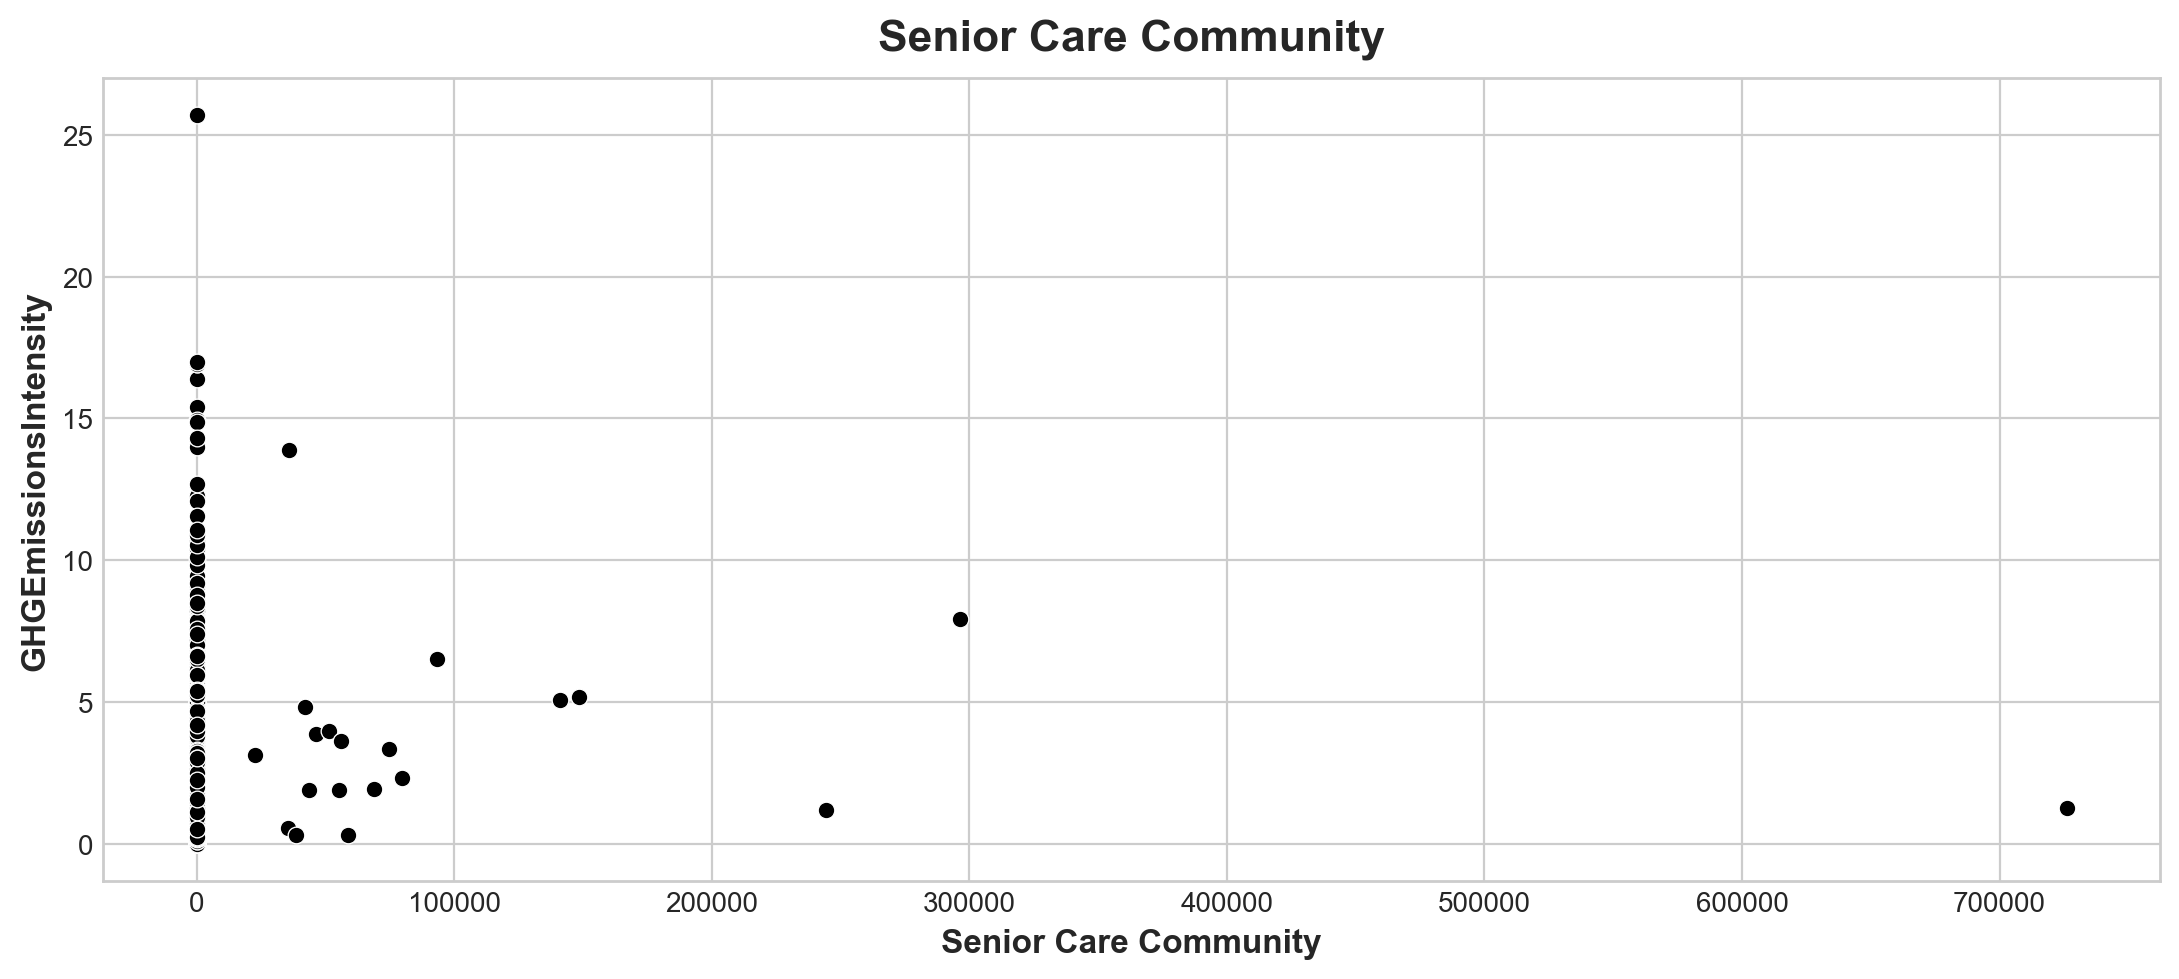

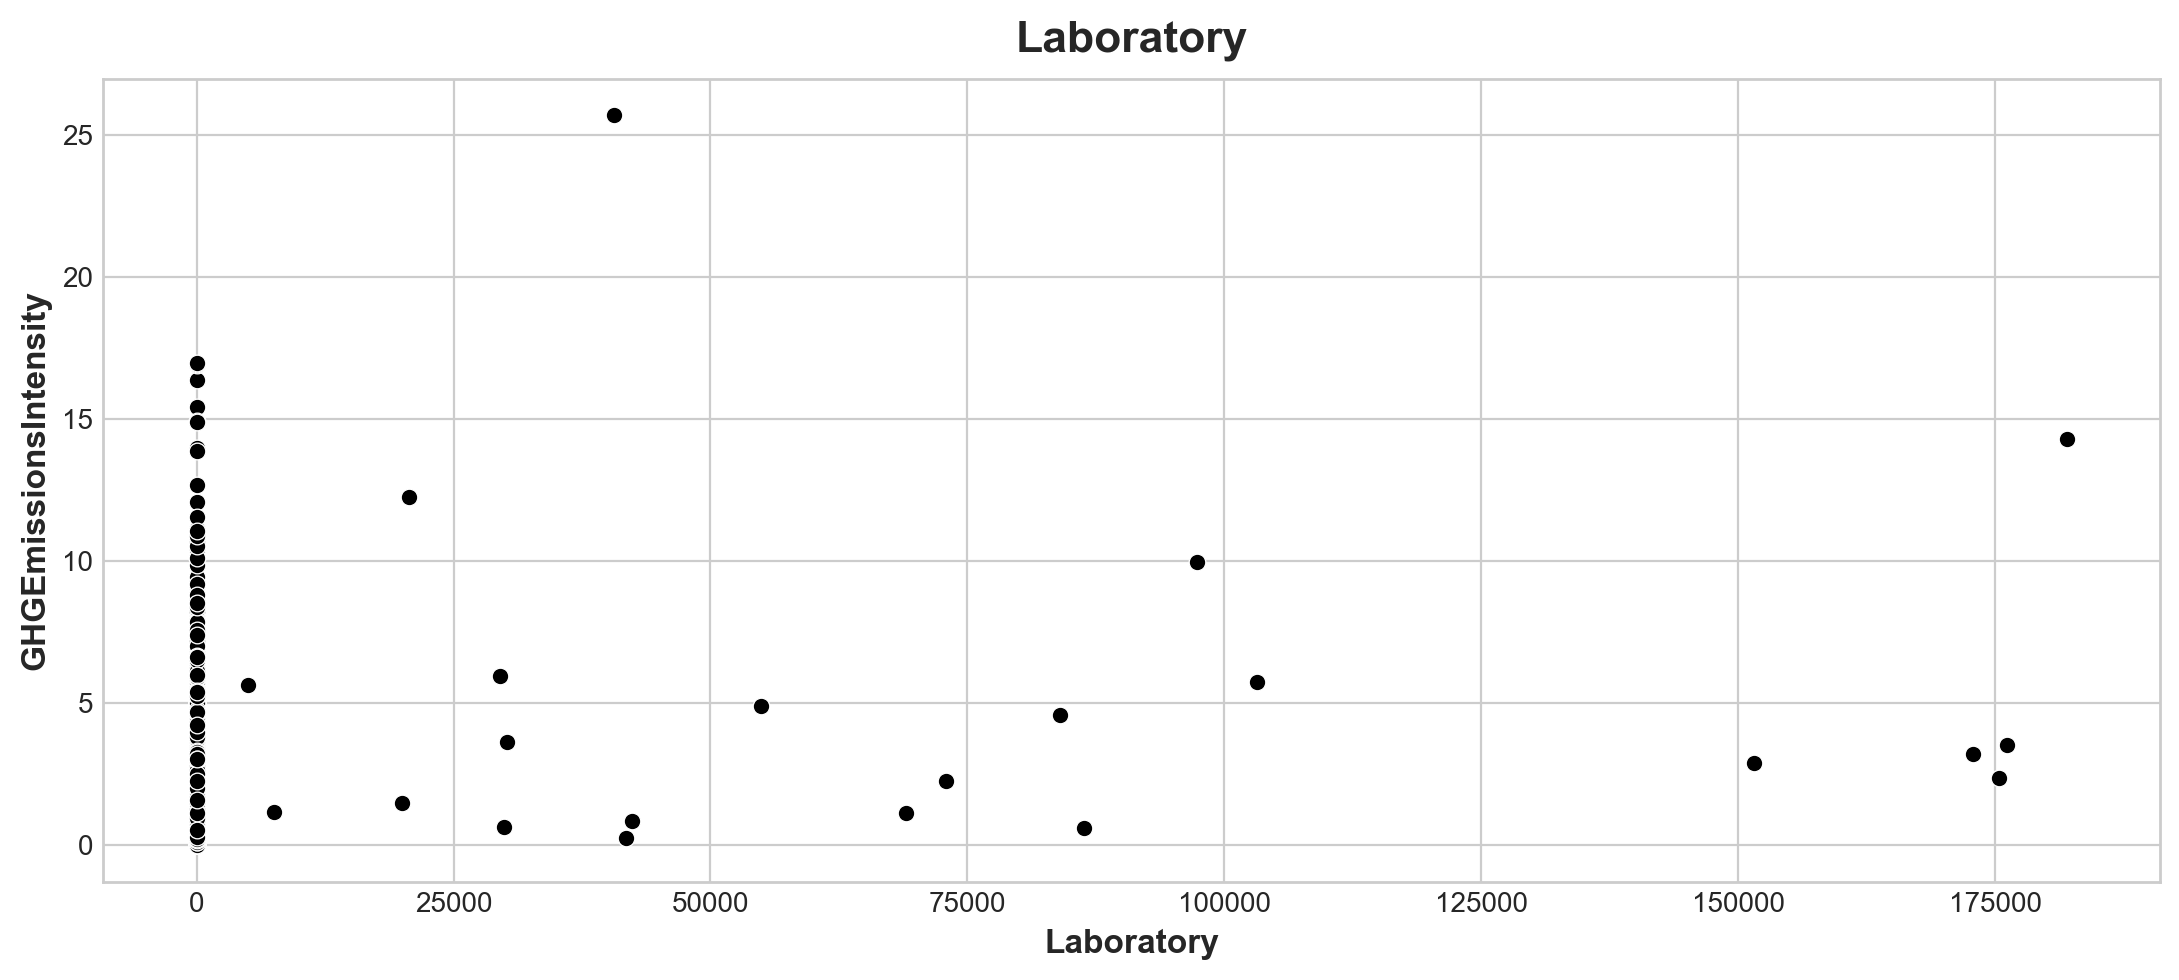

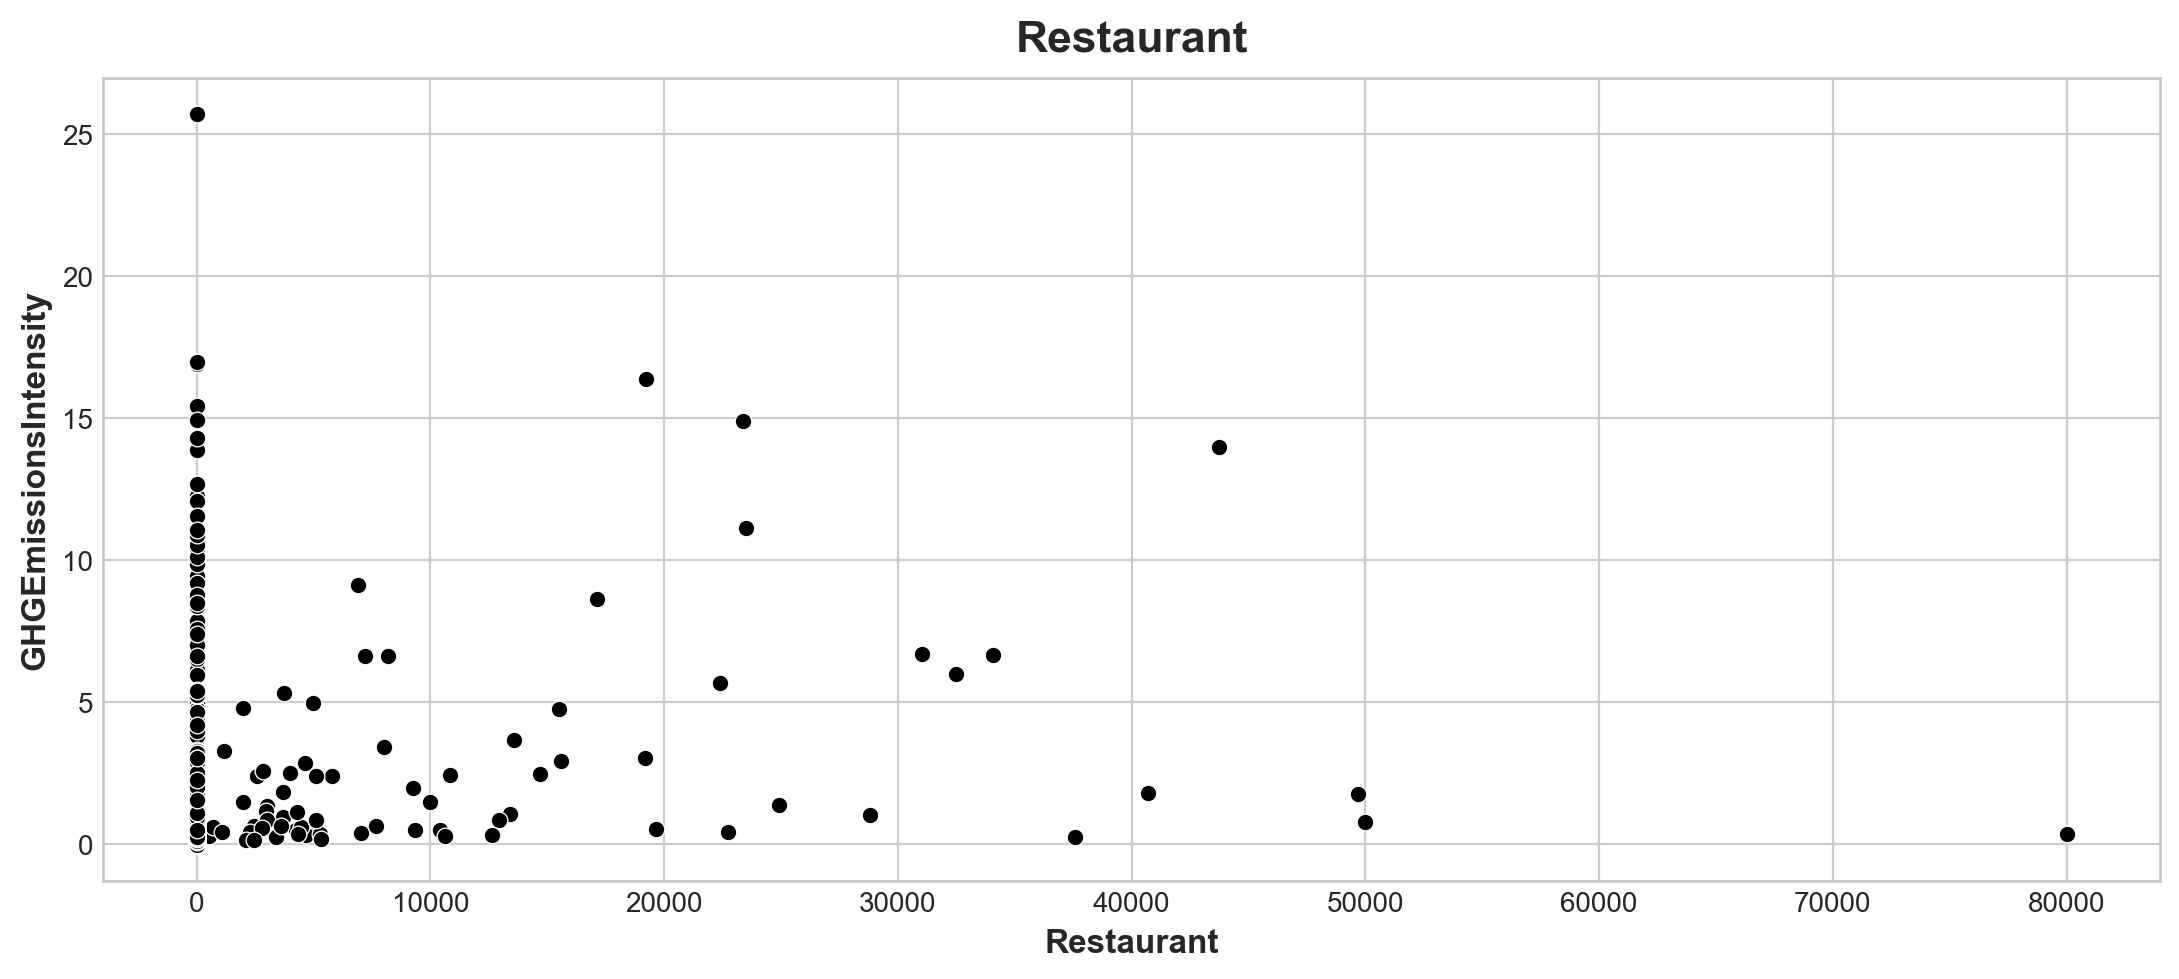

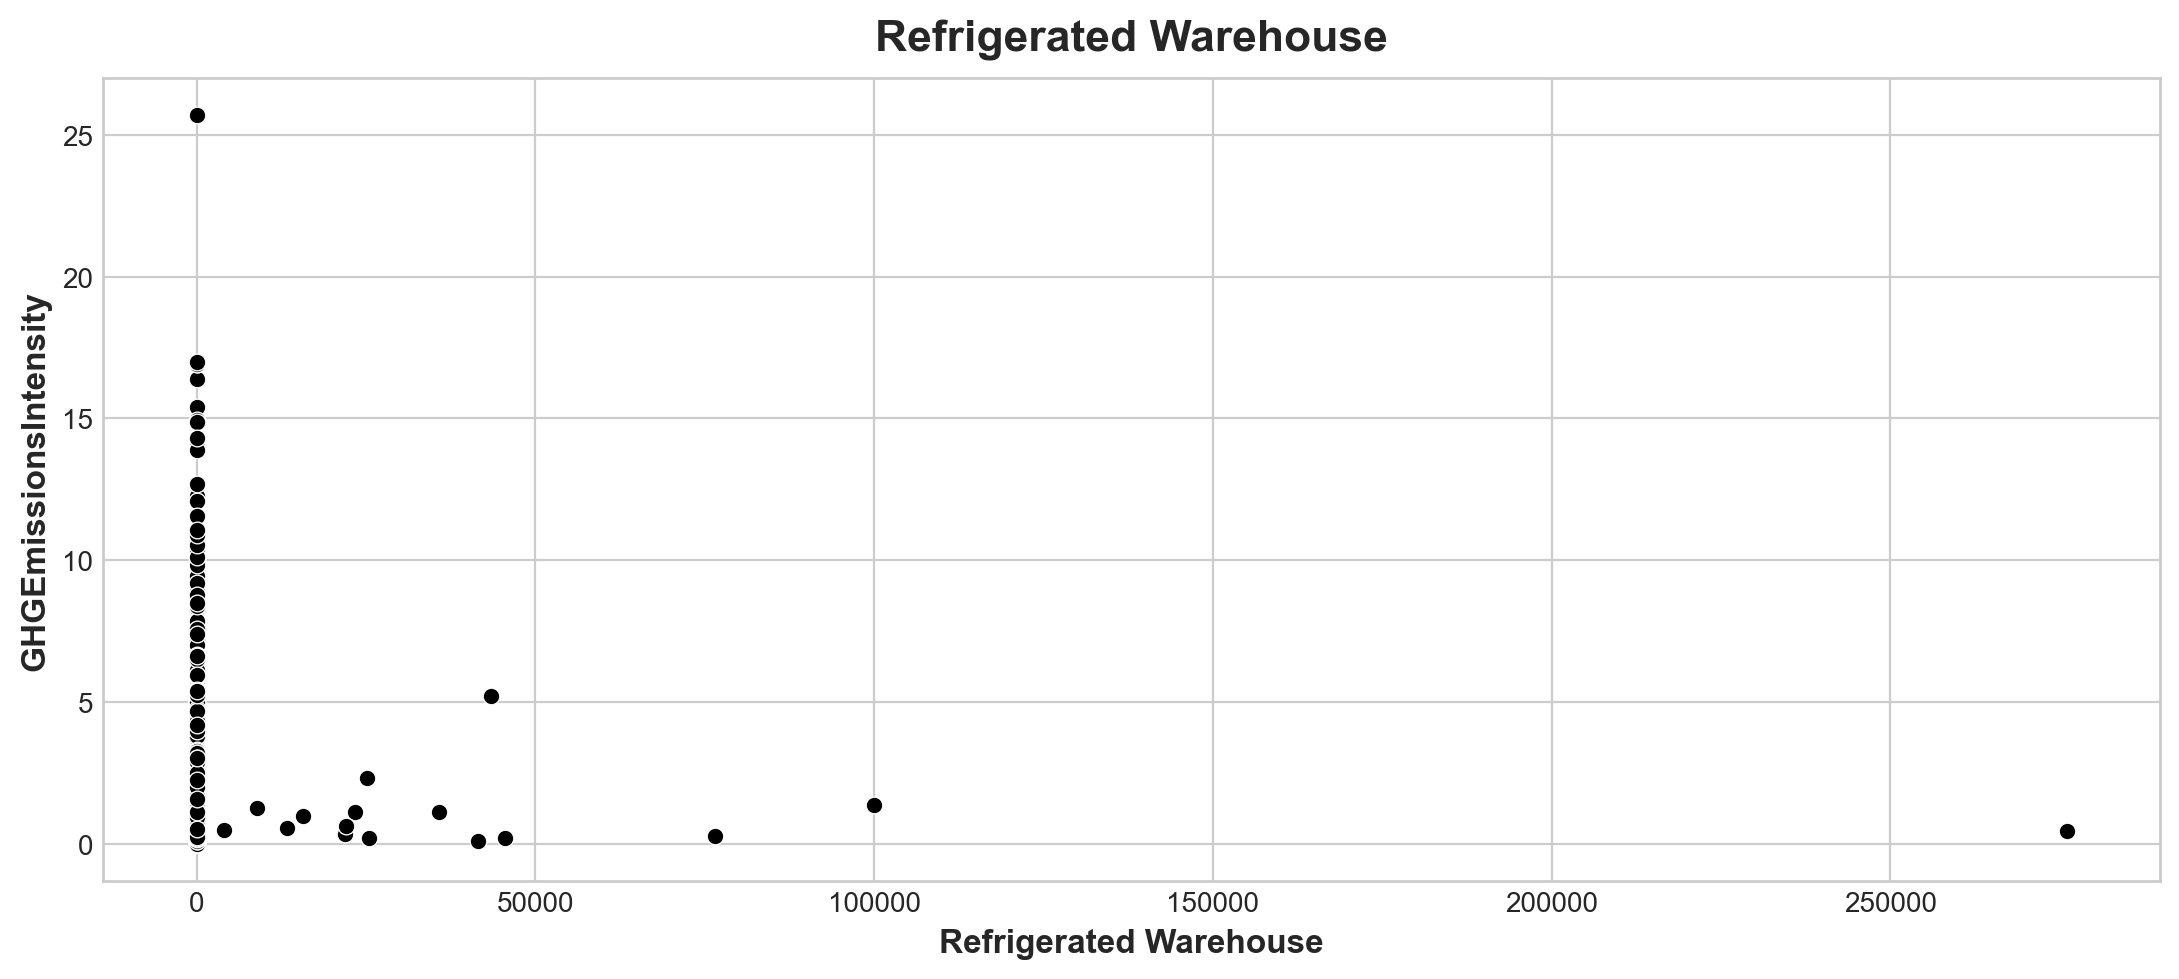

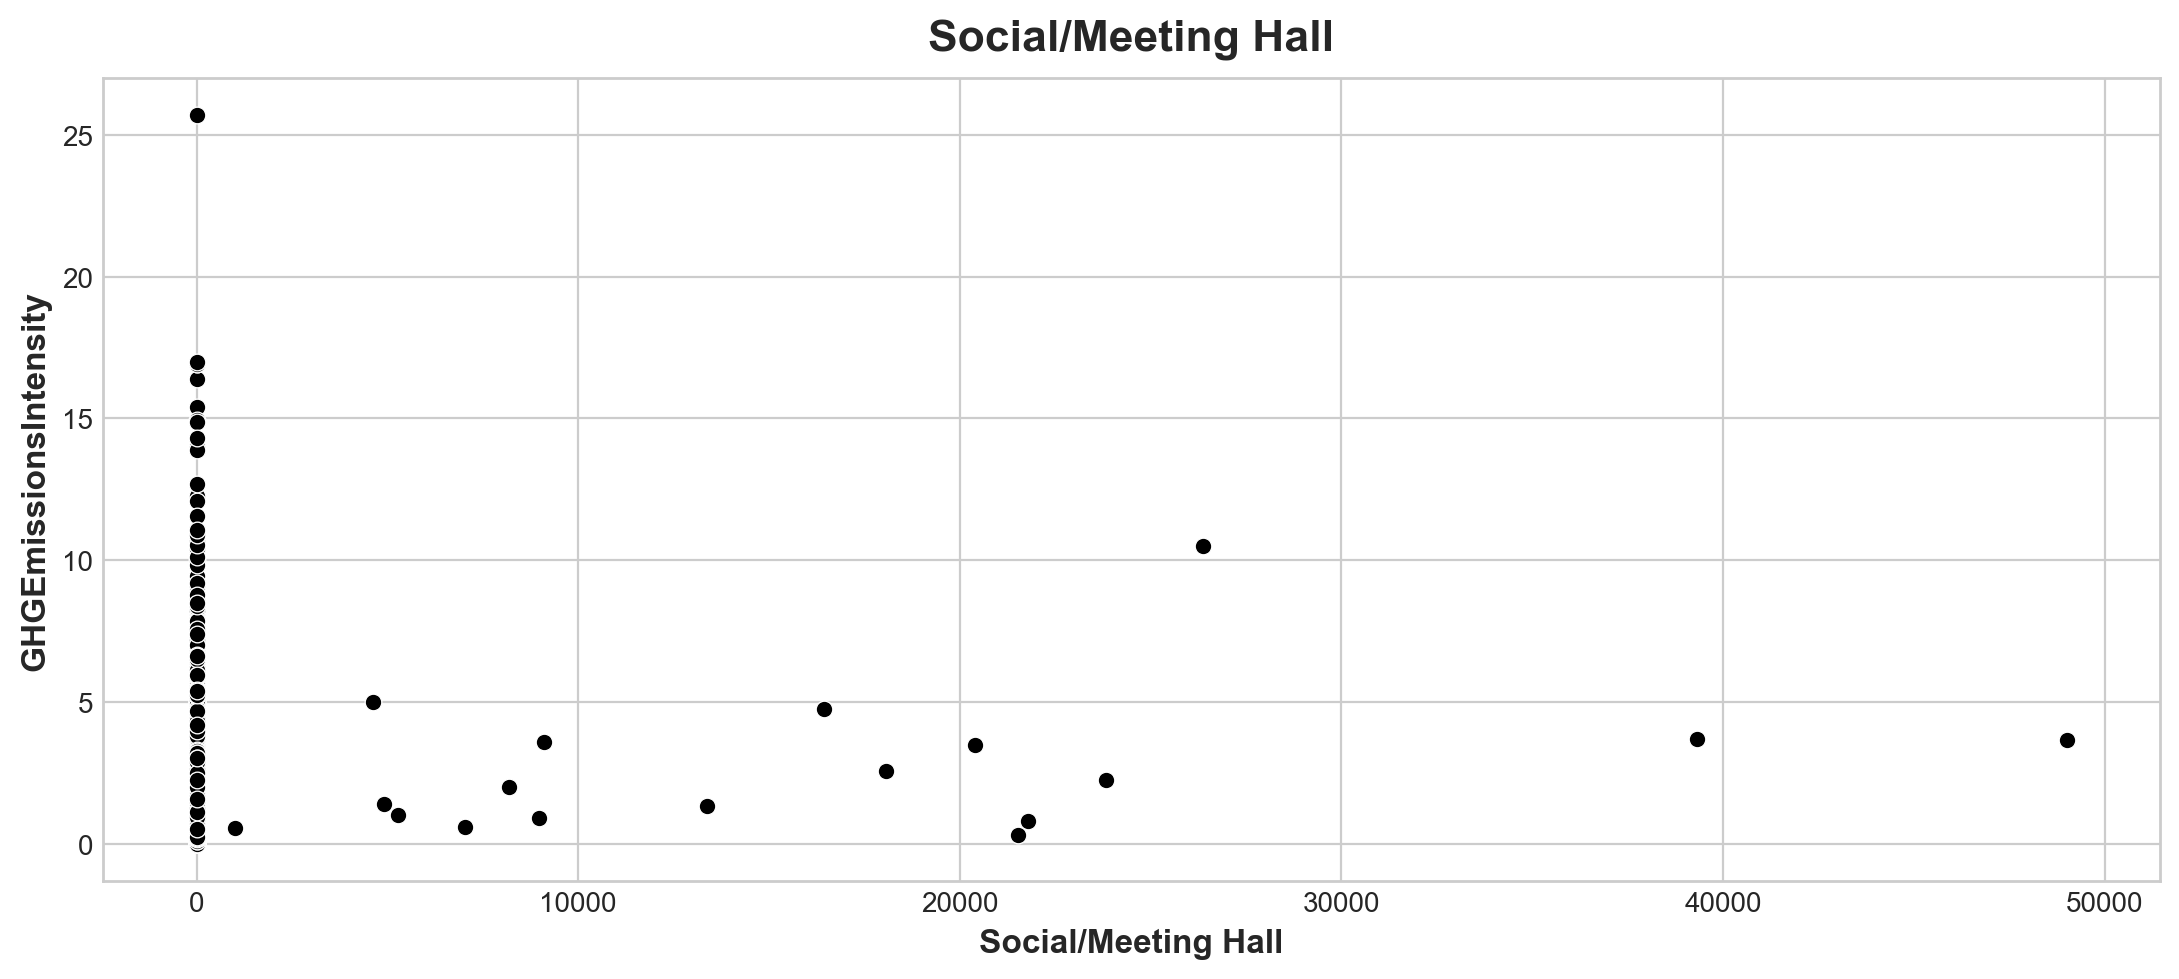

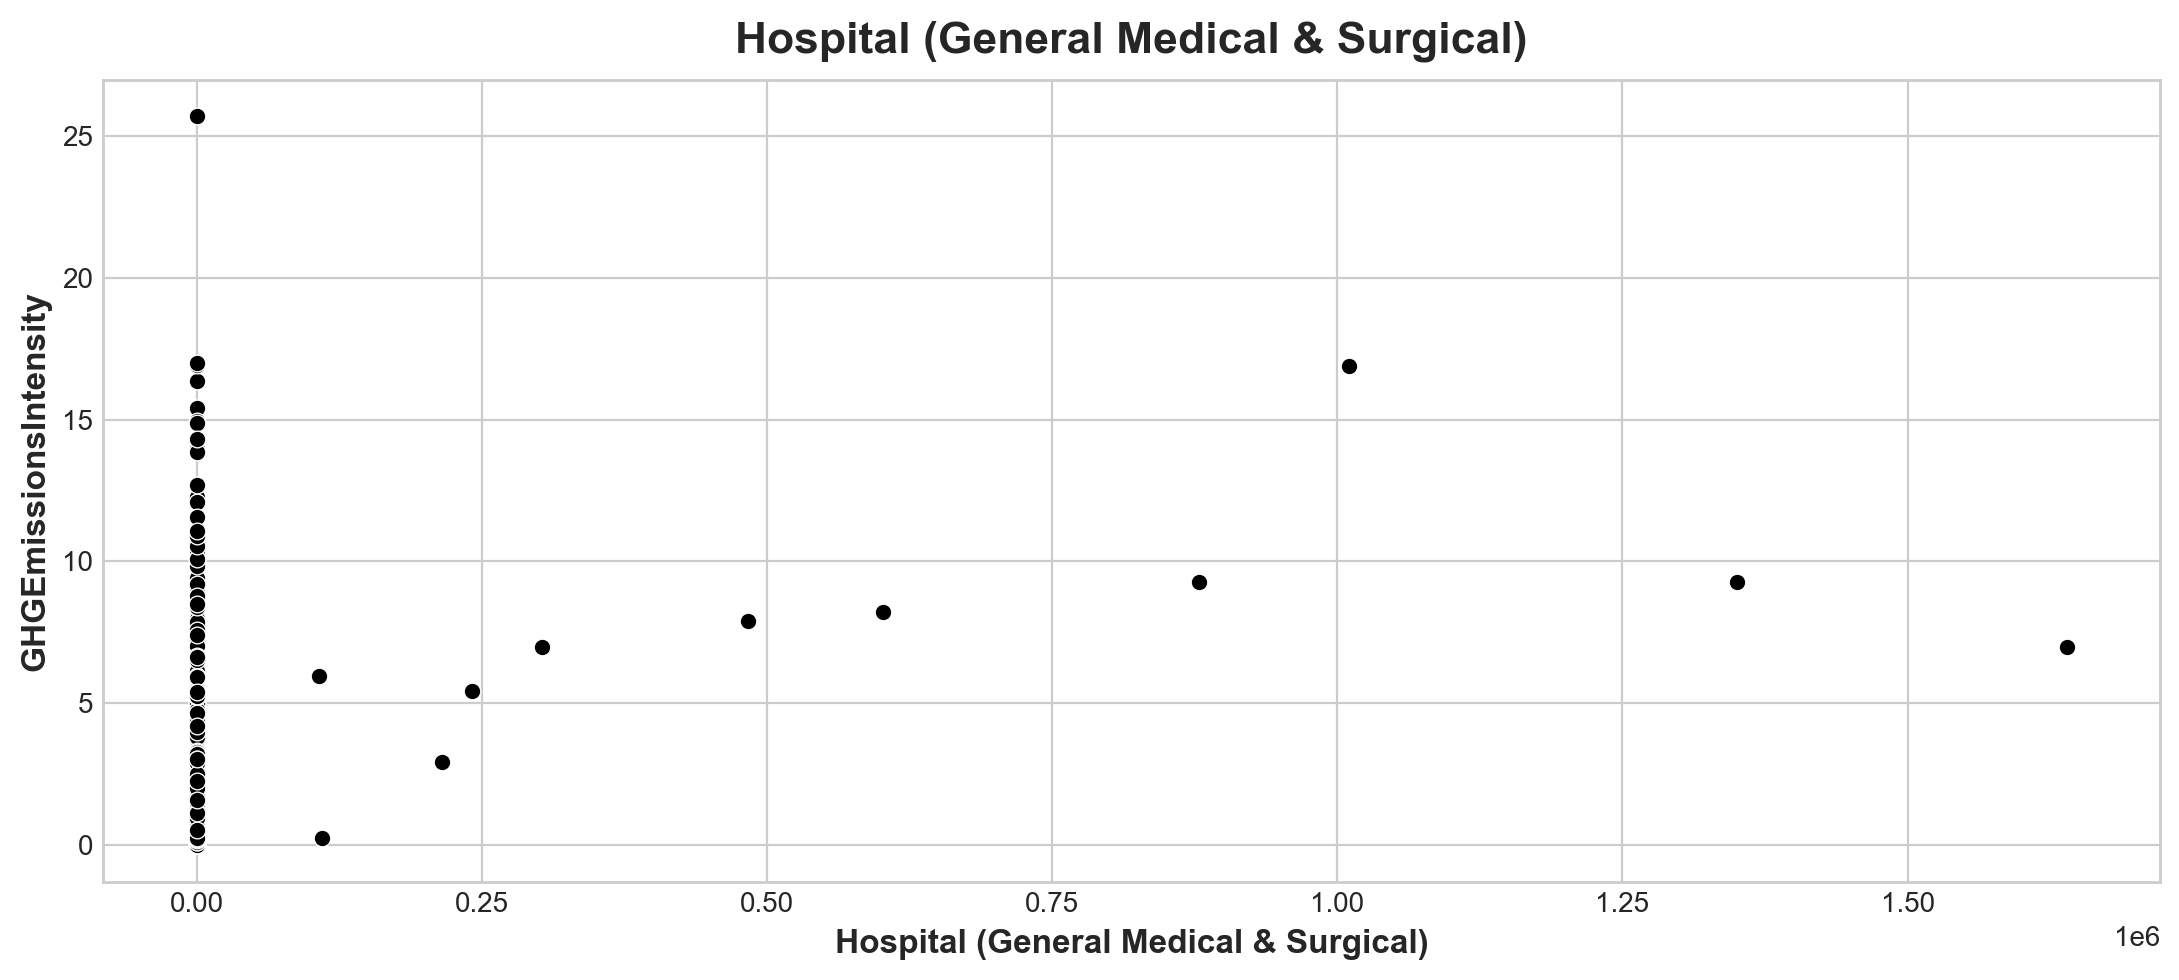

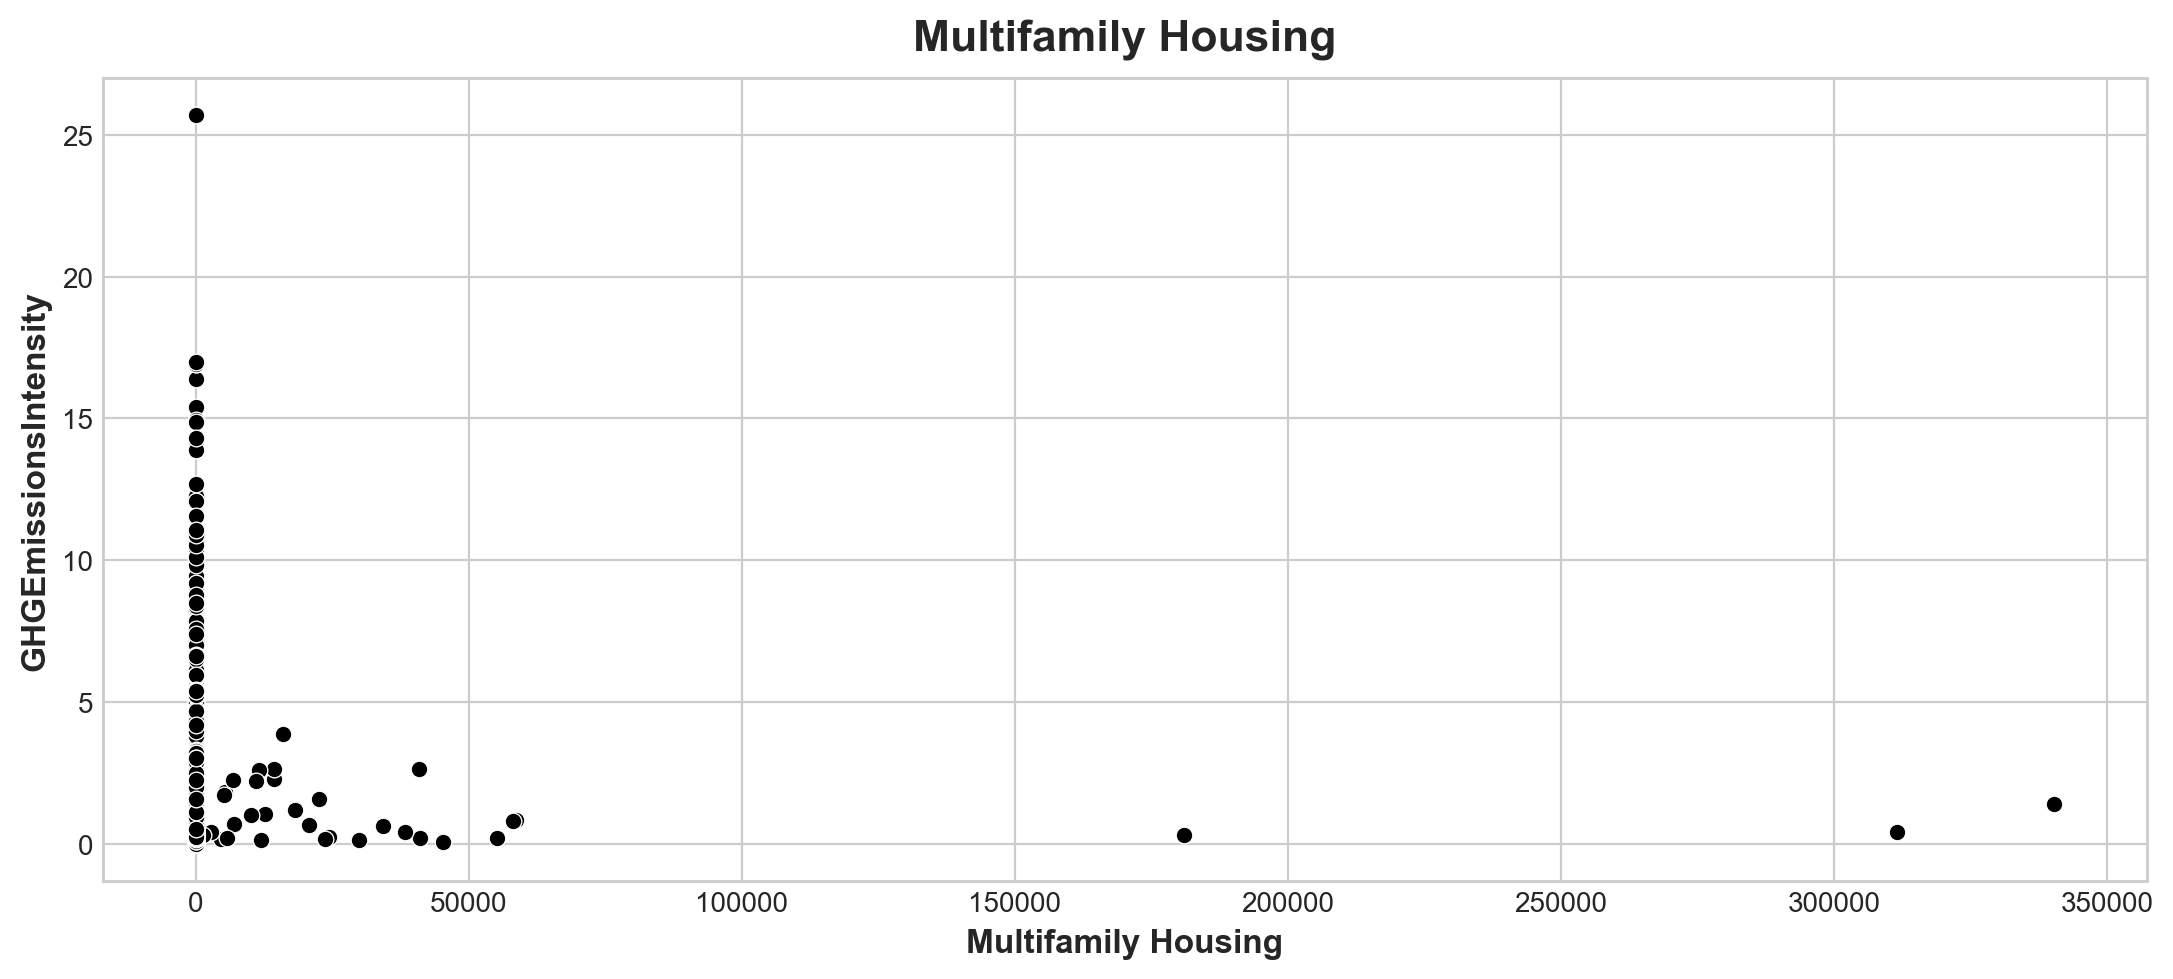

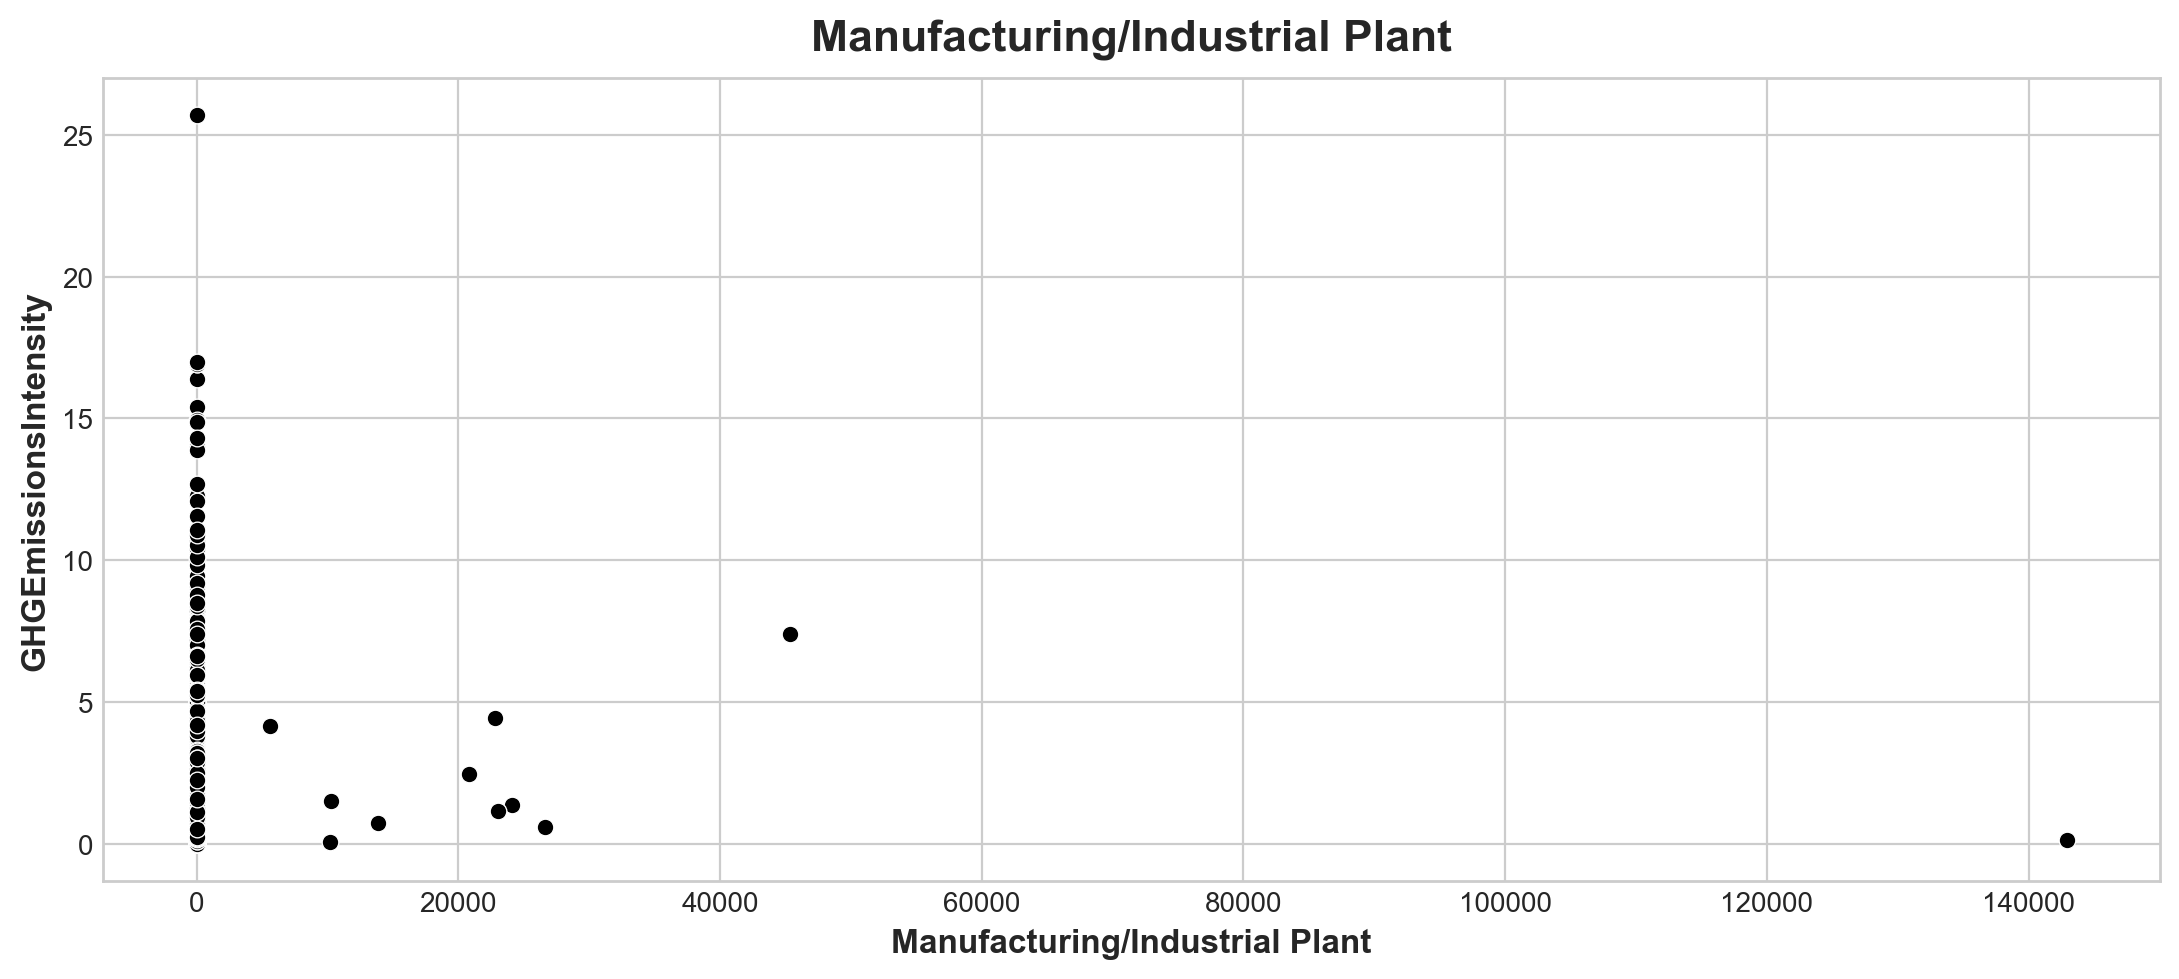

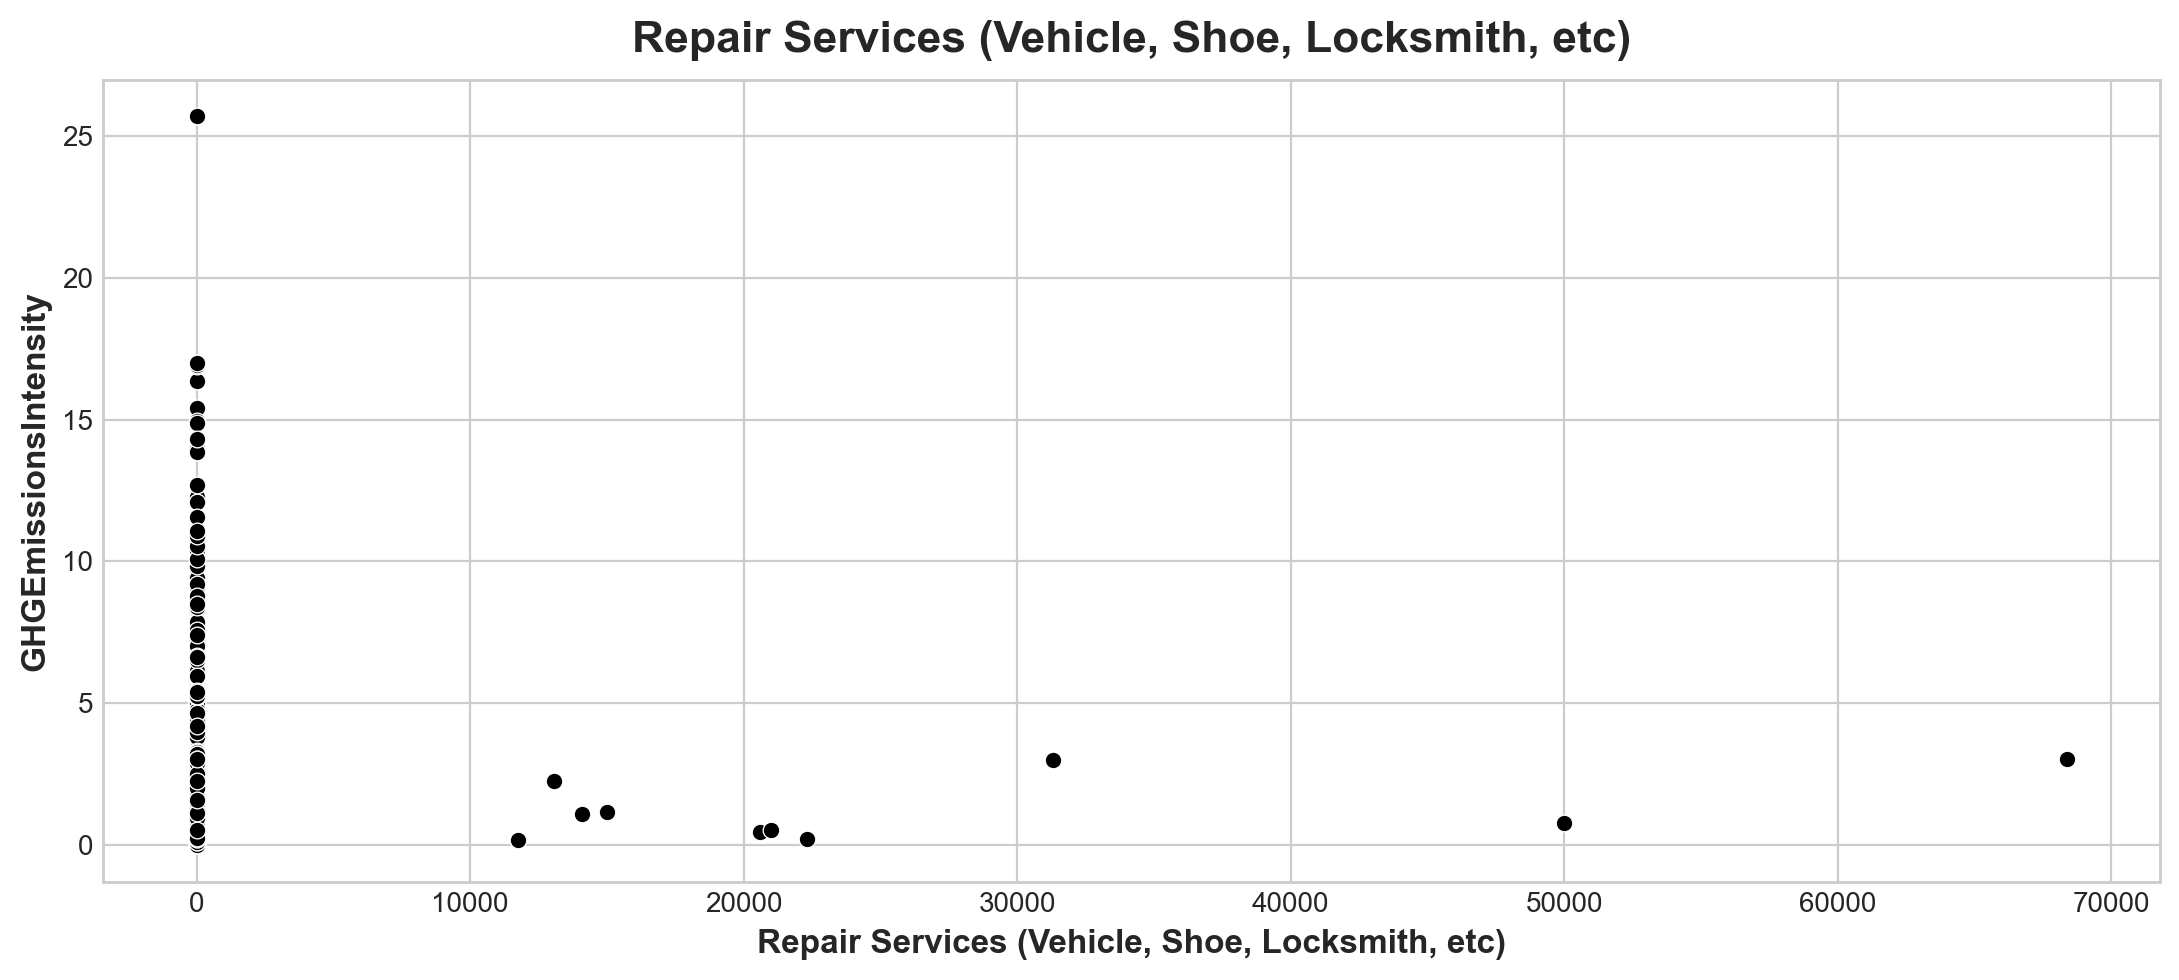

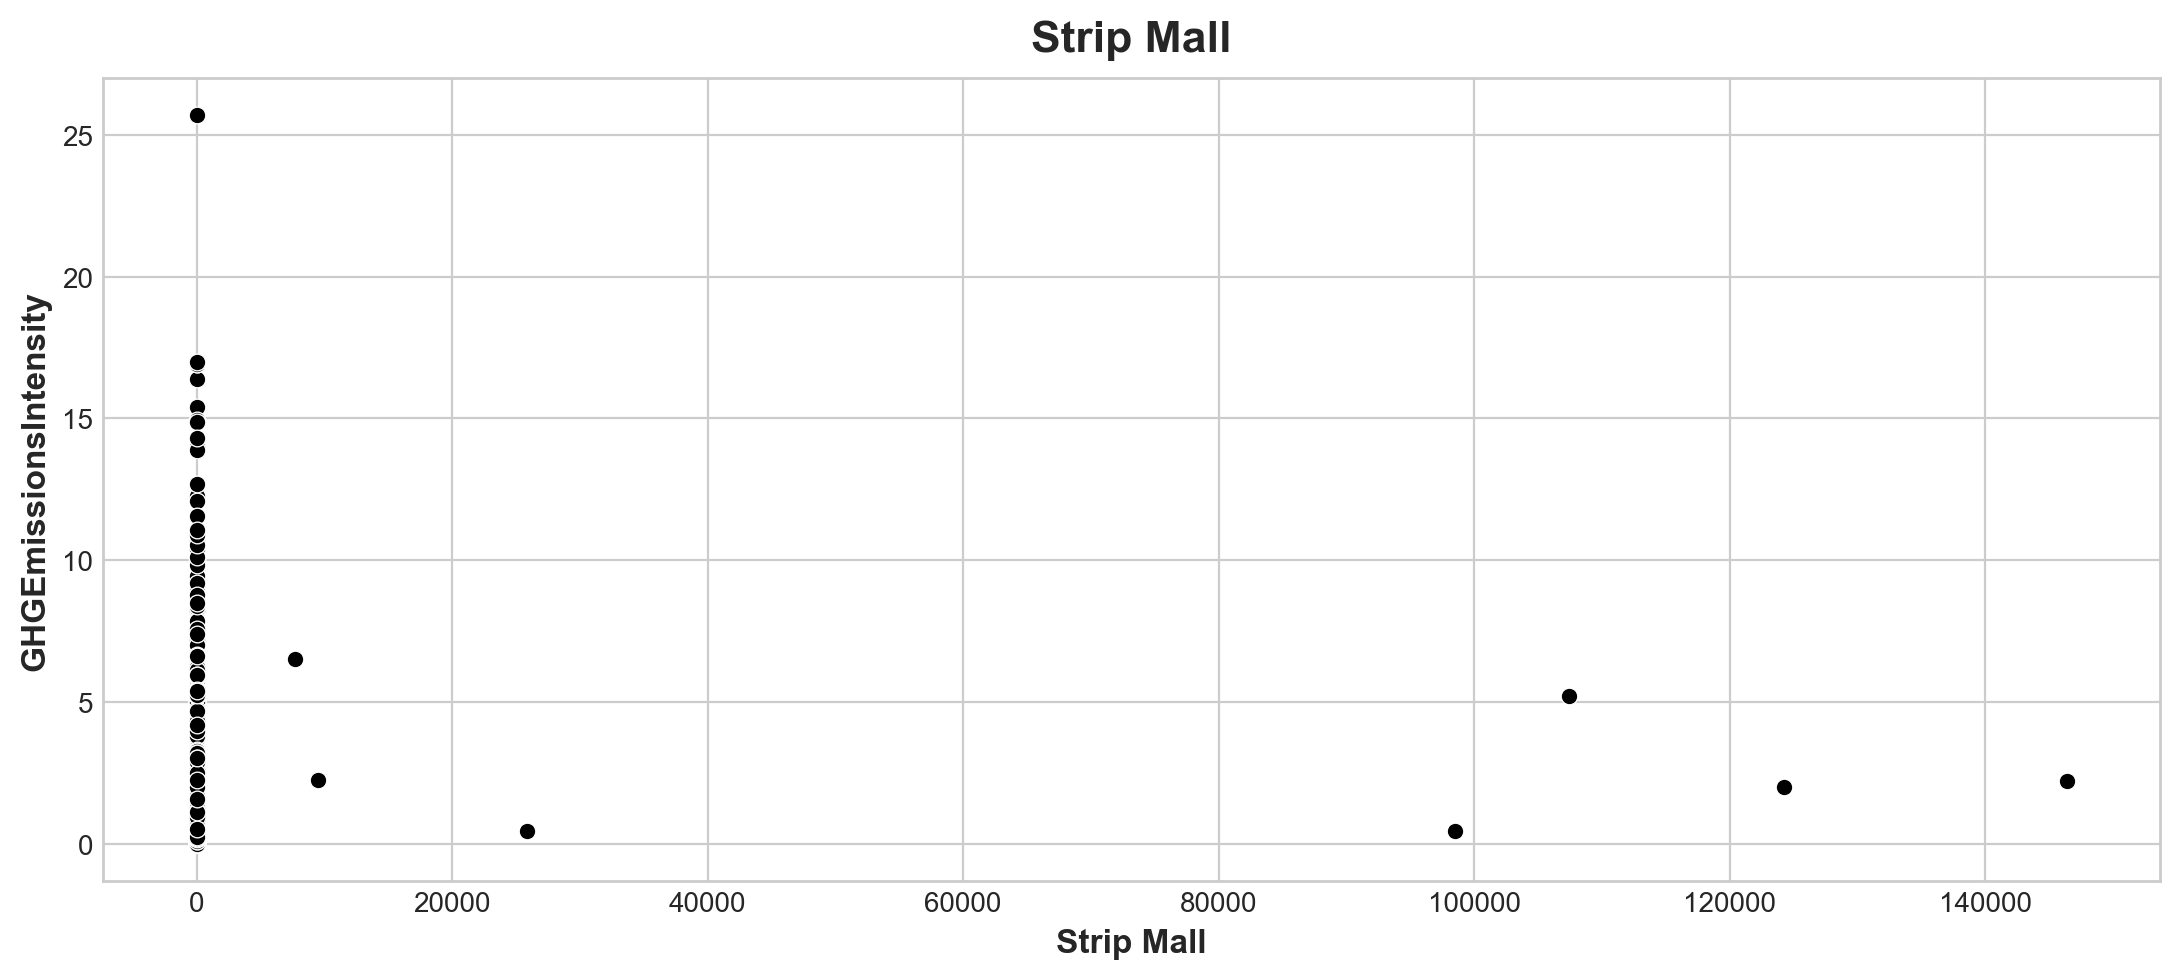

In [45]:
for col in list_types :
    scatter_test(col,'GHGEmissionsIntensity')


 Distribution de GHGEmissionsIntensity et  Neighborhood
Neighborhood
downtown                 356
greater duwamish         345
magnolia / queen anne    147
lake union               145
east                     118
northeast                112
northwest                 85
ballard                   68
north                     64
central                   52
delridge                  46
southeast                 45
southwest                 40
Name: count, dtype: int64


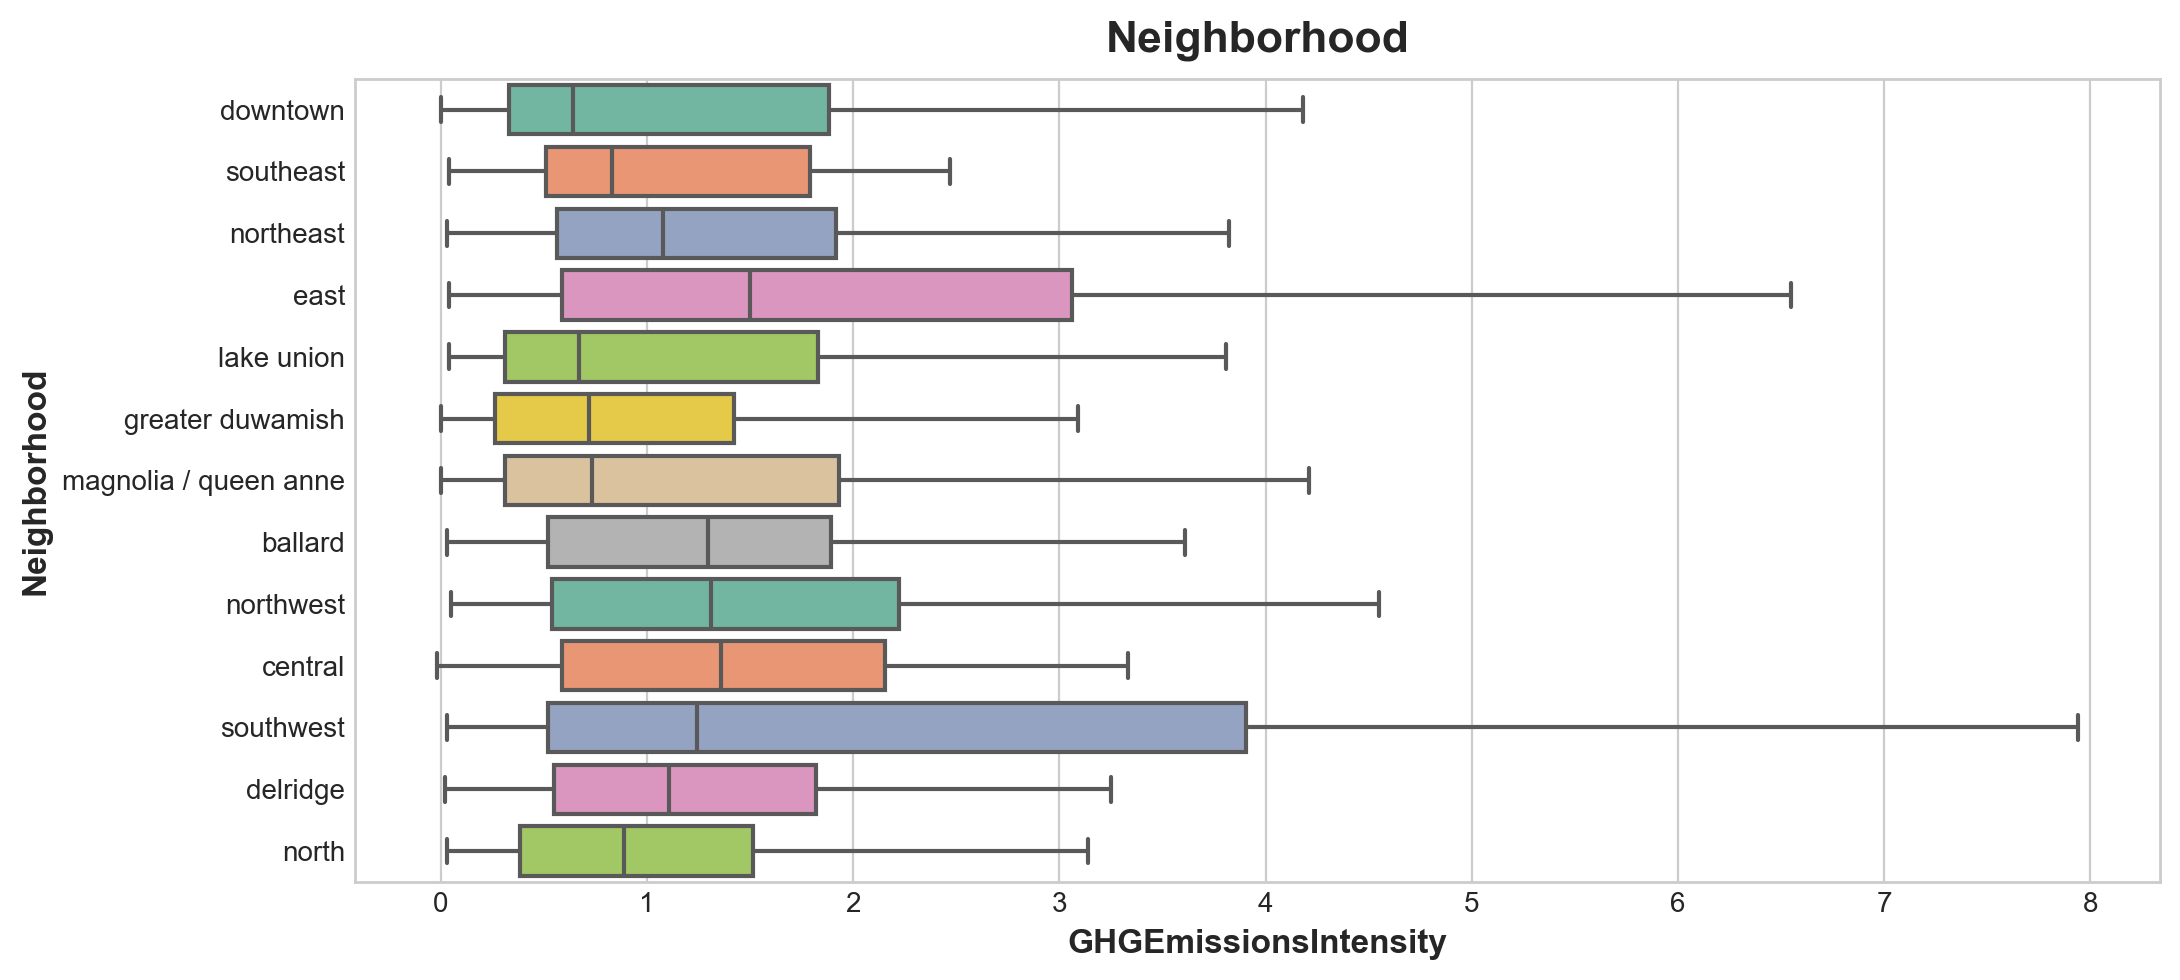


 Distribution de GHGEmissionsIntensity et  BuildingType
BuildingType
NonResidential        1433
Nonresidential COS      85
SPS-District K-12       83
Campus                  21
Nonresidential WA        1
Name: count, dtype: int64


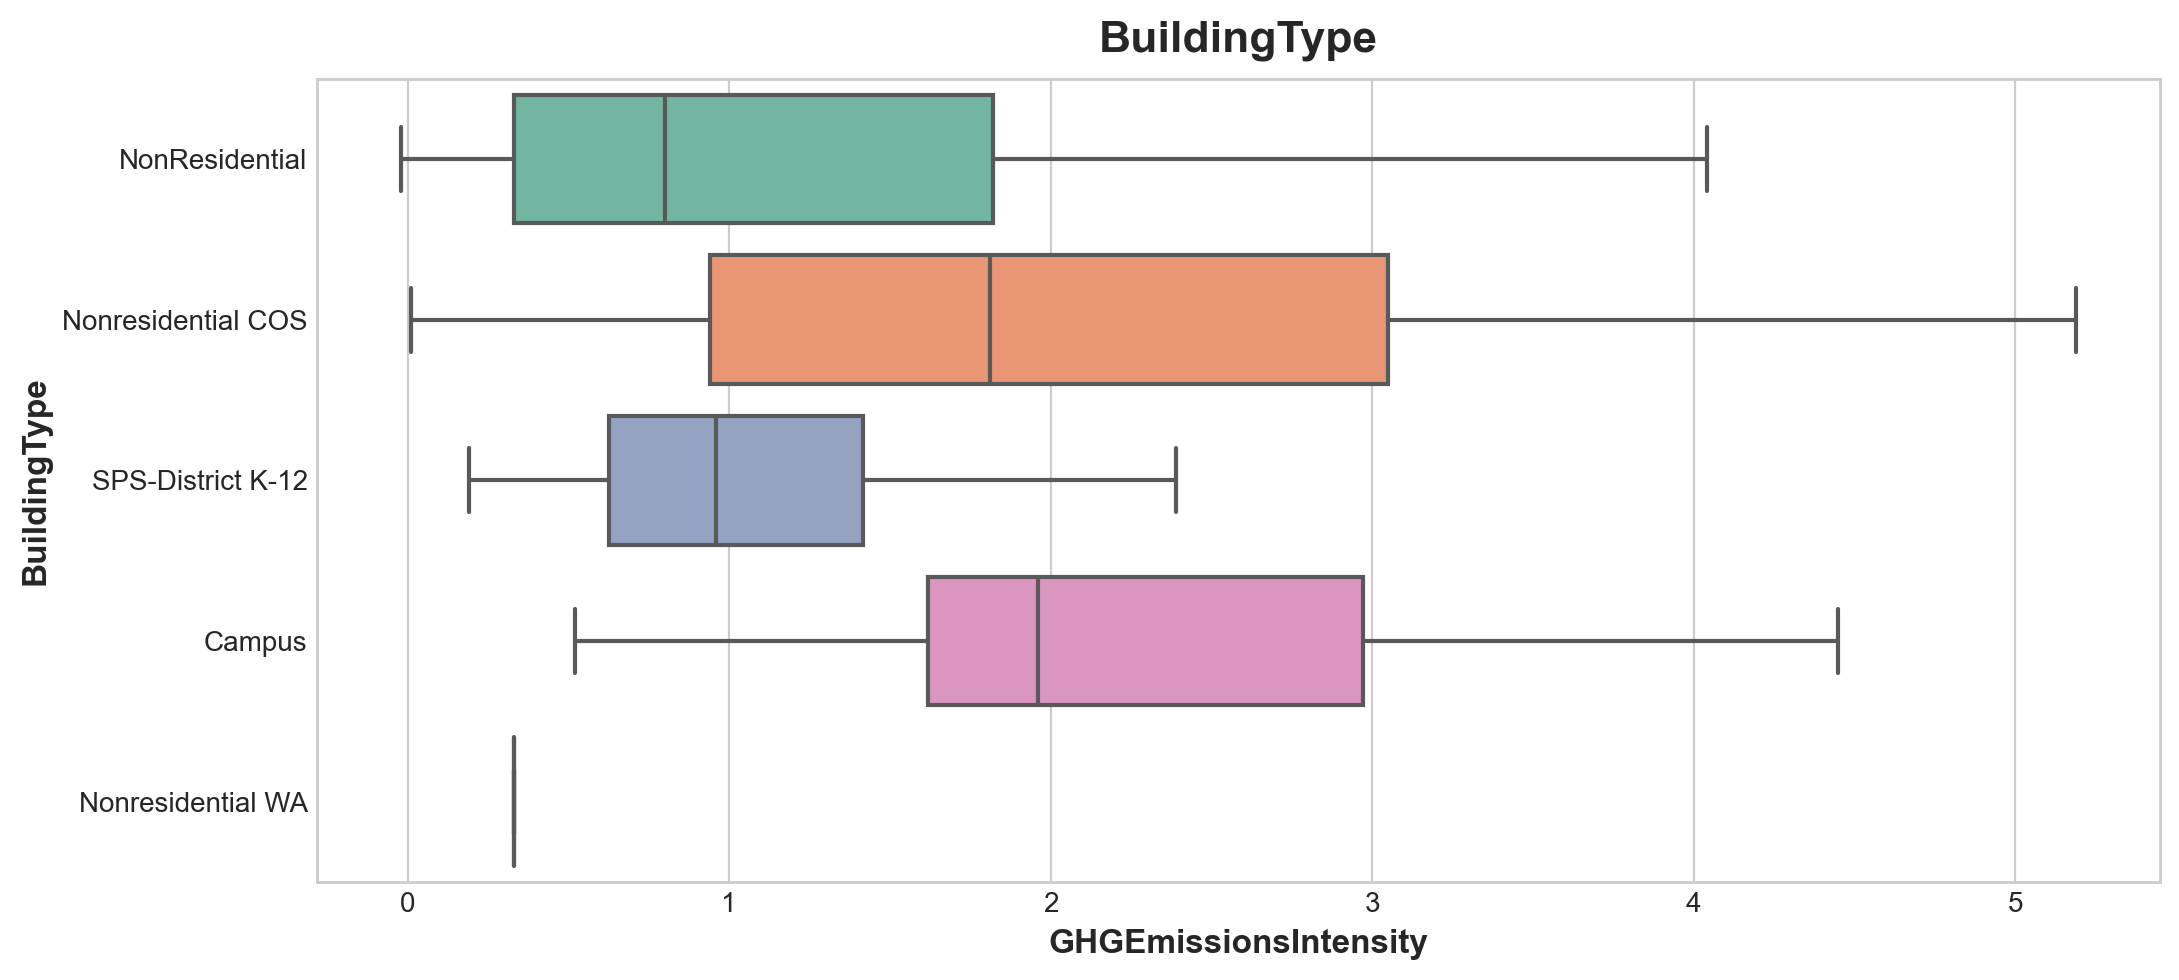


 Distribution de GHGEmissionsIntensity et  PrimaryPropertyType
PrimaryPropertyType
Small- and Mid-Sized Office    291
Other                          248
Warehouse                      187
Large Office                   173
K-12 School                    124
Mixed Use Property             111
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      23
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64


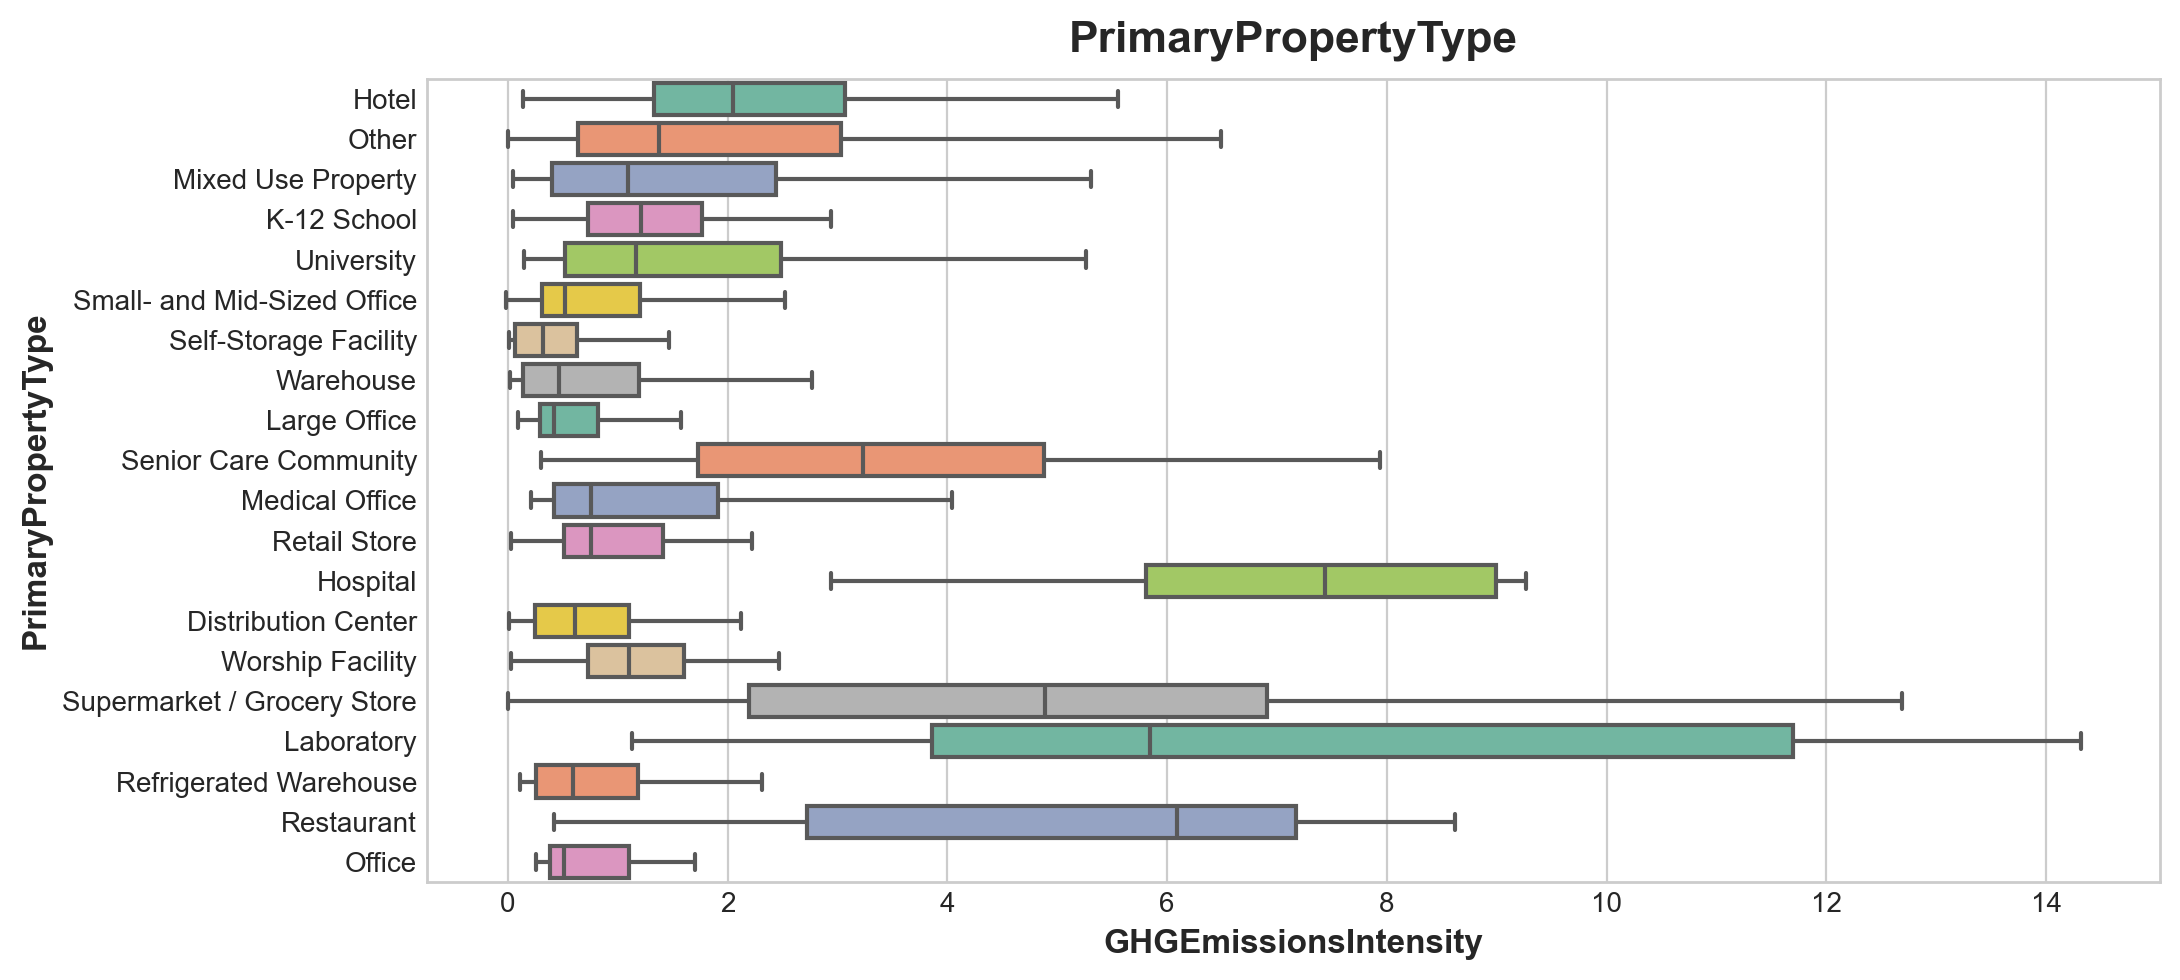


 Distribution de GHGEmissionsIntensity et  YearBuilt
YearBuilt
1900    45
2000    34
1970    32
1910    30
1960    30
        ..
1939     2
1901     2
1942     2
1936     1
1935     1
Name: count, Length: 113, dtype: int64


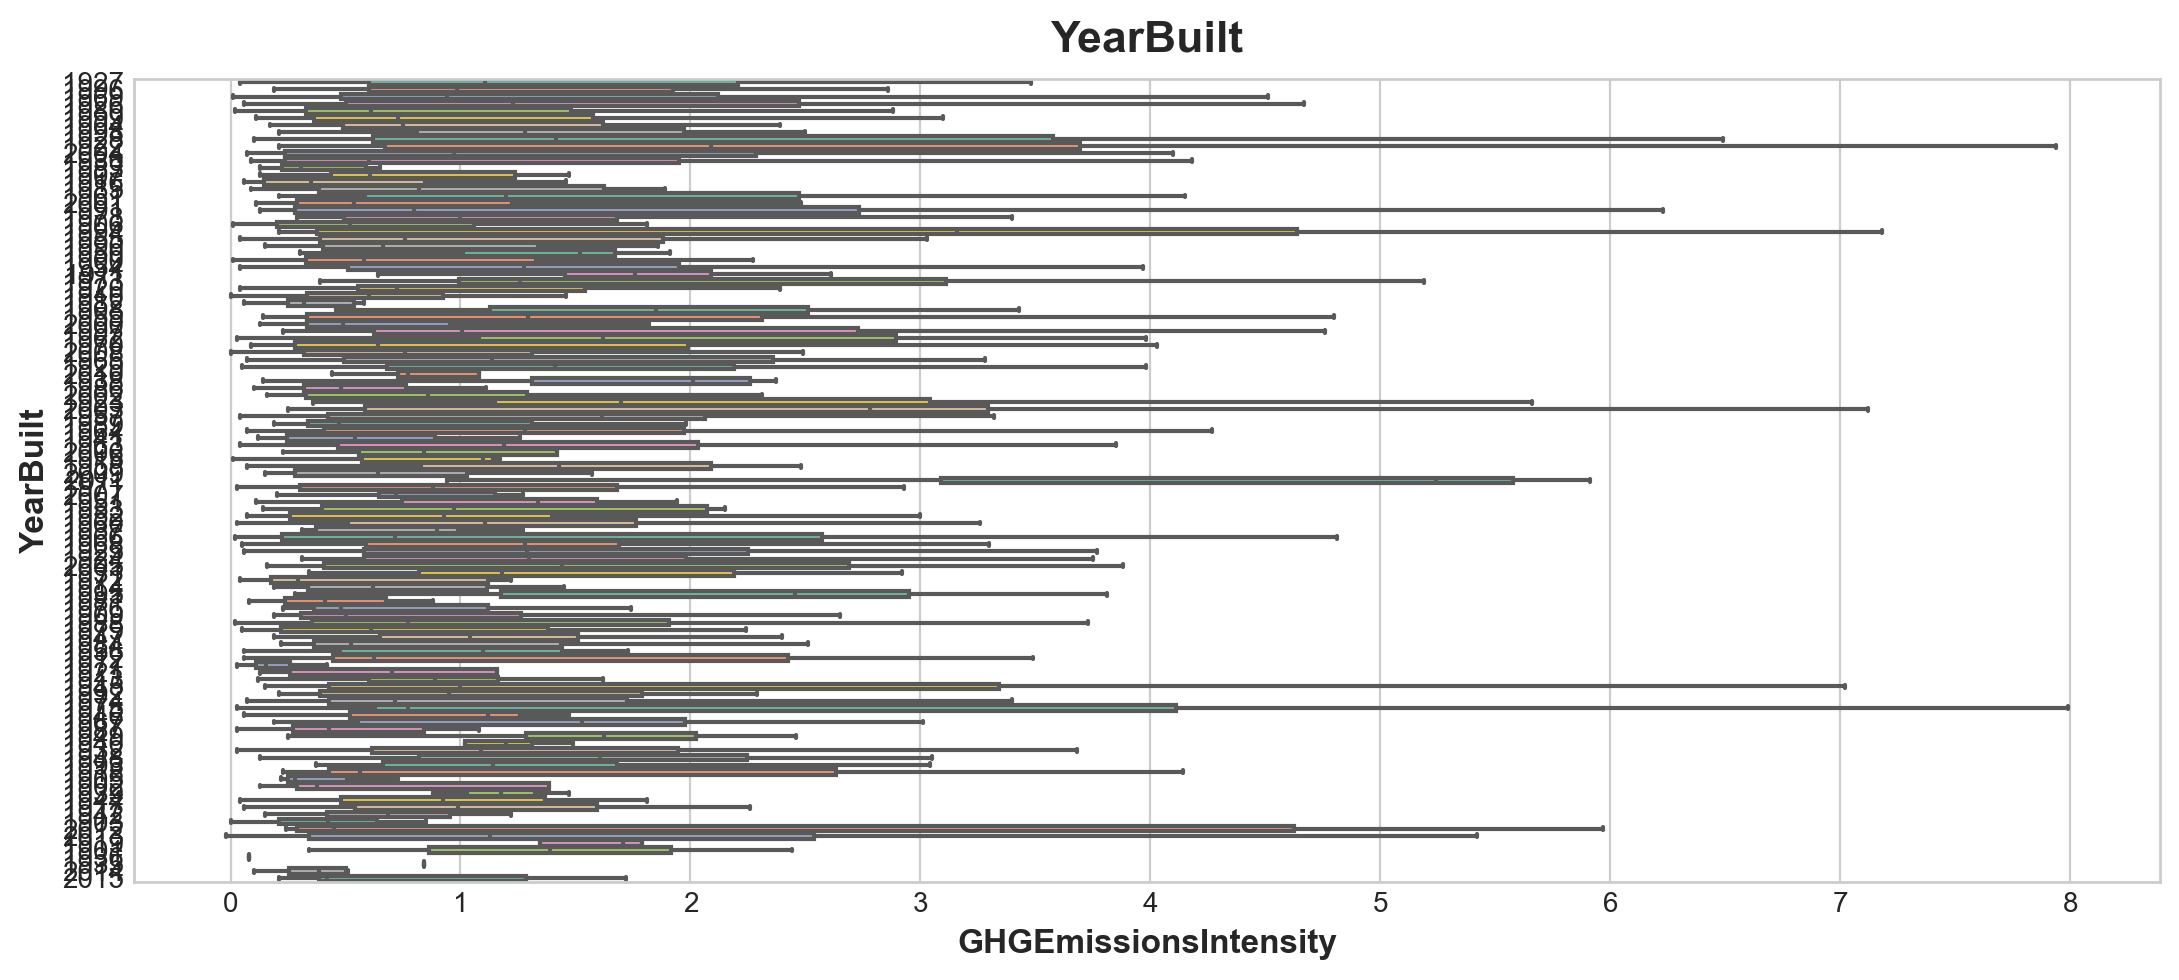


 Distribution de GHGEmissionsIntensity et  NumberofBuildings
NumberofBuildings
1.0     1571
2.0       14
3.0       12
5.0        8
4.0        4
6.0        4
14.0       2
8.0        2
27.0       1
11.0       1
9.0        1
7.0        1
23.0       1
10.0       1
Name: count, dtype: int64


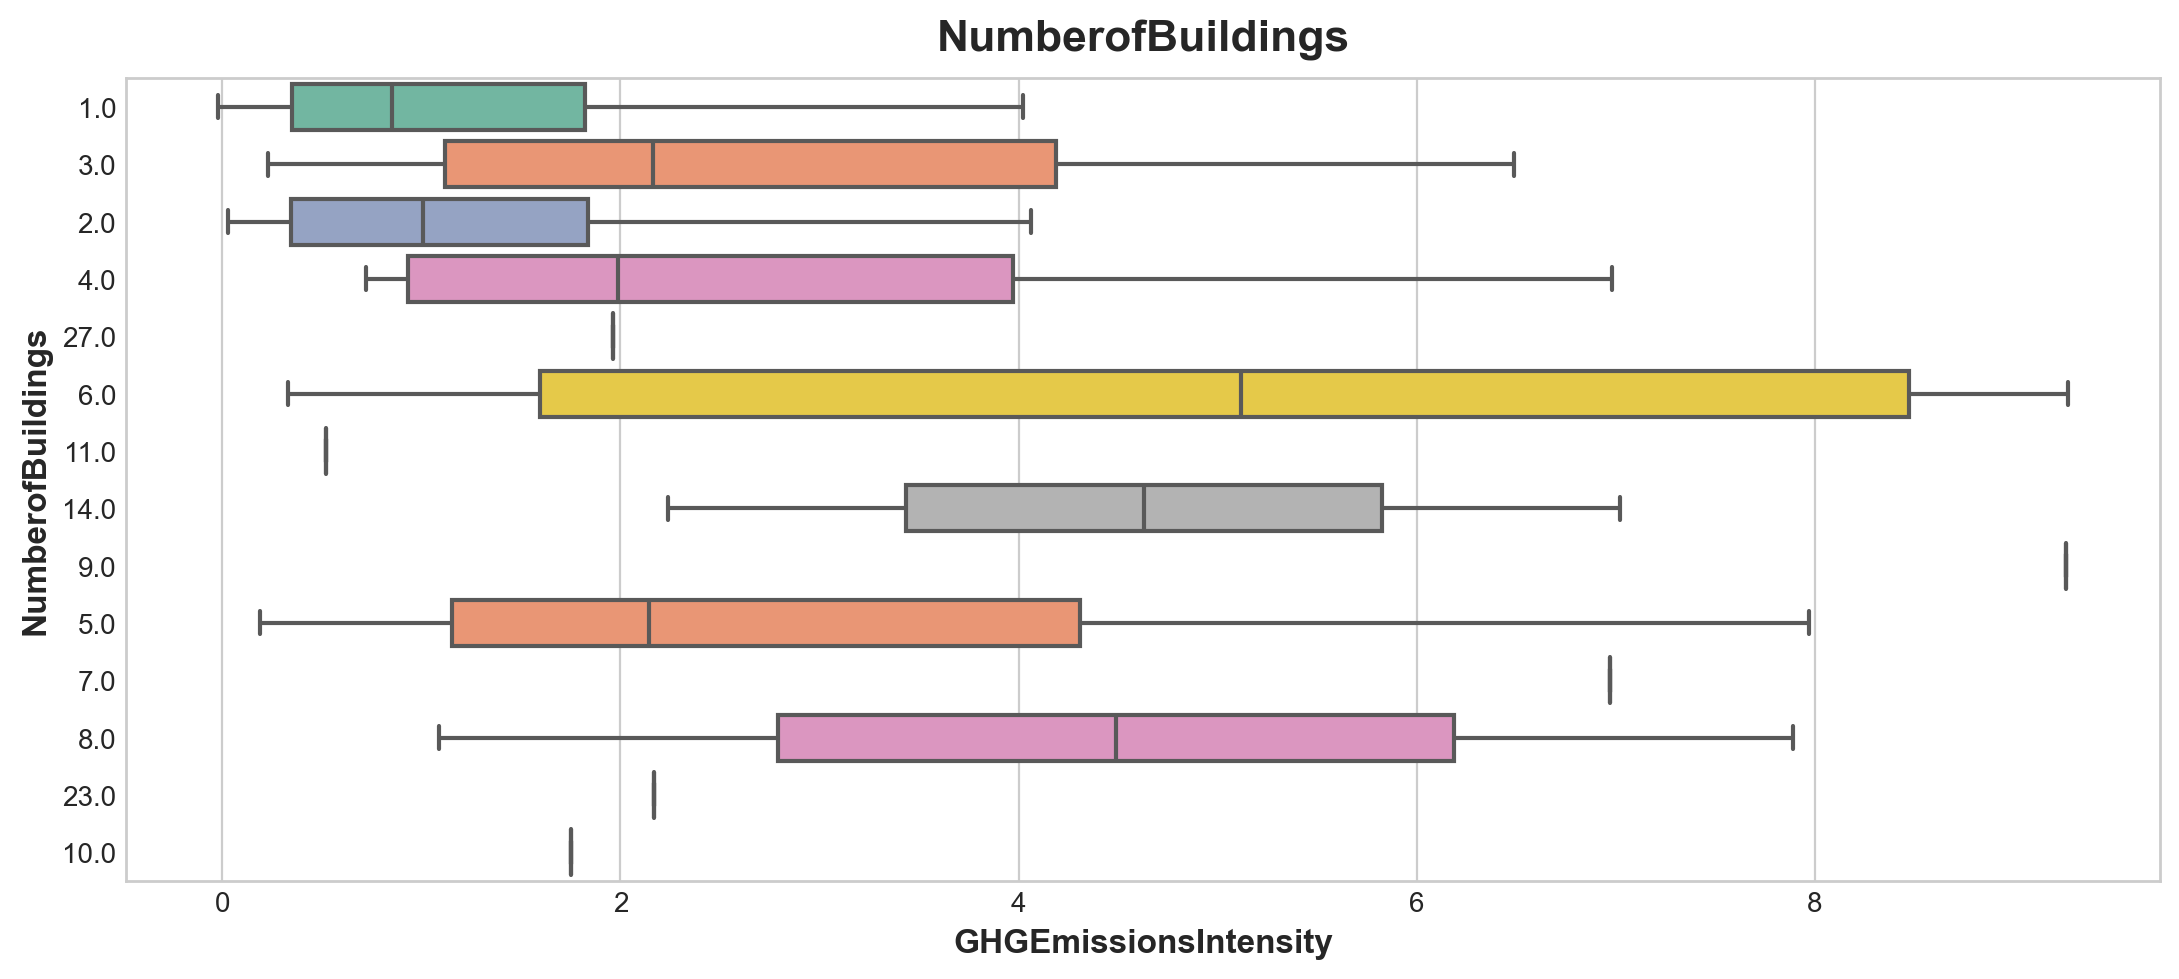


 Distribution de GHGEmissionsIntensity et  NumberofFloors
NumberofFloors
2      457
3      385
4      255
5      140
6      101
7       83
8       33
9       22
11      18
12      18
1       11
15       9
13       9
10       7
14       7
43       5
20       5
16       5
18       4
17       3
22       3
23       3
24       3
30       3
19       3
21       3
25       3
26       3
34       3
37       2
35       2
42       2
47       1
100      1
28       1
77       1
57       1
31       1
29       1
56       1
64       1
38       1
50       1
48       1
40       1
Name: count, dtype: int64


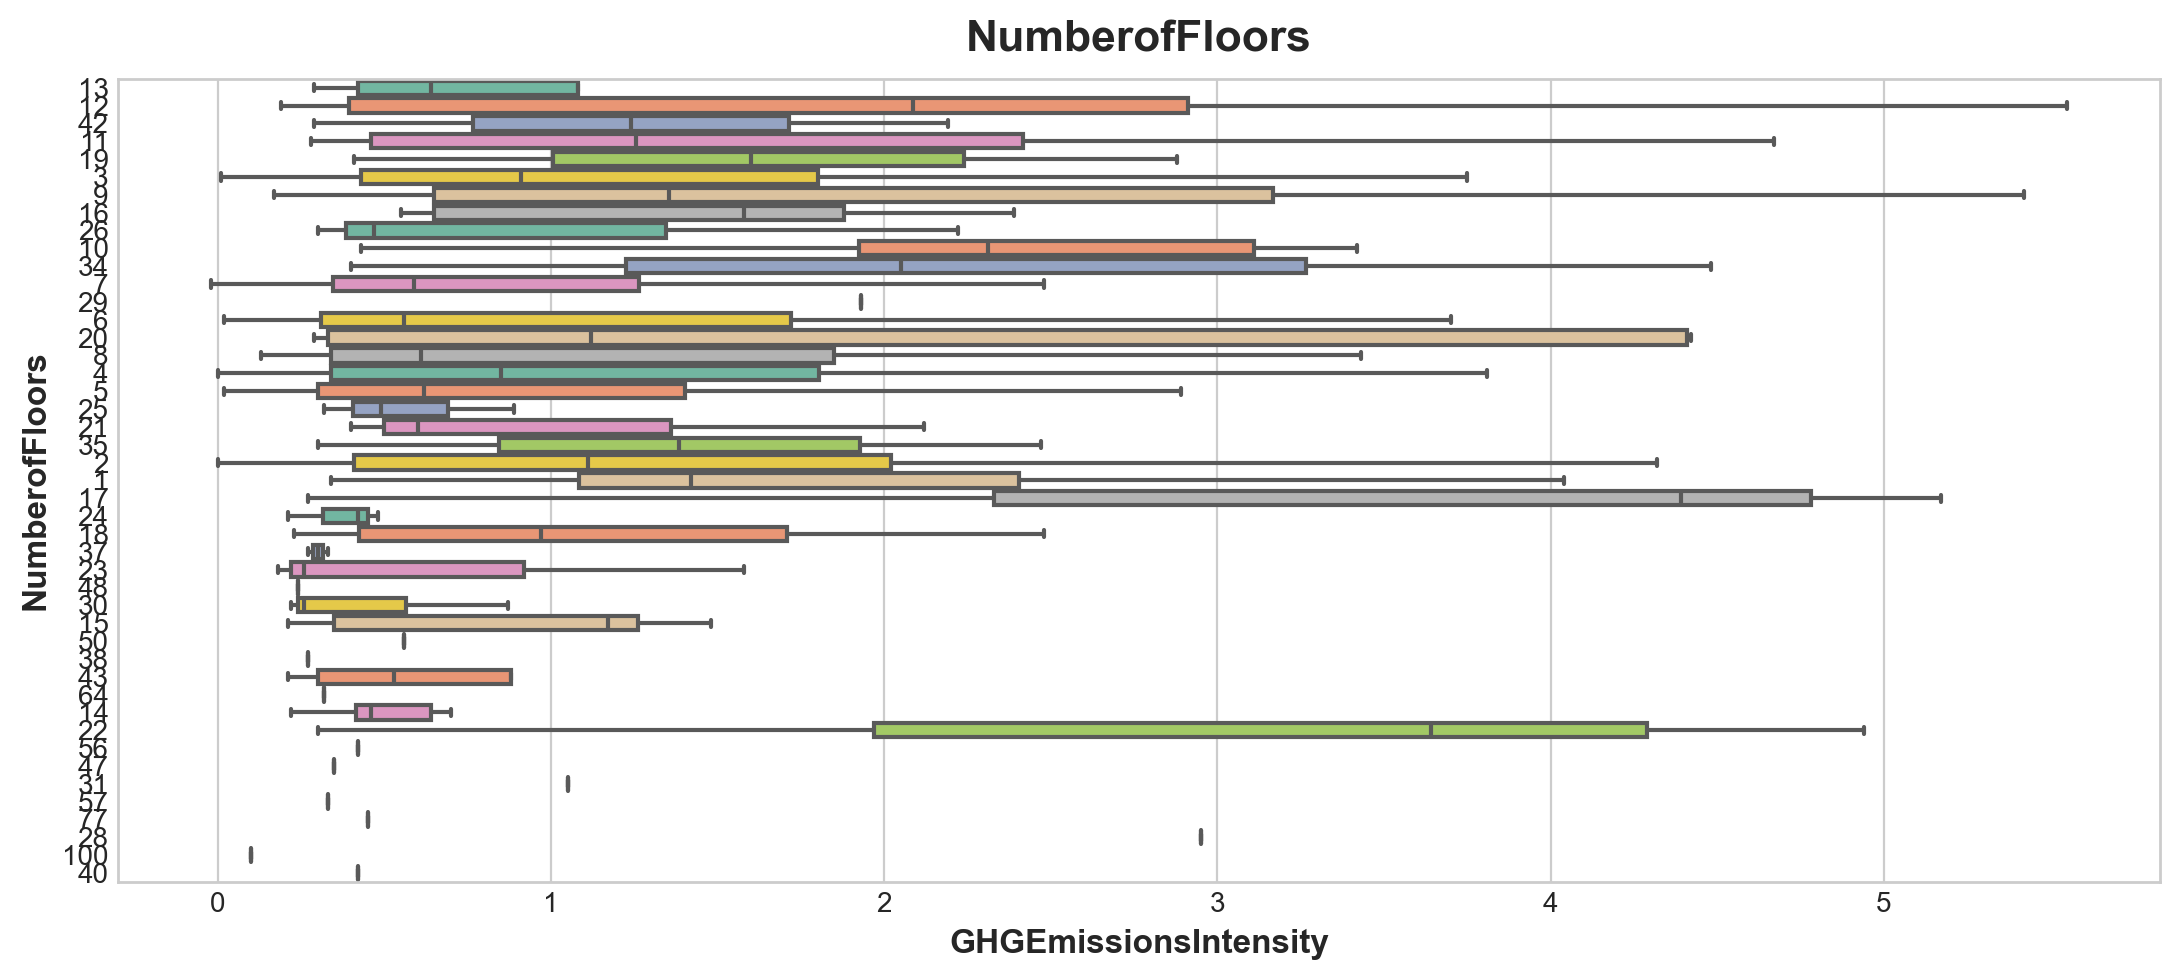


 Distribution de GHGEmissionsIntensity et  decennie
decennie
6     208
2     197
4     169
5     163
7     157
3     139
10    133
11    125
1     101
12     96
9      84
8      51
Name: count, dtype: int64


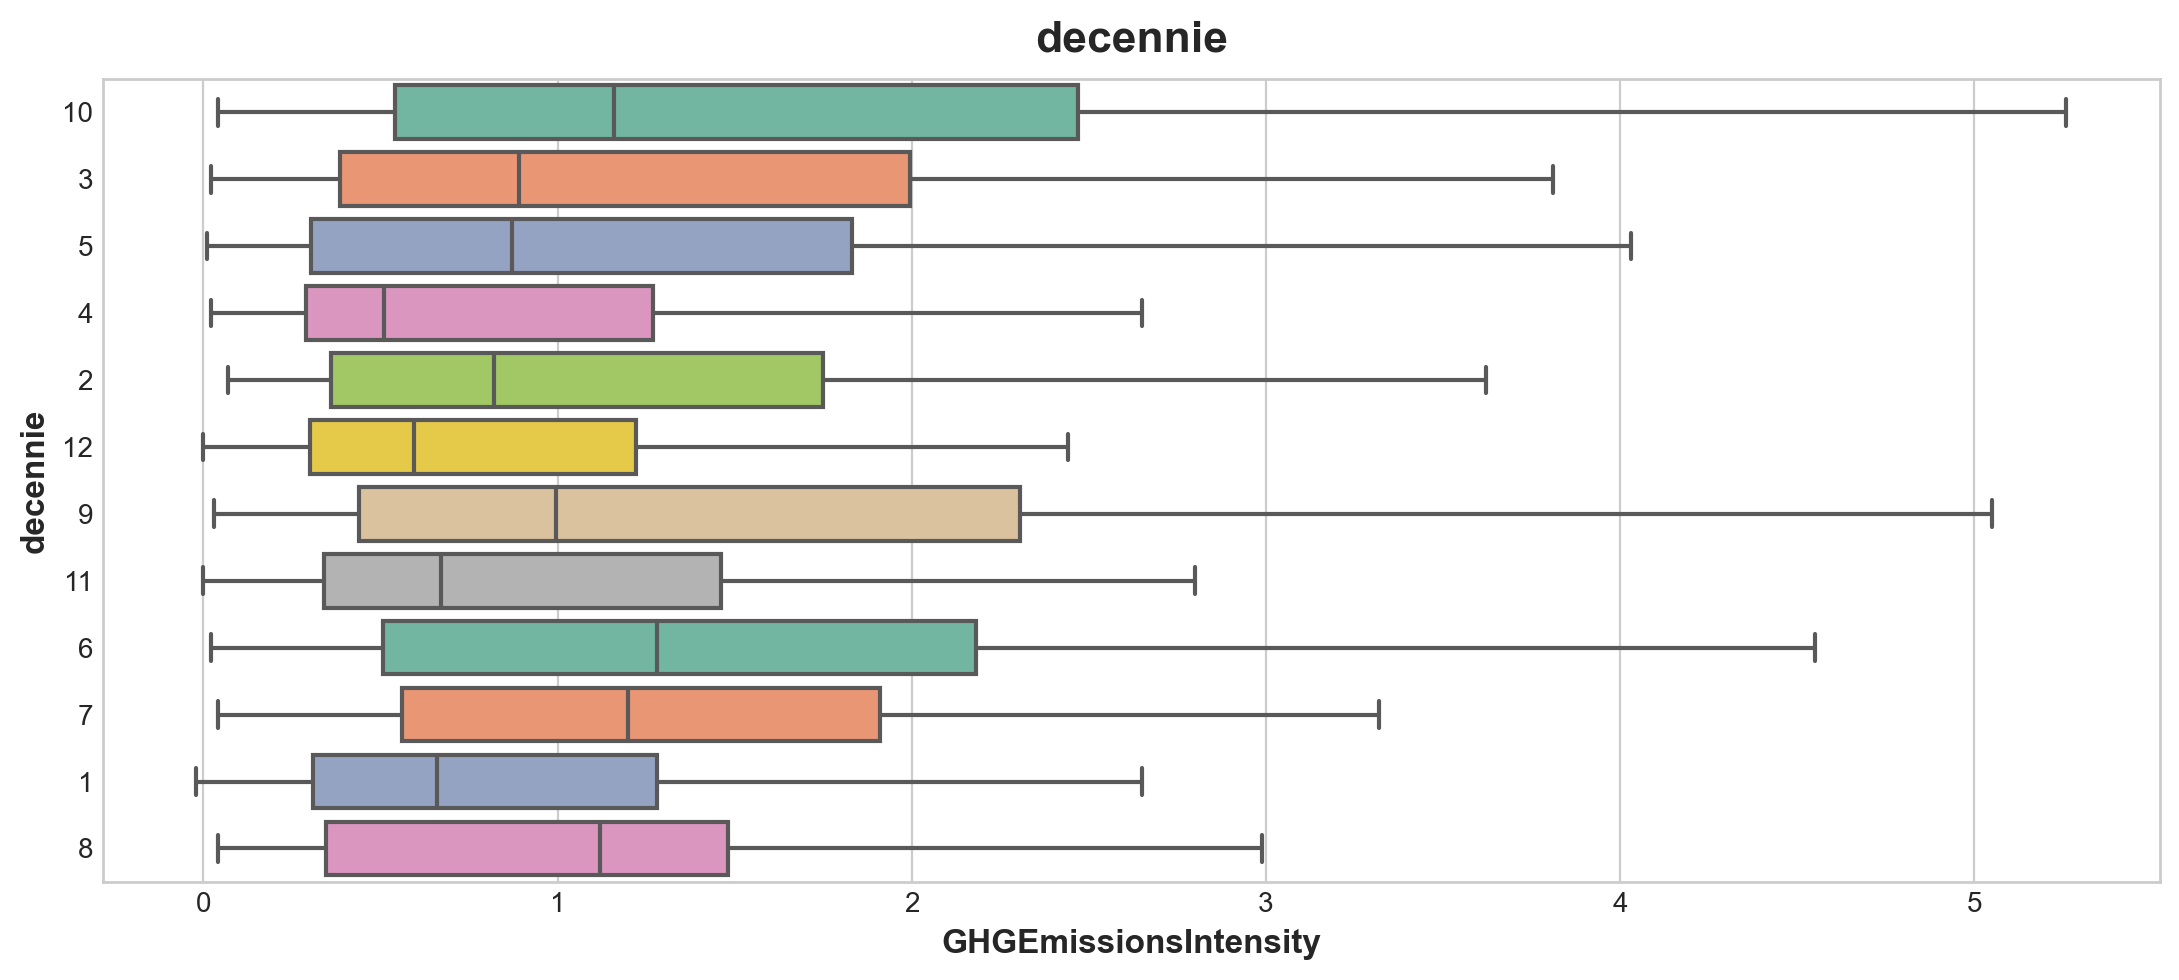

In [41]:
for col_categ in cols_categ :
    boxplot_test(col_categ,'GHGEmissionsIntensity')

# 2. OLS

In [92]:
def format_col(str):
    """
    Formate les colonnes du dataframe
    """
    str = str.replace("""'""","")
    str = str.replace("""\n""","")
    str = str.replace("""/""","")
    str = str.replace(""" ""","_")
    str = str.replace("-","_")
    str = str.replace("(","")
    str = str.replace(")","")
    str = str.replace(",","_")
    str = str.replace("&","and")
    return str

In [93]:
def ols_auto(df_ols,list_cols,target,return_last_arg1=False):
    """
    df : DataFrame cleaned up ( no NaN and categorical must be encoded)
    list_cols : List of columns  ex : list(df_ols.columns) avec la cible !! 
    target : String of the col target ex:  'target'
    return_last_arg1 : renvoi du dernier arg1 (str) pour peaufiner l'anova
    """
    # conversion en liste
    if type(list_cols) != list :
      try:
        list_cols_asList = list(list_cols)
      except:
        print("Le second argument n'est pas convertissable en Liste Python ! ")
    else:
      list_cols_asList = list_cols.copy()

    # définition du df de travail
    df_test = df_ols[list_cols_asList].copy()

    # conversion en float des colonnes concernées
    for col in df_test.columns:
        try:
            df_test.loc[:,col] = df_test[col].astype(float,errors='ignore')
        except: # !!!  fonctionnalité d'erreur non testée pas testée
            print('Error : could not convert column : ',col,' to float')
    while True :
        # A REVOIR :  pour retirer un élément à chaque itération  ( utiliser regex ou autre ? )
        # construction de l'argument 1 ( chaine de caractere) dans la fonction ols
        str2=""
        for col in list_cols_asList :
            if col == target:
                pass
            else:
                str2+= (" + " + col )
        format_str= str2[2:]
        ols_arg1 = target +" ~ "+format_str + " -1 "
        # realisation de l'ols
        test_reg = ols(ols_arg1, data=df_test).fit()
        #print(i,test_reg.pvalues.idxmax(),test_reg.pvalues.max())
        # si p value max est inférieure à 5 % , break
        if  test_reg.pvalues.max() < 0.05:
            break
        else:
            list_cols_asList.remove(test_reg.pvalues.idxmax())
    if return_last_arg1 :
      return test_reg, ols_arg1
    return test_reg

In [95]:
ols_df = df.copy()
ols_df = pd.get_dummies(ols_df, columns=['Neighborhood'], drop_first=True)
# cols unusable
cols_unusable = ['NumberofBuildings','NumberofFloors','YearBuilt','BuildingType','PrimaryPropertyType','SiteEUIWN(kBtu/sf)','LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA','PropertyGFATotal','PropertyGFAParking','ListOfAllPropertyUseTypes','SiteEUI(kBtu/sf)','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','Latitude', 'Longitude','SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','ComplianceStatus','GHGEmissionsIntensity']
ols_df.drop(columns=cols_unusable, inplace=True)
# renaming columns to perform ols
for col in ols_df.columns:
    col_formatted = format_col(col)
    ols_df.rename(columns={col:col_formatted},inplace=True)

### 2.1 GHG : Anova

['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors',
       'PropertyGFABuilding(s)',
       'ComplianceStatus',
       'Outlier']

In [96]:
olsGHG_df = ols_df.copy()
#manually drop the SiteEnergyUsekBtu
olsGHG_df.drop(columns=['SiteEnergyUseWNkBtu'], inplace=True)

In [97]:
GHG_reg, arg1= ols_auto(olsGHG_df,olsGHG_df.columns,'TotalGHGEmissions', return_last_arg1=True)
print(GHG_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:      TotalGHGEmissions   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              737.8
Date:                Fri, 04 Aug 2023   Prob (F-statistic):                        0.00
Time:                        14:58:21   Log-Likelihood:                         -10702.
No. Observations:                1623   AIC:                                  2.145e+04
Df Residuals:                    1600   BIC:                                  2.157e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [86]:
arg1

'TotalGHGEmissions ~  PropertyGFABuildings + is_campus + p_gas + p_elec + p_steam + WN_ratio + Data_Center + Office + Other + Hotel + SupermarketGrocery_Store + Medical_Office + Other___Recreation + CollegeUniversity + Other___EntertainmentPublic_Assembly + Senior_Care_Community + Laboratory + Hospital_General_Medical_and_Surgical + Strip_Mall + floor_building -1 '

In [51]:
# remplacement des + par , pour pouvoir intégrer ces colonnes à une liste facilement
arg1[20:-3].replace('+',"','")

" is_campus ',' p_gas ',' p_elec ',' p_steam ',' WN_ratio ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' Parking ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall ',' floor_building ',' ratio_GFAdecennie "

### 2.1 Bilan

On pourra utiliser les colonnes énumérées ci-dessus cependant la forte multicollinéarité(6.26e+07) , indique une véritable amélioration possible sur le feature engineering.

## 2.2 SiteEnergyUse(kBtu) : Anova

In [103]:
ols_energy_df = ols_df.copy()
ols_energy_df.drop(columns=['TotalGHGEmissions'], inplace = True)

In [104]:
energy_reg, arg_energy = ols_auto(ols_energy_df,ols_energy_df.columns,'SiteEnergyUseWNkBtu',return_last_arg1=True)
print(energy_reg.summary())

                                 OLS Regression Results                                 
Dep. Variable:     SiteEnergyUseWNkBtu   R-squared (uncentered):                   0.910
Model:                             OLS   Adj. R-squared (uncentered):              0.908
Method:                  Least Squares   F-statistic:                              572.8
Date:                 Fri, 04 Aug 2023   Prob (F-statistic):                        0.00
Time:                         15:00:02   Log-Likelihood:                         -27696.
No. Observations:                 1623   AIC:                                  5.545e+04
Df Residuals:                     1595   BIC:                                  5.560e+04
Df Model:                           28                                                  
Covariance Type:             nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
----

In [54]:
# remplacement des + par , pour pouvoir copier/coller ces colonnes dans une liste facilement
arg_energy[22:-3].replace('+',"','")

" is_campus ',' WN_ratio ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall ',' floor_building ',' Neighborhood_northeast "

### 2.2 Bilan

On pourra utiliser les colonnes énumérées ci-dessus cependant, encore une fois... ,  la forte multicollinéarité(6.44e+07) , indique une véritable amélioration possible sur le feature engineering.